In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
shot_angle_data = pd.read_csv('all_shot_angles.csv')

In [5]:
shot_angle_data.head()

,distance,angle,shot_type,is_counter,is_scored
0,15.000000,0.393468,strong foot,0,1
1,15.132746,0.471033,strong foot,0,0
2,4.472136,1.348949,head/body,0,1
3,25.495098,0.215092,weak foot,0,0
4,32.015621,0.178965,strong foot,0,0


In [6]:
shot_angle_data.describe(include = 'all')

,distance,angle,shot_type,is_counter,is_scored
count,30913.000000,30913.000000,30912,30913.000000,30913.000000
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,strong foot,NaN,NaN
freq,NaN,NaN,19137,NaN,NaN
mean,19.501092,0.370832,NaN,0.057484,0.138130
std,9.057238,0.273869,NaN,0.232769,0.345042
min,1.000000,0.000000,NaN,0.000000,0.000000
25%,12.369317,0.194253,NaN,0.000000,0.000000
50%,18.601075,0.279301,NaN,0.000000,0.000000
75%,25.709920,0.472389,NaN,0.000000,0.000000


In [7]:
shot_angle_data.shot_type.value_counts()

strong foot     19137
head/body        6197
weak foot        5573
unknown foot        5
Name: shot_type, dtype: int64

In [8]:
shot_angle_data = shot_angle_data[shot_angle_data.shot_type != 'unknown foot']

In [9]:
shot_angle_data['shot_type'] = shot_angle_data['shot_type'].astype('category')

<AxesSubplot:>

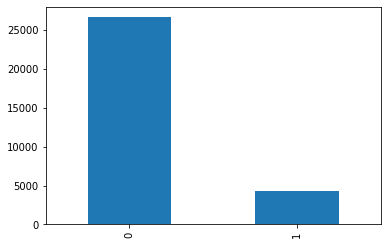

In [10]:
shot_angle_data['is_scored'].value_counts().plot.bar()

<AxesSubplot:xlabel='distance'>

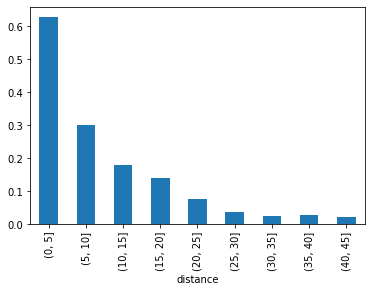

In [11]:
shot_angle_data.groupby(pd.cut(shot_angle_data.distance, np.arange(0, 50, 5))).mean()['is_scored'].plot(kind = "bar")

<AxesSubplot:xlabel='angle'>

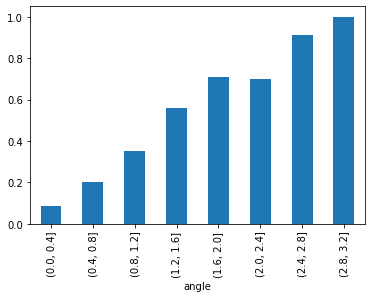

In [12]:
shot_angle_data.groupby(pd.cut(shot_angle_data.angle, np.arange(0, np.pi+0.3, 0.4))).mean()['is_scored'].plot(kind = "bar")

In [13]:
shot_angle_data.groupby('shot_type').mean()

,distance,angle,is_counter,is_scored
shot_type,,,,
head/body,11.487415,0.577541,0.012264,0.131999
strong foot,22.144816,0.311043,0.068140,0.135183
weak foot,19.328002,0.346422,0.070877,0.155213


In [14]:
shot_angle_data[shot_angle_data.distance < 20].groupby('shot_type').mean()

,distance,angle,is_counter,is_scored
shot_type,,,,
head/body,11.045043,0.590453,0.012473,0.134209
strong foot,13.858659,0.463513,0.076757,0.255265
weak foot,13.738245,0.462636,0.073695,0.244547


In [15]:
shot_angle_data.groupby('is_counter').mean()

,distance,angle,is_scored
is_counter,,,
0,19.447155,0.374760,0.135036
1,20.368818,0.306742,0.189296


<AxesSubplot:xlabel='distance', ylabel='angle'>

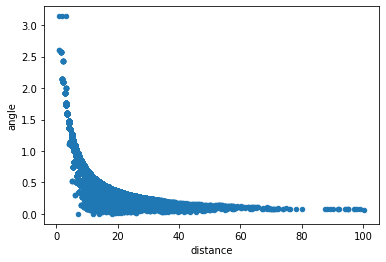

In [16]:
shot_angle_data.plot.scatter(x = 'distance', y = 'angle')

In [17]:
shot_angle_data.corr()

,distance,angle,is_counter,is_scored
distance,1.000000,-0.708409,0.023676,-0.266096
angle,-0.708409,1.000000,-0.057781,0.290584
is_counter,0.023676,-0.057781,1.000000,0.036585
is_scored,-0.266096,0.290584,0.036585,1.000000


### Final Processing:

In order for our model to be able to use categorical variables like 'shot_type', we need to encode them as numerical values. To do this we opt for one-hot encoding.

In [18]:
data = pd.get_dummies(shot_angle_data)
data.head()

,distance,angle,is_counter,is_scored,shot_type_head/body,shot_type_strong foot,shot_type_weak foot
0,15.000000,0.393468,0,1,0,1,0
1,15.132746,0.471033,0,0,0,1,0
2,4.472136,1.348949,0,1,1,0,0
3,25.495098,0.215092,0,0,0,0,1
4,32.015621,0.178965,0,0,0,1,0


# Models:

We begin by partitioning our data into a training set and test set. We use stratified sampling to ensure both classes are represented in the two sets.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X, y = data.drop(columns = ['is_scored']), data['is_scored']
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify = y, random_state = 163)

In [21]:
train_X.head()

,distance,angle,is_counter,shot_type_head/body,shot_type_strong foot,shot_type_weak foot
3656,19.313208,0.141537,0,0,1,0
4120,21.470911,0.162102,0,0,1,0
26889,8.485281,0.643137,0,0,1,0
24882,13.152946,0.537639,0,1,0,0
13754,6.403124,0.814846,0,1,0,0


Before selecting and training a model, we need to identify a suitable metric. The obvious choice is the area under the ROC curve (AUC) since we are dealing with imbalanced classes and we want to predict probabilities rather than classes.

In [22]:
from sklearn.metrics import roc_auc_score

### Baseline 1:

We start with a very simple model whose main purpose is to serve as a baseline to measure future models against. For this model we will simply partition the distance of the shot into three 'bins'. So our model will check to see if the shot is either 0-18 metres out, 18-36 metres out or 36+ metres out.

In [23]:
#distance_bins = np.concatenate((np.arange(0, 30, 10), np.array([120])))
distance_bins = np.array([0, 18, 36, 120])

In [24]:
dist_to_prob = train_y.groupby(pd.cut(train_X.distance, distance_bins)).mean().to_dict()
dist_to_prob

{Interval(0, 18, closed='right'): 0.2237334550433592,
 Interval(18, 36, closed='right'): 0.06318273180110111,
 Interval(36, 120, closed='right'): 0.035759897828863345}

So when a shot occurs from less than 18 metres out, 0.2237 of these shots end up in a goal. We can assign these values to our test set to get some predictions.

In [25]:
preds_bs_bins = pd.cut(test_X.distance, distance_bins).map(dist_to_prob)
preds_bs_bins

681      0.223733
20950    0.223733
25264    0.223733
23564    0.223733
8509     0.223733
           ...   
12293    0.223733
17085    0.063183
4660     0.223733
14521    0.035760
14369    0.223733
Name: distance, Length: 7727, dtype: category
Categories (3, float64): [0.223733 < 0.063183 < 0.035760]

Now, we compute the AUC score:

In [26]:
roc_auc_score(test_y, preds_bs_bins)

0.6778998798055967

### Baseline 2a:

We will create a slightly better model. Looking back at the correlation plot, we see that the angle of the shot has the highest correlation with the shot being a goal. Let's create a linear model with only the angle by using logistic regression.

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
logit_model = LogisticRegression(random_state = 163, penalty = 'none')

In [29]:
logit_model.fit(train_X.angle.values.reshape(-1, 1), train_y)

LogisticRegression(penalty='none', random_state=163)

We have two parameters for the model given by the coefficient of the angle and the intercept:

In [30]:
logit_model.coef_, logit_model.intercept_

(array([[2.35627457]]), array([-2.8350027]))

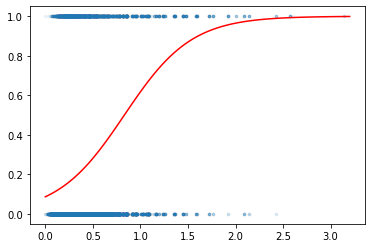

In [32]:
plt.scatter(train_X.angle.values.reshape(-1, 1), train_y, s = 6, alpha = 0.07)
plt.plot(np.linspace(0, 3.2, 100), 1 / (1 + np.exp( (2.35627457 + -2.8350027 * np.linspace(0, 3.2, 100)) )), c = "red")

The model looks sensible so we can test how well it performs on the unseen test set.

In [33]:
preds_bs_logit = logit_model.predict_proba(test_X.angle.values.reshape(-1, 1))[:, 1]
preds_bs_logit

array([0.10809486, 0.19607776, 0.23238452, ..., 0.2347697 , 0.07747043,
       0.15238997])

In [34]:
roc_auc_score(test_y, preds_bs_logit)

0.7039914722155198

Better than our very crude baseline model.

### Baseline 2b:

Now let's extend our logistic regression model to take into account both the distance and the angle. We saw that the distance and angle were highly correlated, but heuristically we might expect the distance to provide more information than just the angle alone. For example, the distance...

In [35]:
logit_model_b = LogisticRegression(random_state = 163, penalty = 'none')
logit_model_b.fit(train_X[['distance', 'angle']], train_y)

LogisticRegression(penalty='none', random_state=163)

In [36]:
preds_bs_logit_b = logit_model_b.predict_proba(test_X[['distance', 'angle']])[:, 1]

In [37]:
roc_auc_score(test_y, preds_bs_logit_b)

0.7405319488197944

An improvement over our previous AUC score of 0.704.

### Random Forest:



In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf_model = RandomForestClassifier(n_estimators = 500, min_samples_split = 400, random_state = 163, max_depth = 12, 
                                 max_features = None)

In [40]:
rf_model.fit(train_X, train_y)

RandomForestClassifier(max_depth=12, max_features=None, min_samples_split=400,
                       n_estimators=500, random_state=163)

In [41]:
preds_rf = rf_model.predict_proba(test_X)[:, 1]

In [42]:
roc_auc_score(test_y, preds_rf)

0.7761538831453925

In [43]:
feat_df = pd.DataFrame({"features" : train_X.columns, 
                        "importance" : rf_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
feat_df.head()

,features,importance
0,distance,0.712237
3,shot_type_head/body,0.177523
1,angle,0.092138
2,is_counter,0.013402
4,shot_type_strong foot,0.002861


<AxesSubplot:ylabel='features'>

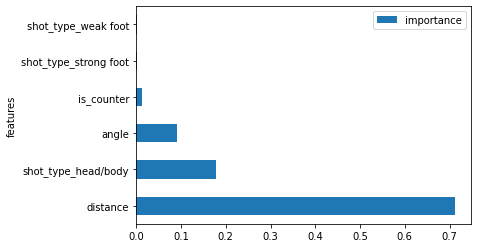

In [44]:
feat_df.plot(kind = 'barh', x = 'features')

We see that distance is the most important feature. The shot type being headed is the second most important (unsurprisingly). The angle of the shot as well as the shot coming from a counter-attack are also significant. However, somewhat surprisingly, the distinction between a weak-footed shot and a strong-footed shot is almost insignificant.

Let's drop the footedness variables from the data and retrain the model:

In [45]:
rf_model_b = RandomForestClassifier(n_estimators = 500, min_samples_split = 400, random_state = 163, max_depth = 12, 
                                 max_features = None)
rf_model_b.fit(train_X.drop(columns = ['shot_type_strong foot', 'shot_type_weak foot']), train_y)
preds_rf_b = rf_model_b.predict_proba(test_X.drop(columns = ['shot_type_strong foot', 'shot_type_weak foot']))[:, 1]
roc_auc_score(test_y, preds_rf_b)

0.7764564080152849

We get a higher AUC score than before.

### Gradient Boosting and Fine Tuning:
Now that we understand the data and which features are important we can implement a more sophisticated model. We are going to use the LightGBM package to implement gradient tree boosting and use the Optuna package to find the optimal hyper-parameters.

First, we want to partition the training data so that we can use k-fold cross-validation in our optimisation procedure.

In [46]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

We define some helper functions which we can call to fit the model and make predictions multiple times:

In [47]:
def create(hyperparams):
    """Create LGBM Classifier for a given set of hyper-parameters."""
    model = LGBMClassifier(**hyperparams)
    return model

def fit(model, train_X, train_y):
    """Trains the model."""
    model.fit(train_X, train_y)
    return model

def fit_with_stop(model, train_X, train_y, X_val, y_val):
    """Trains the model with early stopping."""
    model.fit(train_X, train_y,
              eval_set=(X_val, y_val),
              early_stopping_rounds=200,
              verbose=100)
    return model

def evaluate(model, test_X, test_y):
    """Computes AUC for the model."""
    yp = model.predict_proba(test_X)[:, 1]
    auc_score = roc_auc_score(test_y, yp)
    return auc_score

def kfold_evaluation(train_X, train_y, k, hyperparams):
    """Runs one k-fold evaluation with the given hyper-params."""
    scores = []
    
    print(f"\n------ {k}-fold evaluation -----")
    print(hyperparams)
    
    kf = KFold(k)
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"----- FOLD {i} -----")
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val)
        train_score = evaluate(model, X_train, y_train)
        val_score = evaluate(model, X_val, y_val)
        scores.append((train_score, val_score))
        
        print(f"Eval AUC: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns=['train score', 'validation score'])
    
    return scores

The `kfold_evaluation` function will be called multiple times. It fits and evaluates a model for given hyper-parameters and returns the validation scores for the model. When using Optuna, we must define an objective function which takes as input a trial object and returns the score for that trial. In our case, it will return the mean (validation) AUC score across each fold. Hence, we want to maximize our objective function.

In [49]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [71]:
def objective(trial):
    # The paramters to try
    hyperparams = {
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 75000),
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 25),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 25),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0000001, 1.0),
        'subsample': trial.suggest_float('subsample', 0.000001, 1.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0)  
    }
    
    # Add our pre-chosen params
    hyperparams.update(BEST_PARAMS)
    
    # Evaluation
    scores = kfold_evaluation(train_X.drop(columns = ['shot_type_strong foot', 'shot_type_weak foot']), 
                              train_y, num_folds, hyperparams)
    
    return scores['validation score'].mean()

We need to define our pre-chosen parameters:

In [72]:
num_folds = 10
BEST_PARAMS = {'metric': 'auc'}

In [73]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, timeout = 1 * 3600)

[I 2021-03-16 16:46:45,201] A new study created in memory with name: no-name-52970510-8216-4756-992c-41e4b1d7003e



------ 10-fold evaluation -----
{'learning_rate': 0.09562020704794998, 'n_estimators': 506, 'num_leaves': 33059, 'max_depth': 7, 'reg_alpha': 9.146532496396913, 'reg_lambda': 2.781483138318314, 'colsample_bytree': 0.9188530409788227, 'subsample': 0.48632552607333757, 'cat_smooth': 6.7838332333989815, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764588
[200]	valid_0's auc: 0.764536
Early stopping, best iteration is:
[52]	valid_0's auc: 0.764834
Eval AUC: 0.7648336576401276
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769146
[200]	valid_0's auc: 0.769259
[300]	valid_0's auc: 0.769258
Early stopping, best iteration is:
[131]	valid_0's auc: 0.769395
Eval AUC: 0.7693945573217373
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770164
[200]	valid_0's auc: 0.769352
Early stopping, best iteration is:
[20]	

[I 2021-03-16 16:46:49,710] Trial 0 finished with value: 0.7711495668036179 and parameters: {'learning_rate': 0.09562020704794998, 'n_estimators': 506, 'num_leaves': 33059, 'max_depth': 7, 'reg_alpha': 9.146532496396913, 'reg_lambda': 2.781483138318314, 'colsample_bytree': 0.9188530409788227, 'subsample': 0.48632552607333757, 'cat_smooth': 6.7838332333989815}. Best is trial 0 with value: 0.7711495668036179.


Eval AUC: 0.766979810451619

------ 10-fold evaluation -----
{'learning_rate': 0.09057359398917586, 'n_estimators': 693, 'num_leaves': 18107, 'max_depth': 3, 'reg_alpha': 14.28231587710784, 'reg_lambda': 8.469690033500575, 'colsample_bytree': 0.9282477904163591, 'subsample': 0.173166513930739, 'cat_smooth': 8.443638798915167, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765362
[200]	valid_0's auc: 0.766026
[300]	valid_0's auc: 0.766026
Early stopping, best iteration is:
[173]	valid_0's auc: 0.766483
Eval AUC: 0.7664826394519215
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769895
[200]	valid_0's auc: 0.770388
[300]	valid_0's auc: 0.770226
Early stopping, best iteration is:
[151]	valid_0's auc: 0.77052
Eval AUC: 0.770520190976914
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771808
[200]	valid_0's 

[I 2021-03-16 16:46:54,325] Trial 1 finished with value: 0.7715717717655168 and parameters: {'learning_rate': 0.09057359398917586, 'n_estimators': 693, 'num_leaves': 18107, 'max_depth': 3, 'reg_alpha': 14.28231587710784, 'reg_lambda': 8.469690033500575, 'colsample_bytree': 0.9282477904163591, 'subsample': 0.173166513930739, 'cat_smooth': 8.443638798915167}. Best is trial 1 with value: 0.7715717717655168.


[200]	valid_0's auc: 0.767696
[300]	valid_0's auc: 0.76765
Early stopping, best iteration is:
[141]	valid_0's auc: 0.767902
Eval AUC: 0.7679024511034376

------ 10-fold evaluation -----
{'learning_rate': 0.04887023222863001, 'n_estimators': 729, 'num_leaves': 69282, 'max_depth': 2, 'reg_alpha': 11.470255191512834, 'reg_lambda': 7.841612175202371, 'colsample_bytree': 0.7237425262620428, 'subsample': 0.6292659623842459, 'cat_smooth': 5.006485485368633, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761435
[200]	valid_0's auc: 0.763286
[300]	valid_0's auc: 0.764644
[400]	valid_0's auc: 0.765569
[500]	valid_0's auc: 0.765937
[600]	valid_0's auc: 0.766086
[700]	valid_0's auc: 0.765748
Did not meet early stopping. Best iteration is:
[594]	valid_0's auc: 0.766116
Eval AUC: 0.7659155248364953
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764182
[200]	valid_0's auc

[I 2021-03-16 16:47:00,854] Trial 2 finished with value: 0.770810637451558 and parameters: {'learning_rate': 0.04887023222863001, 'n_estimators': 729, 'num_leaves': 69282, 'max_depth': 2, 'reg_alpha': 11.470255191512834, 'reg_lambda': 7.841612175202371, 'colsample_bytree': 0.7237425262620428, 'subsample': 0.6292659623842459, 'cat_smooth': 5.006485485368633}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7670179711403432

------ 10-fold evaluation -----
{'learning_rate': 0.09782399137807145, 'n_estimators': 926, 'num_leaves': 14118, 'max_depth': 30, 'reg_alpha': 1.1733534314500331, 'reg_lambda': 16.524450876738776, 'colsample_bytree': 0.9002143009832588, 'subsample': 0.964376485419738, 'cat_smooth': 27.03481208429867, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759119
[200]	valid_0's auc: 0.756706
Early stopping, best iteration is:
[31]	valid_0's auc: 0.763621
Eval AUC: 0.7636213076320199
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759443
[200]	valid_0's auc: 0.755315
Early stopping, best iteration is:
[20]	valid_0's auc: 0.767945
Eval AUC: 0.7679446232464437
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761904
[200]	valid_0's auc: 0.75734
Early stopping, best iteration is:
[19]	val

[I 2021-03-16 16:47:25,150] Trial 3 finished with value: 0.7690981447607792 and parameters: {'learning_rate': 0.09782399137807145, 'n_estimators': 926, 'num_leaves': 14118, 'max_depth': 30, 'reg_alpha': 1.1733534314500331, 'reg_lambda': 16.524450876738776, 'colsample_bytree': 0.9002143009832588, 'subsample': 0.964376485419738, 'cat_smooth': 27.03481208429867}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7650094468904975

------ 10-fold evaluation -----
{'learning_rate': 0.050823250127902654, 'n_estimators': 219, 'num_leaves': 3854, 'max_depth': 11, 'reg_alpha': 8.005640315339255, 'reg_lambda': 9.312911471493534, 'colsample_bytree': 0.3225592638484764, 'subsample': 0.6077327605484293, 'cat_smooth': 23.833207897834438, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.75366
[200]	valid_0's auc: 0.759152
Did not meet early stopping. Best iteration is:
[218]	valid_0's auc: 0.760142
Eval AUC: 0.7601417659856224
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.760212
[200]	valid_0's auc: 0.76803
Did not meet early stopping. Best iteration is:
[219]	valid_0's auc: 0.768893
Eval AUC: 0.7688929562931479
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762395
[200]	valid_0's auc: 0.765558
Did not meet ear

[I 2021-03-16 16:47:30,663] Trial 4 finished with value: 0.7657574095280436 and parameters: {'learning_rate': 0.050823250127902654, 'n_estimators': 219, 'num_leaves': 3854, 'max_depth': 11, 'reg_alpha': 8.005640315339255, 'reg_lambda': 9.312911471493534, 'colsample_bytree': 0.3225592638484764, 'subsample': 0.6077327605484293, 'cat_smooth': 23.833207897834438}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7626867329701565

------ 10-fold evaluation -----
{'learning_rate': 0.07465736507438718, 'n_estimators': 391, 'num_leaves': 57670, 'max_depth': 9, 'reg_alpha': 1.891890954987608, 'reg_lambda': 4.175118774705158, 'colsample_bytree': 0.8721986406894798, 'subsample': 0.5369864774617708, 'cat_smooth': 36.80237611014282, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761623
[200]	valid_0's auc: 0.760293
Early stopping, best iteration is:
[34]	valid_0's auc: 0.762827
Eval AUC: 0.7628274316253176
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764346
[200]	valid_0's auc: 0.761038
Early stopping, best iteration is:
[24]	valid_0's auc: 0.767908
Eval AUC: 0.7679077709259761
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765644
[200]	valid_0's auc: 0.762988
Early stopping, best iteration is:
[23]	vali

[I 2021-03-16 16:47:38,605] Trial 5 finished with value: 0.7694131676797922 and parameters: {'learning_rate': 0.07465736507438718, 'n_estimators': 391, 'num_leaves': 57670, 'max_depth': 9, 'reg_alpha': 1.891890954987608, 'reg_lambda': 4.175118774705158, 'colsample_bytree': 0.8721986406894798, 'subsample': 0.5369864774617708, 'cat_smooth': 36.80237611014282}. Best is trial 1 with value: 0.7715717717655168.


Early stopping, best iteration is:
[66]	valid_0's auc: 0.766851
Eval AUC: 0.7668513361329146

------ 10-fold evaluation -----
{'learning_rate': 0.06358089834120634, 'n_estimators': 986, 'num_leaves': 23235, 'max_depth': 16, 'reg_alpha': 24.310179031885575, 'reg_lambda': 10.06032692434641, 'colsample_bytree': 0.8903716735285332, 'subsample': 0.02547624989526658, 'cat_smooth': 34.52066640717006, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764499
[200]	valid_0's auc: 0.765006
[300]	valid_0's auc: 0.76497
Early stopping, best iteration is:
[173]	valid_0's auc: 0.765055
Eval AUC: 0.7650401498567645
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76916
[200]	valid_0's auc: 0.770103
[300]	valid_0's auc: 0.770077
[400]	valid_0's auc: 0.770077
Early stopping, best iteration is:
[201]	valid_0's auc: 0.770105
Eval AUC: 0.770102531344946
----- FOLD 2 -----
Training u

[I 2021-03-16 16:48:04,993] Trial 6 finished with value: 0.7701506574649203 and parameters: {'learning_rate': 0.06358089834120634, 'n_estimators': 986, 'num_leaves': 23235, 'max_depth': 16, 'reg_alpha': 24.310179031885575, 'reg_lambda': 10.06032692434641, 'colsample_bytree': 0.8903716735285332, 'subsample': 0.02547624989526658, 'cat_smooth': 34.52066640717006}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7650365833802568

------ 10-fold evaluation -----
{'learning_rate': 0.05702071957516, 'n_estimators': 791, 'num_leaves': 41809, 'max_depth': 5, 'reg_alpha': 10.877357153656936, 'reg_lambda': 19.459871323840314, 'colsample_bytree': 0.16836263406023158, 'subsample': 0.8545839409021113, 'cat_smooth': 31.71395053000715, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.750279
[200]	valid_0's auc: 0.755082
[300]	valid_0's auc: 0.756989
[400]	valid_0's auc: 0.757785
[500]	valid_0's auc: 0.758256
[600]	valid_0's auc: 0.758649
[700]	valid_0's auc: 0.758634
Did not meet early stopping. Best iteration is:
[782]	valid_0's auc: 0.758844
Eval AUC: 0.7587980886168315
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.750929
[200]	valid_0's auc: 0.758856
[300]	valid_0's auc: 0.762037
[400]	valid_0's auc: 0.764027
[500]	valid_0's auc: 0.765193
[600]	valid_0's auc: 0.7

[I 2021-03-16 16:48:15,970] Trial 7 finished with value: 0.7659807468931433 and parameters: {'learning_rate': 0.05702071957516, 'n_estimators': 791, 'num_leaves': 41809, 'max_depth': 5, 'reg_alpha': 10.877357153656936, 'reg_lambda': 19.459871323840314, 'colsample_bytree': 0.16836263406023158, 'subsample': 0.8545839409021113, 'cat_smooth': 31.71395053000715}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.764194080174759

------ 10-fold evaluation -----
{'learning_rate': 0.020397422480520854, 'n_estimators': 205, 'num_leaves': 1746, 'max_depth': 10, 'reg_alpha': 19.738245951736694, 'reg_lambda': 5.13110735291713, 'colsample_bytree': 0.8717944447463396, 'subsample': 0.9407912156696849, 'cat_smooth': 19.192547981829467, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759464
[200]	valid_0's auc: 0.763837
Did not meet early stopping. Best iteration is:
[204]	valid_0's auc: 0.763913
Eval AUC: 0.7639126770174586
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766521
[200]	valid_0's auc: 0.769369
Did not meet early stopping. Best iteration is:
[197]	valid_0's auc: 0.769433
Eval AUC: 0.7694330475231146
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769683
[200]	valid_0's auc: 0.771622
Did not meet ea

[I 2021-03-16 16:48:21,889] Trial 8 finished with value: 0.7688979329920421 and parameters: {'learning_rate': 0.020397422480520854, 'n_estimators': 205, 'num_leaves': 1746, 'max_depth': 10, 'reg_alpha': 19.738245951736694, 'reg_lambda': 5.13110735291713, 'colsample_bytree': 0.8717944447463396, 'subsample': 0.9407912156696849, 'cat_smooth': 19.192547981829467}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7641783918916167

------ 10-fold evaluation -----
{'learning_rate': 0.0037317655954993475, 'n_estimators': 220, 'num_leaves': 56425, 'max_depth': 15, 'reg_alpha': 16.15793630272362, 'reg_lambda': 18.5613858466829, 'colsample_bytree': 0.6797658398791673, 'subsample': 0.5390751777133111, 'cat_smooth': 39.15102158278654, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.753608
[200]	valid_0's auc: 0.755518
Did not meet early stopping. Best iteration is:
[216]	valid_0's auc: 0.755758
Eval AUC: 0.7557581346954219
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757936
[200]	valid_0's auc: 0.758813
Early stopping, best iteration is:
[1]	valid_0's auc: 0.760804
Eval AUC: 0.7608038719504705
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767365
[200]	valid_0's auc: 0.769276
Did not meet early stopping. 

[I 2021-03-16 16:48:50,140] Trial 9 finished with value: 0.7624270533453386 and parameters: {'learning_rate': 0.0037317655954993475, 'n_estimators': 220, 'num_leaves': 56425, 'max_depth': 15, 'reg_alpha': 16.15793630272362, 'reg_lambda': 18.5613858466829, 'colsample_bytree': 0.6797658398791673, 'subsample': 0.5390751777133111, 'cat_smooth': 39.15102158278654}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7565462541467949

------ 10-fold evaluation -----
{'learning_rate': 0.08621065753368484, 'n_estimators': 629, 'num_leaves': 18907, 'max_depth': 24, 'reg_alpha': 18.92960207164771, 'reg_lambda': 14.216459152239391, 'colsample_bytree': 0.4711394223125479, 'subsample': 0.10305117053723024, 'cat_smooth': 13.480962891654933, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764993
[200]	valid_0's auc: 0.765501
[300]	valid_0's auc: 0.765438
Early stopping, best iteration is:
[148]	valid_0's auc: 0.765757
Eval AUC: 0.7657567496351548
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769345
[200]	valid_0's auc: 0.770028
[300]	valid_0's auc: 0.770012
Early stopping, best iteration is:
[167]	valid_0's auc: 0.770082
Eval AUC: 0.7700660884947056
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771208
[200]	va

[I 2021-03-16 16:49:17,060] Trial 10 finished with value: 0.7700688640021223 and parameters: {'learning_rate': 0.08621065753368484, 'n_estimators': 629, 'num_leaves': 18907, 'max_depth': 24, 'reg_alpha': 18.92960207164771, 'reg_lambda': 14.216459152239391, 'colsample_bytree': 0.4711394223125479, 'subsample': 0.10305117053723024, 'cat_smooth': 13.480962891654933}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7649920625767453

------ 10-fold evaluation -----
{'learning_rate': 0.09909486833132189, 'n_estimators': 467, 'num_leaves': 33841, 'max_depth': 1, 'reg_alpha': 6.3907853943529584, 'reg_lambda': 0.7303281984212457, 'colsample_bytree': 0.9809391859288613, 'subsample': 0.2672766623058831, 'cat_smooth': 2.9075439799811513, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759464
[200]	valid_0's auc: 0.761784
[300]	valid_0's auc: 0.762396
[400]	valid_0's auc: 0.762402
Did not meet early stopping. Best iteration is:
[324]	valid_0's auc: 0.762516
Eval AUC: 0.7625157930652398
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763789
[200]	valid_0's auc: 0.766984
[300]	valid_0's auc: 0.766802
Early stopping, best iteration is:
[181]	valid_0's auc: 0.767301
Eval AUC: 0.7673013455191673
----- FOLD 2 -----
Training until validation scores don't improve for 200 rou

[I 2021-03-16 16:49:21,930] Trial 11 finished with value: 0.7690711241965732 and parameters: {'learning_rate': 0.09909486833132189, 'n_estimators': 467, 'num_leaves': 33841, 'max_depth': 1, 'reg_alpha': 6.3907853943529584, 'reg_lambda': 0.7303281984212457, 'colsample_bytree': 0.9809391859288613, 'subsample': 0.2672766623058831, 'cat_smooth': 2.9075439799811513}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7680423736287592

------ 10-fold evaluation -----
{'learning_rate': 0.08384808359384277, 'n_estimators': 508, 'num_leaves': 35698, 'max_depth': 5, 'reg_alpha': 14.76965392536535, 'reg_lambda': 0.05479431034612725, 'colsample_bytree': 0.6449117338089407, 'subsample': 0.2945585536908297, 'cat_smooth': 10.855645500582108, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765668
[200]	valid_0's auc: 0.766023
[300]	valid_0's auc: 0.765926
Early stopping, best iteration is:
[140]	valid_0's auc: 0.766069
Eval AUC: 0.766069232744176
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769768
[200]	valid_0's auc: 0.769858
[300]	valid_0's auc: 0.76985
Early stopping, best iteration is:
[137]	valid_0's auc: 0.770026
Eval AUC: 0.7699927933239975
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770674
[200]	valid

[I 2021-03-16 16:49:28,065] Trial 12 finished with value: 0.7708222967443098 and parameters: {'learning_rate': 0.08384808359384277, 'n_estimators': 508, 'num_leaves': 35698, 'max_depth': 5, 'reg_alpha': 14.76965392536535, 'reg_lambda': 0.05479431034612725, 'colsample_bytree': 0.6449117338089407, 'subsample': 0.2945585536908297, 'cat_smooth': 10.855645500582108}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7655818572213592

------ 10-fold evaluation -----
{'learning_rate': 0.09869057876708921, 'n_estimators': 658, 'num_leaves': 25753, 'max_depth': 1, 'reg_alpha': 6.887426404861712, 'reg_lambda': 24.85595339422604, 'colsample_bytree': 0.01104770752778872, 'subsample': 0.2999541709222314, 'cat_smooth': 9.640697642241511, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.754594
[200]	valid_0's auc: 0.756746
[300]	valid_0's auc: 0.757856
[400]	valid_0's auc: 0.758228
[500]	valid_0's auc: 0.758578
[600]	valid_0's auc: 0.759001
Did not meet early stopping. Best iteration is:
[589]	valid_0's auc: 0.75903
Eval AUC: 0.758980933463056
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757648
[200]	valid_0's auc: 0.760874
[300]	valid_0's auc: 0.763395
[400]	valid_0's auc: 0.764133
[500]	valid_0's auc: 0.764677
[600]	valid_0's auc: 0.764915
Did not meet early stoppi

[I 2021-03-16 16:49:35,324] Trial 13 finished with value: 0.76624507116594 and parameters: {'learning_rate': 0.09869057876708921, 'n_estimators': 658, 'num_leaves': 25753, 'max_depth': 1, 'reg_alpha': 6.887426404861712, 'reg_lambda': 24.85595339422604, 'colsample_bytree': 0.01104770752778872, 'subsample': 0.2999541709222314, 'cat_smooth': 9.640697642241511}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7651765059055786

------ 10-fold evaluation -----
{'learning_rate': 0.03638743442641726, 'n_estimators': 831, 'num_leaves': 46147, 'max_depth': 23, 'reg_alpha': 13.716664688008523, 'reg_lambda': 4.130470354824416, 'colsample_bytree': 0.510632150762673, 'subsample': 0.7709533514044481, 'cat_smooth': 3.0712897387990132, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7641
[200]	valid_0's auc: 0.765201
[300]	valid_0's auc: 0.765657
[400]	valid_0's auc: 0.765609
[500]	valid_0's auc: 0.765594
Early stopping, best iteration is:
[316]	valid_0's auc: 0.765764
Eval AUC: 0.7657635060267012
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76579
[200]	valid_0's auc: 0.769535
[300]	valid_0's auc: 0.769903
[400]	valid_0's auc: 0.769702
Early stopping, best iteration is:
[263]	valid_0's auc: 0.769956
Eval AUC: 0.7699559410035297
----- FOLD 2 -----
Training until 

[I 2021-03-16 16:51:13,124] Trial 14 finished with value: 0.770328878371965 and parameters: {'learning_rate': 0.03638743442641726, 'n_estimators': 831, 'num_leaves': 46147, 'max_depth': 23, 'reg_alpha': 13.716664688008523, 'reg_lambda': 4.130470354824416, 'colsample_bytree': 0.510632150762673, 'subsample': 0.7709533514044481, 'cat_smooth': 3.0712897387990132}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.765588641343799

------ 10-fold evaluation -----
{'learning_rate': 0.07644230868093303, 'n_estimators': 345, 'num_leaves': 10434, 'max_depth': 8, 'reg_alpha': 4.175910429660989, 'reg_lambda': 1.090539775002674, 'colsample_bytree': 0.7475225712605298, 'subsample': 0.1645134159410038, 'cat_smooth': 16.88169461184838, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764038
[200]	valid_0's auc: 0.762903
Early stopping, best iteration is:
[34]	valid_0's auc: 0.764541
Eval AUC: 0.7645405991568024
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767543
[200]	valid_0's auc: 0.766366
Early stopping, best iteration is:
[74]	valid_0's auc: 0.768468
Eval AUC: 0.7684675167268586
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768471
[200]	valid_0's auc: 0.766292
Early stopping, best iteration is:
[23]	valid

[I 2021-03-16 16:51:21,507] Trial 15 finished with value: 0.7700393676449082 and parameters: {'learning_rate': 0.07644230868093303, 'n_estimators': 345, 'num_leaves': 10434, 'max_depth': 8, 'reg_alpha': 4.175910429660989, 'reg_lambda': 1.090539775002674, 'colsample_bytree': 0.7475225712605298, 'subsample': 0.1645134159410038, 'cat_smooth': 16.88169461184838}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7670027068648534

------ 10-fold evaluation -----
{'learning_rate': 0.08807516190040035, 'n_estimators': 553, 'num_leaves': 31659, 'max_depth': 5, 'reg_alpha': 10.059631290135837, 'reg_lambda': 12.13567521850304, 'colsample_bytree': 0.9720159608972747, 'subsample': 0.40476075692915686, 'cat_smooth': 44.88304701899695, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766025
[200]	valid_0's auc: 0.765156
Early stopping, best iteration is:
[71]	valid_0's auc: 0.766442
Eval AUC: 0.766442101102643
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769855
[200]	valid_0's auc: 0.770367
[300]	valid_0's auc: 0.770367
Early stopping, best iteration is:
[140]	valid_0's auc: 0.770437
Eval AUC: 0.7704370685207479
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770724
[200]	valid_0's auc: 0.770492
Early stoppi

[I 2021-03-16 16:51:27,084] Trial 16 finished with value: 0.7713872922635613 and parameters: {'learning_rate': 0.08807516190040035, 'n_estimators': 553, 'num_leaves': 31659, 'max_depth': 5, 'reg_alpha': 10.059631290135837, 'reg_lambda': 12.13567521850304, 'colsample_bytree': 0.9720159608972747, 'subsample': 0.40476075692915686, 'cat_smooth': 44.88304701899695}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7662967341234574

------ 10-fold evaluation -----
{'learning_rate': 0.06924983512916297, 'n_estimators': 579, 'num_leaves': 27194, 'max_depth': 13, 'reg_alpha': 17.059676872881873, 'reg_lambda': 12.352516318967886, 'colsample_bytree': 0.9968679038183363, 'subsample': 0.38886697842824963, 'cat_smooth': 49.06359264494698, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765501
[200]	valid_0's auc: 0.765761
[300]	valid_0's auc: 0.765658
Early stopping, best iteration is:
[159]	valid_0's auc: 0.765945
Eval AUC: 0.7659446617750393
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769711
[200]	valid_0's auc: 0.76979
[300]	valid_0's auc: 0.769782
Early stopping, best iteration is:
[115]	valid_0's auc: 0.769866
Eval AUC: 0.7698658575534972
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771378
[200]	val

[I 2021-03-16 16:51:44,929] Trial 17 finished with value: 0.770703906993266 and parameters: {'learning_rate': 0.06924983512916297, 'n_estimators': 579, 'num_leaves': 27194, 'max_depth': 13, 'reg_alpha': 17.059676872881873, 'reg_lambda': 12.352516318967886, 'colsample_bytree': 0.9968679038183363, 'subsample': 0.38886697842824963, 'cat_smooth': 49.06359264494698}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.765993568651927

------ 10-fold evaluation -----
{'learning_rate': 0.08567096695722237, 'n_estimators': 691, 'num_leaves': 49322, 'max_depth': 20, 'reg_alpha': 23.36479627138868, 'reg_lambda': 7.418626791481028, 'colsample_bytree': 0.7893829801893848, 'subsample': 0.18101546825433565, 'cat_smooth': 47.49001082419615, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763909
[200]	valid_0's auc: 0.764301
[300]	valid_0's auc: 0.764298
Early stopping, best iteration is:
[128]	valid_0's auc: 0.764328
Eval AUC: 0.7643218609804874
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769176
[200]	valid_0's auc: 0.769162
Early stopping, best iteration is:
[87]	valid_0's auc: 0.76925
Eval AUC: 0.7692504238016853
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771617
[200]	valid_0's auc: 0.771682
Early stoppin

[I 2021-03-16 16:52:45,814] Trial 18 finished with value: 0.7699025530763707 and parameters: {'learning_rate': 0.08567096695722237, 'n_estimators': 691, 'num_leaves': 49322, 'max_depth': 20, 'reg_alpha': 23.36479627138868, 'reg_lambda': 7.418626791481028, 'colsample_bytree': 0.7893829801893848, 'subsample': 0.18101546825433565, 'cat_smooth': 47.49001082419615}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7652070344565578

------ 10-fold evaluation -----
{'learning_rate': 0.03679310513673978, 'n_estimators': 859, 'num_leaves': 10724, 'max_depth': 4, 'reg_alpha': 13.010018880163255, 'reg_lambda': 13.590089848964745, 'colsample_bytree': 0.5452627960017904, 'subsample': 0.4085564707982245, 'cat_smooth': 43.811863698501625, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762594
[200]	valid_0's auc: 0.764746
[300]	valid_0's auc: 0.765139
[400]	valid_0's auc: 0.765195
[500]	valid_0's auc: 0.765046
Early stopping, best iteration is:
[354]	valid_0's auc: 0.765302
Eval AUC: 0.7653023823036593
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764674
[200]	valid_0's auc: 0.769342
[300]	valid_0's auc: 0.770213
[400]	valid_0's auc: 0.76997
[500]	valid_0's auc: 0.769994
Early stopping, best iteration is:
[328]	valid_0's auc: 0.770255
Eval AUC: 0.770254854269546
--

[I 2021-03-16 16:52:55,809] Trial 19 finished with value: 0.7706375375824458 and parameters: {'learning_rate': 0.03679310513673978, 'n_estimators': 859, 'num_leaves': 10724, 'max_depth': 4, 'reg_alpha': 13.010018880163255, 'reg_lambda': 13.590089848964745, 'colsample_bytree': 0.5452627960017904, 'subsample': 0.4085564707982245, 'cat_smooth': 43.811863698501625}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7650620238394062

------ 10-fold evaluation -----
{'learning_rate': 0.0889591847165772, 'n_estimators': 566, 'num_leaves': 17321, 'max_depth': 1, 'reg_alpha': 10.310195254125242, 'reg_lambda': 10.908052670242537, 'colsample_bytree': 0.9808252595908457, 'subsample': 0.04904966744452033, 'cat_smooth': 26.057379886886974, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759389
[200]	valid_0's auc: 0.760955
[300]	valid_0's auc: 0.761814
[400]	valid_0's auc: 0.762111
[500]	valid_0's auc: 0.762351
Did not meet early stopping. Best iteration is:
[510]	valid_0's auc: 0.762453
Eval AUC: 0.7624528741689638
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762384
[200]	valid_0's auc: 0.766553
[300]	valid_0's auc: 0.766831
[400]	valid_0's auc: 0.766213
Early stopping, best iteration is:
[220]	valid_0's auc: 0.767043
Eval AUC: 0.767043379275893
----- FOLD 2 -----

[I 2021-03-16 16:53:01,939] Trial 20 finished with value: 0.7688473144139465 and parameters: {'learning_rate': 0.0889591847165772, 'n_estimators': 566, 'num_leaves': 17321, 'max_depth': 1, 'reg_alpha': 10.310195254125242, 'reg_lambda': 10.908052670242537, 'colsample_bytree': 0.9808252595908457, 'subsample': 0.04904966744452033, 'cat_smooth': 26.057379886886974}. Best is trial 1 with value: 0.7715717717655168.


Eval AUC: 0.7676815431164901

------ 10-fold evaluation -----
{'learning_rate': 0.09917138730310715, 'n_estimators': 470, 'num_leaves': 30935, 'max_depth': 7, 'reg_alpha': 9.03345733488458, 'reg_lambda': 6.380068208401317, 'colsample_bytree': 0.8161328431968157, 'subsample': 0.4341580544919756, 'cat_smooth': 7.67148159548228, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764322
[200]	valid_0's auc: 0.764284
Early stopping, best iteration is:
[79]	valid_0's auc: 0.764545
Eval AUC: 0.7645452441759906
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770197
[200]	valid_0's auc: 0.770038
Early stopping, best iteration is:
[52]	valid_0's auc: 0.770882
Eval AUC: 0.7708821626579532
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769892
[200]	valid_0's auc: 0.769535
Early stopping, best iteration is:
[19]	valid_

[I 2021-03-16 16:53:08,094] Trial 21 finished with value: 0.7709460879953667 and parameters: {'learning_rate': 0.09917138730310715, 'n_estimators': 470, 'num_leaves': 30935, 'max_depth': 7, 'reg_alpha': 9.03345733488458, 'reg_lambda': 6.380068208401317, 'colsample_bytree': 0.8161328431968157, 'subsample': 0.4341580544919756, 'cat_smooth': 7.67148159548228}. Best is trial 1 with value: 0.7715717717655168.


[300]	valid_0's auc: 0.765898
Early stopping, best iteration is:
[112]	valid_0's auc: 0.766206
Eval AUC: 0.766205572478172

------ 10-fold evaluation -----
{'learning_rate': 0.09314133251917862, 'n_estimators': 383, 'num_leaves': 38825, 'max_depth': 5, 'reg_alpha': 4.242298422422374, 'reg_lambda': 2.792130573236335, 'colsample_bytree': 0.9877222535696124, 'subsample': 0.630697273083919, 'cat_smooth': 16.07387408746257, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765221
[200]	valid_0's auc: 0.763889
Early stopping, best iteration is:
[56]	valid_0's auc: 0.766222
Eval AUC: 0.7662216738284418
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770051
[200]	valid_0's auc: 0.768321
Early stopping, best iteration is:
[76]	valid_0's auc: 0.77056
Eval AUC: 0.7705599095889738
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 16:53:13,873] Trial 22 finished with value: 0.7715536974222176 and parameters: {'learning_rate': 0.09314133251917862, 'n_estimators': 383, 'num_leaves': 38825, 'max_depth': 5, 'reg_alpha': 4.242298422422374, 'reg_lambda': 2.792130573236335, 'colsample_bytree': 0.9877222535696124, 'subsample': 0.630697273083919, 'cat_smooth': 16.07387408746257}. Best is trial 1 with value: 0.7715717717655168.


[300]	valid_0's auc: 0.767442
Early stopping, best iteration is:
[110]	valid_0's auc: 0.768765
Eval AUC: 0.7687648826686023

------ 10-fold evaluation -----
{'learning_rate': 0.07535397899576797, 'n_estimators': 333, 'num_leaves': 39751, 'max_depth': 4, 'reg_alpha': 4.655762178990833, 'reg_lambda': 11.797679603507843, 'colsample_bytree': 0.9924622424086744, 'subsample': 0.7252940871763895, 'cat_smooth': 17.589785823117552, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767399
[200]	valid_0's auc: 0.766875
[300]	valid_0's auc: 0.765928
Early stopping, best iteration is:
[110]	valid_0's auc: 0.767789
Eval AUC: 0.7677891566672072
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771401
[200]	valid_0's auc: 0.771866
[300]	valid_0's auc: 0.771196
Did not meet early stopping. Best iteration is:
[184]	valid_0's auc: 0.772049
Eval AUC: 0.772048743335872
----- FOLD 2 -

[I 2021-03-16 16:53:19,569] Trial 23 finished with value: 0.7720897388202841 and parameters: {'learning_rate': 0.07535397899576797, 'n_estimators': 333, 'num_leaves': 39751, 'max_depth': 4, 'reg_alpha': 4.655762178990833, 'reg_lambda': 11.797679603507843, 'colsample_bytree': 0.9924622424086744, 'subsample': 0.7252940871763895, 'cat_smooth': 17.589785823117552}. Best is trial 23 with value: 0.7720897388202841.


Eval AUC: 0.7673715935225198

------ 10-fold evaluation -----
{'learning_rate': 0.07787065694475488, 'n_estimators': 379, 'num_leaves': 41152, 'max_depth': 12, 'reg_alpha': 3.62594865410379, 'reg_lambda': 15.73164417377692, 'colsample_bytree': 0.6094997737651588, 'subsample': 0.7307227198937168, 'cat_smooth': 20.069187406667066, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764161
[200]	valid_0's auc: 0.763297
Early stopping, best iteration is:
[81]	valid_0's auc: 0.764778
Eval AUC: 0.7647783396843413
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767293
[200]	valid_0's auc: 0.765663
Early stopping, best iteration is:
[51]	valid_0's auc: 0.768517
Eval AUC: 0.7685166531541492
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767784
[200]	valid_0's auc: 0.76511
Early stopping, best iteration is:
[31]	vali

[I 2021-03-16 16:53:32,606] Trial 24 finished with value: 0.7696864234603649 and parameters: {'learning_rate': 0.07787065694475488, 'n_estimators': 379, 'num_leaves': 41152, 'max_depth': 12, 'reg_alpha': 3.62594865410379, 'reg_lambda': 15.73164417377692, 'colsample_bytree': 0.6094997737651588, 'subsample': 0.7307227198937168, 'cat_smooth': 20.069187406667066}. Best is trial 23 with value: 0.7720897388202841.


Eval AUC: 0.7668381918956872

------ 10-fold evaluation -----
{'learning_rate': 0.06675423097682416, 'n_estimators': 310, 'num_leaves': 49358, 'max_depth': 3, 'reg_alpha': 0.07392497260148101, 'reg_lambda': 8.473279236083238, 'colsample_bytree': 0.9992171144805984, 'subsample': 0.7221564863378294, 'cat_smooth': 13.485069791914478, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765844
[200]	valid_0's auc: 0.76678
[300]	valid_0's auc: 0.766062
Did not meet early stopping. Best iteration is:
[163]	valid_0's auc: 0.766915
Eval AUC: 0.7669150485108913
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768558
[200]	valid_0's auc: 0.770792
[300]	valid_0's auc: 0.770658
Did not meet early stopping. Best iteration is:
[204]	valid_0's auc: 0.770837
Eval AUC: 0.770837120932937
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 16:53:37,639] Trial 25 finished with value: 0.7718948179607331 and parameters: {'learning_rate': 0.06675423097682416, 'n_estimators': 310, 'num_leaves': 49358, 'max_depth': 3, 'reg_alpha': 0.07392497260148101, 'reg_lambda': 8.473279236083238, 'colsample_bytree': 0.9992171144805984, 'subsample': 0.7221564863378294, 'cat_smooth': 13.485069791914478}. Best is trial 23 with value: 0.7720897388202841.



------ 10-fold evaluation -----
{'learning_rate': 0.06479958164269917, 'n_estimators': 292, 'num_leaves': 52793, 'max_depth': 3, 'reg_alpha': 0.1930531138731148, 'reg_lambda': 8.60376773113747, 'colsample_bytree': 0.8247176436395279, 'subsample': 0.7302612708336544, 'cat_smooth': 11.662643559155006, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765352
[200]	valid_0's auc: 0.765846
Did not meet early stopping. Best iteration is:
[146]	valid_0's auc: 0.766897
Eval AUC: 0.7668968907086102
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769037
[200]	valid_0's auc: 0.771195
Did not meet early stopping. Best iteration is:
[211]	valid_0's auc: 0.771365
Eval AUC: 0.7713645185858536
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771768
[200]	valid_0's auc: 0.769896
Early stopping, best iteration is:
[82]	vali

[I 2021-03-16 16:53:44,614] Trial 26 finished with value: 0.7718548512155433 and parameters: {'learning_rate': 0.06479958164269917, 'n_estimators': 292, 'num_leaves': 52793, 'max_depth': 3, 'reg_alpha': 0.1930531138731148, 'reg_lambda': 8.60376773113747, 'colsample_bytree': 0.8247176436395279, 'subsample': 0.7302612708336544, 'cat_smooth': 11.662643559155006}. Best is trial 23 with value: 0.7720897388202841.


Early stopping, best iteration is:
[84]	valid_0's auc: 0.768272
Eval AUC: 0.7682717617687564

------ 10-fold evaluation -----
{'learning_rate': 0.06277996137340715, 'n_estimators': 293, 'num_leaves': 67583, 'max_depth': 1, 'reg_alpha': 0.13883104691936055, 'reg_lambda': 10.892550797144196, 'colsample_bytree': 0.8373071309194322, 'subsample': 0.7301519265644968, 'cat_smooth': 13.15914361206026, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.755355
[200]	valid_0's auc: 0.759559
Did not meet early stopping. Best iteration is:
[289]	valid_0's auc: 0.761156
Eval AUC: 0.7611556469920545
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.760958
[200]	valid_0's auc: 0.765551
Did not meet early stopping. Best iteration is:
[293]	valid_0's auc: 0.766157
Eval AUC: 0.7661572857037565
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	val

[I 2021-03-16 16:53:49,799] Trial 27 finished with value: 0.7677198040738233 and parameters: {'learning_rate': 0.06277996137340715, 'n_estimators': 293, 'num_leaves': 67583, 'max_depth': 1, 'reg_alpha': 0.13883104691936055, 'reg_lambda': 10.892550797144196, 'colsample_bytree': 0.8373071309194322, 'subsample': 0.7301519265644968, 'cat_smooth': 13.15914361206026}. Best is trial 23 with value: 0.7720897388202841.


Eval AUC: 0.7663972239370975

------ 10-fold evaluation -----
{'learning_rate': 0.06794263259521163, 'n_estimators': 278, 'num_leaves': 56171, 'max_depth': 19, 'reg_alpha': 2.4299241964179874, 'reg_lambda': 6.368176498203043, 'colsample_bytree': 0.4206093924873079, 'subsample': 0.8234535834141615, 'cat_smooth': 21.939127771036887, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763517
[200]	valid_0's auc: 0.762793
Early stopping, best iteration is:
[38]	valid_0's auc: 0.764061
Eval AUC: 0.7640613176314794
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765321
[200]	valid_0's auc: 0.762211
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.765874
Eval AUC: 0.7658743417766094
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765498
[200]	valid_0's auc: 0.761321
Early stopping, best iterati

[I 2021-03-16 16:55:30,414] Trial 28 finished with value: 0.7679385820478987 and parameters: {'learning_rate': 0.06794263259521163, 'n_estimators': 278, 'num_leaves': 56171, 'max_depth': 19, 'reg_alpha': 2.4299241964179874, 'reg_lambda': 6.368176498203043, 'colsample_bytree': 0.4206093924873079, 'subsample': 0.8234535834141615, 'cat_smooth': 21.939127771036887}. Best is trial 23 with value: 0.7720897388202841.


Eval AUC: 0.7652244187703099

------ 10-fold evaluation -----
{'learning_rate': 0.05406573171612583, 'n_estimators': 288, 'num_leaves': 62500, 'max_depth': 7, 'reg_alpha': 0.04565609817473795, 'reg_lambda': 14.941314454044939, 'colsample_bytree': 0.7503428108127678, 'subsample': 0.892637297665738, 'cat_smooth': 15.208043072168051, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76363
[200]	valid_0's auc: 0.764478
Did not meet early stopping. Best iteration is:
[252]	valid_0's auc: 0.764776
Eval AUC: 0.7647762283119831
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767613
[200]	valid_0's auc: 0.767318
Early stopping, best iteration is:
[55]	valid_0's auc: 0.768666
Eval AUC: 0.7686661097871573
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768613
[200]	valid_0's auc: 0.767396
Early stopping, best iterati

[I 2021-03-16 16:55:38,927] Trial 29 finished with value: 0.7700408914967337 and parameters: {'learning_rate': 0.05406573171612583, 'n_estimators': 288, 'num_leaves': 62500, 'max_depth': 7, 'reg_alpha': 0.04565609817473795, 'reg_lambda': 14.941314454044939, 'colsample_bytree': 0.7503428108127678, 'subsample': 0.892637297665738, 'cat_smooth': 15.208043072168051}. Best is trial 23 with value: 0.7720897388202841.


Eval AUC: 0.7668699924696241

------ 10-fold evaluation -----
{'learning_rate': 0.040386375746626284, 'n_estimators': 424, 'num_leaves': 49776, 'max_depth': 7, 'reg_alpha': 5.051343602865081, 'reg_lambda': 17.442751403532586, 'colsample_bytree': 0.9265698929566988, 'subsample': 0.6722401698472098, 'cat_smooth': 30.057046431701114, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764583
[200]	valid_0's auc: 0.76421
[300]	valid_0's auc: 0.763462
Early stopping, best iteration is:
[124]	valid_0's auc: 0.765054
Eval AUC: 0.7650540849143289
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768011
[200]	valid_0's auc: 0.768596
Early stopping, best iteration is:
[76]	valid_0's auc: 0.768775
Eval AUC: 0.7687746193974236
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770926
[200]	valid_0's auc: 0.769536
Early stopp

[I 2021-03-16 16:55:51,117] Trial 30 finished with value: 0.7709261414997507 and parameters: {'learning_rate': 0.040386375746626284, 'n_estimators': 424, 'num_leaves': 49776, 'max_depth': 7, 'reg_alpha': 5.051343602865081, 'reg_lambda': 17.442751403532586, 'colsample_bytree': 0.9265698929566988, 'subsample': 0.6722401698472098, 'cat_smooth': 30.057046431701114}. Best is trial 23 with value: 0.7720897388202841.


Eval AUC: 0.7672456632497304

------ 10-fold evaluation -----
{'learning_rate': 0.07113377148074676, 'n_estimators': 335, 'num_leaves': 45217, 'max_depth': 3, 'reg_alpha': 0.022435949348756756, 'reg_lambda': 8.726737799984408, 'colsample_bytree': 0.9319434890442684, 'subsample': 0.8058857925140527, 'cat_smooth': 7.6369586763389705, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766546
[200]	valid_0's auc: 0.767361
[300]	valid_0's auc: 0.767015
Did not meet early stopping. Best iteration is:
[206]	valid_0's auc: 0.767364
Eval AUC: 0.7673635039997839
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768658
[200]	valid_0's auc: 0.770896
[300]	valid_0's auc: 0.770896
Did not meet early stopping. Best iteration is:
[283]	valid_0's auc: 0.771238
Eval AUC: 0.7712384017558084
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 16:55:57,551] Trial 31 finished with value: 0.7722353684512455 and parameters: {'learning_rate': 0.07113377148074676, 'n_estimators': 335, 'num_leaves': 45217, 'max_depth': 3, 'reg_alpha': 0.022435949348756756, 'reg_lambda': 8.726737799984408, 'colsample_bytree': 0.9319434890442684, 'subsample': 0.8058857925140527, 'cat_smooth': 7.6369586763389705}. Best is trial 31 with value: 0.7722353684512455.


Eval AUC: 0.7691592097854182

------ 10-fold evaluation -----
{'learning_rate': 0.07199996161135597, 'n_estimators': 330, 'num_leaves': 44799, 'max_depth': 3, 'reg_alpha': 0.15813678554882318, 'reg_lambda': 8.970169443757712, 'colsample_bytree': 0.9358532370909326, 'subsample': 0.7874788883078889, 'cat_smooth': 10.958720915694636, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766961
[200]	valid_0's auc: 0.766386
[300]	valid_0's auc: 0.766687
Early stopping, best iteration is:
[112]	valid_0's auc: 0.767058
Eval AUC: 0.7670581995567807
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76846
[200]	valid_0's auc: 0.771421
[300]	valid_0's auc: 0.770842
Did not meet early stopping. Best iteration is:
[189]	valid_0's auc: 0.771488
Eval AUC: 0.7714881785945344
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7704

[I 2021-03-16 16:56:02,649] Trial 32 finished with value: 0.7720055706831614 and parameters: {'learning_rate': 0.07199996161135597, 'n_estimators': 330, 'num_leaves': 44799, 'max_depth': 3, 'reg_alpha': 0.15813678554882318, 'reg_lambda': 8.970169443757712, 'colsample_bytree': 0.9358532370909326, 'subsample': 0.7874788883078889, 'cat_smooth': 10.958720915694636}. Best is trial 31 with value: 0.7722353684512455.


Eval AUC: 0.7686911053370691

------ 10-fold evaluation -----
{'learning_rate': 0.07165680868681996, 'n_estimators': 333, 'num_leaves': 45920, 'max_depth': 3, 'reg_alpha': 2.555895912937394, 'reg_lambda': 11.074169902553649, 'colsample_bytree': 0.941879798516682, 'subsample': 0.8090235270198738, 'cat_smooth': 6.483067429462376, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76672
[200]	valid_0's auc: 0.76652
[300]	valid_0's auc: 0.76558
Did not meet early stopping. Best iteration is:
[162]	valid_0's auc: 0.767345
Eval AUC: 0.7673453461975028
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768828
[200]	valid_0's auc: 0.771126
[300]	valid_0's auc: 0.771469
Did not meet early stopping. Best iteration is:
[326]	valid_0's auc: 0.771813
Eval AUC: 0.7718132979551057
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc

[I 2021-03-16 16:56:08,128] Trial 33 finished with value: 0.7722992880232487 and parameters: {'learning_rate': 0.07165680868681996, 'n_estimators': 333, 'num_leaves': 45920, 'max_depth': 3, 'reg_alpha': 2.555895912937394, 'reg_lambda': 11.074169902553649, 'colsample_bytree': 0.941879798516682, 'subsample': 0.8090235270198738, 'cat_smooth': 6.483067429462376}. Best is trial 33 with value: 0.7722992880232487.


Eval AUC: 0.768908197255144

------ 10-fold evaluation -----
{'learning_rate': 0.079605110020201, 'n_estimators': 242, 'num_leaves': 45495, 'max_depth': 3, 'reg_alpha': 2.660561103361582, 'reg_lambda': 11.405482766461661, 'colsample_bytree': 0.9390033425952031, 'subsample': 0.8220046821069334, 'cat_smooth': 6.046724143054878, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766986
[200]	valid_0's auc: 0.767079
Did not meet early stopping. Best iteration is:
[119]	valid_0's auc: 0.767302
Eval AUC: 0.7673018519269228
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769201
[200]	valid_0's auc: 0.770978
Did not meet early stopping. Best iteration is:
[221]	valid_0's auc: 0.771433
Eval AUC: 0.7714329001138327
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771569
[200]	valid_0's auc: 0.770889
Early stopping, be

[I 2021-03-16 16:56:12,631] Trial 34 finished with value: 0.7723451885949333 and parameters: {'learning_rate': 0.079605110020201, 'n_estimators': 242, 'num_leaves': 45495, 'max_depth': 3, 'reg_alpha': 2.660561103361582, 'reg_lambda': 11.405482766461661, 'colsample_bytree': 0.9390033425952031, 'subsample': 0.8220046821069334, 'cat_smooth': 6.046724143054878}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7690451517268984

------ 10-fold evaluation -----
{'learning_rate': 0.08033711684718743, 'n_estimators': 246, 'num_leaves': 43740, 'max_depth': 32, 'reg_alpha': 2.6811162227292327, 'reg_lambda': 11.51809686180595, 'colsample_bytree': 0.9163640819229345, 'subsample': 0.8926604497361349, 'cat_smooth': 5.695863500385963, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761668
[200]	valid_0's auc: 0.760815
Early stopping, best iteration is:
[41]	valid_0's auc: 0.763747
Eval AUC: 0.7637471454245717
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763594
[200]	valid_0's auc: 0.761499
Early stopping, best iteration is:
[28]	valid_0's auc: 0.768125
Eval AUC: 0.768125199616736
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766059
[200]	valid_0's auc: 0.762352
Early stopping, best iteration is:
[17]	val

[I 2021-03-16 16:57:24,870] Trial 35 finished with value: 0.7696274335292538 and parameters: {'learning_rate': 0.08033711684718743, 'n_estimators': 246, 'num_leaves': 43740, 'max_depth': 32, 'reg_alpha': 2.6811162227292327, 'reg_lambda': 11.51809686180595, 'colsample_bytree': 0.9163640819229345, 'subsample': 0.8926604497361349, 'cat_smooth': 5.695863500385963}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7665418105465966

------ 10-fold evaluation -----
{'learning_rate': 0.058641111553235745, 'n_estimators': 430, 'num_leaves': 37064, 'max_depth': 9, 'reg_alpha': 5.1697033481200005, 'reg_lambda': 12.575523026572363, 'colsample_bytree': 0.8554191687208477, 'subsample': 0.9383333918832074, 'cat_smooth': 1.1488415878277145, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764174
[200]	valid_0's auc: 0.763147
Early stopping, best iteration is:
[95]	valid_0's auc: 0.764385
Eval AUC: 0.7643847798767633
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769142
[200]	valid_0's auc: 0.767793
Early stopping, best iteration is:
[97]	valid_0's auc: 0.769246
Eval AUC: 0.7692459196291836
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770773
[200]	valid_0's auc: 0.768371
Early stopping, best iteration is:
[33]	

[I 2021-03-16 16:57:34,434] Trial 36 finished with value: 0.770412275617445 and parameters: {'learning_rate': 0.058641111553235745, 'n_estimators': 430, 'num_leaves': 37064, 'max_depth': 9, 'reg_alpha': 5.1697033481200005, 'reg_lambda': 12.575523026572363, 'colsample_bytree': 0.8554191687208477, 'subsample': 0.9383333918832074, 'cat_smooth': 1.1488415878277145}. Best is trial 34 with value: 0.7723451885949333.



------ 10-fold evaluation -----
{'learning_rate': 0.046496869593291294, 'n_estimators': 354, 'num_leaves': 59460, 'max_depth': 6, 'reg_alpha': 1.8917591808082395, 'reg_lambda': 10.306302958454244, 'colsample_bytree': 0.7759605320358971, 'subsample': 0.9935847485160976, 'cat_smooth': 5.463867675369682, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765169
[200]	valid_0's auc: 0.764716
[300]	valid_0's auc: 0.763496
Early stopping, best iteration is:
[127]	valid_0's auc: 0.76574
Eval AUC: 0.7657398586562888
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768831
[200]	valid_0's auc: 0.76866
[300]	valid_0's auc: 0.767019
Early stopping, best iteration is:
[117]	valid_0's auc: 0.768973
Eval AUC: 0.7689728029874948
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769747
[200]	valid_0's auc: 0.76808
Early stopp

[I 2021-03-16 16:57:43,961] Trial 37 finished with value: 0.7706956889779597 and parameters: {'learning_rate': 0.046496869593291294, 'n_estimators': 354, 'num_leaves': 59460, 'max_depth': 6, 'reg_alpha': 1.8917591808082395, 'reg_lambda': 10.306302958454244, 'colsample_bytree': 0.7759605320358971, 'subsample': 0.9935847485160976, 'cat_smooth': 5.463867675369682}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7673474250863279

------ 10-fold evaluation -----
{'learning_rate': 0.08115692019283562, 'n_estimators': 204, 'num_leaves': 53127, 'max_depth': 2, 'reg_alpha': 6.685925143883894, 'reg_lambda': 13.397237554329708, 'colsample_bytree': 0.7152335740842463, 'subsample': 0.8565198765962899, 'cat_smooth': 1.2762862265096153, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762608
[200]	valid_0's auc: 0.765557
Did not meet early stopping. Best iteration is:
[194]	valid_0's auc: 0.765728
Eval AUC: 0.765727612696611
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766378
[200]	valid_0's auc: 0.768987
Did not meet early stopping. Best iteration is:
[198]	valid_0's auc: 0.769002
Eval AUC: 0.7690018753736416
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771071
[200]	valid_0's auc: 0.772342
Did not meet ea

[I 2021-03-16 16:57:48,509] Trial 38 finished with value: 0.7706822055762665 and parameters: {'learning_rate': 0.08115692019283562, 'n_estimators': 204, 'num_leaves': 53127, 'max_depth': 2, 'reg_alpha': 6.685925143883894, 'reg_lambda': 13.397237554329708, 'colsample_bytree': 0.7152335740842463, 'subsample': 0.8565198765962899, 'cat_smooth': 1.2762862265096153}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7671964783620414

------ 10-fold evaluation -----
{'learning_rate': 0.07295703047968455, 'n_estimators': 245, 'num_leaves': 73557, 'max_depth': 10, 'reg_alpha': 3.217580599087625, 'reg_lambda': 9.957730458276313, 'colsample_bytree': 0.9322620029602045, 'subsample': 0.672064112511175, 'cat_smooth': 7.979923366955443, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763119
[200]	valid_0's auc: 0.760784
Did not meet early stopping. Best iteration is:
[72]	valid_0's auc: 0.764185
Eval AUC: 0.764185044051673
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76492
[200]	valid_0's auc: 0.762847
Early stopping, best iteration is:
[22]	valid_0's auc: 0.767859
Eval AUC: 0.7678594534391405
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766951
[200]	valid_0's auc: 0.765045
Early stopping, best iteration is

[I 2021-03-16 16:58:07,626] Trial 39 finished with value: 0.7700459004999166 and parameters: {'learning_rate': 0.07295703047968455, 'n_estimators': 245, 'num_leaves': 73557, 'max_depth': 10, 'reg_alpha': 3.217580599087625, 'reg_lambda': 9.957730458276313, 'colsample_bytree': 0.9322620029602045, 'subsample': 0.672064112511175, 'cat_smooth': 7.979923366955443}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7683387549778499

------ 10-fold evaluation -----
{'learning_rate': 0.060217561080949784, 'n_estimators': 427, 'num_leaves': 39409, 'max_depth': 4, 'reg_alpha': 1.3588402339191625, 'reg_lambda': 20.876326188975092, 'colsample_bytree': 0.2304411270511983, 'subsample': 0.567713421586832, 'cat_smooth': 3.976495027913301, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.751637
[200]	valid_0's auc: 0.755471
[300]	valid_0's auc: 0.756857
[400]	valid_0's auc: 0.757279
Did not meet early stopping. Best iteration is:
[421]	valid_0's auc: 0.757732
Eval AUC: 0.7576093859791362
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.752806
[200]	valid_0's auc: 0.760443
[300]	valid_0's auc: 0.762968
[400]	valid_0's auc: 0.764519
Did not meet early stopping. Best iteration is:
[427]	valid_0's auc: 0.76473
Eval AUC: 0.7647302819611986
----- FOLD 2 -----
Training until va

[I 2021-03-16 16:58:16,239] Trial 40 finished with value: 0.7638545660333983 and parameters: {'learning_rate': 0.060217561080949784, 'n_estimators': 427, 'num_leaves': 39409, 'max_depth': 4, 'reg_alpha': 1.3588402339191625, 'reg_lambda': 20.876326188975092, 'colsample_bytree': 0.2304411270511983, 'subsample': 0.567713421586832, 'cat_smooth': 3.976495027913301}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7608630760567966

------ 10-fold evaluation -----
{'learning_rate': 0.07226840101066553, 'n_estimators': 328, 'num_leaves': 45444, 'max_depth': 3, 'reg_alpha': 1.3049190303317875, 'reg_lambda': 9.408725587832823, 'colsample_bytree': 0.9043917793981349, 'subsample': 0.8101218854794517, 'cat_smooth': 9.25375352782887, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765688
[200]	valid_0's auc: 0.765855
[300]	valid_0's auc: 0.765249
Did not meet early stopping. Best iteration is:
[132]	valid_0's auc: 0.766475
Eval AUC: 0.7664750385114318
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769466
[200]	valid_0's auc: 0.770866
[300]	valid_0's auc: 0.770887
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.7714
Eval AUC: 0.7713997330254116
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's au

[I 2021-03-16 16:58:22,859] Trial 41 finished with value: 0.7719441300646881 and parameters: {'learning_rate': 0.07226840101066553, 'n_estimators': 328, 'num_leaves': 45444, 'max_depth': 3, 'reg_alpha': 1.3049190303317875, 'reg_lambda': 9.408725587832823, 'colsample_bytree': 0.9043917793981349, 'subsample': 0.8101218854794517, 'cat_smooth': 9.25375352782887}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7679071151876149

------ 10-fold evaluation -----
{'learning_rate': 0.07215304966476452, 'n_estimators': 256, 'num_leaves': 46125, 'max_depth': 2, 'reg_alpha': 4.964728203430364, 'reg_lambda': 6.927856727327741, 'colsample_bytree': 0.949770585201812, 'subsample': 0.7980046652856975, 'cat_smooth': 6.853053185035153, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764402
[200]	valid_0's auc: 0.766107
Did not meet early stopping. Best iteration is:
[250]	valid_0's auc: 0.766603
Eval AUC: 0.7666034099508134
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767634
[200]	valid_0's auc: 0.768502
Did not meet early stopping. Best iteration is:
[242]	valid_0's auc: 0.769194
Eval AUC: 0.769193507440074
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771032
[200]	valid_0's auc: 0.771918
Did not meet early

[I 2021-03-16 16:58:27,981] Trial 42 finished with value: 0.7716122801095201 and parameters: {'learning_rate': 0.07215304966476452, 'n_estimators': 256, 'num_leaves': 46125, 'max_depth': 2, 'reg_alpha': 4.964728203430364, 'reg_lambda': 6.927856727327741, 'colsample_bytree': 0.949770585201812, 'subsample': 0.7980046652856975, 'cat_smooth': 6.853053185035153}. Best is trial 34 with value: 0.7723451885949333.


Did not meet early stopping. Best iteration is:
[256]	valid_0's auc: 0.768084
Eval AUC: 0.7680835023710508

------ 10-fold evaluation -----
{'learning_rate': 0.07818388855735274, 'n_estimators': 359, 'num_leaves': 43108, 'max_depth': 6, 'reg_alpha': 0.935692657321086, 'reg_lambda': 8.69530311165299, 'colsample_bytree': 0.8773699763382652, 'subsample': 0.9075810283116185, 'cat_smooth': 11.050305935624385, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765354
[200]	valid_0's auc: 0.764528
Early stopping, best iteration is:
[88]	valid_0's auc: 0.765688
Eval AUC: 0.7656883411707476
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767651
[200]	valid_0's auc: 0.766175
Early stopping, best iteration is:
[54]	valid_0's auc: 0.768777
Eval AUC: 0.7687766667485607
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768

[I 2021-03-16 16:58:38,037] Trial 43 finished with value: 0.770842004618106 and parameters: {'learning_rate': 0.07818388855735274, 'n_estimators': 359, 'num_leaves': 43108, 'max_depth': 6, 'reg_alpha': 0.935692657321086, 'reg_lambda': 8.69530311165299, 'colsample_bytree': 0.8773699763382652, 'subsample': 0.9075810283116185, 'cat_smooth': 11.050305935624385}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7675522207824808

------ 10-fold evaluation -----
{'learning_rate': 0.09367935067214186, 'n_estimators': 327, 'num_leaves': 50849, 'max_depth': 4, 'reg_alpha': 2.7815434924643774, 'reg_lambda': 5.829494192939066, 'colsample_bytree': 0.9462702618075401, 'subsample': 0.7821484189584865, 'cat_smooth': 16.97432004842931, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76623
[200]	valid_0's auc: 0.765446
Early stopping, best iteration is:
[54]	valid_0's auc: 0.767321
Eval AUC: 0.767320854278147
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771229
[200]	valid_0's auc: 0.769863
Early stopping, best iteration is:
[85]	valid_0's auc: 0.771879
Eval AUC: 0.7718792226617204
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770328
[200]	valid_0's auc: 0.768207
Early stopping, best iteration is:
[14]	valid

[I 2021-03-16 16:58:45,162] Trial 44 finished with value: 0.7722719759540808 and parameters: {'learning_rate': 0.09367935067214186, 'n_estimators': 327, 'num_leaves': 50849, 'max_depth': 4, 'reg_alpha': 2.7815434924643774, 'reg_lambda': 5.829494192939066, 'colsample_bytree': 0.9462702618075401, 'subsample': 0.7821484189584865, 'cat_smooth': 16.97432004842931}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7684430608603624

------ 10-fold evaluation -----
{'learning_rate': 0.09291291785800421, 'n_estimators': 409, 'num_leaves': 52419, 'max_depth': 8, 'reg_alpha': 6.058039756750025, 'reg_lambda': 5.7146815056334015, 'colsample_bytree': 0.8743997470141074, 'subsample': 0.9881673293005053, 'cat_smooth': 18.764087733692985, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764137
[200]	valid_0's auc: 0.763221
Early stopping, best iteration is:
[58]	valid_0's auc: 0.765087
Eval AUC: 0.7650874445975894
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768427
[200]	valid_0's auc: 0.768191
Early stopping, best iteration is:
[52]	valid_0's auc: 0.769532
Eval AUC: 0.7695321393181502
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768978
[200]	valid_0's auc: 0.768109
Early stopping, best iteration is:
[19]	va

[I 2021-03-16 16:58:54,391] Trial 45 finished with value: 0.770563784263237 and parameters: {'learning_rate': 0.09291291785800421, 'n_estimators': 409, 'num_leaves': 52419, 'max_depth': 8, 'reg_alpha': 6.058039756750025, 'reg_lambda': 5.7146815056334015, 'colsample_bytree': 0.8743997470141074, 'subsample': 0.9881673293005053, 'cat_smooth': 18.764087733692985}. Best is trial 34 with value: 0.7723451885949333.


Early stopping, best iteration is:
[63]	valid_0's auc: 0.76701
Eval AUC: 0.7670099149949459

------ 10-fold evaluation -----
{'learning_rate': 0.08328300149565142, 'n_estimators': 509, 'num_leaves': 60341, 'max_depth': 1, 'reg_alpha': 7.910464301585449, 'reg_lambda': 3.8056672205096467, 'colsample_bytree': 0.8001455050350085, 'subsample': 0.8590882299441778, 'cat_smooth': 22.92954704688595, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758049
[200]	valid_0's auc: 0.760325
[300]	valid_0's auc: 0.761105
[400]	valid_0's auc: 0.761816
[500]	valid_0's auc: 0.761998
Did not meet early stopping. Best iteration is:
[508]	valid_0's auc: 0.76202
Eval AUC: 0.762020465109994
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76243
[200]	valid_0's auc: 0.766112
[300]	valid_0's auc: 0.76625
[400]	valid_0's auc: 0.766098
[500]	valid_0's auc: 0.766176
Early stopping, best ite

[I 2021-03-16 16:59:01,407] Trial 46 finished with value: 0.7685184758035322 and parameters: {'learning_rate': 0.08328300149565142, 'n_estimators': 509, 'num_leaves': 60341, 'max_depth': 1, 'reg_alpha': 7.910464301585449, 'reg_lambda': 3.8056672205096467, 'colsample_bytree': 0.8001455050350085, 'subsample': 0.8590882299441778, 'cat_smooth': 22.92954704688595}. Best is trial 34 with value: 0.7723451885949333.



------ 10-fold evaluation -----
{'learning_rate': 0.0929828257717712, 'n_estimators': 213, 'num_leaves': 35464, 'max_depth': 4, 'reg_alpha': 2.940284508560593, 'reg_lambda': 7.678075122051407, 'colsample_bytree': 0.9974265617263424, 'subsample': 0.6785152739080549, 'cat_smooth': 14.81159010349364, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766701
[200]	valid_0's auc: 0.765679
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.767315
Eval AUC: 0.7673145201610725
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771538
[200]	valid_0's auc: 0.770798
Did not meet early stopping. Best iteration is:
[102]	valid_0's auc: 0.771582
Eval AUC: 0.7715823567468408
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770339
[200]	valid_0's auc: 0.768454
Did not meet early stopping. Best iteration is:

[I 2021-03-16 16:59:06,603] Trial 47 finished with value: 0.7720810428717428 and parameters: {'learning_rate': 0.0929828257717712, 'n_estimators': 213, 'num_leaves': 35464, 'max_depth': 4, 'reg_alpha': 2.940284508560593, 'reg_lambda': 7.678075122051407, 'colsample_bytree': 0.9974265617263424, 'subsample': 0.6785152739080549, 'cat_smooth': 14.81159010349364}. Best is trial 34 with value: 0.7723451885949333.


Did not meet early stopping. Best iteration is:
[123]	valid_0's auc: 0.768193
Eval AUC: 0.7681928963453932

------ 10-fold evaluation -----
{'learning_rate': 0.052959914790834804, 'n_estimators': 257, 'num_leaves': 63253, 'max_depth': 14, 'reg_alpha': 2.061083716672694, 'reg_lambda': 5.367190720674608, 'colsample_bytree': 0.6971949766187948, 'subsample': 0.7731090690161088, 'cat_smooth': 18.126701116451187, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761781
[200]	valid_0's auc: 0.759895
Early stopping, best iteration is:
[38]	valid_0's auc: 0.762965
Eval AUC: 0.7629646708286038
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764148
[200]	valid_0's auc: 0.761123
Early stopping, best iteration is:
[49]	valid_0's auc: 0.76657
Eval AUC: 0.7665700316929956
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7

[I 2021-03-16 16:59:49,805] Trial 48 finished with value: 0.7688831191048686 and parameters: {'learning_rate': 0.052959914790834804, 'n_estimators': 257, 'num_leaves': 63253, 'max_depth': 14, 'reg_alpha': 2.061083716672694, 'reg_lambda': 5.367190720674608, 'colsample_bytree': 0.6971949766187948, 'subsample': 0.7731090690161088, 'cat_smooth': 18.126701116451187}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7650573597552288

------ 10-fold evaluation -----
{'learning_rate': 0.08957924971056569, 'n_estimators': 463, 'num_leaves': 47950, 'max_depth': 10, 'reg_alpha': 7.721048554784686, 'reg_lambda': 14.462701731625756, 'colsample_bytree': 0.9567977977093208, 'subsample': 0.5886040419913847, 'cat_smooth': 20.81372527569839, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764911
[200]	valid_0's auc: 0.764347
Early stopping, best iteration is:
[88]	valid_0's auc: 0.765152
Eval AUC: 0.7651524748662235
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769034
[200]	valid_0's auc: 0.768438
Early stopping, best iteration is:
[98]	valid_0's auc: 0.7691
Eval AUC: 0.769099738757995
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768875
[200]	valid_0's auc: 0.768003
Early stopping, best iteration is:
[21]	valid

[I 2021-03-16 17:00:06,664] Trial 49 finished with value: 0.7709009540808697 and parameters: {'learning_rate': 0.08957924971056569, 'n_estimators': 463, 'num_leaves': 47950, 'max_depth': 10, 'reg_alpha': 7.721048554784686, 'reg_lambda': 14.462701731625756, 'colsample_bytree': 0.9567977977093208, 'subsample': 0.5886040419913847, 'cat_smooth': 20.81372527569839}. Best is trial 34 with value: 0.7723451885949333.


Early stopping, best iteration is:
[61]	valid_0's auc: 0.766853
Eval AUC: 0.766853456171177

------ 10-fold evaluation -----
{'learning_rate': 0.08270601370873105, 'n_estimators': 374, 'num_leaves': 40927, 'max_depth': 27, 'reg_alpha': 3.999882761747916, 'reg_lambda': 11.671148492055883, 'colsample_bytree': 0.8994099244755448, 'subsample': 0.5018391789825916, 'cat_smooth': 2.198371726294048, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762537
[200]	valid_0's auc: 0.762125
Early stopping, best iteration is:
[36]	valid_0's auc: 0.764037
Eval AUC: 0.7640368257121236
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766718
[200]	valid_0's auc: 0.765626
Early stopping, best iteration is:
[47]	valid_0's auc: 0.769069
Eval AUC: 0.7690686190207109
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767794
[200]	val

[I 2021-03-16 17:01:24,386] Trial 50 finished with value: 0.7700448980297849 and parameters: {'learning_rate': 0.08270601370873105, 'n_estimators': 374, 'num_leaves': 40927, 'max_depth': 27, 'reg_alpha': 3.999882761747916, 'reg_lambda': 11.671148492055883, 'colsample_bytree': 0.8994099244755448, 'subsample': 0.5018391789825916, 'cat_smooth': 2.198371726294048}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.767023059232173

------ 10-fold evaluation -----
{'learning_rate': 0.09405158715721594, 'n_estimators': 210, 'num_leaves': 34406, 'max_depth': 4, 'reg_alpha': 2.8348028599798694, 'reg_lambda': 7.419961850771691, 'colsample_bytree': 0.9923133290132075, 'subsample': 0.6581409571871808, 'cat_smooth': 14.843443916234017, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765495
[200]	valid_0's auc: 0.764729
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.76647
Eval AUC: 0.7664703934922437
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770475
[200]	valid_0's auc: 0.770005
Did not meet early stopping. Best iteration is:
[150]	valid_0's auc: 0.771162
Eval AUC: 0.7711618308232808
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770959
[200]	valid_0's auc: 0.768936
Did not meet earl

[I 2021-03-16 17:01:29,136] Trial 51 finished with value: 0.7720989292295181 and parameters: {'learning_rate': 0.09405158715721594, 'n_estimators': 210, 'num_leaves': 34406, 'max_depth': 4, 'reg_alpha': 2.8348028599798694, 'reg_lambda': 7.419961850771691, 'colsample_bytree': 0.9923133290132075, 'subsample': 0.6581409571871808, 'cat_smooth': 14.843443916234017}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7686940733906366

------ 10-fold evaluation -----
{'learning_rate': 0.09606825706647479, 'n_estimators': 322, 'num_leaves': 29043, 'max_depth': 5, 'reg_alpha': 5.864249334873305, 'reg_lambda': 9.728989452640443, 'colsample_bytree': 0.02641586250116207, 'subsample': 0.6379943553652035, 'cat_smooth': 27.81686454214949, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.754319
[200]	valid_0's auc: 0.756911
[300]	valid_0's auc: 0.757393
Did not meet early stopping. Best iteration is:
[321]	valid_0's auc: 0.757647
Eval AUC: 0.7575861608831955
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758119
[200]	valid_0's auc: 0.763475
[300]	valid_0's auc: 0.765059
Did not meet early stopping. Best iteration is:
[310]	valid_0's auc: 0.765525
Eval AUC: 0.7653358884275523
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:01:35,744] Trial 52 finished with value: 0.7646284368116152 and parameters: {'learning_rate': 0.09606825706647479, 'n_estimators': 322, 'num_leaves': 29043, 'max_depth': 5, 'reg_alpha': 5.864249334873305, 'reg_lambda': 9.728989452640443, 'colsample_bytree': 0.02641586250116207, 'subsample': 0.6379943553652035, 'cat_smooth': 27.81686454214949}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7629894744340345

------ 10-fold evaluation -----
{'learning_rate': 0.08598749787114088, 'n_estimators': 229, 'num_leaves': 33515, 'max_depth': 6, 'reg_alpha': 3.3448238507043677, 'reg_lambda': 7.600580313231762, 'colsample_bytree': 0.9991237301490338, 'subsample': 0.8390413753583403, 'cat_smooth': 17.110579184761264, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765158
[200]	valid_0's auc: 0.762578
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.766196
Eval AUC: 0.7661959150856711
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768212
[200]	valid_0's auc: 0.766316
Early stopping, best iteration is:
[29]	valid_0's auc: 0.769506
Eval AUC: 0.7695055237533679
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767902
[200]	valid_0's auc: 0.765545
Early stopping, best iteratio

[I 2021-03-16 17:01:44,146] Trial 53 finished with value: 0.77119375669231 and parameters: {'learning_rate': 0.08598749787114088, 'n_estimators': 229, 'num_leaves': 33515, 'max_depth': 6, 'reg_alpha': 3.3448238507043677, 'reg_lambda': 7.600580313231762, 'colsample_bytree': 0.9991237301490338, 'subsample': 0.8390413753583403, 'cat_smooth': 17.110579184761264}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7677192797975618

------ 10-fold evaluation -----
{'learning_rate': 0.07696592244709125, 'n_estimators': 258, 'num_leaves': 55023, 'max_depth': 2, 'reg_alpha': 1.2708959571936274, 'reg_lambda': 10.49680679409428, 'colsample_bytree': 0.8441465678897038, 'subsample': 0.7545041242139647, 'cat_smooth': 24.272356303856604, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763612
[200]	valid_0's auc: 0.76655
Did not meet early stopping. Best iteration is:
[224]	valid_0's auc: 0.766807
Eval AUC: 0.7668069462461489
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766635
[200]	valid_0's auc: 0.768656
Did not meet early stopping. Best iteration is:
[257]	valid_0's auc: 0.768926
Eval AUC: 0.7689257139113415
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771897
[200]	valid_0's auc: 0.772076
Did not meet ea

[I 2021-03-16 17:01:50,501] Trial 54 finished with value: 0.7717130769396601 and parameters: {'learning_rate': 0.07696592244709125, 'n_estimators': 258, 'num_leaves': 55023, 'max_depth': 2, 'reg_alpha': 1.2708959571936274, 'reg_lambda': 10.49680679409428, 'colsample_bytree': 0.8441465678897038, 'subsample': 0.7545041242139647, 'cat_smooth': 24.272356303856604}. Best is trial 34 with value: 0.7723451885949333.



------ 10-fold evaluation -----
{'learning_rate': 0.07506234370297371, 'n_estimators': 343, 'num_leaves': 36739, 'max_depth': 4, 'reg_alpha': 4.249384491315246, 'reg_lambda': 13.201449471976941, 'colsample_bytree': 0.9608497369408505, 'subsample': 0.704986531444134, 'cat_smooth': 12.73438214779098, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767445
[200]	valid_0's auc: 0.766672
Early stopping, best iteration is:
[99]	valid_0's auc: 0.767548
Eval AUC: 0.7675476156694234
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770389
[200]	valid_0's auc: 0.771358
[300]	valid_0's auc: 0.771195
Did not meet early stopping. Best iteration is:
[189]	valid_0's auc: 0.77155
Eval AUC: 0.7715504180691021
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770675
[200]	valid_0's auc: 0.769715
Early stopping, best iteration

[I 2021-03-16 17:01:59,073] Trial 55 finished with value: 0.7720458941806229 and parameters: {'learning_rate': 0.07506234370297371, 'n_estimators': 343, 'num_leaves': 36739, 'max_depth': 4, 'reg_alpha': 4.249384491315246, 'reg_lambda': 13.201449471976941, 'colsample_bytree': 0.9608497369408505, 'subsample': 0.704986531444134, 'cat_smooth': 12.73438214779098}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7678710745371533

------ 10-fold evaluation -----
{'learning_rate': 0.09928180263182078, 'n_estimators': 200, 'num_leaves': 23510, 'max_depth': 1, 'reg_alpha': 2.3360457475248433, 'reg_lambda': 2.2599980530746873, 'colsample_bytree': 0.887965044233173, 'subsample': 0.9379058006922546, 'cat_smooth': 9.118002212270447, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757956
[200]	valid_0's auc: 0.761184
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.761184
Eval AUC: 0.7611835171071833
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763617
[200]	valid_0's auc: 0.766384
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.766384
Eval AUC: 0.766384132209747
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769979
[200]	valid_0's auc: 0.771353
Did not meet ear

[I 2021-03-16 17:02:02,761] Trial 56 finished with value: 0.7679101130645369 and parameters: {'learning_rate': 0.09928180263182078, 'n_estimators': 200, 'num_leaves': 23510, 'max_depth': 1, 'reg_alpha': 2.3360457475248433, 'reg_lambda': 2.2599980530746873, 'colsample_bytree': 0.887965044233173, 'subsample': 0.9379058006922546, 'cat_smooth': 9.118002212270447}. Best is trial 34 with value: 0.7723451885949333.



------ 10-fold evaluation -----
{'learning_rate': 0.0688830720691825, 'n_estimators': 304, 'num_leaves': 41810, 'max_depth': 8, 'reg_alpha': 0.8796739261214839, 'reg_lambda': 4.697431696616006, 'colsample_bytree': 0.9526608162795467, 'subsample': 0.7623024722120382, 'cat_smooth': 4.172288383229148, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761781
[200]	valid_0's auc: 0.759023
Early stopping, best iteration is:
[51]	valid_0's auc: 0.76252
Eval AUC: 0.7625200158099561
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761808
[200]	valid_0's auc: 0.758803
Early stopping, best iteration is:
[2]	valid_0's auc: 0.767027
Eval AUC: 0.7670265909965687
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764395
[200]	valid_0's auc: 0.761095
Early stopping, best iteration is:
[13]	valid_0's auc: 0.770402
Eval AUC: 0

[I 2021-03-16 17:02:13,648] Trial 57 finished with value: 0.7689256131637128 and parameters: {'learning_rate': 0.0688830720691825, 'n_estimators': 304, 'num_leaves': 41810, 'max_depth': 8, 'reg_alpha': 0.8796739261214839, 'reg_lambda': 4.697431696616006, 'colsample_bytree': 0.9526608162795467, 'subsample': 0.7623024722120382, 'cat_smooth': 4.172288383229148}. Best is trial 34 with value: 0.7723451885949333.



------ 10-fold evaluation -----
{'learning_rate': 0.02232327669321357, 'n_estimators': 399, 'num_leaves': 47584, 'max_depth': 4, 'reg_alpha': 3.3281048292545616, 'reg_lambda': 6.591503134153179, 'colsample_bytree': 0.9225969860391866, 'subsample': 0.6894016046252534, 'cat_smooth': 6.357934563327061, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763419
[200]	valid_0's auc: 0.766115
[300]	valid_0's auc: 0.766808
Did not meet early stopping. Best iteration is:
[336]	valid_0's auc: 0.766979
Eval AUC: 0.7669792342305822
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768403
[200]	valid_0's auc: 0.769208
[300]	valid_0's auc: 0.770246
Did not meet early stopping. Best iteration is:
[399]	valid_0's auc: 0.771411
Eval AUC: 0.771410788721552
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771675
[200]	valid_0's

[I 2021-03-16 17:02:23,282] Trial 58 finished with value: 0.7718808951350116 and parameters: {'learning_rate': 0.02232327669321357, 'n_estimators': 399, 'num_leaves': 47584, 'max_depth': 4, 'reg_alpha': 3.3281048292545616, 'reg_lambda': 6.591503134153179, 'colsample_bytree': 0.9225969860391866, 'subsample': 0.6894016046252534, 'cat_smooth': 6.357934563327061}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7681352313046546

------ 10-fold evaluation -----
{'learning_rate': 0.06183334247462026, 'n_estimators': 273, 'num_leaves': 51918, 'max_depth': 6, 'reg_alpha': 11.855944719383439, 'reg_lambda': 11.30079786232053, 'colsample_bytree': 0.7626945571061727, 'subsample': 0.6179395038467449, 'cat_smooth': 14.095513845952091, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764657
[200]	valid_0's auc: 0.765588
Did not meet early stopping. Best iteration is:
[152]	valid_0's auc: 0.765684
Eval AUC: 0.7656836961515594
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770323
[200]	valid_0's auc: 0.770574
Did not meet early stopping. Best iteration is:
[261]	valid_0's auc: 0.770716
Eval AUC: 0.7707163272158482
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770973
[200]	valid_0's auc: 0.770447
Early stopping

[I 2021-03-16 17:02:31,474] Trial 59 finished with value: 0.7711020551268488 and parameters: {'learning_rate': 0.06183334247462026, 'n_estimators': 273, 'num_leaves': 51918, 'max_depth': 6, 'reg_alpha': 11.855944719383439, 'reg_lambda': 11.30079786232053, 'colsample_bytree': 0.7626945571061727, 'subsample': 0.6179395038467449, 'cat_smooth': 14.095513845952091}. Best is trial 34 with value: 0.7723451885949333.


Eval AUC: 0.7661496034680435

------ 10-fold evaluation -----
{'learning_rate': 0.09483950414729983, 'n_estimators': 460, 'num_leaves': 38521, 'max_depth': 2, 'reg_alpha': 4.738889928152146, 'reg_lambda': 12.633746473227884, 'colsample_bytree': 0.9937408715690652, 'subsample': 0.8769259860667802, 'cat_smooth': 17.087632094223977, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765121
[200]	valid_0's auc: 0.766539
[300]	valid_0's auc: 0.766671
[400]	valid_0's auc: 0.765736
Early stopping, best iteration is:
[227]	valid_0's auc: 0.766942
Eval AUC: 0.7669424963515487
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768099
[200]	valid_0's auc: 0.768924
[300]	valid_0's auc: 0.77012
[400]	valid_0's auc: 0.769931
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.770348
Eval AUC: 0.7703478040111703
----- FOLD 2 -----
Training until validation scor

[I 2021-03-16 17:02:38,954] Trial 60 finished with value: 0.7721924093521306 and parameters: {'learning_rate': 0.09483950414729983, 'n_estimators': 460, 'num_leaves': 38521, 'max_depth': 2, 'reg_alpha': 4.738889928152146, 'reg_lambda': 12.633746473227884, 'colsample_bytree': 0.9937408715690652, 'subsample': 0.8769259860667802, 'cat_smooth': 17.087632094223977}. Best is trial 34 with value: 0.7723451885949333.


[300]	valid_0's auc: 0.768958
Early stopping, best iteration is:
[110]	valid_0's auc: 0.769319
Eval AUC: 0.769319060670407

------ 10-fold evaluation -----
{'learning_rate': 0.09503731038293205, 'n_estimators': 462, 'num_leaves': 39230, 'max_depth': 3, 'reg_alpha': 5.230292815839713, 'reg_lambda': 15.35654579169289, 'colsample_bytree': 0.9896262767970474, 'subsample': 0.8667006734757264, 'cat_smooth': 16.99572950675125, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766466
[200]	valid_0's auc: 0.7651
[300]	valid_0's auc: 0.764969
Early stopping, best iteration is:
[109]	valid_0's auc: 0.766746
Eval AUC: 0.7667457164477596
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769548
[200]	valid_0's auc: 0.771788
[300]	valid_0's auc: 0.771519
[400]	valid_0's auc: 0.771279
Early stopping, best iteration is:
[229]	valid_0's auc: 0.772077
Eval AUC: 0.7720765873113367
-

[I 2021-03-16 17:02:45,246] Trial 61 finished with value: 0.7724013663151262 and parameters: {'learning_rate': 0.09503731038293205, 'n_estimators': 462, 'num_leaves': 39230, 'max_depth': 3, 'reg_alpha': 5.230292815839713, 'reg_lambda': 15.35654579169289, 'colsample_bytree': 0.9896262767970474, 'subsample': 0.8667006734757264, 'cat_smooth': 16.99572950675125}. Best is trial 61 with value: 0.7724013663151262.



------ 10-fold evaluation -----
{'learning_rate': 0.09569257237441534, 'n_estimators': 612, 'num_leaves': 31392, 'max_depth': 2, 'reg_alpha': 5.5201861830166195, 'reg_lambda': 16.86221115475643, 'colsample_bytree': 0.9938940696683667, 'subsample': 0.8717608407400458, 'cat_smooth': 16.00056800721992, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7636
[200]	valid_0's auc: 0.766476
[300]	valid_0's auc: 0.766701
[400]	valid_0's auc: 0.766016
Early stopping, best iteration is:
[282]	valid_0's auc: 0.766857
Eval AUC: 0.7668571969082753
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768156
[200]	valid_0's auc: 0.76849
[300]	valid_0's auc: 0.769818
[400]	valid_0's auc: 0.770012
[500]	valid_0's auc: 0.769788
Early stopping, best iteration is:
[360]	valid_0's auc: 0.770243
Eval AUC: 0.7702429796329509
----- FOLD 2 -----
Training until validation scores don't improv

[I 2021-03-16 17:02:53,178] Trial 62 finished with value: 0.7720221837581727 and parameters: {'learning_rate': 0.09569257237441534, 'n_estimators': 612, 'num_leaves': 31392, 'max_depth': 2, 'reg_alpha': 5.5201861830166195, 'reg_lambda': 16.86221115475643, 'colsample_bytree': 0.9938940696683667, 'subsample': 0.8717608407400458, 'cat_smooth': 16.00056800721992}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7686542166713026

------ 10-fold evaluation -----
{'learning_rate': 0.09155086369699154, 'n_estimators': 527, 'num_leaves': 38634, 'max_depth': 3, 'reg_alpha': 8.867024159404808, 'reg_lambda': 14.939630763891518, 'colsample_bytree': 0.9642163537184979, 'subsample': 0.8291921504194787, 'cat_smooth': 20.874806898422733, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765614
[200]	valid_0's auc: 0.766203
[300]	valid_0's auc: 0.766081
Early stopping, best iteration is:
[156]	valid_0's auc: 0.766464
Eval AUC: 0.7664636371006972
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76971
[200]	valid_0's auc: 0.771369
[300]	valid_0's auc: 0.771261
Early stopping, best iteration is:
[187]	valid_0's auc: 0.771532
Eval AUC: 0.7715315824386408
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771483
[200]	valid

[I 2021-03-16 17:02:59,536] Trial 63 finished with value: 0.7720518370584616 and parameters: {'learning_rate': 0.09155086369699154, 'n_estimators': 527, 'num_leaves': 38634, 'max_depth': 3, 'reg_alpha': 8.867024159404808, 'reg_lambda': 14.939630763891518, 'colsample_bytree': 0.9642163537184979, 'subsample': 0.8291921504194787, 'cat_smooth': 20.874806898422733}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7682179127968902

------ 10-fold evaluation -----
{'learning_rate': 0.08834443799040775, 'n_estimators': 448, 'num_leaves': 35021, 'max_depth': 2, 'reg_alpha': 2.0659733428306066, 'reg_lambda': 19.377908636079027, 'colsample_bytree': 0.852566717217335, 'subsample': 0.913589605185438, 'cat_smooth': 12.231427998865028, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764029
[200]	valid_0's auc: 0.766179
[300]	valid_0's auc: 0.766759
[400]	valid_0's auc: 0.766318
Did not meet early stopping. Best iteration is:
[279]	valid_0's auc: 0.767093
Eval AUC: 0.7670932483379276
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767396
[200]	valid_0's auc: 0.768974
[300]	valid_0's auc: 0.770124
[400]	valid_0's auc: 0.769985
Did not meet early stopping. Best iteration is:
[384]	valid_0's auc: 0.770203
Eval AUC: 0.7702028515506638
----- FOLD 2 -----
Training until va

[I 2021-03-16 17:03:06,785] Trial 64 finished with value: 0.7719883988204844 and parameters: {'learning_rate': 0.08834443799040775, 'n_estimators': 448, 'num_leaves': 35021, 'max_depth': 2, 'reg_alpha': 2.0659733428306066, 'reg_lambda': 19.377908636079027, 'colsample_bytree': 0.852566717217335, 'subsample': 0.913589605185438, 'cat_smooth': 12.231427998865028}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7691367373798362

------ 10-fold evaluation -----
{'learning_rate': 0.09636533957910697, 'n_estimators': 365, 'num_leaves': 43271, 'max_depth': 5, 'reg_alpha': 4.113680009208777, 'reg_lambda': 7.990193917444918, 'colsample_bytree': 0.8966169955562693, 'subsample': 0.9634695406558736, 'cat_smooth': 10.076514805962885, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765498
[200]	valid_0's auc: 0.764537
Early stopping, best iteration is:
[70]	valid_0's auc: 0.766021
Eval AUC: 0.7660210934544078
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77022
[200]	valid_0's auc: 0.768587
Early stopping, best iteration is:
[55]	valid_0's auc: 0.770881
Eval AUC: 0.7708805247770435
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769803
[200]	valid_0's auc: 0.767931
Early stopping, best iteration is:
[32]	vali

[I 2021-03-16 17:03:13,249] Trial 65 finished with value: 0.7716447350399014 and parameters: {'learning_rate': 0.09636533957910697, 'n_estimators': 365, 'num_leaves': 43271, 'max_depth': 5, 'reg_alpha': 4.113680009208777, 'reg_lambda': 7.990193917444918, 'colsample_bytree': 0.8966169955562693, 'subsample': 0.9634695406558736, 'cat_smooth': 10.076514805962885}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7677400561725338

------ 10-fold evaluation -----
{'learning_rate': 0.09952297999136961, 'n_estimators': 496, 'num_leaves': 49294, 'max_depth': 1, 'reg_alpha': 7.149083919659425, 'reg_lambda': 15.55371419898172, 'colsample_bytree': 0.9696710361422661, 'subsample': 0.8120992547531944, 'cat_smooth': 19.242009263754568, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.75968
[200]	valid_0's auc: 0.7614
[300]	valid_0's auc: 0.762073
[400]	valid_0's auc: 0.762498
Did not meet early stopping. Best iteration is:
[419]	valid_0's auc: 0.762607
Eval AUC: 0.7626070043511163
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763822
[200]	valid_0's auc: 0.767053
[300]	valid_0's auc: 0.766814
Early stopping, best iteration is:
[188]	valid_0's auc: 0.767403
Eval AUC: 0.7674028941355673
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[

[I 2021-03-16 17:03:19,636] Trial 66 finished with value: 0.7690236361349007 and parameters: {'learning_rate': 0.09952297999136961, 'n_estimators': 496, 'num_leaves': 49294, 'max_depth': 1, 'reg_alpha': 7.149083919659425, 'reg_lambda': 15.55371419898172, 'colsample_bytree': 0.9696710361422661, 'subsample': 0.8120992547531944, 'cat_smooth': 19.242009263754568}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7678244336953793

------ 10-fold evaluation -----
{'learning_rate': 0.08503644640906764, 'n_estimators': 540, 'num_leaves': 27711, 'max_depth': 3, 'reg_alpha': 0.8015012997392241, 'reg_lambda': 17.87343756980638, 'colsample_bytree': 0.9997705945067801, 'subsample': 0.8856481354803707, 'cat_smooth': 24.575951118226655, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766675
[200]	valid_0's auc: 0.766483
[300]	valid_0's auc: 0.766109
Early stopping, best iteration is:
[129]	valid_0's auc: 0.767206
Eval AUC: 0.7672064178963299
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769169
[200]	valid_0's auc: 0.770618
[300]	valid_0's auc: 0.770246
[400]	valid_0's auc: 0.770291
Early stopping, best iteration is:
[254]	valid_0's auc: 0.770787
Eval AUC: 0.7707871655651918
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	vali

[I 2021-03-16 17:03:26,108] Trial 67 finished with value: 0.772114230307125 and parameters: {'learning_rate': 0.08503644640906764, 'n_estimators': 540, 'num_leaves': 27711, 'max_depth': 3, 'reg_alpha': 0.8015012997392241, 'reg_lambda': 17.87343756980638, 'colsample_bytree': 0.9997705945067801, 'subsample': 0.8856481354803707, 'cat_smooth': 24.575951118226655}. Best is trial 61 with value: 0.7724013663151262.



------ 10-fold evaluation -----
{'learning_rate': 0.08563271609103965, 'n_estimators': 554, 'num_leaves': 26171, 'max_depth': 1, 'reg_alpha': 0.7485557561705409, 'reg_lambda': 21.192465400101096, 'colsample_bytree': 0.8093474998919977, 'subsample': 0.8773474406025614, 'cat_smooth': 34.608039952514204, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757844
[200]	valid_0's auc: 0.761025
[300]	valid_0's auc: 0.761551
[400]	valid_0's auc: 0.761879
[500]	valid_0's auc: 0.762048
Did not meet early stopping. Best iteration is:
[545]	valid_0's auc: 0.762192
Eval AUC: 0.7621923308199556
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762361
[200]	valid_0's auc: 0.765742
[300]	valid_0's auc: 0.76585
[400]	valid_0's auc: 0.766018
[500]	valid_0's auc: 0.766591
Did not meet early stopping. Best iteration is:
[549]	valid_0's auc: 0.766594
Eval AUC: 0.766593780966186
-----

[I 2021-03-16 17:03:33,437] Trial 68 finished with value: 0.768610846637215 and parameters: {'learning_rate': 0.08563271609103965, 'n_estimators': 554, 'num_leaves': 26171, 'max_depth': 1, 'reg_alpha': 0.7485557561705409, 'reg_lambda': 21.192465400101096, 'colsample_bytree': 0.8093474998919977, 'subsample': 0.8773474406025614, 'cat_smooth': 34.608039952514204}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7680398295828443

------ 10-fold evaluation -----
{'learning_rate': 0.08056325802959778, 'n_estimators': 491, 'num_leaves': 19777, 'max_depth': 3, 'reg_alpha': 1.6788175214702534, 'reg_lambda': 18.27153468695574, 'colsample_bytree': 0.9192904742123793, 'subsample': 0.9606693612996595, 'cat_smooth': 27.55228303608037, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766208
[200]	valid_0's auc: 0.765869
[300]	valid_0's auc: 0.765492
Early stopping, best iteration is:
[123]	valid_0's auc: 0.767241
Eval AUC: 0.767241466677477
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768798
[200]	valid_0's auc: 0.771016
[300]	valid_0's auc: 0.771302
[400]	valid_0's auc: 0.77136
Did not meet early stopping. Best iteration is:
[330]	valid_0's auc: 0.771559
Eval AUC: 0.7715594264141055
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:03:41,359] Trial 69 finished with value: 0.7722207261472868 and parameters: {'learning_rate': 0.08056325802959778, 'n_estimators': 491, 'num_leaves': 19777, 'max_depth': 3, 'reg_alpha': 1.6788175214702534, 'reg_lambda': 18.27153468695574, 'colsample_bytree': 0.9192904742123793, 'subsample': 0.9606693612996595, 'cat_smooth': 27.55228303608037}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7687640346532973

------ 10-fold evaluation -----
{'learning_rate': 0.07951490015445076, 'n_estimators': 469, 'num_leaves': 47085, 'max_depth': 5, 'reg_alpha': 1.826815057621734, 'reg_lambda': 16.117350494740307, 'colsample_bytree': 0.9251377871067381, 'subsample': 0.9677666915533546, 'cat_smooth': 27.14067464708161, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766795
[200]	valid_0's auc: 0.764968
Early stopping, best iteration is:
[79]	valid_0's auc: 0.767274
Eval AUC: 0.7672744040862656
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770039
[200]	valid_0's auc: 0.769599
[300]	valid_0's auc: 0.768264
Early stopping, best iteration is:
[128]	valid_0's auc: 0.770793
Eval AUC: 0.7707933076186031
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770148
[200]	valid_0's auc: 0.767789
Early stoppi

[I 2021-03-16 17:03:53,516] Trial 70 finished with value: 0.7718693765673691 and parameters: {'learning_rate': 0.07951490015445076, 'n_estimators': 469, 'num_leaves': 47085, 'max_depth': 5, 'reg_alpha': 1.826815057621734, 'reg_lambda': 16.117350494740307, 'colsample_bytree': 0.9251377871067381, 'subsample': 0.9677666915533546, 'cat_smooth': 27.14067464708161}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7671506855355725

------ 10-fold evaluation -----
{'learning_rate': 0.0884341691223209, 'n_estimators': 646, 'num_leaves': 18498, 'max_depth': 2, 'reg_alpha': 0.03800678315943662, 'reg_lambda': 18.35629155271109, 'colsample_bytree': 0.8671351784145618, 'subsample': 0.9369814573959878, 'cat_smooth': 30.328104455688507, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763708
[200]	valid_0's auc: 0.766526
[300]	valid_0's auc: 0.767146
[400]	valid_0's auc: 0.766389
Early stopping, best iteration is:
[285]	valid_0's auc: 0.767339
Eval AUC: 0.7673385898059565
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767493
[200]	valid_0's auc: 0.768898
[300]	valid_0's auc: 0.76931
[400]	valid_0's auc: 0.769882
[500]	valid_0's auc: 0.769597
Early stopping, best iteration is:
[372]	valid_0's auc: 0.770028
Eval AUC: 0.7700280077635555
----- FOLD 2 -----
Training unti

[I 2021-03-16 17:04:06,897] Trial 71 finished with value: 0.7720429535044468 and parameters: {'learning_rate': 0.0884341691223209, 'n_estimators': 646, 'num_leaves': 18498, 'max_depth': 2, 'reg_alpha': 0.03800678315943662, 'reg_lambda': 18.35629155271109, 'colsample_bytree': 0.8671351784145618, 'subsample': 0.9369814573959878, 'cat_smooth': 30.328104455688507}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7690663521095229

------ 10-fold evaluation -----
{'learning_rate': 0.08395058501085058, 'n_estimators': 492, 'num_leaves': 14698, 'max_depth': 3, 'reg_alpha': 0.5705733331141967, 'reg_lambda': 21.13175599833951, 'colsample_bytree': 0.948361625486905, 'subsample': 0.8539695072019161, 'cat_smooth': 23.873234737124214, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765856
[200]	valid_0's auc: 0.766076
[300]	valid_0's auc: 0.76572
Early stopping, best iteration is:
[131]	valid_0's auc: 0.766655
Eval AUC: 0.7666545051618832
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768679
[200]	valid_0's auc: 0.77148
[300]	valid_0's auc: 0.771136
[400]	valid_0's auc: 0.770748
Early stopping, best iteration is:
[204]	valid_0's auc: 0.771584
Eval AUC: 0.7715835851575232
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:04:17,115] Trial 72 finished with value: 0.7722432899689097 and parameters: {'learning_rate': 0.08395058501085058, 'n_estimators': 492, 'num_leaves': 14698, 'max_depth': 3, 'reg_alpha': 0.5705733331141967, 'reg_lambda': 21.13175599833951, 'colsample_bytree': 0.948361625486905, 'subsample': 0.8539695072019161, 'cat_smooth': 23.873234737124214}. Best is trial 61 with value: 0.7724013663151262.


Eval AUC: 0.7686593047631323

------ 10-fold evaluation -----
{'learning_rate': 0.0819172334585607, 'n_estimators': 505, 'num_leaves': 8865, 'max_depth': 3, 'reg_alpha': 3.6542797084581173, 'reg_lambda': 21.38262805270816, 'colsample_bytree': 0.9399535514479699, 'subsample': 0.8378078474166993, 'cat_smooth': 26.027677284156297, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766185
[200]	valid_0's auc: 0.766263
[300]	valid_0's auc: 0.766125
Early stopping, best iteration is:
[146]	valid_0's auc: 0.76726
Eval AUC: 0.7672596244797578
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769198
[200]	valid_0's auc: 0.771352
[300]	valid_0's auc: 0.771702
[400]	valid_0's auc: 0.771127
[500]	valid_0's auc: 0.771023
Did not meet early stopping. Best iteration is:
[306]	valid_0's auc: 0.771821
Eval AUC: 0.7718210778894267
----- FOLD 2 -----
Training until validation scores

[I 2021-03-16 17:04:25,975] Trial 73 finished with value: 0.7724088439317665 and parameters: {'learning_rate': 0.0819172334585607, 'n_estimators': 505, 'num_leaves': 8865, 'max_depth': 3, 'reg_alpha': 3.6542797084581173, 'reg_lambda': 21.38262805270816, 'colsample_bytree': 0.9399535514479699, 'subsample': 0.8378078474166993, 'cat_smooth': 26.027677284156297}. Best is trial 73 with value: 0.7724088439317665.



------ 10-fold evaluation -----
{'learning_rate': 0.08128082491417271, 'n_estimators': 491, 'num_leaves': 3639, 'max_depth': 6, 'reg_alpha': 3.4476595629690747, 'reg_lambda': 22.223239665299367, 'colsample_bytree': 0.8330702959887911, 'subsample': 0.8393133820271621, 'cat_smooth': 28.286072063466932, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764403
[200]	valid_0's auc: 0.763783
Early stopping, best iteration is:
[84]	valid_0's auc: 0.76494
Eval AUC: 0.7649400708069836
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769757
[200]	valid_0's auc: 0.768446
Early stopping, best iteration is:
[57]	valid_0's auc: 0.769987
Eval AUC: 0.769987470211041
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769708
[200]	valid_0's auc: 0.76726
Early stopping, best iteration is:
[23]	valid_0's auc: 0.771993
Eval AUC: 

[I 2021-03-16 17:04:34,426] Trial 74 finished with value: 0.7710576534068234 and parameters: {'learning_rate': 0.08128082491417271, 'n_estimators': 491, 'num_leaves': 3639, 'max_depth': 6, 'reg_alpha': 3.4476595629690747, 'reg_lambda': 22.223239665299367, 'colsample_bytree': 0.8330702959887911, 'subsample': 0.8393133820271621, 'cat_smooth': 28.286072063466932}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7679524840064313

------ 10-fold evaluation -----
{'learning_rate': 0.06645117060972579, 'n_estimators': 396, 'num_leaves': 9826, 'max_depth': 3, 'reg_alpha': 1.660039753960779, 'reg_lambda': 23.923764195268117, 'colsample_bytree': 0.9112109495784187, 'subsample': 0.7895502127217031, 'cat_smooth': 25.39226804063511, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765456
[200]	valid_0's auc: 0.76639
[300]	valid_0's auc: 0.765329
Early stopping, best iteration is:
[167]	valid_0's auc: 0.766592
Eval AUC: 0.7665915862656073
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768624
[200]	valid_0's auc: 0.770677
[300]	valid_0's auc: 0.771015
Did not meet early stopping. Best iteration is:
[382]	valid_0's auc: 0.771356
Eval AUC: 0.7713559197110778
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771724


[I 2021-03-16 17:04:41,687] Trial 75 finished with value: 0.7721253710228284 and parameters: {'learning_rate': 0.06645117060972579, 'n_estimators': 396, 'num_leaves': 9826, 'max_depth': 3, 'reg_alpha': 1.660039753960779, 'reg_lambda': 23.923764195268117, 'colsample_bytree': 0.9112109495784187, 'subsample': 0.7895502127217031, 'cat_smooth': 25.39226804063511}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7689200694694138

------ 10-fold evaluation -----
{'learning_rate': 0.0780742017243068, 'n_estimators': 576, 'num_leaves': 7205, 'max_depth': 7, 'reg_alpha': 2.5859339053267583, 'reg_lambda': 22.230487797191213, 'colsample_bytree': 0.9467295540789952, 'subsample': 0.7529474750843232, 'cat_smooth': 28.723535959700868, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76488
[200]	valid_0's auc: 0.762562
Early stopping, best iteration is:
[49]	valid_0's auc: 0.765571
Eval AUC: 0.7655705265931572
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767843
[200]	valid_0's auc: 0.766109
Early stopping, best iteration is:
[37]	valid_0's auc: 0.768862
Eval AUC: 0.768861836555864
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768829
[200]	valid_0's auc: 0.766267
Early stopping, best iteration is:
[19]	valid

[I 2021-03-16 17:04:50,478] Trial 76 finished with value: 0.771011901485995 and parameters: {'learning_rate': 0.0780742017243068, 'n_estimators': 576, 'num_leaves': 7205, 'max_depth': 7, 'reg_alpha': 2.5859339053267583, 'reg_lambda': 22.230487797191213, 'colsample_bytree': 0.9467295540789952, 'subsample': 0.7529474750843232, 'cat_smooth': 28.723535959700868}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7675946215477297

------ 10-fold evaluation -----
{'learning_rate': 0.07090363319792527, 'n_estimators': 590, 'num_leaves': 20460, 'max_depth': 17, 'reg_alpha': 20.46863964903725, 'reg_lambda': 19.562541876104397, 'colsample_bytree': 0.8849158405442207, 'subsample': 0.9136716747475502, 'cat_smooth': 22.2507110575069, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765163
[200]	valid_0's auc: 0.765647
[300]	valid_0's auc: 0.765696
Early stopping, best iteration is:
[175]	valid_0's auc: 0.765719
Eval AUC: 0.7657191672071779
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769772
[200]	valid_0's auc: 0.770266
[300]	valid_0's auc: 0.770265
Early stopping, best iteration is:
[153]	valid_0's auc: 0.770398
Eval AUC: 0.7703977593789155
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.772017
[200]	valid

[I 2021-03-16 17:05:33,946] Trial 77 finished with value: 0.7705869947088819 and parameters: {'learning_rate': 0.07090363319792527, 'n_estimators': 590, 'num_leaves': 20460, 'max_depth': 17, 'reg_alpha': 20.46863964903725, 'reg_lambda': 19.562541876104397, 'colsample_bytree': 0.8849158405442207, 'subsample': 0.9136716747475502, 'cat_smooth': 22.2507110575069}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7649611100181135

------ 10-fold evaluation -----
{'learning_rate': 0.07521271059392298, 'n_estimators': 521, 'num_leaves': 15835, 'max_depth': 5, 'reg_alpha': 0.6452521188322842, 'reg_lambda': 20.416336027644316, 'colsample_bytree': 0.6389700543968488, 'subsample': 0.8406631462914471, 'cat_smooth': 25.65415794561992, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765455
[200]	valid_0's auc: 0.765088
Early stopping, best iteration is:
[97]	valid_0's auc: 0.76559
Eval AUC: 0.765589951218853
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769637
[200]	valid_0's auc: 0.769071
Early stopping, best iteration is:
[55]	valid_0's auc: 0.769797
Eval AUC: 0.7697970665552907
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770195
[200]	valid_0's auc: 0.768442
Early stopping, best iteration is:
[23]	vali

[I 2021-03-16 17:05:42,711] Trial 78 finished with value: 0.7711736676602294 and parameters: {'learning_rate': 0.07521271059392298, 'n_estimators': 521, 'num_leaves': 15835, 'max_depth': 5, 'reg_alpha': 0.6452521188322842, 'reg_lambda': 20.416336027644316, 'colsample_bytree': 0.6389700543968488, 'subsample': 0.8406631462914471, 'cat_smooth': 25.65415794561992}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7670667320203796

------ 10-fold evaluation -----
{'learning_rate': 0.0907196340301911, 'n_estimators': 484, 'num_leaves': 13421, 'max_depth': 3, 'reg_alpha': 3.5970947698782645, 'reg_lambda': 22.59211634375731, 'colsample_bytree': 0.930637236317104, 'subsample': 0.812704987804996, 'cat_smooth': 32.46839766199752, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76654
[200]	valid_0's auc: 0.766462
[300]	valid_0's auc: 0.765221
Early stopping, best iteration is:
[124]	valid_0's auc: 0.767081
Eval AUC: 0.7670814246527216
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769144
[200]	valid_0's auc: 0.771259
[300]	valid_0's auc: 0.771576
[400]	valid_0's auc: 0.771437
Did not meet early stopping. Best iteration is:
[365]	valid_0's auc: 0.771765
Eval AUC: 0.7717649804682701
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[1

[I 2021-03-16 17:05:51,925] Trial 79 finished with value: 0.7724012743166261 and parameters: {'learning_rate': 0.0907196340301911, 'n_estimators': 484, 'num_leaves': 13421, 'max_depth': 3, 'reg_alpha': 3.5970947698782645, 'reg_lambda': 22.59211634375731, 'colsample_bytree': 0.930637236317104, 'subsample': 0.812704987804996, 'cat_smooth': 32.46839766199752}. Best is trial 73 with value: 0.7724088439317665.


Early stopping, best iteration is:
[89]	valid_0's auc: 0.768693
Eval AUC: 0.7686928013676791

------ 10-fold evaluation -----
{'learning_rate': 0.09097164376517666, 'n_estimators': 436, 'num_leaves': 13846, 'max_depth': 9, 'reg_alpha': 3.63982325918362, 'reg_lambda': 24.773261823616416, 'colsample_bytree': 0.940075365696419, 'subsample': 0.8072278561233235, 'cat_smooth': 38.06195647854016, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763601
[200]	valid_0's auc: 0.762531
Early stopping, best iteration is:
[61]	valid_0's auc: 0.765666
Eval AUC: 0.7656663828982218
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766426
[200]	valid_0's auc: 0.765087
Early stopping, best iteration is:
[29]	valid_0's auc: 0.768751
Eval AUC: 0.7687508701242332
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767575
[200]	valid

[I 2021-03-16 17:06:05,133] Trial 80 finished with value: 0.7707426415555074 and parameters: {'learning_rate': 0.09097164376517666, 'n_estimators': 436, 'num_leaves': 13846, 'max_depth': 9, 'reg_alpha': 3.63982325918362, 'reg_lambda': 24.773261823616416, 'colsample_bytree': 0.940075365696419, 'subsample': 0.8072278561233235, 'cat_smooth': 38.06195647854016}. Best is trial 73 with value: 0.7724088439317665.



------ 10-fold evaluation -----
{'learning_rate': 0.08304937426602142, 'n_estimators': 490, 'num_leaves': 9825, 'max_depth': 3, 'reg_alpha': 2.578362173919005, 'reg_lambda': 23.307241150395292, 'colsample_bytree': 0.91559643428608, 'subsample': 0.7718913003623015, 'cat_smooth': 32.84243041999072, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764485
[200]	valid_0's auc: 0.766299
[300]	valid_0's auc: 0.765746
[400]	valid_0's auc: 0.765252
Early stopping, best iteration is:
[205]	valid_0's auc: 0.766358
Eval AUC: 0.7663584907572563
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769204
[200]	valid_0's auc: 0.770589
[300]	valid_0's auc: 0.771436
[400]	valid_0's auc: 0.771202
Did not meet early stopping. Best iteration is:
[311]	valid_0's auc: 0.771555
Eval AUC: 0.7715549222416038
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:06:12,623] Trial 81 finished with value: 0.7720552950761779 and parameters: {'learning_rate': 0.08304937426602142, 'n_estimators': 490, 'num_leaves': 9825, 'max_depth': 3, 'reg_alpha': 2.578362173919005, 'reg_lambda': 23.307241150395292, 'colsample_bytree': 0.91559643428608, 'subsample': 0.7718913003623015, 'cat_smooth': 32.84243041999072}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7687640346532975

------ 10-fold evaluation -----
{'learning_rate': 0.0801766339534395, 'n_estimators': 415, 'num_leaves': 7945, 'max_depth': 1, 'reg_alpha': 1.5835712887854034, 'reg_lambda': 21.80482019850883, 'colsample_bytree': 0.9663161137385776, 'subsample': 0.8523920705554271, 'cat_smooth': 34.97054755063936, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759321
[200]	valid_0's auc: 0.760964
[300]	valid_0's auc: 0.762195
[400]	valid_0's auc: 0.762271
Did not meet early stopping. Best iteration is:
[348]	valid_0's auc: 0.762544
Eval AUC: 0.7625436631803687
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762132
[200]	valid_0's auc: 0.766401
[300]	valid_0's auc: 0.767062
[400]	valid_0's auc: 0.766472
Did not meet early stopping. Best iteration is:
[229]	valid_0's auc: 0.767345
Eval AUC: 0.7673447493632738
----- FOLD 2 -----
Training until vali

[I 2021-03-16 17:06:18,233] Trial 82 finished with value: 0.7690170029646077 and parameters: {'learning_rate': 0.0801766339534395, 'n_estimators': 415, 'num_leaves': 7945, 'max_depth': 1, 'reg_alpha': 1.5835712887854034, 'reg_lambda': 21.80482019850883, 'colsample_bytree': 0.9663161137385776, 'subsample': 0.8523920705554271, 'cat_smooth': 34.97054755063936}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7683565632992545

------ 10-fold evaluation -----
{'learning_rate': 0.08790157955159655, 'n_estimators': 540, 'num_leaves': 13506, 'max_depth': 4, 'reg_alpha': 4.1295737763058895, 'reg_lambda': 22.917279849631335, 'colsample_bytree': 0.3683059130640306, 'subsample': 0.9713514616917922, 'cat_smooth': 32.74017850463237, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757665
[200]	valid_0's auc: 0.760764
[300]	valid_0's auc: 0.76286
[400]	valid_0's auc: 0.763205
[500]	valid_0's auc: 0.763043
Did not meet early stopping. Best iteration is:
[417]	valid_0's auc: 0.763283
Eval AUC: 0.763166095751581
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766423
[200]	valid_0's auc: 0.770898
[300]	valid_0's auc: 0.771296
[400]	valid_0's auc: 0.771484
[500]	valid_0's auc: 0.771383
Did not meet early stopping. Best iteration is:
[394]	valid_0's auc: 0.771571
Eval A

[I 2021-03-16 17:06:30,340] Trial 83 finished with value: 0.7693004379794608 and parameters: {'learning_rate': 0.08790157955159655, 'n_estimators': 540, 'num_leaves': 13506, 'max_depth': 4, 'reg_alpha': 4.1295737763058895, 'reg_lambda': 22.917279849631335, 'colsample_bytree': 0.3683059130640306, 'subsample': 0.9713514616917922, 'cat_smooth': 32.74017850463237}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7667737427325089

------ 10-fold evaluation -----
{'learning_rate': 0.0863681682934124, 'n_estimators': 485, 'num_leaves': 5269, 'max_depth': 2, 'reg_alpha': 5.613811517947154, 'reg_lambda': 18.829870328686265, 'colsample_bytree': 0.9360462885767921, 'subsample': 0.7921146096723668, 'cat_smooth': 29.160132314816202, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764197
[200]	valid_0's auc: 0.76607
[300]	valid_0's auc: 0.766508
[400]	valid_0's auc: 0.766021
Early stopping, best iteration is:
[236]	valid_0's auc: 0.767031
Eval AUC: 0.7670307517161234
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768109
[200]	valid_0's auc: 0.768858
[300]	valid_0's auc: 0.769705
[400]	valid_0's auc: 0.770024
Did not meet early stopping. Best iteration is:
[409]	valid_0's auc: 0.770144
Eval AUC: 0.7701438878379153
----- FOLD 2 -----
Training until validation scores

[I 2021-03-16 17:06:38,020] Trial 84 finished with value: 0.7720836211500648 and parameters: {'learning_rate': 0.0863681682934124, 'n_estimators': 485, 'num_leaves': 5269, 'max_depth': 2, 'reg_alpha': 5.613811517947154, 'reg_lambda': 18.829870328686265, 'colsample_bytree': 0.9360462885767921, 'subsample': 0.7921146096723668, 'cat_smooth': 29.160132314816202}. Best is trial 73 with value: 0.7724088439317665.



------ 10-fold evaluation -----
{'learning_rate': 0.09100679355464157, 'n_estimators': 713, 'num_leaves': 11649, 'max_depth': 3, 'reg_alpha': 4.693270208516365, 'reg_lambda': 20.106195918852308, 'colsample_bytree': 0.8631110789500518, 'subsample': 0.9008497077986148, 'cat_smooth': 26.302112619620353, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765647
[200]	valid_0's auc: 0.76578
[300]	valid_0's auc: 0.765245
[400]	valid_0's auc: 0.764739
Early stopping, best iteration is:
[216]	valid_0's auc: 0.765978
Eval AUC: 0.7659780214582995
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768656
[200]	valid_0's auc: 0.771294
[300]	valid_0's auc: 0.771434
[400]	valid_0's auc: 0.770972
Early stopping, best iteration is:
[266]	valid_0's auc: 0.771584
Eval AUC: 0.771584404097978
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid

[I 2021-03-16 17:06:44,658] Trial 85 finished with value: 0.7717981268013937 and parameters: {'learning_rate': 0.09100679355464157, 'n_estimators': 713, 'num_leaves': 11649, 'max_depth': 3, 'reg_alpha': 4.693270208516365, 'reg_lambda': 20.106195918852308, 'colsample_bytree': 0.8631110789500518, 'subsample': 0.9008497077986148, 'cat_smooth': 26.302112619620353}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7675454366600408

------ 10-fold evaluation -----
{'learning_rate': 0.07355123872195438, 'n_estimators': 602, 'num_leaves': 16789, 'max_depth': 5, 'reg_alpha': 2.9669007990586436, 'reg_lambda': 24.058432026287644, 'colsample_bytree': 0.8994209286554846, 'subsample': 0.8185179755014661, 'cat_smooth': 31.64379009618751, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765617
[200]	valid_0's auc: 0.765308
Early stopping, best iteration is:
[87]	valid_0's auc: 0.765935
Eval AUC: 0.7659345271877196
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770288
[200]	valid_0's auc: 0.770831
[300]	valid_0's auc: 0.769639
Early stopping, best iteration is:
[144]	valid_0's auc: 0.77101
Eval AUC: 0.7710103268391355
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771584
[200]	valid_0's auc: 0.769728
Early stoppi

[I 2021-03-16 17:06:53,869] Trial 86 finished with value: 0.7714065418609095 and parameters: {'learning_rate': 0.07355123872195438, 'n_estimators': 602, 'num_leaves': 16789, 'max_depth': 5, 'reg_alpha': 2.9669007990586436, 'reg_lambda': 24.058432026287644, 'colsample_bytree': 0.8994209286554846, 'subsample': 0.8185179755014661, 'cat_smooth': 31.64379009618751}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7682772738682387

------ 10-fold evaluation -----
{'learning_rate': 0.08402881870013758, 'n_estimators': 445, 'num_leaves': 12639, 'max_depth': 6, 'reg_alpha': 0.03317690352585689, 'reg_lambda': 21.196479266092744, 'colsample_bytree': 0.818706087910912, 'subsample': 0.7414192136929353, 'cat_smooth': 23.472827193868888, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76545
[200]	valid_0's auc: 0.765469
Early stopping, best iteration is:
[81]	valid_0's auc: 0.765919
Eval AUC: 0.7659193253067402
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768197
[200]	valid_0's auc: 0.76805
Early stopping, best iteration is:
[25]	valid_0's auc: 0.768804
Eval AUC: 0.768804101253798
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768353
[200]	valid_0's auc: 0.765773
Early stopping, best iteration is:
[18]	vali

[I 2021-03-16 17:07:02,611] Trial 87 finished with value: 0.7708718920409392 and parameters: {'learning_rate': 0.08402881870013758, 'n_estimators': 445, 'num_leaves': 12639, 'max_depth': 6, 'reg_alpha': 0.03317690352585689, 'reg_lambda': 21.196479266092744, 'colsample_bytree': 0.818706087910912, 'subsample': 0.7414192136929353, 'cat_smooth': 23.472827193868888}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.766857696247702

------ 10-fold evaluation -----
{'learning_rate': 0.06518920465861588, 'n_estimators': 513, 'num_leaves': 641, 'max_depth': 4, 'reg_alpha': 2.1918293036255667, 'reg_lambda': 14.266042612859957, 'colsample_bytree': 0.9712387373727858, 'subsample': 0.9207017659352673, 'cat_smooth': 7.699822650610715, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767273
[200]	valid_0's auc: 0.766172
[300]	valid_0's auc: 0.765788
Early stopping, best iteration is:
[116]	valid_0's auc: 0.767399
Eval AUC: 0.7673993973298741
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77032
[200]	valid_0's auc: 0.771181
[300]	valid_0's auc: 0.771158
[400]	valid_0's auc: 0.770213
Early stopping, best iteration is:
[264]	valid_0's auc: 0.771367
Eval AUC: 0.7713665659369908
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:07:08,580] Trial 88 finished with value: 0.7721068027455998 and parameters: {'learning_rate': 0.06518920465861588, 'n_estimators': 513, 'num_leaves': 641, 'max_depth': 4, 'reg_alpha': 2.1918293036255667, 'reg_lambda': 14.266042612859957, 'colsample_bytree': 0.9712387373727858, 'subsample': 0.9207017659352673, 'cat_smooth': 7.699822650610715}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7682827859677211

------ 10-fold evaluation -----
{'learning_rate': 0.070099188257332, 'n_estimators': 382, 'num_leaves': 21154, 'max_depth': 3, 'reg_alpha': 6.466829475212663, 'reg_lambda': 17.476317997579812, 'colsample_bytree': 0.878087832970746, 'subsample': 0.710059902033087, 'cat_smooth': 30.442878135527568, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764362
[200]	valid_0's auc: 0.765842
[300]	valid_0's auc: 0.76567
Did not meet early stopping. Best iteration is:
[215]	valid_0's auc: 0.765972
Eval AUC: 0.7659721096156964
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768714
[200]	valid_0's auc: 0.770639
[300]	valid_0's auc: 0.771411
Did not meet early stopping. Best iteration is:
[331]	valid_0's auc: 0.771503
Eval AUC: 0.7715033289929489
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc

[I 2021-03-16 17:07:15,482] Trial 89 finished with value: 0.7718403282620501 and parameters: {'learning_rate': 0.070099188257332, 'n_estimators': 382, 'num_leaves': 21154, 'max_depth': 3, 'reg_alpha': 6.466829475212663, 'reg_lambda': 17.476317997579812, 'colsample_bytree': 0.878087832970746, 'subsample': 0.710059902033087, 'cat_smooth': 30.442878135527568}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7678893068662103

------ 10-fold evaluation -----
{'learning_rate': 0.09749281184175879, 'n_estimators': 314, 'num_leaves': 50272, 'max_depth': 1, 'reg_alpha': 0.4962522289588991, 'reg_lambda': 9.298722307269506, 'colsample_bytree': 0.9315786855543671, 'subsample': 0.9958801365829841, 'cat_smooth': 40.25181392646032, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759447
[200]	valid_0's auc: 0.762016
[300]	valid_0's auc: 0.762194
Did not meet early stopping. Best iteration is:
[261]	valid_0's auc: 0.762447
Eval AUC: 0.7624465400518892
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763773
[200]	valid_0's auc: 0.767047
[300]	valid_0's auc: 0.766357
Did not meet early stopping. Best iteration is:
[186]	valid_0's auc: 0.767429
Eval AUC: 0.7674291002301222
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:07:19,251] Trial 90 finished with value: 0.7690061939855226 and parameters: {'learning_rate': 0.09749281184175879, 'n_estimators': 314, 'num_leaves': 50272, 'max_depth': 1, 'reg_alpha': 0.4962522289588991, 'reg_lambda': 9.298722307269506, 'colsample_bytree': 0.9315786855543671, 'subsample': 0.9958801365829841, 'cat_smooth': 40.25181392646032}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7687258739645733

------ 10-fold evaluation -----
{'learning_rate': 0.0940436310721611, 'n_estimators': 462, 'num_leaves': 15438, 'max_depth': 2, 'reg_alpha': 5.1059085161114215, 'reg_lambda': 12.546202690830661, 'colsample_bytree': 0.9799134246642006, 'subsample': 0.8711584362361628, 'cat_smooth': 21.579414127400057, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764764
[200]	valid_0's auc: 0.766523
[300]	valid_0's auc: 0.76663
[400]	valid_0's auc: 0.766026
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.766776
Eval AUC: 0.7667756979352468
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768333
[200]	valid_0's auc: 0.768915
[300]	valid_0's auc: 0.769771
[400]	valid_0's auc: 0.7696
Did not meet early stopping. Best iteration is:
[337]	valid_0's auc: 0.770023
Eval AUC: 0.7700230941208264
----- FOLD 2 -----
Training until vali

[I 2021-03-16 17:07:24,878] Trial 91 finished with value: 0.7720304288878383 and parameters: {'learning_rate': 0.0940436310721611, 'n_estimators': 462, 'num_leaves': 15438, 'max_depth': 2, 'reg_alpha': 5.1059085161114215, 'reg_lambda': 12.546202690830661, 'colsample_bytree': 0.9799134246642006, 'subsample': 0.8711584362361628, 'cat_smooth': 21.579414127400057}. Best is trial 73 with value: 0.7724088439317665.


[300]	valid_0's auc: 0.768273
Early stopping, best iteration is:
[101]	valid_0's auc: 0.768617
Eval AUC: 0.7686169039978834

------ 10-fold evaluation -----
{'learning_rate': 0.08204586001944708, 'n_estimators': 452, 'num_leaves': 44753, 'max_depth': 2, 'reg_alpha': 4.665493940671808, 'reg_lambda': 13.590774204313036, 'colsample_bytree': 0.997533064192066, 'subsample': 0.8582642465514823, 'cat_smooth': 4.229516479454796, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764266
[200]	valid_0's auc: 0.766168
[300]	valid_0's auc: 0.766397
[400]	valid_0's auc: 0.766076
Early stopping, best iteration is:
[232]	valid_0's auc: 0.766578
Eval AUC: 0.7665776512080429
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768325
[200]	valid_0's auc: 0.768935
[300]	valid_0's auc: 0.76974
[400]	valid_0's auc: 0.770266
Did not meet early stopping. Best iteration is:
[366]	valid_0's

[I 2021-03-16 17:07:30,843] Trial 92 finished with value: 0.7720971188818666 and parameters: {'learning_rate': 0.08204586001944708, 'n_estimators': 452, 'num_leaves': 44753, 'max_depth': 2, 'reg_alpha': 4.665493940671808, 'reg_lambda': 13.590774204313036, 'colsample_bytree': 0.997533064192066, 'subsample': 0.8582642465514823, 'cat_smooth': 4.229516479454796}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7687852350359219

------ 10-fold evaluation -----
{'learning_rate': 0.07842615675664408, 'n_estimators': 415, 'num_leaves': 41960, 'max_depth': 4, 'reg_alpha': 3.8741536529301572, 'reg_lambda': 12.784755401374552, 'colsample_bytree': 0.9446977630526763, 'subsample': 0.781578263896987, 'cat_smooth': 19.99187378631585, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767032
[200]	valid_0's auc: 0.76563
Early stopping, best iteration is:
[69]	valid_0's auc: 0.767244
Eval AUC: 0.7672444225987785
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770845
[200]	valid_0's auc: 0.771337
[300]	valid_0's auc: 0.770941
Early stopping, best iteration is:
[144]	valid_0's auc: 0.771905
Eval AUC: 0.7719050192860477
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770865
[200]	valid_0's auc: 0.769292
Early stoppin

[I 2021-03-16 17:07:36,833] Trial 93 finished with value: 0.7721684740505393 and parameters: {'learning_rate': 0.07842615675664408, 'n_estimators': 415, 'num_leaves': 41960, 'max_depth': 4, 'reg_alpha': 3.8741536529301572, 'reg_lambda': 12.784755401374552, 'colsample_bytree': 0.9446977630526763, 'subsample': 0.781578263896987, 'cat_smooth': 19.99187378631585}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7681479515342293

------ 10-fold evaluation -----
{'learning_rate': 0.08740101013007898, 'n_estimators': 479, 'num_leaves': 38117, 'max_depth': 7, 'reg_alpha': 1.323398823281506, 'reg_lambda': 10.961661403127803, 'colsample_bytree': 0.5639758839275764, 'subsample': 0.8307991639242981, 'cat_smooth': 2.985905428108982, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764749
[200]	valid_0's auc: 0.764082
Early stopping, best iteration is:
[37]	valid_0's auc: 0.765926
Eval AUC: 0.7659260816982866
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76682
[200]	valid_0's auc: 0.764654
Early stopping, best iteration is:
[59]	valid_0's auc: 0.767802
Eval AUC: 0.7678021276073017
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76662
[200]	valid_0's auc: 0.764766
Early stopping, best iteration is:
[37]	valid

[I 2021-03-16 17:07:45,082] Trial 94 finished with value: 0.7693340114624836 and parameters: {'learning_rate': 0.08740101013007898, 'n_estimators': 479, 'num_leaves': 38117, 'max_depth': 7, 'reg_alpha': 1.323398823281506, 'reg_lambda': 10.961661403127803, 'colsample_bytree': 0.5639758839275764, 'subsample': 0.8307991639242981, 'cat_smooth': 2.985905428108982}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7665413865389442

------ 10-fold evaluation -----
{'learning_rate': 0.09029231291409084, 'n_estimators': 344, 'num_leaves': 40209, 'max_depth': 1, 'reg_alpha': 2.981620171177699, 'reg_lambda': 10.3784724272321, 'colsample_bytree': 0.9093580364313069, 'subsample': 0.8850155926143943, 'cat_smooth': 27.313899622495672, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757932
[200]	valid_0's auc: 0.761192
[300]	valid_0's auc: 0.761681
Did not meet early stopping. Best iteration is:
[343]	valid_0's auc: 0.761888
Eval AUC: 0.7618878709258959
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763029
[200]	valid_0's auc: 0.765458
[300]	valid_0's auc: 0.766326
Did not meet early stopping. Best iteration is:
[341]	valid_0's auc: 0.766653
Eval AUC: 0.7666531541491618
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's 

[I 2021-03-16 17:07:50,559] Trial 95 finished with value: 0.7684825776206711 and parameters: {'learning_rate': 0.09029231291409084, 'n_estimators': 344, 'num_leaves': 40209, 'max_depth': 1, 'reg_alpha': 2.981620171177699, 'reg_lambda': 10.3784724272321, 'colsample_bytree': 0.9093580364313069, 'subsample': 0.8850155926143943, 'cat_smooth': 27.313899622495672}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7674216264255138

------ 10-fold evaluation -----
{'learning_rate': 0.09452968342628583, 'n_estimators': 543, 'num_leaves': 54437, 'max_depth': 5, 'reg_alpha': 7.276283171326503, 'reg_lambda': 16.540341776729065, 'colsample_bytree': 0.9745061975425743, 'subsample': 0.9490526220373046, 'cat_smooth': 6.375215000340968, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766144
[200]	valid_0's auc: 0.765571
Early stopping, best iteration is:
[60]	valid_0's auc: 0.766832
Eval AUC: 0.7668322827144479
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770537
[200]	valid_0's auc: 0.770352
[300]	valid_0's auc: 0.769999
Early stopping, best iteration is:
[143]	valid_0's auc: 0.770802
Eval AUC: 0.7708019064933788
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769817
[200]	valid_0's auc: 0.769319
Early stoppi

[I 2021-03-16 17:07:58,146] Trial 96 finished with value: 0.771439068034947 and parameters: {'learning_rate': 0.09452968342628583, 'n_estimators': 543, 'num_leaves': 54437, 'max_depth': 5, 'reg_alpha': 7.276283171326503, 'reg_lambda': 16.540341776729065, 'colsample_bytree': 0.9745061975425743, 'subsample': 0.9490526220373046, 'cat_smooth': 6.375215000340968}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7668742325461491

------ 10-fold evaluation -----
{'learning_rate': 0.09776081142141667, 'n_estimators': 512, 'num_leaves': 43936, 'max_depth': 3, 'reg_alpha': 4.430975919064094, 'reg_lambda': 22.803132837882803, 'colsample_bytree': 0.7850044163650808, 'subsample': 0.8033600617826373, 'cat_smooth': 17.668891620279112, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76449
[200]	valid_0's auc: 0.766359
[300]	valid_0's auc: 0.76495
[400]	valid_0's auc: 0.764506
Early stopping, best iteration is:
[224]	valid_0's auc: 0.766454
Eval AUC: 0.7664539247878492
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768413
[200]	valid_0's auc: 0.771065
[300]	valid_0's auc: 0.771256
[400]	valid_0's auc: 0.770862
Early stopping, best iteration is:
[218]	valid_0's auc: 0.771726
Eval AUC: 0.7717260807966653
----- FOLD 2 -----
Training until validation scores don't impro

[I 2021-03-16 17:08:06,858] Trial 97 finished with value: 0.7720757055030086 and parameters: {'learning_rate': 0.09776081142141667, 'n_estimators': 512, 'num_leaves': 43936, 'max_depth': 3, 'reg_alpha': 4.430975919064094, 'reg_lambda': 22.803132837882803, 'colsample_bytree': 0.7850044163650808, 'subsample': 0.8033600617826373, 'cat_smooth': 17.668891620279112}. Best is trial 73 with value: 0.7724088439317665.


[300]	valid_0's auc: 0.767671
Early stopping, best iteration is:
[105]	valid_0's auc: 0.767903
Eval AUC: 0.76790287511109

------ 10-fold evaluation -----
{'learning_rate': 0.07649295035210839, 'n_estimators': 562, 'num_leaves': 50975, 'max_depth': 2, 'reg_alpha': 6.151443976287691, 'reg_lambda': 21.69841789747504, 'colsample_bytree': 0.8475562986348496, 'subsample': 0.8589269293372879, 'cat_smooth': 4.925741698938415, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762181
[200]	valid_0's auc: 0.765281
[300]	valid_0's auc: 0.76654
[400]	valid_0's auc: 0.766485
[500]	valid_0's auc: 0.766026
Early stopping, best iteration is:
[312]	valid_0's auc: 0.766757
Eval AUC: 0.766757117858494
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765534
[200]	valid_0's auc: 0.769001
[300]	valid_0's auc: 0.769592
[400]	valid_0's auc: 0.770107
[500]	valid_0's auc: 0.76994
Did not

[I 2021-03-16 17:08:14,193] Trial 98 finished with value: 0.7719771342734216 and parameters: {'learning_rate': 0.07649295035210839, 'n_estimators': 562, 'num_leaves': 50975, 'max_depth': 2, 'reg_alpha': 6.151443976287691, 'reg_lambda': 21.69841789747504, 'colsample_bytree': 0.8475562986348496, 'subsample': 0.8589269293372879, 'cat_smooth': 4.925741698938415}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7684680773118593

------ 10-fold evaluation -----
{'learning_rate': 0.08449808443418778, 'n_estimators': 232, 'num_leaves': 48433, 'max_depth': 4, 'reg_alpha': 2.08618565455449, 'reg_lambda': 12.276672225298311, 'colsample_bytree': 0.9531203709852278, 'subsample': 0.9212843442234853, 'cat_smooth': 8.891357226466072, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766693
[200]	valid_0's auc: 0.765689
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.767307
Eval AUC: 0.7673069192205827
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770269
[200]	valid_0's auc: 0.77071
Did not meet early stopping. Best iteration is:
[163]	valid_0's auc: 0.770982
Eval AUC: 0.770982482863671
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770293
[200]	valid_0's auc: 0.768963
Early stopping, bes

[I 2021-03-16 17:08:19,306] Trial 99 finished with value: 0.7719866966104665 and parameters: {'learning_rate': 0.08449808443418778, 'n_estimators': 232, 'num_leaves': 48433, 'max_depth': 4, 'reg_alpha': 2.08618565455449, 'reg_lambda': 12.276672225298311, 'colsample_bytree': 0.9531203709852278, 'subsample': 0.9212843442234853, 'cat_smooth': 8.891357226466072}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.767754896440371

------ 10-fold evaluation -----
{'learning_rate': 0.0916716128842428, 'n_estimators': 277, 'num_leaves': 46292, 'max_depth': 3, 'reg_alpha': 5.427807013819848, 'reg_lambda': 14.848834634598974, 'colsample_bytree': 0.886798322029808, 'subsample': 0.748014069389699, 'cat_smooth': 23.31260531936287, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765673
[200]	valid_0's auc: 0.76569
Did not meet early stopping. Best iteration is:
[150]	valid_0's auc: 0.766268
Eval AUC: 0.7662677017458516
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768398
[200]	valid_0's auc: 0.770689
Did not meet early stopping. Best iteration is:
[257]	valid_0's auc: 0.771239
Eval AUC: 0.7712392206962633
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77135
[200]	valid_0's auc: 0.770768
Early stopping, best 

[I 2021-03-16 17:08:23,976] Trial 100 finished with value: 0.7717843293090028 and parameters: {'learning_rate': 0.0916716128842428, 'n_estimators': 277, 'num_leaves': 46292, 'max_depth': 3, 'reg_alpha': 5.427807013819848, 'reg_lambda': 14.848834634598974, 'colsample_bytree': 0.886798322029808, 'subsample': 0.748014069389699, 'cat_smooth': 23.31260531936287}. Best is trial 73 with value: 0.7724088439317665.


[200]	valid_0's auc: 0.766663
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.767359
Eval AUC: 0.7673588732929453

------ 10-fold evaluation -----
{'learning_rate': 0.07896504511376987, 'n_estimators': 422, 'num_leaves': 42640, 'max_depth': 4, 'reg_alpha': 3.610252890369992, 'reg_lambda': 13.256029353556938, 'colsample_bytree': 0.9370848608349118, 'subsample': 0.7665402295530211, 'cat_smooth': 19.600591310189238, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767073
[200]	valid_0's auc: 0.765475
Early stopping, best iteration is:
[92]	valid_0's auc: 0.767166
Eval AUC: 0.7671663018215231
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771142
[200]	valid_0's auc: 0.77157
[300]	valid_0's auc: 0.771097
Early stopping, best iteration is:
[177]	valid_0's auc: 0.772099
Eval AUC: 0.7720991081738446
----- FOLD 2 -----
Training until validation s

[I 2021-03-16 17:08:29,759] Trial 101 finished with value: 0.7720756805813724 and parameters: {'learning_rate': 0.07896504511376987, 'n_estimators': 422, 'num_leaves': 42640, 'max_depth': 4, 'reg_alpha': 3.610252890369992, 'reg_lambda': 13.256029353556938, 'colsample_bytree': 0.9370848608349118, 'subsample': 0.7665402295530211, 'cat_smooth': 19.600591310189238}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7682094326438405

------ 10-fold evaluation -----
{'learning_rate': 0.08166647126450995, 'n_estimators': 390, 'num_leaves': 36733, 'max_depth': 4, 'reg_alpha': 3.778582507490328, 'reg_lambda': 11.73105053888247, 'colsample_bytree': 0.915658579895142, 'subsample': 0.778164685835304, 'cat_smooth': 20.41226840238799, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765989
[200]	valid_0's auc: 0.765155
[300]	valid_0's auc: 0.764677
Early stopping, best iteration is:
[117]	valid_0's auc: 0.766167
Eval AUC: 0.7661667781471271
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770437
[200]	valid_0's auc: 0.771576
[300]	valid_0's auc: 0.771068
Did not meet early stopping. Best iteration is:
[211]	valid_0's auc: 0.771666
Eval AUC: 0.7716658886732346
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771055
[

[I 2021-03-16 17:08:36,469] Trial 102 finished with value: 0.7718621971980479 and parameters: {'learning_rate': 0.08166647126450995, 'n_estimators': 390, 'num_leaves': 36733, 'max_depth': 4, 'reg_alpha': 3.778582507490328, 'reg_lambda': 11.73105053888247, 'colsample_bytree': 0.915658579895142, 'subsample': 0.778164685835304, 'cat_smooth': 20.41226840238799}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7675322924228136

------ 10-fold evaluation -----
{'learning_rate': 0.07441057836823321, 'n_estimators': 440, 'num_leaves': 40693, 'max_depth': 5, 'reg_alpha': 2.6080298019769583, 'reg_lambda': 12.654412855720786, 'colsample_bytree': 0.9863191446104681, 'subsample': 0.8218399831703702, 'cat_smooth': 16.32784687542133, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767065
[200]	valid_0's auc: 0.765202
Early stopping, best iteration is:
[67]	valid_0's auc: 0.767636
Eval AUC: 0.7676362933084697
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768856
[200]	valid_0's auc: 0.768654
[300]	valid_0's auc: 0.767319
Early stopping, best iteration is:
[164]	valid_0's auc: 0.769307
Eval AUC: 0.7693073401632968
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770352
[200]	valid_0's auc: 0.767206
Early stopp

[I 2021-03-16 17:08:45,105] Trial 103 finished with value: 0.7715596438776301 and parameters: {'learning_rate': 0.07441057836823321, 'n_estimators': 440, 'num_leaves': 40693, 'max_depth': 5, 'reg_alpha': 2.6080298019769583, 'reg_lambda': 12.654412855720786, 'colsample_bytree': 0.9863191446104681, 'subsample': 0.8218399831703702, 'cat_smooth': 16.32784687542133}. Best is trial 73 with value: 0.7724088439317665.


Early stopping, best iteration is:
[82]	valid_0's auc: 0.768312
Eval AUC: 0.7683124665033955

------ 10-fold evaluation -----
{'learning_rate': 0.07695006461984644, 'n_estimators': 412, 'num_leaves': 42087, 'max_depth': 2, 'reg_alpha': 3.209793442395493, 'reg_lambda': 8.15832856400388, 'colsample_bytree': 0.9559618253864989, 'subsample': 0.7839785771776808, 'cat_smooth': 25.017961083065977, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764113
[200]	valid_0's auc: 0.766316
[300]	valid_0's auc: 0.766793
[400]	valid_0's auc: 0.766743
Did not meet early stopping. Best iteration is:
[260]	valid_0's auc: 0.767177
Eval AUC: 0.7671772809577861
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76765
[200]	valid_0's auc: 0.768888
[300]	valid_0's auc: 0.769821
[400]	valid_0's auc: 0.76999
Did not meet early stopping. Best iteration is:
[342]	valid_0's auc: 0.770143
Eval

[I 2021-03-16 17:08:53,684] Trial 104 finished with value: 0.7720029231762322 and parameters: {'learning_rate': 0.07695006461984644, 'n_estimators': 412, 'num_leaves': 42087, 'max_depth': 2, 'reg_alpha': 3.209793442395493, 'reg_lambda': 8.15832856400388, 'colsample_bytree': 0.9559618253864989, 'subsample': 0.7839785771776808, 'cat_smooth': 25.017961083065977}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7685482147581799

------ 10-fold evaluation -----
{'learning_rate': 0.08042142191408101, 'n_estimators': 371, 'num_leaves': 44474, 'max_depth': 6, 'reg_alpha': 15.071659852905222, 'reg_lambda': 13.729424285783915, 'colsample_bytree': 0.9783065835794889, 'subsample': 0.8456522494667735, 'cat_smooth': 18.123148388866536, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766338
[200]	valid_0's auc: 0.765907
[300]	valid_0's auc: 0.765883
Early stopping, best iteration is:
[123]	valid_0's auc: 0.76648
Eval AUC: 0.76647968353062
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769197
[200]	valid_0's auc: 0.76977
[300]	valid_0's auc: 0.769781
Early stopping, best iteration is:
[147]	valid_0's auc: 0.769889
Eval AUC: 0.7698891973564603
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771601
[200]	valid_0

[I 2021-03-16 17:09:01,928] Trial 105 finished with value: 0.7711085146927965 and parameters: {'learning_rate': 0.08042142191408101, 'n_estimators': 371, 'num_leaves': 44474, 'max_depth': 6, 'reg_alpha': 15.071659852905222, 'reg_lambda': 13.729424285783915, 'colsample_bytree': 0.9783065835794889, 'subsample': 0.8456522494667735, 'cat_smooth': 18.123148388866536}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.765777324749157

------ 10-fold evaluation -----
{'learning_rate': 0.08952240238015864, 'n_estimators': 467, 'num_leaves': 8288, 'max_depth': 3, 'reg_alpha': 4.854782241266018, 'reg_lambda': 15.455637241730635, 'colsample_bytree': 0.8992293586310404, 'subsample': 0.8970051434803902, 'cat_smooth': 22.30198690529472, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764989
[200]	valid_0's auc: 0.765588
[300]	valid_0's auc: 0.765334
Early stopping, best iteration is:
[123]	valid_0's auc: 0.765997
Eval AUC: 0.7659966015350521
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769203
[200]	valid_0's auc: 0.771456
[300]	valid_0's auc: 0.771611
[400]	valid_0's auc: 0.771457
Early stopping, best iteration is:
[244]	valid_0's auc: 0.771883
Eval AUC: 0.7718833173639945
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:09:09,415] Trial 106 finished with value: 0.7719224945462886 and parameters: {'learning_rate': 0.08952240238015864, 'n_estimators': 467, 'num_leaves': 8288, 'max_depth': 3, 'reg_alpha': 4.854782241266018, 'reg_lambda': 15.455637241730635, 'colsample_bytree': 0.8992293586310404, 'subsample': 0.8970051434803902, 'cat_smooth': 22.30198690529472}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7681873842459108

------ 10-fold evaluation -----
{'learning_rate': 0.09247419786062723, 'n_estimators': 500, 'num_leaves': 32710, 'max_depth': 1, 'reg_alpha': 1.3559840003468302, 'reg_lambda': 13.010106168424208, 'colsample_bytree': 0.9992774547170205, 'subsample': 0.7103783250401166, 'cat_smooth': 14.194574641830794, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759038
[200]	valid_0's auc: 0.761866
[300]	valid_0's auc: 0.76237
[400]	valid_0's auc: 0.762459
[500]	valid_0's auc: 0.762516
Did not meet early stopping. Best iteration is:
[494]	valid_0's auc: 0.762559
Eval AUC: 0.7625592873358197
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763158
[200]	valid_0's auc: 0.767125
[300]	valid_0's auc: 0.767203
[400]	valid_0's auc: 0.76669
Early stopping, best iteration is:
[201]	valid_0's auc: 0.767235
Eval AUC: 0.7672354208125527
----- FOLD 2 -----


[I 2021-03-16 17:09:16,025] Trial 107 finished with value: 0.7691396219964095 and parameters: {'learning_rate': 0.09247419786062723, 'n_estimators': 500, 'num_leaves': 32710, 'max_depth': 1, 'reg_alpha': 1.3559840003468302, 'reg_lambda': 13.010106168424208, 'colsample_bytree': 0.9992774547170205, 'subsample': 0.7103783250401166, 'cat_smooth': 14.194574641830794}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7685728072020244

------ 10-fold evaluation -----
{'learning_rate': 0.08656861857159615, 'n_estimators': 301, 'num_leaves': 45810, 'max_depth': 4, 'reg_alpha': 1.7733774986454844, 'reg_lambda': 11.25058570482731, 'colsample_bytree': 0.9413841900512048, 'subsample': 0.8775127885915242, 'cat_smooth': 15.77397660647844, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766124
[200]	valid_0's auc: 0.765294
Early stopping, best iteration is:
[52]	valid_0's auc: 0.767235
Eval AUC: 0.7672351325604022
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770179
[200]	valid_0's auc: 0.770281
[300]	valid_0's auc: 0.769006
Did not meet early stopping. Best iteration is:
[145]	valid_0's auc: 0.771172
Eval AUC: 0.7711724770491938
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770687
[200]	valid_0's auc: 0.769084

[I 2021-03-16 17:09:22,823] Trial 108 finished with value: 0.7721051045900362 and parameters: {'learning_rate': 0.08656861857159615, 'n_estimators': 301, 'num_leaves': 45810, 'max_depth': 4, 'reg_alpha': 1.7733774986454844, 'reg_lambda': 11.25058570482731, 'colsample_bytree': 0.9413841900512048, 'subsample': 0.8775127885915242, 'cat_smooth': 15.77397660647844}. Best is trial 73 with value: 0.7724088439317665.



------ 10-fold evaluation -----
{'learning_rate': 0.08345960630592197, 'n_estimators': 999, 'num_leaves': 38616, 'max_depth': 7, 'reg_alpha': 4.186437802075244, 'reg_lambda': 20.01871987854933, 'colsample_bytree': 0.9239564314091645, 'subsample': 0.8028601382619479, 'cat_smooth': 18.85768452000098, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764617
[200]	valid_0's auc: 0.762202
Early stopping, best iteration is:
[72]	valid_0's auc: 0.765725
Eval AUC: 0.7657246567753095
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768331
[200]	valid_0's auc: 0.767083
Early stopping, best iteration is:
[39]	valid_0's auc: 0.769337
Eval AUC: 0.7693368220196709
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768907
[200]	valid_0's auc: 0.766971
Early stopping, best iteration is:
[19]	valid_0's auc: 0.772885
Eval AUC:

[I 2021-03-16 17:09:32,263] Trial 109 finished with value: 0.7711978519156859 and parameters: {'learning_rate': 0.08345960630592197, 'n_estimators': 999, 'num_leaves': 38616, 'max_depth': 7, 'reg_alpha': 4.186437802075244, 'reg_lambda': 20.01871987854933, 'colsample_bytree': 0.9239564314091645, 'subsample': 0.8028601382619479, 'cat_smooth': 18.85768452000098}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7676060697543469

------ 10-fold evaluation -----
{'learning_rate': 0.09982705153371409, 'n_estimators': 527, 'num_leaves': 23689, 'max_depth': 5, 'reg_alpha': 2.331119547484671, 'reg_lambda': 13.933194713192512, 'colsample_bytree': 0.8647377549499384, 'subsample': 0.8229988676066944, 'cat_smooth': 26.35495174132694, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766195
[200]	valid_0's auc: 0.764748
[300]	valid_0's auc: 0.764325
Early stopping, best iteration is:
[103]	valid_0's auc: 0.766254
Eval AUC: 0.7662541889627588
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770162
[200]	valid_0's auc: 0.768176
Early stopping, best iteration is:
[52]	valid_0's auc: 0.770719
Eval AUC: 0.7707187840372127
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76916
[200]	valid_0's auc: 0.767304
Early stoppin

[I 2021-03-16 17:09:39,785] Trial 110 finished with value: 0.7718350097788607 and parameters: {'learning_rate': 0.09982705153371409, 'n_estimators': 527, 'num_leaves': 23689, 'max_depth': 5, 'reg_alpha': 2.331119547484671, 'reg_lambda': 13.933194713192512, 'colsample_bytree': 0.8647377549499384, 'subsample': 0.8229988676066944, 'cat_smooth': 26.35495174132694}. Best is trial 73 with value: 0.7724088439317665.



------ 10-fold evaluation -----
{'learning_rate': 0.06825040236451373, 'n_estimators': 400, 'num_leaves': 10353, 'max_depth': 3, 'reg_alpha': 1.605037823276767, 'reg_lambda': 23.6960519829244, 'colsample_bytree': 0.9135843476913427, 'subsample': 0.7933639351601843, 'cat_smooth': 24.340917712934637, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765094
[200]	valid_0's auc: 0.766107
[300]	valid_0's auc: 0.765511
Early stopping, best iteration is:
[162]	valid_0's auc: 0.76635
Eval AUC: 0.7663496229933517
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768862
[200]	valid_0's auc: 0.770744
[300]	valid_0's auc: 0.771127
[400]	valid_0's auc: 0.770989
Did not meet early stopping. Best iteration is:
[279]	valid_0's auc: 0.771354
Eval AUC: 0.7713538723599407
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.772314

[I 2021-03-16 17:09:50,757] Trial 111 finished with value: 0.7720609526314213 and parameters: {'learning_rate': 0.06825040236451373, 'n_estimators': 400, 'num_leaves': 10353, 'max_depth': 3, 'reg_alpha': 1.605037823276767, 'reg_lambda': 23.6960519829244, 'colsample_bytree': 0.9135843476913427, 'subsample': 0.7933639351601843, 'cat_smooth': 24.340917712934637}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7684171963935605

------ 10-fold evaluation -----
{'learning_rate': 0.07302280716565655, 'n_estimators': 358, 'num_leaves': 5782, 'max_depth': 2, 'reg_alpha': 0.4979506658163454, 'reg_lambda': 24.28380529300532, 'colsample_bytree': 0.9464701004041237, 'subsample': 0.7827148246608644, 'cat_smooth': 21.535885311047323, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763983
[200]	valid_0's auc: 0.766051
[300]	valid_0's auc: 0.767257
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.767543
Eval AUC: 0.7675433929247067
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767411
[200]	valid_0's auc: 0.769035
[300]	valid_0's auc: 0.769573
Did not meet early stopping. Best iteration is:
[296]	valid_0's auc: 0.769671
Eval AUC: 0.7696713591954729
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:10:00,333] Trial 112 finished with value: 0.7719937609542066 and parameters: {'learning_rate': 0.07302280716565655, 'n_estimators': 358, 'num_leaves': 5782, 'max_depth': 2, 'reg_alpha': 0.4979506658163454, 'reg_lambda': 24.28380529300532, 'colsample_bytree': 0.9464701004041237, 'subsample': 0.7827148246608644, 'cat_smooth': 21.535885311047323}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7687572505308575

------ 10-fold evaluation -----
{'learning_rate': 0.07178928245163434, 'n_estimators': 332, 'num_leaves': 11704, 'max_depth': 3, 'reg_alpha': 1.1366198446751241, 'reg_lambda': 22.6904384947392, 'colsample_bytree': 0.9633482263516876, 'subsample': 0.7319994520230084, 'cat_smooth': 25.398122831335225, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766042
[200]	valid_0's auc: 0.766706
[300]	valid_0's auc: 0.765667
Did not meet early stopping. Best iteration is:
[155]	valid_0's auc: 0.767388
Eval AUC: 0.7673884181936111
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768618
[200]	valid_0's auc: 0.770718
[300]	valid_0's auc: 0.770757
Did not meet early stopping. Best iteration is:
[325]	valid_0's auc: 0.770935
Eval AUC: 0.7709353937875177
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:10:10,174] Trial 113 finished with value: 0.7722674223859096 and parameters: {'learning_rate': 0.07178928245163434, 'n_estimators': 332, 'num_leaves': 11704, 'max_depth': 3, 'reg_alpha': 1.1366198446751241, 'reg_lambda': 22.6904384947392, 'colsample_bytree': 0.9633482263516876, 'subsample': 0.7319994520230084, 'cat_smooth': 25.398122831335225}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7688886929031296

------ 10-fold evaluation -----
{'learning_rate': 0.07673485751279105, 'n_estimators': 332, 'num_leaves': 15035, 'max_depth': 4, 'reg_alpha': 0.9940315134622106, 'reg_lambda': 20.81406111324315, 'colsample_bytree': 0.9568002065567942, 'subsample': 0.7281205595653464, 'cat_smooth': 22.678142814555073, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767013
[200]	valid_0's auc: 0.766164
[300]	valid_0's auc: 0.766179
Early stopping, best iteration is:
[126]	valid_0's auc: 0.767473
Eval AUC: 0.7674732953624128
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770448
[200]	valid_0's auc: 0.771392
[300]	valid_0's auc: 0.770885
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.771545
Eval AUC: 0.7715446854859183
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7705

[I 2021-03-16 17:10:20,619] Trial 114 finished with value: 0.7721895241303144 and parameters: {'learning_rate': 0.07673485751279105, 'n_estimators': 332, 'num_leaves': 15035, 'max_depth': 4, 'reg_alpha': 0.9940315134622106, 'reg_lambda': 20.81406111324315, 'colsample_bytree': 0.9568002065567942, 'subsample': 0.7281205595653464, 'cat_smooth': 22.678142814555073}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7678337618637342

------ 10-fold evaluation -----
{'learning_rate': 0.07111158112229783, 'n_estimators': 325, 'num_leaves': 15244, 'max_depth': 2, 'reg_alpha': 1.0294644751767648, 'reg_lambda': 20.669482721593415, 'colsample_bytree': 0.08315859670976328, 'subsample': 0.8455928402898104, 'cat_smooth': 29.360539226326612, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.752273
[200]	valid_0's auc: 0.756824
[300]	valid_0's auc: 0.757698
Did not meet early stopping. Best iteration is:
[324]	valid_0's auc: 0.758167
Eval AUC: 0.7581667882817146
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.754464
[200]	valid_0's auc: 0.760686
[300]	valid_0's auc: 0.763787
Did not meet early stopping. Best iteration is:
[309]	valid_0's auc: 0.764214
Eval AUC: 0.7642135305341948
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:10:27,183] Trial 115 finished with value: 0.7639295474564881 and parameters: {'learning_rate': 0.07111158112229783, 'n_estimators': 325, 'num_leaves': 15244, 'max_depth': 2, 'reg_alpha': 1.0294644751767648, 'reg_lambda': 20.669482721593415, 'colsample_bytree': 0.08315859670976328, 'subsample': 0.8455928402898104, 'cat_smooth': 29.360539226326612}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7606671845213462

------ 10-fold evaluation -----
{'learning_rate': 0.07680086874341333, 'n_estimators': 352, 'num_leaves': 19334, 'max_depth': 2, 'reg_alpha': 0.21083481024525458, 'reg_lambda': 22.410363631717075, 'colsample_bytree': 0.9729402589285541, 'subsample': 0.733264594497436, 'cat_smooth': 22.87789736247869, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764389
[200]	valid_0's auc: 0.766261
[300]	valid_0's auc: 0.767307
Did not meet early stopping. Best iteration is:
[288]	valid_0's auc: 0.767554
Eval AUC: 0.7675543720609697
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767152
[200]	valid_0's auc: 0.769062
[300]	valid_0's auc: 0.769522
Did not meet early stopping. Best iteration is:
[351]	valid_0's auc: 0.769788
Eval AUC: 0.7697880582102876
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:10:34,219] Trial 116 finished with value: 0.7720836024745402 and parameters: {'learning_rate': 0.07680086874341333, 'n_estimators': 352, 'num_leaves': 19334, 'max_depth': 2, 'reg_alpha': 0.21083481024525458, 'reg_lambda': 22.410363631717075, 'colsample_bytree': 0.9729402589285541, 'subsample': 0.733264594497436, 'cat_smooth': 22.87789736247869}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7691375853951412

------ 10-fold evaluation -----
{'learning_rate': 0.056459697450937804, 'n_estimators': 285, 'num_leaves': 11481, 'max_depth': 1, 'reg_alpha': 0.9412667050808707, 'reg_lambda': 21.725471979804333, 'colsample_bytree': 0.8893115347347913, 'subsample': 0.6583812606732364, 'cat_smooth': 6.875933084354581, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.753698
[200]	valid_0's auc: 0.758871
Did not meet early stopping. Best iteration is:
[284]	valid_0's auc: 0.760299
Eval AUC: 0.760299274363548
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758572
[200]	valid_0's auc: 0.763505
Did not meet early stopping. Best iteration is:
[241]	valid_0's auc: 0.765509
Eval AUC: 0.765509094333751
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76741
[200]	valid_0's auc: 0.770363
Did not meet ear

[I 2021-03-16 17:10:39,094] Trial 117 finished with value: 0.7671054690400825 and parameters: {'learning_rate': 0.056459697450937804, 'n_estimators': 285, 'num_leaves': 11481, 'max_depth': 1, 'reg_alpha': 0.9412667050808707, 'reg_lambda': 21.725471979804333, 'colsample_bytree': 0.8893115347347913, 'subsample': 0.6583812606732364, 'cat_smooth': 6.875933084354581}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7656891311574392

------ 10-fold evaluation -----
{'learning_rate': 0.06655613624453438, 'n_estimators': 336, 'num_leaves': 16880, 'max_depth': 4, 'reg_alpha': 2.9227675850781436, 'reg_lambda': 21.284095927385117, 'colsample_bytree': 0.997704747434896, 'subsample': 0.8216277865188382, 'cat_smooth': 10.666343896248485, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767806
[200]	valid_0's auc: 0.766413
[300]	valid_0's auc: 0.765596
Early stopping, best iteration is:
[105]	valid_0's auc: 0.767923
Eval AUC: 0.7679225954002485
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770399
[200]	valid_0's auc: 0.771536
[300]	valid_0's auc: 0.77077
Did not meet early stopping. Best iteration is:
[142]	valid_0's auc: 0.771799
Eval AUC: 0.771798966497146
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771137

[I 2021-03-16 17:10:48,314] Trial 118 finished with value: 0.7721153302363547 and parameters: {'learning_rate': 0.06655613624453438, 'n_estimators': 336, 'num_leaves': 16880, 'max_depth': 4, 'reg_alpha': 2.9227675850781436, 'reg_lambda': 21.284095927385117, 'colsample_bytree': 0.997704747434896, 'subsample': 0.8216277865188382, 'cat_smooth': 10.666343896248485}. Best is trial 73 with value: 0.7724088439317665.


Eval AUC: 0.7678303698025142

------ 10-fold evaluation -----
{'learning_rate': 0.07468555716883744, 'n_estimators': 479, 'num_leaves': 12752, 'max_depth': 3, 'reg_alpha': 2.1767777715690837, 'reg_lambda': 18.887772432952715, 'colsample_bytree': 0.9619752003086005, 'subsample': 0.7505922783431244, 'cat_smooth': 26.771332108332064, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766525
[200]	valid_0's auc: 0.766535
[300]	valid_0's auc: 0.766375
Early stopping, best iteration is:
[154]	valid_0's auc: 0.767721
Eval AUC: 0.7677207482027997
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768633
[200]	valid_0's auc: 0.770749
[300]	valid_0's auc: 0.771422
[400]	valid_0's auc: 0.771254
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.77168
Eval AUC: 0.7716802201311942
----- FOLD 2 -----
Training until validation scores don't improve for 200 roun

[I 2021-03-16 17:10:55,812] Trial 119 finished with value: 0.7724672856643048 and parameters: {'learning_rate': 0.07468555716883744, 'n_estimators': 479, 'num_leaves': 12752, 'max_depth': 3, 'reg_alpha': 2.1767777715690837, 'reg_lambda': 18.887772432952715, 'colsample_bytree': 0.9619752003086005, 'subsample': 0.7505922783431244, 'cat_smooth': 26.771332108332064}. Best is trial 119 with value: 0.7724672856643048.


Early stopping, best iteration is:
[85]	valid_0's auc: 0.769053
Eval AUC: 0.769052783864643

------ 10-fold evaluation -----
{'learning_rate': 0.06963976796649218, 'n_estimators': 478, 'num_leaves': 12072, 'max_depth': 24, 'reg_alpha': 2.2869414207113925, 'reg_lambda': 18.752707005063304, 'colsample_bytree': 0.998629441144803, 'subsample': 0.8696289486177593, 'cat_smooth': 35.80270676666118, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761478
[200]	valid_0's auc: 0.758888
Early stopping, best iteration is:
[48]	valid_0's auc: 0.763832
Eval AUC: 0.763832444867845
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763871
[200]	valid_0's auc: 0.759952
Early stopping, best iteration is:
[35]	valid_0's auc: 0.768075
Eval AUC: 0.7680748347787633
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766213
[200]	vali

[I 2021-03-16 17:11:33,639] Trial 120 finished with value: 0.7696534404621126 and parameters: {'learning_rate': 0.06963976796649218, 'n_estimators': 478, 'num_leaves': 12072, 'max_depth': 24, 'reg_alpha': 2.2869414207113925, 'reg_lambda': 18.752707005063304, 'colsample_bytree': 0.998629441144803, 'subsample': 0.8696289486177593, 'cat_smooth': 35.80270676666118}. Best is trial 119 with value: 0.7724672856643048.


Eval AUC: 0.7667996071993106

------ 10-fold evaluation -----
{'learning_rate': 0.07411951246928145, 'n_estimators': 457, 'num_leaves': 14090, 'max_depth': 3, 'reg_alpha': 3.3340259014510982, 'reg_lambda': 19.30560589792582, 'colsample_bytree': 0.9638124339199203, 'subsample': 0.6868516923438357, 'cat_smooth': 26.593537214434093, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766147
[200]	valid_0's auc: 0.766779
[300]	valid_0's auc: 0.765768
Early stopping, best iteration is:
[134]	valid_0's auc: 0.766994
Eval AUC: 0.7669944361115615
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768815
[200]	valid_0's auc: 0.771464
[300]	valid_0's auc: 0.77193
[400]	valid_0's auc: 0.771718
Did not meet early stopping. Best iteration is:
[288]	valid_0's auc: 0.771987
Eval AUC: 0.7719873228017591
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:11:41,240] Trial 121 finished with value: 0.7724121356192967 and parameters: {'learning_rate': 0.07411951246928145, 'n_estimators': 457, 'num_leaves': 14090, 'max_depth': 3, 'reg_alpha': 3.3340259014510982, 'reg_lambda': 19.30560589792582, 'colsample_bytree': 0.9638124339199203, 'subsample': 0.6868516923438357, 'cat_smooth': 26.593537214434093}. Best is trial 119 with value: 0.7724672856643048.




------ 10-fold evaluation -----
{'learning_rate': 0.07384828315852987, 'n_estimators': 456, 'num_leaves': 9287, 'max_depth': 3, 'reg_alpha': 3.382057924374324, 'reg_lambda': 19.95744438684214, 'colsample_bytree': 0.9756935997245908, 'subsample': 0.7574188831155422, 'cat_smooth': 26.751886696229494, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765943
[200]	valid_0's auc: 0.766323
[300]	valid_0's auc: 0.765519
Early stopping, best iteration is:
[150]	valid_0's auc: 0.766992
Eval AUC: 0.7669919024647316
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76865
[200]	valid_0's auc: 0.771129
[300]	valid_0's auc: 0.771191
Early stopping, best iteration is:
[159]	valid_0's auc: 0.771568
Eval AUC: 0.7715680252888814
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770798
[200]	valid_0's auc: 0.771336
Early stopp

[I 2021-03-16 17:11:52,290] Trial 122 finished with value: 0.7723759937481093 and parameters: {'learning_rate': 0.07384828315852987, 'n_estimators': 456, 'num_leaves': 9287, 'max_depth': 3, 'reg_alpha': 3.382057924374324, 'reg_lambda': 19.95744438684214, 'colsample_bytree': 0.9756935997245908, 'subsample': 0.7574188831155422, 'cat_smooth': 26.751886696229494}. Best is trial 119 with value: 0.7724672856643048.


Early stopping, best iteration is:
[127]	valid_0's auc: 0.768869
Eval AUC: 0.768869188551115

------ 10-fold evaluation -----
{'learning_rate': 0.07347555941656056, 'n_estimators': 503, 'num_leaves': 9548, 'max_depth': 3, 'reg_alpha': 3.381351927227545, 'reg_lambda': 17.917275557369713, 'colsample_bytree': 0.9263245538138116, 'subsample': 0.6855835047554952, 'cat_smooth': 28.05197469847422, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766125
[200]	valid_0's auc: 0.767015
[300]	valid_0's auc: 0.765731
Early stopping, best iteration is:
[148]	valid_0's auc: 0.767275
Eval AUC: 0.7672748263607373
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769038
[200]	valid_0's auc: 0.771304
[300]	valid_0's auc: 0.77178
[400]	valid_0's auc: 0.771412
Early stopping, best iteration is:
[290]	valid_0's auc: 0.771846
Eval AUC: 0.7718460555732992
----- FOLD 2 -----
Training un

[I 2021-03-16 17:12:04,496] Trial 123 finished with value: 0.7723995587121252 and parameters: {'learning_rate': 0.07347555941656056, 'n_estimators': 503, 'num_leaves': 9548, 'max_depth': 3, 'reg_alpha': 3.381351927227545, 'reg_lambda': 17.917275557369713, 'colsample_bytree': 0.9263245538138116, 'subsample': 0.6855835047554952, 'cat_smooth': 28.05197469847422}. Best is trial 119 with value: 0.7724672856643048.


Early stopping, best iteration is:
[95]	valid_0's auc: 0.768784
Eval AUC: 0.7687835390053119

------ 10-fold evaluation -----
{'learning_rate': 0.06355340402542381, 'n_estimators': 432, 'num_leaves': 8612, 'max_depth': 5, 'reg_alpha': 3.39766056706988, 'reg_lambda': 20.09187157962274, 'colsample_bytree': 0.9763357069352163, 'subsample': 0.7066842804806925, 'cat_smooth': 31.465620965929194, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766746
[200]	valid_0's auc: 0.765484
Early stopping, best iteration is:
[77]	valid_0's auc: 0.767029
Eval AUC: 0.7670294848927086
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77028
[200]	valid_0's auc: 0.770658
[300]	valid_0's auc: 0.769493
Early stopping, best iteration is:
[149]	valid_0's auc: 0.770842
Eval AUC: 0.7708416251054386
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid

[I 2021-03-16 17:12:16,069] Trial 124 finished with value: 0.7716969778375729 and parameters: {'learning_rate': 0.06355340402542381, 'n_estimators': 432, 'num_leaves': 8612, 'max_depth': 5, 'reg_alpha': 3.39766056706988, 'reg_lambda': 20.09187157962274, 'colsample_bytree': 0.9763357069352163, 'subsample': 0.7066842804806925, 'cat_smooth': 31.465620965929194}. Best is trial 119 with value: 0.7724672856643048.


Eval AUC: 0.767414842303074

------ 10-fold evaluation -----
{'learning_rate': 0.07424499834624616, 'n_estimators': 506, 'num_leaves': 7023, 'max_depth': 3, 'reg_alpha': 2.7651611951778303, 'reg_lambda': 19.08205597318106, 'colsample_bytree': 0.9587809946117137, 'subsample': 0.6848746749775042, 'cat_smooth': 26.431004402861454, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766356
[200]	valid_0's auc: 0.765635
[300]	valid_0's auc: 0.765603
Early stopping, best iteration is:
[128]	valid_0's auc: 0.766942
Eval AUC: 0.7669416518026052
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768581
[200]	valid_0's auc: 0.771416
[300]	valid_0's auc: 0.771545
[400]	valid_0's auc: 0.771303
[500]	valid_0's auc: 0.77073
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.771715
Eval AUC: 0.7717146156302975
----- FOLD 2 -----
Training until validation scores

[I 2021-03-16 17:12:24,725] Trial 125 finished with value: 0.7723472162252761 and parameters: {'learning_rate': 0.07424499834624616, 'n_estimators': 506, 'num_leaves': 7023, 'max_depth': 3, 'reg_alpha': 2.7651611951778303, 'reg_lambda': 19.08205597318106, 'colsample_bytree': 0.9587809946117137, 'subsample': 0.6848746749775042, 'cat_smooth': 26.431004402861454}. Best is trial 119 with value: 0.7724672856643048.


Eval AUC: 0.7687284180104882

------ 10-fold evaluation -----
{'learning_rate': 0.07446296019901438, 'n_estimators': 505, 'num_leaves': 4300, 'max_depth': 3, 'reg_alpha': 2.7893085960972037, 'reg_lambda': 19.604726089602416, 'colsample_bytree': 0.9670819805893899, 'subsample': 0.6887636991803154, 'cat_smooth': 28.401304340586545, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766231
[200]	valid_0's auc: 0.766016
[300]	valid_0's auc: 0.765441
Early stopping, best iteration is:
[139]	valid_0's auc: 0.766837
Eval AUC: 0.7668365054591646
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768863
[200]	valid_0's auc: 0.771357
[300]	valid_0's auc: 0.771995
[400]	valid_0's auc: 0.772051
[500]	valid_0's auc: 0.771837
Did not meet early stopping. Best iteration is:
[324]	valid_0's auc: 0.772309
Eval AUC: 0.772309166400511
----- FOLD 2 -----
Training until validation scor

[I 2021-03-16 17:12:32,393] Trial 126 finished with value: 0.7723391743714012 and parameters: {'learning_rate': 0.07446296019901438, 'n_estimators': 505, 'num_leaves': 4300, 'max_depth': 3, 'reg_alpha': 2.7893085960972037, 'reg_lambda': 19.604726089602416, 'colsample_bytree': 0.9670819805893899, 'subsample': 0.6887636991803154, 'cat_smooth': 28.401304340586545}. Best is trial 119 with value: 0.7724672856643048.


Early stopping, best iteration is:
[92]	valid_0's auc: 0.768534
Eval AUC: 0.7685337984979954

------ 10-fold evaluation -----
{'learning_rate': 0.07395501025966107, 'n_estimators': 537, 'num_leaves': 4128, 'max_depth': 5, 'reg_alpha': 2.825288638090843, 'reg_lambda': 19.171810238724376, 'colsample_bytree': 0.9666130024219828, 'subsample': 0.689562829969136, 'cat_smooth': 29.816100785727894, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766366
[200]	valid_0's auc: 0.765207
Early stopping, best iteration is:
[63]	valid_0's auc: 0.767084
Eval AUC: 0.7670835360250798
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769989
[200]	valid_0's auc: 0.770149
[300]	valid_0's auc: 0.768997
Early stopping, best iteration is:
[145]	valid_0's auc: 0.770562
Eval AUC: 0.770561956940111
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	vali

[I 2021-03-16 17:12:40,991] Trial 127 finished with value: 0.771682539161815 and parameters: {'learning_rate': 0.07395501025966107, 'n_estimators': 537, 'num_leaves': 4128, 'max_depth': 5, 'reg_alpha': 2.825288638090843, 'reg_lambda': 19.171810238724376, 'colsample_bytree': 0.9666130024219828, 'subsample': 0.689562829969136, 'cat_smooth': 29.816100785727894}. Best is trial 119 with value: 0.7724672856643048.


[300]	valid_0's auc: 0.766414
Early stopping, best iteration is:
[106]	valid_0's auc: 0.768246
Eval AUC: 0.768246321309607

------ 10-fold evaluation -----
{'learning_rate': 0.07169123848509633, 'n_estimators': 507, 'num_leaves': 2041, 'max_depth': 3, 'reg_alpha': 3.082246946416923, 'reg_lambda': 17.89503154398092, 'colsample_bytree': 0.9277036973643654, 'subsample': 0.648275882022489, 'cat_smooth': 26.387116732870094, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765867
[200]	valid_0's auc: 0.765991
[300]	valid_0's auc: 0.765182
Early stopping, best iteration is:
[142]	valid_0's auc: 0.766926
Eval AUC: 0.7669260276471541
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768514
[200]	valid_0's auc: 0.770958
[300]	valid_0's auc: 0.771923
[400]	valid_0's auc: 0.771583
Early stopping, best iteration is:
[251]	valid_0's auc: 0.77194
Eval AUC: 0.7719398242553783
-

[I 2021-03-16 17:12:49,455] Trial 128 finished with value: 0.7724785328010658 and parameters: {'learning_rate': 0.07169123848509633, 'n_estimators': 507, 'num_leaves': 2041, 'max_depth': 3, 'reg_alpha': 3.082246946416923, 'reg_lambda': 17.89503154398092, 'colsample_bytree': 0.9277036973643654, 'subsample': 0.648275882022489, 'cat_smooth': 26.387116732870094}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[87]	valid_0's auc: 0.768716
Eval AUC: 0.7687156977809136

------ 10-fold evaluation -----
{'learning_rate': 0.06828032392191974, 'n_estimators': 503, 'num_leaves': 1861, 'max_depth': 1, 'reg_alpha': 3.810927494273691, 'reg_lambda': 17.45812869615196, 'colsample_bytree': 0.8999864806855554, 'subsample': 0.6387776542958316, 'cat_smooth': 28.285908986504133, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.756825
[200]	valid_0's auc: 0.759562
[300]	valid_0's auc: 0.761009
[400]	valid_0's auc: 0.761434
[500]	valid_0's auc: 0.761727
Did not meet early stopping. Best iteration is:
[454]	valid_0's auc: 0.761812
Eval AUC: 0.7618122837954706
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761271
[200]	valid_0's auc: 0.765558
[300]	valid_0's auc: 0.766049
[400]	valid_0's auc: 0.766329
[500]	valid_0's auc: 0.766389
Did not meet early s

[I 2021-03-16 17:12:56,941] Trial 129 finished with value: 0.768619112300319 and parameters: {'learning_rate': 0.06828032392191974, 'n_estimators': 503, 'num_leaves': 1861, 'max_depth': 1, 'reg_alpha': 3.810927494273691, 'reg_lambda': 17.45812869615196, 'colsample_bytree': 0.8999864806855554, 'subsample': 0.6387776542958316, 'cat_smooth': 28.285908986504133}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7677599845322007

------ 10-fold evaluation -----
{'learning_rate': 0.07452331540536135, 'n_estimators': 574, 'num_leaves': 6601, 'max_depth': 6, 'reg_alpha': 3.2376997337840927, 'reg_lambda': 18.223394358504198, 'colsample_bytree': 0.9321346137180895, 'subsample': 0.5799124834286686, 'cat_smooth': 26.45746073733365, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765519
[200]	valid_0's auc: 0.763573
Early stopping, best iteration is:
[75]	valid_0's auc: 0.766636
Eval AUC: 0.7666359250851306
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769424
[200]	valid_0's auc: 0.768038
[300]	valid_0's auc: 0.767464
Early stopping, best iteration is:
[115]	valid_0's auc: 0.769496
Eval AUC: 0.7694956964679098
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769303
[200]	valid_0's auc: 0.767224
Early stoppi

[I 2021-03-16 17:13:07,037] Trial 130 finished with value: 0.7715750119835857 and parameters: {'learning_rate': 0.07452331540536135, 'n_estimators': 574, 'num_leaves': 6601, 'max_depth': 6, 'reg_alpha': 3.2376997337840927, 'reg_lambda': 18.223394358504198, 'colsample_bytree': 0.9321346137180895, 'subsample': 0.5799124834286686, 'cat_smooth': 26.45746073733365}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[76]	valid_0's auc: 0.767168
Eval AUC: 0.7671676458416722

------ 10-fold evaluation -----
{'learning_rate': 0.07193671425340317, 'n_estimators': 452, 'num_leaves': 2868, 'max_depth': 3, 'reg_alpha': 2.446095936792846, 'reg_lambda': 19.310482575057883, 'colsample_bytree': 0.9646507420913325, 'subsample': 0.6576386240427454, 'cat_smooth': 25.250523879245677, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766058
[200]	valid_0's auc: 0.766116
[300]	valid_0's auc: 0.765044
Early stopping, best iteration is:
[146]	valid_0's auc: 0.766574
Eval AUC: 0.7665742730122695
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768863
[200]	valid_0's auc: 0.771278
[300]	valid_0's auc: 0.772102
[400]	valid_0's auc: 0.772148
Did not meet early stopping. Best iteration is:
[334]	valid_0's auc: 0.772261
Eval AUC: 0.7722612583839028
----- FOLD 2 --

[I 2021-03-16 17:13:14,689] Trial 131 finished with value: 0.7722968749970717 and parameters: {'learning_rate': 0.07193671425340317, 'n_estimators': 452, 'num_leaves': 2868, 'max_depth': 3, 'reg_alpha': 2.446095936792846, 'reg_lambda': 19.310482575057883, 'colsample_bytree': 0.9646507420913325, 'subsample': 0.6576386240427454, 'cat_smooth': 25.250523879245677}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[98]	valid_0's auc: 0.768615
Eval AUC: 0.7686152079672733

------ 10-fold evaluation -----
{'learning_rate': 0.07200799963870932, 'n_estimators': 455, 'num_leaves': 2651, 'max_depth': 2, 'reg_alpha': 4.361787008666249, 'reg_lambda': 19.84726344003067, 'colsample_bytree': 0.925726999339085, 'subsample': 0.6510145849149823, 'cat_smooth': 33.448438371509994, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764477
[200]	valid_0's auc: 0.765479
[300]	valid_0's auc: 0.766511
[400]	valid_0's auc: 0.766306
Did not meet early stopping. Best iteration is:
[342]	valid_0's auc: 0.766854
Eval AUC: 0.7668542409869736
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767646
[200]	valid_0's auc: 0.768667
[300]	valid_0's auc: 0.769038
[400]	valid_0's auc: 0.770257
Did not meet early stopping. Best iteration is:
[399]	valid_0's auc: 0.770281
Eva

[I 2021-03-16 17:13:22,895] Trial 132 finished with value: 0.7720777470751543 and parameters: {'learning_rate': 0.07200799963870932, 'n_estimators': 455, 'num_leaves': 2651, 'max_depth': 2, 'reg_alpha': 4.361787008666249, 'reg_lambda': 19.84726344003067, 'colsample_bytree': 0.925726999339085, 'subsample': 0.6510145849149823, 'cat_smooth': 33.448438371509994}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.768765306676255

------ 10-fold evaluation -----
{'learning_rate': 0.06980973565682644, 'n_estimators': 520, 'num_leaves': 799, 'max_depth': 3, 'reg_alpha': 2.6038902273999223, 'reg_lambda': 19.291765414472785, 'colsample_bytree': 0.9806027199444911, 'subsample': 0.6821139229369305, 'cat_smooth': 30.715028948947495, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765894
[200]	valid_0's auc: 0.766354
[300]	valid_0's auc: 0.76515
Early stopping, best iteration is:
[155]	valid_0's auc: 0.766845
Eval AUC: 0.766845373223069
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769125
[200]	valid_0's auc: 0.771444
[300]	valid_0's auc: 0.771618
[400]	valid_0's auc: 0.771605
[500]	valid_0's auc: 0.771334
Did not meet early stopping. Best iteration is:
[350]	valid_0's auc: 0.771955
Eval AUC: 0.771954974653793
----- FOLD 2 -----
Training until validation scores d

[I 2021-03-16 17:13:30,338] Trial 133 finished with value: 0.7722053820347528 and parameters: {'learning_rate': 0.06980973565682644, 'n_estimators': 520, 'num_leaves': 799, 'max_depth': 3, 'reg_alpha': 2.6038902273999223, 'reg_lambda': 19.291765414472785, 'colsample_bytree': 0.9806027199444911, 'subsample': 0.6821139229369305, 'cat_smooth': 30.715028948947495}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7685248943372929

------ 10-fold evaluation -----
{'learning_rate': 0.0655056945969256, 'n_estimators': 474, 'num_leaves': 4172, 'max_depth': 4, 'reg_alpha': 3.466729796658298, 'reg_lambda': 18.026729077703546, 'colsample_bytree': 0.8734600018533138, 'subsample': 0.606029387748699, 'cat_smooth': 27.90463337355388, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765731
[200]	valid_0's auc: 0.765375
[300]	valid_0's auc: 0.76472
Early stopping, best iteration is:
[129]	valid_0's auc: 0.766186
Eval AUC: 0.7661862027728231
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768836
[200]	valid_0's auc: 0.771047
[300]	valid_0's auc: 0.770836
Early stopping, best iteration is:
[192]	valid_0's auc: 0.7712
Eval AUC: 0.7712003210246585
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771295
[200]	valid_0's a

[I 2021-03-16 17:13:40,042] Trial 134 finished with value: 0.7717759664969552 and parameters: {'learning_rate': 0.0655056945969256, 'n_estimators': 474, 'num_leaves': 4172, 'max_depth': 4, 'reg_alpha': 3.466729796658298, 'reg_lambda': 18.026729077703546, 'colsample_bytree': 0.8734600018533138, 'subsample': 0.606029387748699, 'cat_smooth': 27.90463337355388}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7680003968711628

------ 10-fold evaluation -----
{'learning_rate': 0.07560171033348986, 'n_estimators': 555, 'num_leaves': 2904, 'max_depth': 2, 'reg_alpha': 2.026642103909261, 'reg_lambda': 16.975911231321042, 'colsample_bytree': 0.9051859006766226, 'subsample': 0.6203613854218124, 'cat_smooth': 26.612067022857595, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764087
[200]	valid_0's auc: 0.765941
[300]	valid_0's auc: 0.766818
[400]	valid_0's auc: 0.766773
[500]	valid_0's auc: 0.766461
Did not meet early stopping. Best iteration is:
[425]	valid_0's auc: 0.766929
Eval AUC: 0.7669294058429272
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766491
[200]	valid_0's auc: 0.769015
[300]	valid_0's auc: 0.769223
[400]	valid_0's auc: 0.769675
[500]	valid_0's auc: 0.769594
Did not meet early stopping. Best iteration is:
[548]	valid_0's auc: 0.769783
Eval 

[I 2021-03-16 17:13:52,158] Trial 135 finished with value: 0.7719783727699824 and parameters: {'learning_rate': 0.07560171033348986, 'n_estimators': 555, 'num_leaves': 2904, 'max_depth': 2, 'reg_alpha': 2.026642103909261, 'reg_lambda': 16.975911231321042, 'colsample_bytree': 0.9051859006766226, 'subsample': 0.6203613854218124, 'cat_smooth': 26.612067022857595}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7691604818083756

------ 10-fold evaluation -----
{'learning_rate': 0.07296245770565772, 'n_estimators': 508, 'num_leaves': 5299, 'max_depth': 3, 'reg_alpha': 2.9345643415571177, 'reg_lambda': 18.72624770353475, 'colsample_bytree': 0.9558560750337491, 'subsample': 0.6610473581686336, 'cat_smooth': 28.874427779225098, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766298
[200]	valid_0's auc: 0.766595
[300]	valid_0's auc: 0.76537
Early stopping, best iteration is:
[154]	valid_0's auc: 0.767298
Eval AUC: 0.7672976291822062
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7686
[200]	valid_0's auc: 0.770617
[300]	valid_0's auc: 0.771281
[400]	valid_0's auc: 0.771767
[500]	valid_0's auc: 0.7715
Did not meet early stopping. Best iteration is:
[362]	valid_0's auc: 0.771844
Eval AUC: 0.771844008222162
----- FOLD 2 -----
Training until validation scores don

[I 2021-03-16 17:14:01,712] Trial 136 finished with value: 0.7723463049248508 and parameters: {'learning_rate': 0.07296245770565772, 'n_estimators': 508, 'num_leaves': 5299, 'max_depth': 3, 'reg_alpha': 2.9345643415571177, 'reg_lambda': 18.72624770353475, 'colsample_bytree': 0.9558560750337491, 'subsample': 0.6610473581686336, 'cat_smooth': 28.874427779225098}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[94]	valid_0's auc: 0.768515
Eval AUC: 0.7685151421612857

------ 10-fold evaluation -----
{'learning_rate': 0.0733825441762976, 'n_estimators': 482, 'num_leaves': 5655, 'max_depth': 3, 'reg_alpha': 4.108924098544027, 'reg_lambda': 19.050301233121854, 'colsample_bytree': 0.9589707938679297, 'subsample': 0.5433054096204077, 'cat_smooth': 28.879466498621813, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766008
[200]	valid_0's auc: 0.766597
[300]	valid_0's auc: 0.765513
Early stopping, best iteration is:
[167]	valid_0's auc: 0.766924
Eval AUC: 0.766923916274796
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768766
[200]	valid_0's auc: 0.771476
[300]	valid_0's auc: 0.771777
[400]	valid_0's auc: 0.771564
Did not meet early stopping. Best iteration is:
[326]	valid_0's auc: 0.77189
Eval AUC: 0.7718902783578605
----- FOLD 2 -----

[I 2021-03-16 17:14:09,727] Trial 137 finished with value: 0.7724338816639301 and parameters: {'learning_rate': 0.0733825441762976, 'n_estimators': 482, 'num_leaves': 5655, 'max_depth': 3, 'reg_alpha': 4.108924098544027, 'reg_lambda': 19.050301233121854, 'colsample_bytree': 0.9589707938679297, 'subsample': 0.5433054096204077, 'cat_smooth': 28.879466498621813}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07892493354964797, 'n_estimators': 501, 'num_leaves': 9251, 'max_depth': 4, 'reg_alpha': 5.217197140357298, 'reg_lambda': 18.66286418647122, 'colsample_bytree': 0.9889535919722936, 'subsample': 0.6933905347677191, 'cat_smooth': 28.829976228643766, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767469
[200]	valid_0's auc: 0.766458
[300]	valid_0's auc: 0.765867
Early stopping, best iteration is:
[115]	valid_0's auc: 0.767747
Eval AUC: 0.7677465069455705
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770547
[200]	valid_0's auc: 0.771691
[300]	valid_0's auc: 0.771509
[400]	valid_0's auc: 0.771129
Early stopping, best iteration is:
[218]	valid_0's auc: 0.77189
Eval AUC: 0.7718902783578607
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770551
[200]	valid_

[I 2021-03-16 17:14:18,620] Trial 138 finished with value: 0.7720378322710417 and parameters: {'learning_rate': 0.07892493354964797, 'n_estimators': 501, 'num_leaves': 9251, 'max_depth': 4, 'reg_alpha': 5.217197140357298, 'reg_lambda': 18.66286418647122, 'colsample_bytree': 0.9889535919722936, 'subsample': 0.6933905347677191, 'cat_smooth': 28.829976228643766}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7679554520599987

------ 10-fold evaluation -----
{'learning_rate': 0.07363099317248903, 'n_estimators': 483, 'num_leaves': 5799, 'max_depth': 3, 'reg_alpha': 4.090283212377041, 'reg_lambda': 17.805306872449, 'colsample_bytree': 0.9324254783302593, 'subsample': 0.5555786347511531, 'cat_smooth': 27.573569988832297, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765629
[200]	valid_0's auc: 0.766082
[300]	valid_0's auc: 0.765535
Early stopping, best iteration is:
[149]	valid_0's auc: 0.766958
Eval AUC: 0.7669581205069997
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768903
[200]	valid_0's auc: 0.771428
[300]	valid_0's auc: 0.771645
[400]	valid_0's auc: 0.771469
Early stopping, best iteration is:
[272]	valid_0's auc: 0.771878
Eval AUC: 0.7718775847808106
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:14:26,763] Trial 139 finished with value: 0.7724013352371959 and parameters: {'learning_rate': 0.07363099317248903, 'n_estimators': 483, 'num_leaves': 5799, 'max_depth': 3, 'reg_alpha': 4.090283212377041, 'reg_lambda': 17.805306872449, 'colsample_bytree': 0.9324254783302593, 'subsample': 0.5555786347511531, 'cat_smooth': 27.573569988832297}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[97]	valid_0's auc: 0.768964
Eval AUC: 0.7689637422576202

------ 10-fold evaluation -----
{'learning_rate': 0.07395442915985884, 'n_estimators': 528, 'num_leaves': 5443, 'max_depth': 1, 'reg_alpha': 3.9835369822877427, 'reg_lambda': 17.727380742182234, 'colsample_bytree': 0.8361845153514855, 'subsample': 0.5160880172737233, 'cat_smooth': 27.075593245614776, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.75722
[200]	valid_0's auc: 0.759917
[300]	valid_0's auc: 0.761009
[400]	valid_0's auc: 0.761561
[500]	valid_0's auc: 0.761892
Did not meet early stopping. Best iteration is:
[518]	valid_0's auc: 0.762101
Eval AUC: 0.7621006972596075
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761476
[200]	valid_0's auc: 0.765922
[300]	valid_0's auc: 0.765965
[400]	valid_0's auc: 0.766161
[500]	valid_0's auc: 0.766195
Did not meet early 

[I 2021-03-16 17:14:34,380] Trial 140 finished with value: 0.7686164246472809 and parameters: {'learning_rate': 0.07395442915985884, 'n_estimators': 528, 'num_leaves': 5443, 'max_depth': 1, 'reg_alpha': 3.9835369822877427, 'reg_lambda': 17.727380742182234, 'colsample_bytree': 0.8361845153514855, 'subsample': 0.5160880172737233, 'cat_smooth': 27.075593245614776}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7674110262342015

------ 10-fold evaluation -----
{'learning_rate': 0.0692352594018968, 'n_estimators': 477, 'num_leaves': 6713, 'max_depth': 3, 'reg_alpha': 4.539372248626313, 'reg_lambda': 17.023560806695812, 'colsample_bytree': 0.9348071813293676, 'subsample': 0.5642692331864121, 'cat_smooth': 31.017353725245194, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766002
[200]	valid_0's auc: 0.766062
[300]	valid_0's auc: 0.765452
Early stopping, best iteration is:
[152]	valid_0's auc: 0.766802
Eval AUC: 0.7668018789524891
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768038
[200]	valid_0's auc: 0.770841
[300]	valid_0's auc: 0.771638
[400]	valid_0's auc: 0.771426
Did not meet early stopping. Best iteration is:
[284]	valid_0's auc: 0.771783
Eval AUC: 0.7717829971582766
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds

[I 2021-03-16 17:14:42,485] Trial 141 finished with value: 0.7722902037485375 and parameters: {'learning_rate': 0.0692352594018968, 'n_estimators': 477, 'num_leaves': 6713, 'max_depth': 3, 'reg_alpha': 4.539372248626313, 'reg_lambda': 17.023560806695812, 'colsample_bytree': 0.9348071813293676, 'subsample': 0.5642692331864121, 'cat_smooth': 31.017353725245194}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7680491577511991

------ 10-fold evaluation -----
{'learning_rate': 0.0756292482207545, 'n_estimators': 510, 'num_leaves': 8007, 'max_depth': 2, 'reg_alpha': 3.101336313083675, 'reg_lambda': 18.72225037882593, 'colsample_bytree': 0.9517123829750969, 'subsample': 0.45704887259728616, 'cat_smooth': 28.02226735623464, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764647
[200]	valid_0's auc: 0.766299
[300]	valid_0's auc: 0.766962
[400]	valid_0's auc: 0.766513
Early stopping, best iteration is:
[295]	valid_0's auc: 0.76705
Eval AUC: 0.7670497540673477
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767392
[200]	valid_0's auc: 0.768307
[300]	valid_0's auc: 0.769114
[400]	valid_0's auc: 0.769718
[500]	valid_0's auc: 0.769654
Did not meet early stopping. Best iteration is:
[426]	valid_0's auc: 0.769825
Eval AUC: 0.7698253200009827
----- FOLD 2 -----
Tra

[I 2021-03-16 17:14:51,710] Trial 142 finished with value: 0.7719790914193057 and parameters: {'learning_rate': 0.0756292482207545, 'n_estimators': 510, 'num_leaves': 8007, 'max_depth': 2, 'reg_alpha': 3.101336313083675, 'reg_lambda': 18.72225037882593, 'colsample_bytree': 0.9517123829750969, 'subsample': 0.45704887259728616, 'cat_smooth': 28.02226735623464}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[190]	valid_0's auc: 0.768964
Eval AUC: 0.7689641662652726

------ 10-fold evaluation -----
{'learning_rate': 0.07404237951285096, 'n_estimators': 482, 'num_leaves': 5063, 'max_depth': 3, 'reg_alpha': 4.047799504996041, 'reg_lambda': 20.535920204504986, 'colsample_bytree': 0.9279358642462874, 'subsample': 0.5375033206230049, 'cat_smooth': 29.37790283482238, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765743
[200]	valid_0's auc: 0.766096
[300]	valid_0's auc: 0.765274
Early stopping, best iteration is:
[162]	valid_0's auc: 0.766913
Eval AUC: 0.766912937138533
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769078
[200]	valid_0's auc: 0.77107
[300]	valid_0's auc: 0.771143
[400]	valid_0's auc: 0.771415
Did not meet early stopping. Best iteration is:
[421]	valid_0's auc: 0.771676
Eval AUC: 0.7716757159586927
----- FOLD 2 ----

[I 2021-03-16 17:15:00,896] Trial 143 finished with value: 0.772382575935306 and parameters: {'learning_rate': 0.07404237951285096, 'n_estimators': 482, 'num_leaves': 5063, 'max_depth': 3, 'reg_alpha': 4.047799504996041, 'reg_lambda': 20.535920204504986, 'colsample_bytree': 0.9279358642462874, 'subsample': 0.5375033206230049, 'cat_smooth': 29.37790283482238}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7683162825722678

------ 10-fold evaluation -----
{'learning_rate': 0.07333744747806083, 'n_estimators': 486, 'num_leaves': 5136, 'max_depth': 5, 'reg_alpha': 5.835228791559636, 'reg_lambda': 19.893143893648816, 'colsample_bytree': 0.9989167779587105, 'subsample': 0.5304842648520881, 'cat_smooth': 29.563143793782526, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766463
[200]	valid_0's auc: 0.765193
Early stopping, best iteration is:
[82]	valid_0's auc: 0.766752
Eval AUC: 0.7667524728393059
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770974
[200]	valid_0's auc: 0.770814
[300]	valid_0's auc: 0.770394
Early stopping, best iteration is:
[141]	valid_0's auc: 0.771256
Eval AUC: 0.7712560089755875
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770001
[200]	valid_0's auc: 0.769469
Early stoppi

[I 2021-03-16 17:15:09,606] Trial 144 finished with value: 0.7716611584982239 and parameters: {'learning_rate': 0.07333744747806083, 'n_estimators': 486, 'num_leaves': 5136, 'max_depth': 5, 'reg_alpha': 5.835228791559636, 'reg_lambda': 19.893143893648816, 'colsample_bytree': 0.9989167779587105, 'subsample': 0.5304842648520881, 'cat_smooth': 29.563143793782526}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07859991418851636, 'n_estimators': 544, 'num_leaves': 10456, 'max_depth': 3, 'reg_alpha': 3.642366146603983, 'reg_lambda': 20.452656343413384, 'colsample_bytree': 0.8907097736978502, 'subsample': 0.5525241972174996, 'cat_smooth': 27.082034683644924, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765338
[200]	valid_0's auc: 0.766499
[300]	valid_0's auc: 0.765516
Early stopping, best iteration is:
[182]	valid_0's auc: 0.76685
Eval AUC: 0.7668500182422572
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768838
[200]	valid_0's auc: 0.77109
[300]	valid_0's auc: 0.771555
[400]	valid_0's auc: 0.771729
[500]	valid_0's auc: 0.771311
Did not meet early stopping. Best iteration is:
[405]	valid_0's auc: 0.771823
Eval AUC: 0.7718227157703362
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:15:17,555] Trial 145 finished with value: 0.772075758632396 and parameters: {'learning_rate': 0.07859991418851636, 'n_estimators': 544, 'num_leaves': 10456, 'max_depth': 3, 'reg_alpha': 3.642366146603983, 'reg_lambda': 20.452656343413384, 'colsample_bytree': 0.8907097736978502, 'subsample': 0.5525241972174996, 'cat_smooth': 27.082034683644924}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.767558580897268

------ 10-fold evaluation -----
{'learning_rate': 0.07554991933991126, 'n_estimators': 466, 'num_leaves': 590, 'max_depth': 4, 'reg_alpha': 5.023423853845366, 'reg_lambda': 19.341338505335592, 'colsample_bytree': 0.9163187955420039, 'subsample': 0.5968947188324274, 'cat_smooth': 28.76287639633298, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765745
[200]	valid_0's auc: 0.765847
[300]	valid_0's auc: 0.765495
Early stopping, best iteration is:
[124]	valid_0's auc: 0.766475
Eval AUC: 0.7664750385114318
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770028
[200]	valid_0's auc: 0.771166
[300]	valid_0's auc: 0.771079
[400]	valid_0's auc: 0.771386
Did not meet early stopping. Best iteration is:
[448]	valid_0's auc: 0.771597
Eval AUC: 0.7715966882048007
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[

[I 2021-03-16 17:15:26,472] Trial 146 finished with value: 0.7717625390414666 and parameters: {'learning_rate': 0.07554991933991126, 'n_estimators': 466, 'num_leaves': 590, 'max_depth': 4, 'reg_alpha': 5.023423853845366, 'reg_lambda': 19.341338505335592, 'colsample_bytree': 0.9163187955420039, 'subsample': 0.5968947188324274, 'cat_smooth': 28.76287639633298}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7673754095913923

------ 10-fold evaluation -----
{'learning_rate': 0.06740796598703085, 'n_estimators': 514, 'num_leaves': 7306, 'max_depth': 21, 'reg_alpha': 4.026071656729056, 'reg_lambda': 16.23007176788592, 'colsample_bytree': 0.2722300402612561, 'subsample': 0.5421220414670638, 'cat_smooth': 32.279687207556094, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.754765
[200]	valid_0's auc: 0.759109
[300]	valid_0's auc: 0.760916
[400]	valid_0's auc: 0.76158
[500]	valid_0's auc: 0.762351
Did not meet early stopping. Best iteration is:
[503]	valid_0's auc: 0.762382
Eval AUC: 0.7623278809253554
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764706
[200]	valid_0's auc: 0.768805
[300]	valid_0's auc: 0.769233
[400]	valid_0's auc: 0.769079
[500]	valid_0's auc: 0.768684
Did not meet early stopping. Best iteration is:
[344]	valid_0's auc: 0.769335
Eval A

[I 2021-03-16 17:15:55,235] Trial 147 finished with value: 0.7670197383801567 and parameters: {'learning_rate': 0.06740796598703085, 'n_estimators': 514, 'num_leaves': 7306, 'max_depth': 21, 'reg_alpha': 4.026071656729056, 'reg_lambda': 16.23007176788592, 'colsample_bytree': 0.2722300402612561, 'subsample': 0.5421220414670638, 'cat_smooth': 32.279687207556094}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7640583977259622

------ 10-fold evaluation -----
{'learning_rate': 0.06218261724221934, 'n_estimators': 788, 'num_leaves': 4401, 'max_depth': 1, 'reg_alpha': 4.4629953814058485, 'reg_lambda': 18.996594792528402, 'colsample_bytree': 0.9609373084435849, 'subsample': 0.6259094243387062, 'cat_smooth': 25.981473459700844, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.756582
[200]	valid_0's auc: 0.76026
[300]	valid_0's auc: 0.761492
[400]	valid_0's auc: 0.762141
[500]	valid_0's auc: 0.76229
[600]	valid_0's auc: 0.762372
[700]	valid_0's auc: 0.762392
Early stopping, best iteration is:
[565]	valid_0's auc: 0.762489
Eval AUC: 0.7624887674990541
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759169
[200]	valid_0's auc: 0.765708
[300]	valid_0's auc: 0.76708
[400]	valid_0's auc: 0.767027
[500]	valid_0's auc: 0.766569
Early stopping, best iteration is:
[39

[I 2021-03-16 17:16:04,481] Trial 148 finished with value: 0.7691244689515828 and parameters: {'learning_rate': 0.06218261724221934, 'n_estimators': 788, 'num_leaves': 4401, 'max_depth': 1, 'reg_alpha': 4.4629953814058485, 'reg_lambda': 18.996594792528402, 'colsample_bytree': 0.9609373084435849, 'subsample': 0.6259094243387062, 'cat_smooth': 25.981473459700844}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7681280231745622

------ 10-fold evaluation -----
{'learning_rate': 0.0024499757765728616, 'n_estimators': 494, 'num_leaves': 12948, 'max_depth': 2, 'reg_alpha': 3.160161128504175, 'reg_lambda': 18.279694799290535, 'colsample_bytree': 0.9193362155996828, 'subsample': 0.4711276589598388, 'cat_smooth': 30.197393509113883, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.744248
[200]	valid_0's auc: 0.748737
[300]	valid_0's auc: 0.749715
[400]	valid_0's auc: 0.750362
Did not meet early stopping. Best iteration is:
[443]	valid_0's auc: 0.750663
Eval AUC: 0.7506625486460192
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.746791
[200]	valid_0's auc: 0.748436
[300]	valid_0's auc: 0.749548
[400]	valid_0's auc: 0.751666
Did not meet early stopping. Best iteration is:
[383]	valid_0's auc: 0.751962
Eval AUC: 0.7519617718595681
----- FOLD 2 -----
Training until

[I 2021-03-16 17:16:13,425] Trial 149 finished with value: 0.7564629971729951 and parameters: {'learning_rate': 0.0024499757765728616, 'n_estimators': 494, 'num_leaves': 12948, 'max_depth': 2, 'reg_alpha': 3.160161128504175, 'reg_lambda': 18.279694799290535, 'colsample_bytree': 0.9193362155996828, 'subsample': 0.4711276589598388, 'cat_smooth': 30.197393509113883}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7514742746077081

------ 10-fold evaluation -----
{'learning_rate': 0.07719299898961866, 'n_estimators': 442, 'num_leaves': 8961, 'max_depth': 3, 'reg_alpha': 3.6198495069805015, 'reg_lambda': 19.809956165509732, 'colsample_bytree': 0.9999049290300235, 'subsample': 0.6707095832366148, 'cat_smooth': 33.39720469236293, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766061
[200]	valid_0's auc: 0.766459
[300]	valid_0's auc: 0.765649
Early stopping, best iteration is:
[147]	valid_0's auc: 0.766838
Eval AUC: 0.766838194557051
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769274
[200]	valid_0's auc: 0.771597
[300]	valid_0's auc: 0.771617
Early stopping, best iteration is:
[176]	valid_0's auc: 0.771842
Eval AUC: 0.7718423703412525
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770952
[200]	valid_

[I 2021-03-16 17:16:20,794] Trial 150 finished with value: 0.7723031031547718 and parameters: {'learning_rate': 0.07719299898961866, 'n_estimators': 442, 'num_leaves': 8961, 'max_depth': 3, 'reg_alpha': 3.6198495069805015, 'reg_lambda': 19.809956165509732, 'colsample_bytree': 0.9999049290300235, 'subsample': 0.6707095832366148, 'cat_smooth': 33.39720469236293}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[88]	valid_0's auc: 0.768554
Eval AUC: 0.7685541508653149

------ 10-fold evaluation -----
{'learning_rate': 0.07741021047849728, 'n_estimators': 445, 'num_leaves': 9075, 'max_depth': 3, 'reg_alpha': 3.7118406395735697, 'reg_lambda': 19.731094690691762, 'colsample_bytree': 0.9832475026048947, 'subsample': 0.5036435761580691, 'cat_smooth': 27.44292893011267, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766092
[200]	valid_0's auc: 0.766441
[300]	valid_0's auc: 0.765822
Early stopping, best iteration is:
[139]	valid_0's auc: 0.767248
Eval AUC: 0.7672478007945517
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768864
[200]	valid_0's auc: 0.771923
[300]	valid_0's auc: 0.77191
[400]	valid_0's auc: 0.771792
Did not meet early stopping. Best iteration is:
[320]	valid_0's auc: 0.772199
Eval AUC: 0.7721994283795626
----- FOLD 2 ---

[I 2021-03-16 17:16:28,174] Trial 151 finished with value: 0.7724733038374656 and parameters: {'learning_rate': 0.07741021047849728, 'n_estimators': 445, 'num_leaves': 9075, 'max_depth': 3, 'reg_alpha': 3.7118406395735697, 'reg_lambda': 19.731094690691762, 'colsample_bytree': 0.9832475026048947, 'subsample': 0.5036435761580691, 'cat_smooth': 27.44292893011267}. Best is trial 128 with value: 0.7724785328010658.


[300]	valid_0's auc: 0.767241
Early stopping, best iteration is:
[106]	valid_0's auc: 0.768918
Eval AUC: 0.7689179494311513

------ 10-fold evaluation -----
{'learning_rate': 0.0799866511750877, 'n_estimators': 473, 'num_leaves': 6283, 'max_depth': 4, 'reg_alpha': 2.9840624894533194, 'reg_lambda': 20.457409707970402, 'colsample_bytree': 0.9833232996966926, 'subsample': 0.5792922855273884, 'cat_smooth': 27.99959955844972, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767616
[200]	valid_0's auc: 0.766741
Early stopping, best iteration is:
[91]	valid_0's auc: 0.768087
Eval AUC: 0.7680872824441922
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770884
[200]	valid_0's auc: 0.771289
[300]	valid_0's auc: 0.770976
Early stopping, best iteration is:
[191]	valid_0's auc: 0.771681
Eval AUC: 0.7716814485418766
----- FOLD 2 -----
Training until validation scores don't i

[I 2021-03-16 17:16:36,624] Trial 152 finished with value: 0.772091553394433 and parameters: {'learning_rate': 0.0799866511750877, 'n_estimators': 473, 'num_leaves': 6283, 'max_depth': 4, 'reg_alpha': 2.9840624894533194, 'reg_lambda': 20.457409707970402, 'colsample_bytree': 0.9833232996966926, 'subsample': 0.5792922855273884, 'cat_smooth': 27.99959955844972}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7681555836719742

------ 10-fold evaluation -----
{'learning_rate': 0.07071767553493509, 'n_estimators': 455, 'num_leaves': 9871, 'max_depth': 2, 'reg_alpha': 4.172613157700519, 'reg_lambda': 17.877118694306688, 'colsample_bytree': 0.9465896515467469, 'subsample': 0.42752733220340733, 'cat_smooth': 27.290403974085926, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764459
[200]	valid_0's auc: 0.766201
[300]	valid_0's auc: 0.766873
[400]	valid_0's auc: 0.766503
Did not meet early stopping. Best iteration is:
[298]	valid_0's auc: 0.766962
Eval AUC: 0.7669623432517161
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767087
[200]	valid_0's auc: 0.768419
[300]	valid_0's auc: 0.768657
[400]	valid_0's auc: 0.770014
Did not meet early stopping. Best iteration is:
[442]	valid_0's auc: 0.770369
Eval AUC: 0.7703686869927687
----- FOLD 2 -----
Training until v

[I 2021-03-16 17:16:45,215] Trial 153 finished with value: 0.772119570396504 and parameters: {'learning_rate': 0.07071767553493509, 'n_estimators': 455, 'num_leaves': 9871, 'max_depth': 2, 'reg_alpha': 4.172613157700519, 'reg_lambda': 17.877118694306688, 'colsample_bytree': 0.9465896515467469, 'subsample': 0.42752733220340733, 'cat_smooth': 27.290403974085926}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7689696783647552

------ 10-fold evaluation -----
{'learning_rate': 0.07407230295675098, 'n_estimators': 525, 'num_leaves': 7333, 'max_depth': 3, 'reg_alpha': 4.929064252607189, 'reg_lambda': 18.598159632821122, 'colsample_bytree': 0.9327082557693926, 'subsample': 0.47294839881443845, 'cat_smooth': 24.52028566435255, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765381
[200]	valid_0's auc: 0.766398
[300]	valid_0's auc: 0.765329
Early stopping, best iteration is:
[170]	valid_0's auc: 0.767019
Eval AUC: 0.767019350305389
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768633
[200]	valid_0's auc: 0.771605
[300]	valid_0's auc: 0.772032
[400]	valid_0's auc: 0.771465
Early stopping, best iteration is:
[285]	valid_0's auc: 0.772213
Eval AUC: 0.7722129408970674
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:16:54,131] Trial 154 finished with value: 0.7724480586070867 and parameters: {'learning_rate': 0.07407230295675098, 'n_estimators': 525, 'num_leaves': 7333, 'max_depth': 3, 'reg_alpha': 4.929064252607189, 'reg_lambda': 18.598159632821122, 'colsample_bytree': 0.9327082557693926, 'subsample': 0.47294839881443845, 'cat_smooth': 24.52028566435255}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07296542216338707, 'n_estimators': 529, 'num_leaves': 7799, 'max_depth': 3, 'reg_alpha': 4.581470051967928, 'reg_lambda': 17.07437669590515, 'colsample_bytree': 0.9317048455930335, 'subsample': 0.4950408001090659, 'cat_smooth': 24.01485771098201, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7656
[200]	valid_0's auc: 0.766501
[300]	valid_0's auc: 0.765632
Early stopping, best iteration is:
[151]	valid_0's auc: 0.766722
Eval AUC: 0.7667216468028756
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768626
[200]	valid_0's auc: 0.771713
[300]	valid_0's auc: 0.771774
[400]	valid_0's auc: 0.771359
Early stopping, best iteration is:
[268]	valid_0's auc: 0.772089
Eval AUC: 0.7720892808883866
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771036
[200]	valid_0'

[I 2021-03-16 17:17:00,835] Trial 155 finished with value: 0.7723914373693335 and parameters: {'learning_rate': 0.07296542216338707, 'n_estimators': 529, 'num_leaves': 7799, 'max_depth': 3, 'reg_alpha': 4.581470051967928, 'reg_lambda': 17.07437669590515, 'colsample_bytree': 0.9317048455930335, 'subsample': 0.4950408001090659, 'cat_smooth': 24.01485771098201}. Best is trial 128 with value: 0.7724785328010658.


[300]	valid_0's auc: 0.767225
Early stopping, best iteration is:
[107]	valid_0's auc: 0.768487
Eval AUC: 0.7684867336485689

------ 10-fold evaluation -----
{'learning_rate': 0.07206478273264891, 'n_estimators': 523, 'num_leaves': 7453, 'max_depth': 4, 'reg_alpha': 5.368867936251808, 'reg_lambda': 18.569385876299677, 'colsample_bytree': 0.8778824875808401, 'subsample': 0.49307736806985214, 'cat_smooth': 25.267840753877106, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765355
[200]	valid_0's auc: 0.765289
[300]	valid_0's auc: 0.764918
Early stopping, best iteration is:
[136]	valid_0's auc: 0.765826
Eval AUC: 0.7658264249229771
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769718
[200]	valid_0's auc: 0.771252
[300]	valid_0's auc: 0.771009
[400]	valid_0's auc: 0.770805
Early stopping, best iteration is:
[231]	valid_0's auc: 0.771494
Eval AUC: 0.7714935017074

[I 2021-03-16 17:17:07,658] Trial 156 finished with value: 0.7716388137479757 and parameters: {'learning_rate': 0.07206478273264891, 'n_estimators': 523, 'num_leaves': 7453, 'max_depth': 4, 'reg_alpha': 5.368867936251808, 'reg_lambda': 18.569385876299677, 'colsample_bytree': 0.8778824875808401, 'subsample': 0.49307736806985214, 'cat_smooth': 25.267840753877106}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7677086796062494

------ 10-fold evaluation -----
{'learning_rate': 0.06998137869636795, 'n_estimators': 429, 'num_leaves': 13587, 'max_depth': 28, 'reg_alpha': 4.683522957167919, 'reg_lambda': 17.19765076746066, 'colsample_bytree': 0.9299703011250967, 'subsample': 0.5130591291738628, 'cat_smooth': 24.261468272505347, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763193
[200]	valid_0's auc: 0.762424
Early stopping, best iteration is:
[63]	valid_0's auc: 0.764127
Eval AUC: 0.7641271924490568
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766708
[200]	valid_0's auc: 0.765644
Early stopping, best iteration is:
[46]	valid_0's auc: 0.76922
Eval AUC: 0.7692201230048564
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768645
[200]	valid_0's auc: 0.766267
Early stopping, best iteration is:
[22]	val

[I 2021-03-16 17:17:30,427] Trial 157 finished with value: 0.7704166141331527 and parameters: {'learning_rate': 0.06998137869636795, 'n_estimators': 429, 'num_leaves': 13587, 'max_depth': 28, 'reg_alpha': 4.683522957167919, 'reg_lambda': 17.19765076746066, 'colsample_bytree': 0.9299703011250967, 'subsample': 0.5130591291738628, 'cat_smooth': 24.261468272505347}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7668165675054104

------ 10-fold evaluation -----
{'learning_rate': 0.07322514452236387, 'n_estimators': 488, 'num_leaves': 27, 'max_depth': 5, 'reg_alpha': 5.768472743203812, 'reg_lambda': 17.58039019594861, 'colsample_bytree': 0.900039527754946, 'subsample': 0.4770560300868402, 'cat_smooth': 25.73739335997948, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766018
[200]	valid_0's auc: 0.765235
Early stopping, best iteration is:
[91]	valid_0's auc: 0.766451
Eval AUC: 0.7664505465920761
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770539
[200]	valid_0's auc: 0.770601
[300]	valid_0's auc: 0.770155
Early stopping, best iteration is:
[130]	valid_0's auc: 0.771144
Eval AUC: 0.7711438141332744
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770246
[200]	valid_0's auc: 0.76881
Early stopping, be

[I 2021-03-16 17:17:38,257] Trial 158 finished with value: 0.7713787890719045 and parameters: {'learning_rate': 0.07322514452236387, 'n_estimators': 488, 'num_leaves': 27, 'max_depth': 5, 'reg_alpha': 5.768472743203812, 'reg_lambda': 17.58039019594861, 'colsample_bytree': 0.900039527754946, 'subsample': 0.4770560300868402, 'cat_smooth': 25.73739335997948}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7674665712366777

------ 10-fold evaluation -----
{'learning_rate': 0.07743384549671598, 'n_estimators': 535, 'num_leaves': 6062, 'max_depth': 2, 'reg_alpha': 6.435230596191589, 'reg_lambda': 16.5861810516067, 'colsample_bytree': 0.9495192200572979, 'subsample': 0.4506412108585718, 'cat_smooth': 29.522153267097472, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764533
[200]	valid_0's auc: 0.765757
[300]	valid_0's auc: 0.766785
[400]	valid_0's auc: 0.766708
[500]	valid_0's auc: 0.766111
Did not meet early stopping. Best iteration is:
[352]	valid_0's auc: 0.766971
Eval AUC: 0.7669707887411491
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767175
[200]	valid_0's auc: 0.768633
[300]	valid_0's auc: 0.769013
[400]	valid_0's auc: 0.76982
[500]	valid_0's auc: 0.769655
Did not meet early stopping. Best iteration is:
[393]	valid_0's auc: 0.769876
Eval AUC

[I 2021-03-16 17:17:47,502] Trial 159 finished with value: 0.7719509641454988 and parameters: {'learning_rate': 0.07743384549671598, 'n_estimators': 535, 'num_leaves': 6062, 'max_depth': 2, 'reg_alpha': 6.435230596191589, 'reg_lambda': 16.5861810516067, 'colsample_bytree': 0.9495192200572979, 'subsample': 0.4506412108585718, 'cat_smooth': 29.522153267097472}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7681899282918258

------ 10-fold evaluation -----
{'learning_rate': 0.044101469053524626, 'n_estimators': 464, 'num_leaves': 10810, 'max_depth': 1, 'reg_alpha': 5.028318548928074, 'reg_lambda': 19.061895221967383, 'colsample_bytree': 0.8585541805768486, 'subsample': 0.36025254701475784, 'cat_smooth': 23.998942558940005, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.752081
[200]	valid_0's auc: 0.758506
[300]	valid_0's auc: 0.759297
[400]	valid_0's auc: 0.760307
Did not meet early stopping. Best iteration is:
[426]	valid_0's auc: 0.760905
Eval AUC: 0.7609048159558943
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.755077
[200]	valid_0's auc: 0.762344
[300]	valid_0's auc: 0.765222
[400]	valid_0's auc: 0.765594
Did not meet early stopping. Best iteration is:
[342]	valid_0's auc: 0.765959
Eval AUC: 0.7659586926434578
----- FOLD 2 -----
Training until

[I 2021-03-16 17:17:55,693] Trial 160 finished with value: 0.7676273421543557 and parameters: {'learning_rate': 0.044101469053524626, 'n_estimators': 464, 'num_leaves': 10810, 'max_depth': 1, 'reg_alpha': 5.028318548928074, 'reg_lambda': 19.061895221967383, 'colsample_bytree': 0.8585541805768486, 'subsample': 0.36025254701475784, 'cat_smooth': 23.998942558940005}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7664743933298508

------ 10-fold evaluation -----
{'learning_rate': 0.07548418654490738, 'n_estimators': 557, 'num_leaves': 8706, 'max_depth': 3, 'reg_alpha': 3.802105476001352, 'reg_lambda': 18.335077229267235, 'colsample_bytree': 0.9287162808356285, 'subsample': 0.5045484458399617, 'cat_smooth': 27.241560264340098, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76628
[200]	valid_0's auc: 0.765518
[300]	valid_0's auc: 0.765635
Early stopping, best iteration is:
[133]	valid_0's auc: 0.767563
Eval AUC: 0.7675632398248743
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768571
[200]	valid_0's auc: 0.771651
[300]	valid_0's auc: 0.771546
[400]	valid_0's auc: 0.771564
Early stopping, best iteration is:
[260]	valid_0's auc: 0.771836
Eval AUC: 0.7718362282878413
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:18:02,280] Trial 161 finished with value: 0.7723970992131246 and parameters: {'learning_rate': 0.07548418654490738, 'n_estimators': 557, 'num_leaves': 8706, 'max_depth': 3, 'reg_alpha': 3.802105476001352, 'reg_lambda': 18.335077229267235, 'colsample_bytree': 0.9287162808356285, 'subsample': 0.5045484458399617, 'cat_smooth': 27.241560264340098}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[86]	valid_0's auc: 0.768621
Eval AUC: 0.7686211440744082

------ 10-fold evaluation -----
{'learning_rate': 0.07482360356061646, 'n_estimators': 561, 'num_leaves': 8549, 'max_depth': 3, 'reg_alpha': 3.7899506762588233, 'reg_lambda': 17.83540714741197, 'colsample_bytree': 0.9188047799303889, 'subsample': 0.5157566457190254, 'cat_smooth': 26.441073023987617, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765821
[200]	valid_0's auc: 0.766842
[300]	valid_0's auc: 0.765742
Early stopping, best iteration is:
[138]	valid_0's auc: 0.767213
Eval AUC: 0.7672127520134047
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768609
[200]	valid_0's auc: 0.771378
[300]	valid_0's auc: 0.771555
[400]	valid_0's auc: 0.771507
[500]	valid_0's auc: 0.771077
Early stopping, best iteration is:
[341]	valid_0's auc: 0.771742
Eval AUC: 0.771741640665307

[I 2021-03-16 17:18:08,450] Trial 162 finished with value: 0.7724357716889385 and parameters: {'learning_rate': 0.07482360356061646, 'n_estimators': 561, 'num_leaves': 8549, 'max_depth': 3, 'reg_alpha': 3.7899506762588233, 'reg_lambda': 17.83540714741197, 'colsample_bytree': 0.9188047799303889, 'subsample': 0.5157566457190254, 'cat_smooth': 26.441073023987617}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[109]	valid_0's auc: 0.768361
Eval AUC: 0.7683608033757793

------ 10-fold evaluation -----
{'learning_rate': 0.028274581429555336, 'n_estimators': 589, 'num_leaves': 9292, 'max_depth': 3, 'reg_alpha': 3.9728794951148907, 'reg_lambda': 18.156746025534943, 'colsample_bytree': 0.9119498668706423, 'subsample': 0.48957553309428187, 'cat_smooth': 26.148847763831945, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761189
[200]	valid_0's auc: 0.764815
[300]	valid_0's auc: 0.766225
[400]	valid_0's auc: 0.7665
[500]	valid_0's auc: 0.766463
Early stopping, best iteration is:
[374]	valid_0's auc: 0.766786
Eval AUC: 0.7667858325225664
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766181
[200]	valid_0's auc: 0.768711
[300]	valid_0's auc: 0.769949
[400]	valid_0's auc: 0.770358
[500]	valid_0's auc: 0.770838
Did not meet early stopping. B

[I 2021-03-16 17:18:17,997] Trial 163 finished with value: 0.771882601104851 and parameters: {'learning_rate': 0.028274581429555336, 'n_estimators': 589, 'num_leaves': 9292, 'max_depth': 3, 'reg_alpha': 3.9728794951148907, 'reg_lambda': 18.156746025534943, 'colsample_bytree': 0.9119498668706423, 'subsample': 0.48957553309428187, 'cat_smooth': 26.148847763831945}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7680873184399233

------ 10-fold evaluation -----
{'learning_rate': 0.07611460896926006, 'n_estimators': 563, 'num_leaves': 7976, 'max_depth': 4, 'reg_alpha': 4.4365407107325625, 'reg_lambda': 17.80151938675981, 'colsample_bytree': 0.9301440511428606, 'subsample': 0.537669676912976, 'cat_smooth': 27.026788881678062, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767475
[200]	valid_0's auc: 0.766915
[300]	valid_0's auc: 0.76581
Early stopping, best iteration is:
[107]	valid_0's auc: 0.767714
Eval AUC: 0.767714414085725
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770892
[200]	valid_0's auc: 0.771733
[300]	valid_0's auc: 0.771373
Early stopping, best iteration is:
[167]	valid_0's auc: 0.772127
Eval AUC: 0.7721269521493093
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770426
[200]	valid_0'

[I 2021-03-16 17:18:23,813] Trial 164 finished with value: 0.7720120077467552 and parameters: {'learning_rate': 0.07611460896926006, 'n_estimators': 563, 'num_leaves': 7976, 'max_depth': 4, 'reg_alpha': 4.4365407107325625, 'reg_lambda': 17.80151938675981, 'colsample_bytree': 0.9301440511428606, 'subsample': 0.537669676912976, 'cat_smooth': 27.026788881678062}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7675556128437007

------ 10-fold evaluation -----
{'learning_rate': 0.07797723001090023, 'n_estimators': 612, 'num_leaves': 12234, 'max_depth': 3, 'reg_alpha': 3.5758166563707903, 'reg_lambda': 17.233918164075597, 'colsample_bytree': 0.8924915704197547, 'subsample': 0.5058987963243697, 'cat_smooth': 25.01948890125097, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765582
[200]	valid_0's auc: 0.765973
[300]	valid_0's auc: 0.765284
Early stopping, best iteration is:
[154]	valid_0's auc: 0.766586
Eval AUC: 0.7665860966974758
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769011
[200]	valid_0's auc: 0.770442
[300]	valid_0's auc: 0.771382
[400]	valid_0's auc: 0.771618
[500]	valid_0's auc: 0.771399
[600]	valid_0's auc: 0.771031
Did not meet early stopping. Best iteration is:
[439]	valid_0's auc: 0.771748
Eval AUC: 0.7717477827187185
----- FOLD 2 -----

[I 2021-03-16 17:18:30,468] Trial 165 finished with value: 0.7721805042631829 and parameters: {'learning_rate': 0.07797723001090023, 'n_estimators': 612, 'num_leaves': 12234, 'max_depth': 3, 'reg_alpha': 3.5758166563707903, 'reg_lambda': 17.233918164075597, 'colsample_bytree': 0.8924915704197547, 'subsample': 0.5058987963243697, 'cat_smooth': 25.01948890125097}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.0754369726129609, 'n_estimators': 545, 'num_leaves': 10384, 'max_depth': 2, 'reg_alpha': 4.821980486450864, 'reg_lambda': 19.570910565323125, 'colsample_bytree': 0.9330863326428901, 'subsample': 0.524155292324936, 'cat_smooth': 26.704918377415222, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764428
[200]	valid_0's auc: 0.765905
[300]	valid_0's auc: 0.766501
[400]	valid_0's auc: 0.766295
[500]	valid_0's auc: 0.765897
Early stopping, best iteration is:
[312]	valid_0's auc: 0.766621
Eval AUC: 0.7666207232041512
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767135
[200]	valid_0's auc: 0.768368
[300]	valid_0's auc: 0.768995
[400]	valid_0's auc: 0.769973
[500]	valid_0's auc: 0.769832
Did not meet early stopping. Best iteration is:
[458]	valid_0's auc: 0.770229
Eval AUC: 0.7702290576452185
----- FOLD 2 -----


[I 2021-03-16 17:18:37,158] Trial 166 finished with value: 0.7720297009437918 and parameters: {'learning_rate': 0.0754369726129609, 'n_estimators': 545, 'num_leaves': 10384, 'max_depth': 2, 'reg_alpha': 4.821980486450864, 'reg_lambda': 19.570910565323125, 'colsample_bytree': 0.9330863326428901, 'subsample': 0.524155292324936, 'cat_smooth': 26.704918377415222}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07051119023618922, 'n_estimators': 483, 'num_leaves': 8406, 'max_depth': 4, 'reg_alpha': 4.050418868929296, 'reg_lambda': 16.105901196968723, 'colsample_bytree': 0.9783009560446393, 'subsample': 0.44362620099664385, 'cat_smooth': 24.748407915425442, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766768
[200]	valid_0's auc: 0.765986
[300]	valid_0's auc: 0.765125
Early stopping, best iteration is:
[113]	valid_0's auc: 0.767321
Eval AUC: 0.7673212765526187
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770536
[200]	valid_0's auc: 0.772202
[300]	valid_0's auc: 0.77115
[400]	valid_0's auc: 0.770895
Early stopping, best iteration is:
[201]	valid_0's auc: 0.77225
Eval AUC: 0.7722502026877626
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770787
[200]	valid

[I 2021-03-16 17:18:43,678] Trial 167 finished with value: 0.7721373180748904 and parameters: {'learning_rate': 0.07051119023618922, 'n_estimators': 483, 'num_leaves': 8406, 'max_depth': 4, 'reg_alpha': 4.050418868929296, 'reg_lambda': 16.105901196968723, 'colsample_bytree': 0.9783009560446393, 'subsample': 0.44362620099664385, 'cat_smooth': 24.748407915425442}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7676836631547526

------ 10-fold evaluation -----
{'learning_rate': 0.06830817617260806, 'n_estimators': 558, 'num_leaves': 7228, 'max_depth': 2, 'reg_alpha': 3.5461419399221983, 'reg_lambda': 20.30500202850218, 'colsample_bytree': 0.91205959080445, 'subsample': 0.5600550773939376, 'cat_smooth': 27.591803929605458, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762319
[200]	valid_0's auc: 0.765728
[300]	valid_0's auc: 0.766785
[400]	valid_0's auc: 0.766561
[500]	valid_0's auc: 0.766587
Early stopping, best iteration is:
[330]	valid_0's auc: 0.767016
Eval AUC: 0.7670159721096157
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765883
[200]	valid_0's auc: 0.768629
[300]	valid_0's auc: 0.769553
[400]	valid_0's auc: 0.769829
[500]	valid_0's auc: 0.770143
Did not meet early stopping. Best iteration is:
[545]	valid_0's auc: 0.770213
Eval AUC: 0.77021308

[I 2021-03-16 17:18:50,966] Trial 168 finished with value: 0.7718878219984566 and parameters: {'learning_rate': 0.06830817617260806, 'n_estimators': 558, 'num_leaves': 7228, 'max_depth': 2, 'reg_alpha': 3.5461419399221983, 'reg_lambda': 20.30500202850218, 'colsample_bytree': 0.91205959080445, 'subsample': 0.5600550773939376, 'cat_smooth': 27.591803929605458}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7680818063404409

------ 10-fold evaluation -----
{'learning_rate': 0.0809718944398024, 'n_estimators': 523, 'num_leaves': 13458, 'max_depth': 3, 'reg_alpha': 5.318015638092908, 'reg_lambda': 18.404177580945216, 'colsample_bytree': 0.9791214903991441, 'subsample': 0.4809564920204631, 'cat_smooth': 30.84101953689087, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765644
[200]	valid_0's auc: 0.7659
[300]	valid_0's auc: 0.765494
Early stopping, best iteration is:
[133]	valid_0's auc: 0.766836
Eval AUC: 0.7668360831846929
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768223
[200]	valid_0's auc: 0.771681
[300]	valid_0's auc: 0.771711
[400]	valid_0's auc: 0.771505
Early stopping, best iteration is:
[248]	valid_0's auc: 0.771832
Eval AUC: 0.771832133585567
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:18:56,718] Trial 169 finished with value: 0.7722761910648634 and parameters: {'learning_rate': 0.0809718944398024, 'n_estimators': 523, 'num_leaves': 13458, 'max_depth': 3, 'reg_alpha': 5.318015638092908, 'reg_lambda': 18.404177580945216, 'colsample_bytree': 0.9791214903991441, 'subsample': 0.4809564920204631, 'cat_smooth': 30.84101953689087}. Best is trial 128 with value: 0.7724785328010658.


[200]	valid_0's auc: 0.76765
Early stopping, best iteration is:
[84]	valid_0's auc: 0.768162
Eval AUC: 0.7681623677944138

------ 10-fold evaluation -----
{'learning_rate': 0.07398740712760206, 'n_estimators': 443, 'num_leaves': 1914, 'max_depth': 5, 'reg_alpha': 4.468031403880974, 'reg_lambda': 21.462445219748588, 'colsample_bytree': 0.8758993141380481, 'subsample': 0.4697981932822812, 'cat_smooth': 23.81374714533637, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765112
[200]	valid_0's auc: 0.764772
Early stopping, best iteration is:
[87]	valid_0's auc: 0.765761
Eval AUC: 0.7657605501053998
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769903
[200]	valid_0's auc: 0.770275
[300]	valid_0's auc: 0.769332
Early stopping, best iteration is:
[162]	valid_0's auc: 0.770512
Eval AUC: 0.7705115921021383
----- FOLD 2 -----
Training until validation scores don't imp

[I 2021-03-16 17:19:03,308] Trial 170 finished with value: 0.771279196108517 and parameters: {'learning_rate': 0.07398740712760206, 'n_estimators': 443, 'num_leaves': 1914, 'max_depth': 5, 'reg_alpha': 4.468031403880974, 'reg_lambda': 21.462445219748588, 'colsample_bytree': 0.8758993141380481, 'subsample': 0.4697981932822812, 'cat_smooth': 23.81374714533637}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7674411307775282

------ 10-fold evaluation -----
{'learning_rate': 0.07207811210858661, 'n_estimators': 502, 'num_leaves': 5341, 'max_depth': 3, 'reg_alpha': 3.3589990082974968, 'reg_lambda': 18.8991073830356, 'colsample_bytree': 0.9566259182748987, 'subsample': 0.5075629331036731, 'cat_smooth': 28.93261784704596, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765979
[200]	valid_0's auc: 0.7667
[300]	valid_0's auc: 0.765208
Early stopping, best iteration is:
[175]	valid_0's auc: 0.766919
Eval AUC: 0.7669192712556078
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76892
[200]	valid_0's auc: 0.771867
[300]	valid_0's auc: 0.772073
[400]	valid_0's auc: 0.771471
Early stopping, best iteration is:
[255]	valid_0's auc: 0.772205
Eval AUC: 0.7722051609627464
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's 

[I 2021-03-16 17:19:09,278] Trial 171 finished with value: 0.7724101988179153 and parameters: {'learning_rate': 0.07207811210858661, 'n_estimators': 502, 'num_leaves': 5341, 'max_depth': 3, 'reg_alpha': 3.3589990082974968, 'reg_lambda': 18.8991073830356, 'colsample_bytree': 0.9566259182748987, 'subsample': 0.5075629331036731, 'cat_smooth': 28.93261784704596}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[124]	valid_0's auc: 0.768452
Eval AUC: 0.7684515410134122

------ 10-fold evaluation -----
{'learning_rate': 0.07196638437946216, 'n_estimators': 498, 'num_leaves': 6693, 'max_depth': 2, 'reg_alpha': 3.277508147959675, 'reg_lambda': 20.971321898148805, 'colsample_bytree': 0.9472970198031008, 'subsample': 0.5043858441230809, 'cat_smooth': 29.35709446990494, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764575
[200]	valid_0's auc: 0.766538
[300]	valid_0's auc: 0.766853
[400]	valid_0's auc: 0.766617
Did not meet early stopping. Best iteration is:
[336]	valid_0's auc: 0.767108
Eval AUC: 0.7671084502189071
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767203
[200]	valid_0's auc: 0.768416
[300]	valid_0's auc: 0.76917
[400]	valid_0's auc: 0.769908
Did not meet early stopping. Best iteration is:
[418]	valid_0's auc: 0.770104
Ev

[I 2021-03-16 17:19:15,722] Trial 172 finished with value: 0.7722144442225046 and parameters: {'learning_rate': 0.07196638437946216, 'n_estimators': 498, 'num_leaves': 6693, 'max_depth': 2, 'reg_alpha': 3.277508147959675, 'reg_lambda': 20.971321898148805, 'colsample_bytree': 0.9472970198031008, 'subsample': 0.5043858441230809, 'cat_smooth': 29.35709446990494}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7690714402013528

------ 10-fold evaluation -----
{'learning_rate': 0.07520616335333885, 'n_estimators': 476, 'num_leaves': 3494, 'max_depth': 3, 'reg_alpha': 3.8059118507056664, 'reg_lambda': 18.998165284013265, 'colsample_bytree': 0.9602686966425203, 'subsample': 0.5286789345136229, 'cat_smooth': 26.44473441299983, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765925
[200]	valid_0's auc: 0.766022
[300]	valid_0's auc: 0.765179
Early stopping, best iteration is:
[163]	valid_0's auc: 0.766895
Eval AUC: 0.7668952016107238
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769269
[200]	valid_0's auc: 0.771149
[300]	valid_0's auc: 0.771556
[400]	valid_0's auc: 0.771306
Did not meet early stopping. Best iteration is:
[314]	valid_0's auc: 0.771643
Eval AUC: 0.771642958340499
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds

[I 2021-03-16 17:19:21,694] Trial 173 finished with value: 0.7722710639794187 and parameters: {'learning_rate': 0.07520616335333885, 'n_estimators': 476, 'num_leaves': 3494, 'max_depth': 3, 'reg_alpha': 3.8059118507056664, 'reg_lambda': 18.998165284013265, 'colsample_bytree': 0.9602686966425203, 'subsample': 0.5286789345136229, 'cat_smooth': 26.44473441299983}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07887214322786425, 'n_estimators': 526, 'num_leaves': 10751, 'max_depth': 4, 'reg_alpha': 2.318818944352107, 'reg_lambda': 18.105856557851624, 'colsample_bytree': 0.9283479367583155, 'subsample': 0.3858248128847769, 'cat_smooth': 27.891347930501492, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766838
[200]	valid_0's auc: 0.765789
Early stopping, best iteration is:
[72]	valid_0's auc: 0.767355
Eval AUC: 0.7673554807848224
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771207
[200]	valid_0's auc: 0.771099
[300]	valid_0's auc: 0.770644
Early stopping, best iteration is:
[126]	valid_0's auc: 0.771652
Eval AUC: 0.7716515572152749
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770978
[200]	valid_0's auc: 0.769483
Early stopping, best iteration is:
[37]	

[I 2021-03-16 17:19:27,688] Trial 174 finished with value: 0.7719784881408398 and parameters: {'learning_rate': 0.07887214322786425, 'n_estimators': 526, 'num_leaves': 10751, 'max_depth': 4, 'reg_alpha': 2.318818944352107, 'reg_lambda': 18.105856557851624, 'colsample_bytree': 0.9283479367583155, 'subsample': 0.3858248128847769, 'cat_smooth': 27.891347930501492}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7676391423512412

------ 10-fold evaluation -----
{'learning_rate': 0.07285480376649997, 'n_estimators': 574, 'num_leaves': 9136, 'max_depth': 3, 'reg_alpha': 4.191769993259747, 'reg_lambda': 19.625368466209075, 'colsample_bytree': 0.9991722521741239, 'subsample': 0.42357763471789733, 'cat_smooth': 25.646365710648713, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765793
[200]	valid_0's auc: 0.766055
[300]	valid_0's auc: 0.76499
Early stopping, best iteration is:
[143]	valid_0's auc: 0.767048
Eval AUC: 0.7670480649694611
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768345
[200]	valid_0's auc: 0.77202
[300]	valid_0's auc: 0.772025
[400]	valid_0's auc: 0.771705
Early stopping, best iteration is:
[249]	valid_0's auc: 0.772227
Eval AUC: 0.772227272355027
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:19:34,133] Trial 175 finished with value: 0.7724386120831389 and parameters: {'learning_rate': 0.07285480376649997, 'n_estimators': 574, 'num_leaves': 9136, 'max_depth': 3, 'reg_alpha': 4.191769993259747, 'reg_lambda': 19.625368466209075, 'colsample_bytree': 0.9991722521741239, 'subsample': 0.42357763471789733, 'cat_smooth': 25.646365710648713}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.06727549674355571, 'n_estimators': 587, 'num_leaves': 9185, 'max_depth': 4, 'reg_alpha': 4.837456287971498, 'reg_lambda': 19.74625592772171, 'colsample_bytree': 0.9969806326596972, 'subsample': 0.4298294681877515, 'cat_smooth': 25.824719852088386, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7673
[200]	valid_0's auc: 0.76633
[300]	valid_0's auc: 0.765726
Early stopping, best iteration is:
[110]	valid_0's auc: 0.767565
Eval AUC: 0.7675645066482892
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769888
[200]	valid_0's auc: 0.772105
[300]	valid_0's auc: 0.771249
[400]	valid_0's auc: 0.771592
Early stopping, best iteration is:
[208]	valid_0's auc: 0.772199
Eval AUC: 0.7721994283795626
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771065
[200]	valid_0'

[I 2021-03-16 17:19:41,132] Trial 176 finished with value: 0.7719188054865633 and parameters: {'learning_rate': 0.06727549674355571, 'n_estimators': 587, 'num_leaves': 9185, 'max_depth': 4, 'reg_alpha': 4.837456287971498, 'reg_lambda': 19.74625592772171, 'colsample_bytree': 0.9969806326596972, 'subsample': 0.4298294681877515, 'cat_smooth': 25.824719852088386}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7677103756368595

------ 10-fold evaluation -----
{'learning_rate': 0.07069191461397292, 'n_estimators': 571, 'num_leaves': 11263, 'max_depth': 2, 'reg_alpha': 4.184105826047585, 'reg_lambda': 16.831410215518595, 'colsample_bytree': 0.9816658870988417, 'subsample': 0.3982233142836272, 'cat_smooth': 31.92067941497727, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7637
[200]	valid_0's auc: 0.765529
[300]	valid_0's auc: 0.766643
[400]	valid_0's auc: 0.766315
[500]	valid_0's auc: 0.766119
Early stopping, best iteration is:
[326]	valid_0's auc: 0.766827
Eval AUC: 0.766827215420788
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767282
[200]	valid_0's auc: 0.768638
[300]	valid_0's auc: 0.769151
[400]	valid_0's auc: 0.770175
[500]	valid_0's auc: 0.769996
Did not meet early stopping. Best iteration is:
[424]	valid_0's auc: 0.770405
Eval AUC: 0.770404720

[I 2021-03-16 17:19:50,058] Trial 177 finished with value: 0.7721495465526338 and parameters: {'learning_rate': 0.07069191461397292, 'n_estimators': 571, 'num_leaves': 11263, 'max_depth': 2, 'reg_alpha': 4.184105826047585, 'reg_lambda': 16.831410215518595, 'colsample_bytree': 0.9816658870988417, 'subsample': 0.3982233142836272, 'cat_smooth': 31.92067941497727}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07749604400416227, 'n_estimators': 554, 'num_leaves': 5919, 'max_depth': 1, 'reg_alpha': 5.822282824967469, 'reg_lambda': 17.42718490061923, 'colsample_bytree': 0.9059740183358347, 'subsample': 0.4575346196400564, 'cat_smooth': 28.479250563035976, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.757187
[200]	valid_0's auc: 0.760037
[300]	valid_0's auc: 0.760944
[400]	valid_0's auc: 0.761687
[500]	valid_0's auc: 0.761963
Did not meet early stopping. Best iteration is:
[554]	valid_0's auc: 0.762164
Eval AUC: 0.7621636161558835
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761588
[200]	valid_0's auc: 0.766065
[300]	valid_0's auc: 0.766332
[400]	valid_0's auc: 0.766013
[500]	valid_0's auc: 0.766058
Early stopping, best iteration is:
[321]	valid_0's auc: 0.766652
Eval AUC: 0.7666519257384795
----- FOLD 2 -----


[I 2021-03-16 17:19:57,631] Trial 178 finished with value: 0.768579577065496 and parameters: {'learning_rate': 0.07749604400416227, 'n_estimators': 554, 'num_leaves': 5919, 'max_depth': 1, 'reg_alpha': 5.822282824967469, 'reg_lambda': 17.42718490061923, 'colsample_bytree': 0.9059740183358347, 'subsample': 0.4575346196400564, 'cat_smooth': 28.479250563035976}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7671824861095092

------ 10-fold evaluation -----
{'learning_rate': 0.07292775899838119, 'n_estimators': 453, 'num_leaves': 9170, 'max_depth': 3, 'reg_alpha': 3.4710268644603195, 'reg_lambda': 18.46775244058303, 'colsample_bytree': 0.938045279005861, 'subsample': 0.41830455746189155, 'cat_smooth': 30.277282323662387, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76566
[200]	valid_0's auc: 0.765859
[300]	valid_0's auc: 0.765477
Early stopping, best iteration is:
[137]	valid_0's auc: 0.766761
Eval AUC: 0.7667609183287389
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769365
[200]	valid_0's auc: 0.771336
[300]	valid_0's auc: 0.771169
[400]	valid_0's auc: 0.771138
Did not meet early stopping. Best iteration is:
[341]	valid_0's auc: 0.771618
Eval AUC: 0.7716175711863991
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds

[I 2021-03-16 17:20:03,677] Trial 179 finished with value: 0.7721968031436651 and parameters: {'learning_rate': 0.07292775899838119, 'n_estimators': 453, 'num_leaves': 9170, 'max_depth': 3, 'reg_alpha': 3.4710268644603195, 'reg_lambda': 18.46775244058303, 'colsample_bytree': 0.938045279005861, 'subsample': 0.41830455746189155, 'cat_smooth': 30.277282323662387}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7680258373303122

------ 10-fold evaluation -----
{'learning_rate': 0.07550553567524629, 'n_estimators': 623, 'num_leaves': 12427, 'max_depth': 5, 'reg_alpha': 4.403041904957556, 'reg_lambda': 20.083008608199098, 'colsample_bytree': 0.9690081213916304, 'subsample': 0.5482149395171136, 'cat_smooth': 24.89142541811203, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766213
[200]	valid_0's auc: 0.765013
Early stopping, best iteration is:
[66]	valid_0's auc: 0.76691
Eval AUC: 0.7669099812172315
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771045
[200]	valid_0's auc: 0.770042
[300]	valid_0's auc: 0.769572
Early stopping, best iteration is:
[130]	valid_0's auc: 0.771161
Eval AUC: 0.7711606024125985
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770308
[200]	valid_0's auc: 0.768872
Early stoppin

[I 2021-03-16 17:20:09,821] Trial 180 finished with value: 0.771629970427864 and parameters: {'learning_rate': 0.07550553567524629, 'n_estimators': 623, 'num_leaves': 12427, 'max_depth': 5, 'reg_alpha': 4.403041904957556, 'reg_lambda': 20.083008608199098, 'colsample_bytree': 0.9690081213916304, 'subsample': 0.5482149395171136, 'cat_smooth': 24.89142541811203}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7673185925659587

------ 10-fold evaluation -----
{'learning_rate': 0.07378456488953172, 'n_estimators': 510, 'num_leaves': 7775, 'max_depth': 3, 'reg_alpha': 3.803274316451654, 'reg_lambda': 19.126626255939122, 'colsample_bytree': 0.9598053958757267, 'subsample': 0.4956825913551086, 'cat_smooth': 27.09577405857075, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766296
[200]	valid_0's auc: 0.766334
[300]	valid_0's auc: 0.765443
Early stopping, best iteration is:
[144]	valid_0's auc: 0.767122
Eval AUC: 0.7671223852764716
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76813
[200]	valid_0's auc: 0.771104
[300]	valid_0's auc: 0.772005
[400]	valid_0's auc: 0.771549
Early stopping, best iteration is:
[282]	valid_0's auc: 0.77202
Eval AUC: 0.7720196709497253
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:20:15,539] Trial 181 finished with value: 0.7724606520700374 and parameters: {'learning_rate': 0.07378456488953172, 'n_estimators': 510, 'num_leaves': 7775, 'max_depth': 3, 'reg_alpha': 3.803274316451654, 'reg_lambda': 19.126626255939122, 'colsample_bytree': 0.9598053958757267, 'subsample': 0.4956825913551086, 'cat_smooth': 27.09577405857075}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7685753512479393

------ 10-fold evaluation -----
{'learning_rate': 0.06929230049662806, 'n_estimators': 490, 'num_leaves': 4776, 'max_depth': 4, 'reg_alpha': 4.036376600867762, 'reg_lambda': 19.179847352014136, 'colsample_bytree': 0.9992074723296406, 'subsample': 0.5026691502834669, 'cat_smooth': 27.620272123953644, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76753
[200]	valid_0's auc: 0.766665
[300]	valid_0's auc: 0.766028
Early stopping, best iteration is:
[101]	valid_0's auc: 0.767599
Eval AUC: 0.7675987108804929
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770383
[200]	valid_0's auc: 0.771972
[300]	valid_0's auc: 0.771635
Early stopping, best iteration is:
[186]	valid_0's auc: 0.77204
Eval AUC: 0.7720401444610963
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770503
[200]	valid_0

[I 2021-03-16 17:20:21,720] Trial 182 finished with value: 0.7720226173926426 and parameters: {'learning_rate': 0.06929230049662806, 'n_estimators': 490, 'num_leaves': 4776, 'max_depth': 4, 'reg_alpha': 4.036376600867762, 'reg_lambda': 19.179847352014136, 'colsample_bytree': 0.9992074723296406, 'subsample': 0.5026691502834669, 'cat_smooth': 27.620272123953644}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7674500349382305

------ 10-fold evaluation -----
{'learning_rate': 0.07241312252924678, 'n_estimators': 536, 'num_leaves': 8133, 'max_depth': 3, 'reg_alpha': 3.7040350397842494, 'reg_lambda': 20.87005050520418, 'colsample_bytree': 0.9252979701729674, 'subsample': 0.5210286289145382, 'cat_smooth': 27.10217394318393, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766064
[200]	valid_0's auc: 0.766556
[300]	valid_0's auc: 0.76543
Early stopping, best iteration is:
[139]	valid_0's auc: 0.767152
Eval AUC: 0.7671519444894872
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768766
[200]	valid_0's auc: 0.771959
[300]	valid_0's auc: 0.772003
[400]	valid_0's auc: 0.771401
Early stopping, best iteration is:
[259]	valid_0's auc: 0.772166
Eval AUC: 0.7721662612911416
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:20:27,681] Trial 183 finished with value: 0.7724047380664978 and parameters: {'learning_rate': 0.07241312252924678, 'n_estimators': 536, 'num_leaves': 8133, 'max_depth': 3, 'reg_alpha': 3.7040350397842494, 'reg_lambda': 20.87005050520418, 'colsample_bytree': 0.9252979701729674, 'subsample': 0.5210286289145382, 'cat_smooth': 27.10217394318393}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7682832099753736

------ 10-fold evaluation -----
{'learning_rate': 0.07211465637077137, 'n_estimators': 537, 'num_leaves': 7976, 'max_depth': 2, 'reg_alpha': 5.210214943453278, 'reg_lambda': 20.709201191623478, 'colsample_bytree': 0.9254669922611022, 'subsample': 0.4895429562080795, 'cat_smooth': 28.968890781613794, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764044
[200]	valid_0's auc: 0.765389
[300]	valid_0's auc: 0.76613
[400]	valid_0's auc: 0.766435
[500]	valid_0's auc: 0.765917
Did not meet early stopping. Best iteration is:
[360]	valid_0's auc: 0.766512
Eval AUC: 0.766512198664937
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767118
[200]	valid_0's auc: 0.768299
[300]	valid_0's auc: 0.768807
[400]	valid_0's auc: 0.769613
[500]	valid_0's auc: 0.769647
Did not meet early stopping. Best iteration is:
[464]	valid_0's auc: 0.769779
Eval AU

[I 2021-03-16 17:20:34,841] Trial 184 finished with value: 0.7720669361132003 and parameters: {'learning_rate': 0.07211465637077137, 'n_estimators': 537, 'num_leaves': 7976, 'max_depth': 2, 'reg_alpha': 5.210214943453278, 'reg_lambda': 20.709201191623478, 'colsample_bytree': 0.9254669922611022, 'subsample': 0.4895429562080795, 'cat_smooth': 28.968890781613794}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7687564025155527

------ 10-fold evaluation -----
{'learning_rate': 0.06433324042046336, 'n_estimators': 510, 'num_leaves': 3644, 'max_depth': 3, 'reg_alpha': 3.7098127664120595, 'reg_lambda': 21.88450307956613, 'colsample_bytree': 0.8969619142674145, 'subsample': 0.5179645680472756, 'cat_smooth': 23.417259822776348, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764678
[200]	valid_0's auc: 0.76614
[300]	valid_0's auc: 0.766008
[400]	valid_0's auc: 0.765152
Early stopping, best iteration is:
[212]	valid_0's auc: 0.766508
Eval AUC: 0.7665075536457489
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76867
[200]	valid_0's auc: 0.770195
[300]	valid_0's auc: 0.771529
[400]	valid_0's auc: 0.771917
[500]	valid_0's auc: 0.771456
Did not meet early stopping. Best iteration is:
[365]	valid_0's auc: 0.772091
Eval AUC: 0.7720909187692963
----- FOLD 2 -----
Tr

[I 2021-03-16 17:20:41,798] Trial 185 finished with value: 0.7719631285194991 and parameters: {'learning_rate': 0.06433324042046336, 'n_estimators': 510, 'num_leaves': 3644, 'max_depth': 3, 'reg_alpha': 3.7098127664120595, 'reg_lambda': 21.88450307956613, 'colsample_bytree': 0.8969619142674145, 'subsample': 0.5179645680472756, 'cat_smooth': 23.417259822776348}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.768051701797114

------ 10-fold evaluation -----
{'learning_rate': 0.07674954203651968, 'n_estimators': 579, 'num_leaves': 6515, 'max_depth': 4, 'reg_alpha': 4.669146627069263, 'reg_lambda': 17.92850762144476, 'colsample_bytree': 0.9457479913018662, 'subsample': 0.5295511114771058, 'cat_smooth': 25.691647998263846, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767354
[200]	valid_0's auc: 0.766629
Early stopping, best iteration is:
[91]	valid_0's auc: 0.767485
Eval AUC: 0.767485119047619
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770592
[200]	valid_0's auc: 0.770919
[300]	valid_0's auc: 0.770963
Early stopping, best iteration is:
[155]	valid_0's auc: 0.771681
Eval AUC: 0.7716814485418766
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770479
[200]	valid_0's auc: 0.769163
Early stopping,

[I 2021-03-16 17:20:47,803] Trial 186 finished with value: 0.7719997403713551 and parameters: {'learning_rate': 0.07674954203651968, 'n_estimators': 579, 'num_leaves': 6515, 'max_depth': 4, 'reg_alpha': 4.669146627069263, 'reg_lambda': 17.92850762144476, 'colsample_bytree': 0.9457479913018662, 'subsample': 0.5295511114771058, 'cat_smooth': 25.691647998263846}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7673554812317253

------ 10-fold evaluation -----
{'learning_rate': 0.07061438338299862, 'n_estimators': 939, 'num_leaves': 5187, 'max_depth': 3, 'reg_alpha': 3.1433962717691104, 'reg_lambda': 19.527376393012048, 'colsample_bytree': 0.44014898252078005, 'subsample': 0.5717753653812022, 'cat_smooth': 27.295406651356245, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764339
[200]	valid_0's auc: 0.764358
[300]	valid_0's auc: 0.764172
Early stopping, best iteration is:
[172]	valid_0's auc: 0.765075
Eval AUC: 0.7650747763634398
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768289
[200]	valid_0's auc: 0.770124
[300]	valid_0's auc: 0.770762
[400]	valid_0's auc: 0.770526
Early stopping, best iteration is:
[288]	valid_0's auc: 0.770812
Eval AUC: 0.7708117337788369
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	val

[I 2021-03-16 17:20:55,224] Trial 187 finished with value: 0.7709492162177132 and parameters: {'learning_rate': 0.07061438338299862, 'n_estimators': 939, 'num_leaves': 5187, 'max_depth': 3, 'reg_alpha': 3.1433962717691104, 'reg_lambda': 19.527376393012048, 'colsample_bytree': 0.44014898252078005, 'subsample': 0.5717753653812022, 'cat_smooth': 27.295406651356245}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7678536902234012

------ 10-fold evaluation -----
{'learning_rate': 0.06644919089733932, 'n_estimators': 528, 'num_leaves': 2035, 'max_depth': 2, 'reg_alpha': 3.9680199555152003, 'reg_lambda': 18.643164205740764, 'colsample_bytree': 0.9445158068468271, 'subsample': 0.4723873140843346, 'cat_smooth': 28.42140540914882, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764697
[200]	valid_0's auc: 0.765976
[300]	valid_0's auc: 0.767229
[400]	valid_0's auc: 0.767182
[500]	valid_0's auc: 0.766814
Did not meet early stopping. Best iteration is:
[368]	valid_0's auc: 0.767412
Eval AUC: 0.7674120655640236
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76792
[200]	valid_0's auc: 0.768679
[300]	valid_0's auc: 0.768903
[400]	valid_0's auc: 0.770289
[500]	valid_0's auc: 0.770299
Did not meet early stopping. Best iteration is:
[452]	valid_0's auc: 0.770546
Eval A

[I 2021-03-16 17:21:01,887] Trial 188 finished with value: 0.7722141520674105 and parameters: {'learning_rate': 0.06644919089733932, 'n_estimators': 528, 'num_leaves': 2035, 'max_depth': 2, 'reg_alpha': 3.9680199555152003, 'reg_lambda': 18.643164205740764, 'colsample_bytree': 0.9445158068468271, 'subsample': 0.4723873140843346, 'cat_smooth': 28.42140540914882}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7688229717169937

------ 10-fold evaluation -----
{'learning_rate': 0.07338042480237064, 'n_estimators': 552, 'num_leaves': 11093, 'max_depth': 1, 'reg_alpha': 9.751082337849532, 'reg_lambda': 20.53817825118226, 'colsample_bytree': 0.9135024626827287, 'subsample': 0.5481337433614304, 'cat_smooth': 29.811152085664506, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.756686
[200]	valid_0's auc: 0.759145
[300]	valid_0's auc: 0.760434
[400]	valid_0's auc: 0.761028
[500]	valid_0's auc: 0.761309
Did not meet early stopping. Best iteration is:
[531]	valid_0's auc: 0.761341
Eval AUC: 0.7613414477595806
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.760692
[200]	valid_0's auc: 0.765725
[300]	valid_0's auc: 0.766112
[400]	valid_0's auc: 0.766341
[500]	valid_0's auc: 0.766196
Did not meet early stopping. Best iteration is:
[355]	valid_0's auc: 0.766505
Eval 

[I 2021-03-16 17:21:08,171] Trial 189 finished with value: 0.7681355954994474 and parameters: {'learning_rate': 0.07338042480237064, 'n_estimators': 552, 'num_leaves': 11093, 'max_depth': 1, 'reg_alpha': 9.751082337849532, 'reg_lambda': 20.53817825118226, 'colsample_bytree': 0.9135024626827287, 'subsample': 0.5481337433614304, 'cat_smooth': 29.811152085664506}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7668954329287735

------ 10-fold evaluation -----
{'learning_rate': 0.08219221645170148, 'n_estimators': 492, 'num_leaves': 8016, 'max_depth': 4, 'reg_alpha': 2.3161700136638603, 'reg_lambda': 17.76452149174944, 'colsample_bytree': 0.9677422986943658, 'subsample': 0.4893400993701298, 'cat_smooth': 26.057683589552983, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767039
[200]	valid_0's auc: 0.765709
Early stopping, best iteration is:
[84]	valid_0's auc: 0.767147
Eval AUC: 0.7671468771958273
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770885
[200]	valid_0's auc: 0.770915
[300]	valid_0's auc: 0.770338
Early stopping, best iteration is:
[119]	valid_0's auc: 0.771346
Eval AUC: 0.7713460924256197
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771315
[200]	valid_0's auc: 0.769454
Early stoppi

[I 2021-03-16 17:21:13,852] Trial 190 finished with value: 0.7721223281790455 and parameters: {'learning_rate': 0.08219221645170148, 'n_estimators': 492, 'num_leaves': 8016, 'max_depth': 4, 'reg_alpha': 2.3161700136638603, 'reg_lambda': 17.76452149174944, 'colsample_bytree': 0.9677422986943658, 'subsample': 0.4893400993701298, 'cat_smooth': 26.057683589552983}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7681763600469461

------ 10-fold evaluation -----
{'learning_rate': 0.0740059126650278, 'n_estimators': 464, 'num_leaves': 9499, 'max_depth': 3, 'reg_alpha': 3.513061180883904, 'reg_lambda': 20.14094279863727, 'colsample_bytree': 0.9998240192225566, 'subsample': 0.5123486025360844, 'cat_smooth': 26.574210204717772, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765483
[200]	valid_0's auc: 0.766174
[300]	valid_0's auc: 0.765603
Early stopping, best iteration is:
[142]	valid_0's auc: 0.766855
Eval AUC: 0.7668550855359169
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768057
[200]	valid_0's auc: 0.770849
[300]	valid_0's auc: 0.771662
[400]	valid_0's auc: 0.771767
Did not meet early stopping. Best iteration is:
[349]	valid_0's auc: 0.772073
Eval AUC: 0.7720733115495172
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:21:19,653] Trial 191 finished with value: 0.7723757168834509 and parameters: {'learning_rate': 0.0740059126650278, 'n_estimators': 464, 'num_leaves': 9499, 'max_depth': 3, 'reg_alpha': 3.513061180883904, 'reg_lambda': 20.14094279863727, 'colsample_bytree': 0.9998240192225566, 'subsample': 0.5123486025360844, 'cat_smooth': 26.574210204717772}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[103]	valid_0's auc: 0.76894
Eval AUC: 0.7689395738214284

------ 10-fold evaluation -----
{'learning_rate': 0.006974294354058663, 'n_estimators': 514, 'num_leaves': 8822, 'max_depth': 3, 'reg_alpha': 3.2031140342167106, 'reg_lambda': 18.839404611080727, 'colsample_bytree': 0.9771492174978825, 'subsample': 0.46369994780452384, 'cat_smooth': 27.37953328873115, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.756815
[200]	valid_0's auc: 0.760013
[300]	valid_0's auc: 0.760897
[400]	valid_0's auc: 0.761784
[500]	valid_0's auc: 0.763056
Did not meet early stopping. Best iteration is:
[513]	valid_0's auc: 0.763352
Eval AUC: 0.7633518965191071
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763732
[200]	valid_0's auc: 0.766326
[300]	valid_0's auc: 0.76659
[400]	valid_0's auc: 0.766536
Early stopping, best iteration is:
[203]	valid_0

[I 2021-03-16 17:21:28,203] Trial 192 finished with value: 0.7693894468975465 and parameters: {'learning_rate': 0.006974294354058663, 'n_estimators': 514, 'num_leaves': 8822, 'max_depth': 3, 'reg_alpha': 3.2031140342167106, 'reg_lambda': 18.839404611080727, 'colsample_bytree': 0.9771492174978825, 'subsample': 0.46369994780452384, 'cat_smooth': 27.37953328873115}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7665464746307741

------ 10-fold evaluation -----
{'learning_rate': 0.07563303729726005, 'n_estimators': 478, 'num_leaves': 10422, 'max_depth': 2, 'reg_alpha': 4.377779193863337, 'reg_lambda': 19.491571092974933, 'colsample_bytree': 0.928644354004415, 'subsample': 0.44106019479268166, 'cat_smooth': 24.682836786803815, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764533
[200]	valid_0's auc: 0.766011
[300]	valid_0's auc: 0.766509
[400]	valid_0's auc: 0.76627
Did not meet early stopping. Best iteration is:
[293]	valid_0's auc: 0.766611
Eval AUC: 0.7666114331657748
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767269
[200]	valid_0's auc: 0.768565
[300]	valid_0's auc: 0.768947
[400]	valid_0's auc: 0.770143
Did not meet early stopping. Best iteration is:
[377]	valid_0's auc: 0.77027
Eval AUC: 0.7702700046679605
----- FOLD 2 -----
Training until val

[I 2021-03-16 17:21:34,888] Trial 193 finished with value: 0.7720187718110849 and parameters: {'learning_rate': 0.07563303729726005, 'n_estimators': 478, 'num_leaves': 10422, 'max_depth': 2, 'reg_alpha': 4.377779193863337, 'reg_lambda': 19.491571092974933, 'colsample_bytree': 0.928644354004415, 'subsample': 0.44106019479268166, 'cat_smooth': 24.682836786803815}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7688797887424272

------ 10-fold evaluation -----
{'learning_rate': 0.07915200454179602, 'n_estimators': 496, 'num_leaves': 14468, 'max_depth': 4, 'reg_alpha': 2.894568804960366, 'reg_lambda': 20.99112249267346, 'colsample_bytree': 0.9582481697934323, 'subsample': 0.5859032447157116, 'cat_smooth': 27.834087568808854, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767147
[200]	valid_0's auc: 0.766059
Early stopping, best iteration is:
[91]	valid_0's auc: 0.767439
Eval AUC: 0.7674390911302092
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770586
[200]	valid_0's auc: 0.771146
[300]	valid_0's auc: 0.77022
Early stopping, best iteration is:
[136]	valid_0's auc: 0.771697
Eval AUC: 0.771697417880746
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770277
[200]	valid_0's auc: 0.769511
Early stopping

[I 2021-03-16 17:21:42,658] Trial 194 finished with value: 0.7720362040999035 and parameters: {'learning_rate': 0.07915200454179602, 'n_estimators': 496, 'num_leaves': 14468, 'max_depth': 4, 'reg_alpha': 2.894568804960366, 'reg_lambda': 20.99112249267346, 'colsample_bytree': 0.9582481697934323, 'subsample': 0.5859032447157116, 'cat_smooth': 27.834087568808854}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7675327164304662

------ 10-fold evaluation -----
{'learning_rate': 0.07180898547468538, 'n_estimators': 542, 'num_leaves': 6234, 'max_depth': 3, 'reg_alpha': 3.742374554052951, 'reg_lambda': 18.318497173257956, 'colsample_bytree': 0.9167242561742024, 'subsample': 0.36720596940851924, 'cat_smooth': 28.857754239254728, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765597
[200]	valid_0's auc: 0.766422
[300]	valid_0's auc: 0.765442
Early stopping, best iteration is:
[151]	valid_0's auc: 0.766769
Eval AUC: 0.7667689415437003
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768496
[200]	valid_0's auc: 0.770623
[300]	valid_0's auc: 0.771654
[400]	valid_0's auc: 0.771677
[500]	valid_0's auc: 0.771645
Did not meet early stopping. Best iteration is:
[469]	valid_0's auc: 0.771881
Eval AUC: 0.7718812700128573
----- FOLD 2 -----
Training until validation sco

[I 2021-03-16 17:21:52,873] Trial 195 finished with value: 0.7723588723201393 and parameters: {'learning_rate': 0.07180898547468538, 'n_estimators': 542, 'num_leaves': 6234, 'max_depth': 3, 'reg_alpha': 3.742374554052951, 'reg_lambda': 18.318497173257956, 'colsample_bytree': 0.9167242561742024, 'subsample': 0.36720596940851924, 'cat_smooth': 28.857754239254728}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[91]	valid_0's auc: 0.768456
Eval AUC: 0.7684557810899372

------ 10-fold evaluation -----
{'learning_rate': 0.07428008067321262, 'n_estimators': 471, 'num_leaves': 12150, 'max_depth': 2, 'reg_alpha': 5.044808586015832, 'reg_lambda': 19.809041285879907, 'colsample_bytree': 0.9500203254156423, 'subsample': 0.5385767151464278, 'cat_smooth': 25.289493603969646, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763891
[200]	valid_0's auc: 0.765514
[300]	valid_0's auc: 0.76657
[400]	valid_0's auc: 0.766437
Did not meet early stopping. Best iteration is:
[327]	valid_0's auc: 0.766699
Eval AUC: 0.7666992662558781
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767446
[200]	valid_0's auc: 0.768578
[300]	valid_0's auc: 0.768987
[400]	valid_0's auc: 0.770054
Did not meet early stopping. Best iteration is:
[464]	valid_0's auc: 0.770217
E

[I 2021-03-16 17:22:03,283] Trial 196 finished with value: 0.7721487771632914 and parameters: {'learning_rate': 0.07428008067321262, 'n_estimators': 471, 'num_leaves': 12150, 'max_depth': 2, 'reg_alpha': 5.044808586015832, 'reg_lambda': 19.809041285879907, 'colsample_bytree': 0.9500203254156423, 'subsample': 0.5385767151464278, 'cat_smooth': 25.289493603969646}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7688793647347747

------ 10-fold evaluation -----
{'learning_rate': 0.06904131491530535, 'n_estimators': 428, 'num_leaves': 7446, 'max_depth': 3, 'reg_alpha': 3.2177682908328573, 'reg_lambda': 19.031172545090097, 'colsample_bytree': 0.9850677042352006, 'subsample': 0.5013342837793195, 'cat_smooth': 25.995300025580555, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765945
[200]	valid_0's auc: 0.766507
[300]	valid_0's auc: 0.766101
Early stopping, best iteration is:
[160]	valid_0's auc: 0.766996
Eval AUC: 0.7669961252094482
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768467
[200]	valid_0's auc: 0.770779
[300]	valid_0's auc: 0.771577
[400]	valid_0's auc: 0.771746
Did not meet early stopping. Best iteration is:
[344]	valid_0's auc: 0.771925
Eval AUC: 0.7719250833271913
----- FOLD 2 -----
Training until validation scores don't improve for 200 roun

[I 2021-03-16 17:22:13,806] Trial 197 finished with value: 0.7724438234166223 and parameters: {'learning_rate': 0.06904131491530535, 'n_estimators': 428, 'num_leaves': 7446, 'max_depth': 3, 'reg_alpha': 3.2177682908328573, 'reg_lambda': 19.031172545090097, 'colsample_bytree': 0.9850677042352006, 'subsample': 0.5013342837793195, 'cat_smooth': 25.995300025580555}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7685884954851665

------ 10-fold evaluation -----
{'learning_rate': 0.06808263830207337, 'n_estimators': 597, 'num_leaves': 4300, 'max_depth': 5, 'reg_alpha': 2.63504484436795, 'reg_lambda': 18.966007633215206, 'colsample_bytree': 0.8883915342564668, 'subsample': 0.49882707443637825, 'cat_smooth': 23.68695150356378, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76527
[200]	valid_0's auc: 0.764399
Early stopping, best iteration is:
[84]	valid_0's auc: 0.765461
Eval AUC: 0.7654611575049997
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770106
[200]	valid_0's auc: 0.770093
[300]	valid_0's auc: 0.769466
Early stopping, best iteration is:
[145]	valid_0's auc: 0.770366
Eval AUC: 0.7703662301714042
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771433
[200]	valid_0's auc: 0.769511
Early stopping

[I 2021-03-16 17:22:24,437] Trial 198 finished with value: 0.771488391401785 and parameters: {'learning_rate': 0.06808263830207337, 'n_estimators': 597, 'num_leaves': 4300, 'max_depth': 5, 'reg_alpha': 2.63504484436795, 'reg_lambda': 18.966007633215206, 'colsample_bytree': 0.8883915342564668, 'subsample': 0.49882707443637825, 'cat_smooth': 23.68695150356378}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.768292962151381

------ 10-fold evaluation -----
{'learning_rate': 0.07076083849892346, 'n_estimators': 439, 'num_leaves': 7842, 'max_depth': 3, 'reg_alpha': 4.240485654089036, 'reg_lambda': 17.20280938417414, 'colsample_bytree': 0.9369035450024908, 'subsample': 0.5552124555097933, 'cat_smooth': 25.80364680713096, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765845
[200]	valid_0's auc: 0.766121
[300]	valid_0's auc: 0.765072
Early stopping, best iteration is:
[152]	valid_0's auc: 0.766526
Eval AUC: 0.7665261337225013
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768372
[200]	valid_0's auc: 0.771023
[300]	valid_0's auc: 0.772036
[400]	valid_0's auc: 0.771725
Did not meet early stopping. Best iteration is:
[277]	valid_0's auc: 0.77213
Eval AUC: 0.7721302279111286
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[1

[I 2021-03-16 17:22:31,008] Trial 199 finished with value: 0.7724625550848965 and parameters: {'learning_rate': 0.07076083849892346, 'n_estimators': 439, 'num_leaves': 7842, 'max_depth': 3, 'reg_alpha': 4.240485654089036, 'reg_lambda': 17.20280938417414, 'colsample_bytree': 0.9369035450024908, 'subsample': 0.5552124555097933, 'cat_smooth': 25.80364680713096}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.06942897204317183, 'n_estimators': 425, 'num_leaves': 7579, 'max_depth': 4, 'reg_alpha': 4.635942741066657, 'reg_lambda': 17.224577239479082, 'colsample_bytree': 0.9818291626774635, 'subsample': 0.5635617638068279, 'cat_smooth': 24.43783801271559, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767286
[200]	valid_0's auc: 0.766964
[300]	valid_0's auc: 0.765993
Early stopping, best iteration is:
[123]	valid_0's auc: 0.767562
Eval AUC: 0.7675615507269877
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770725
[200]	valid_0's auc: 0.772061
[300]	valid_0's auc: 0.771519
Early stopping, best iteration is:
[168]	valid_0's auc: 0.772311
Eval AUC: 0.7723112137516482
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770522
[200]	valid_0's auc: 0.769864
Early stopp

[I 2021-03-16 17:22:38,156] Trial 200 finished with value: 0.7720258962039517 and parameters: {'learning_rate': 0.06942897204317183, 'n_estimators': 425, 'num_leaves': 7579, 'max_depth': 4, 'reg_alpha': 4.635942741066657, 'reg_lambda': 17.224577239479082, 'colsample_bytree': 0.9818291626774635, 'subsample': 0.5635617638068279, 'cat_smooth': 24.43783801271559}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7675127880707991

------ 10-fold evaluation -----
{'learning_rate': 0.07108618270421534, 'n_estimators': 433, 'num_leaves': 5950, 'max_depth': 3, 'reg_alpha': 4.162416701621235, 'reg_lambda': 17.81850123902576, 'colsample_bytree': 0.9344231086057869, 'subsample': 0.5186738654524892, 'cat_smooth': 26.026696691550473, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76609
[200]	valid_0's auc: 0.766262
[300]	valid_0's auc: 0.765508
Early stopping, best iteration is:
[142]	valid_0's auc: 0.766799
Eval AUC: 0.7667985007567159
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76833
[200]	valid_0's auc: 0.770802
[300]	valid_0's auc: 0.770924
[400]	valid_0's auc: 0.771139
Did not meet early stopping. Best iteration is:
[363]	valid_0's auc: 0.77125
Eval AUC: 0.7712498669221761
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[1

[I 2021-03-16 17:22:44,933] Trial 201 finished with value: 0.7722862925319467 and parameters: {'learning_rate': 0.07108618270421534, 'n_estimators': 433, 'num_leaves': 5950, 'max_depth': 3, 'reg_alpha': 4.162416701621235, 'reg_lambda': 17.81850123902576, 'colsample_bytree': 0.9344231086057869, 'subsample': 0.5186738654524892, 'cat_smooth': 26.026696691550473}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7685410066280876

------ 10-fold evaluation -----
{'learning_rate': 0.07260237123002017, 'n_estimators': 407, 'num_leaves': 7540, 'max_depth': 3, 'reg_alpha': 3.822606940113682, 'reg_lambda': 16.40367425448118, 'colsample_bytree': 0.9465157529306913, 'subsample': 0.5497134334666772, 'cat_smooth': 26.93867504609606, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766647
[200]	valid_0's auc: 0.766796
[300]	valid_0's auc: 0.766419
Early stopping, best iteration is:
[135]	valid_0's auc: 0.767361
Eval AUC: 0.7673613926274254
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768644
[200]	valid_0's auc: 0.771449
[300]	valid_0's auc: 0.771536
[400]	valid_0's auc: 0.77104
Did not meet early stopping. Best iteration is:
[320]	valid_0's auc: 0.771618
Eval AUC: 0.7716183901268537
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[

[I 2021-03-16 17:22:50,509] Trial 202 finished with value: 0.7724184084924108 and parameters: {'learning_rate': 0.07260237123002017, 'n_estimators': 407, 'num_leaves': 7540, 'max_depth': 3, 'reg_alpha': 3.822606940113682, 'reg_lambda': 16.40367425448118, 'colsample_bytree': 0.9465157529306913, 'subsample': 0.5497134334666772, 'cat_smooth': 26.93867504609606}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07183224437702296, 'n_estimators': 443, 'num_leaves': 8052, 'max_depth': 2, 'reg_alpha': 3.6603979833091884, 'reg_lambda': 15.54287098661284, 'colsample_bytree': 0.9574533849931538, 'subsample': 0.4823725859357979, 'cat_smooth': 25.701334773117452, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763881
[200]	valid_0's auc: 0.765874
[300]	valid_0's auc: 0.766862
[400]	valid_0's auc: 0.766507
Did not meet early stopping. Best iteration is:
[335]	valid_0's auc: 0.766989
Eval AUC: 0.7669893688179018
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766816
[200]	valid_0's auc: 0.768573
[300]	valid_0's auc: 0.768975
[400]	valid_0's auc: 0.770084
Did not meet early stopping. Best iteration is:
[426]	valid_0's auc: 0.770323
Eval AUC: 0.7703232357975252
----- FOLD 2 -----
Training until validation scores don't improve

[I 2021-03-16 17:22:56,504] Trial 203 finished with value: 0.7719624722374077 and parameters: {'learning_rate': 0.07183224437702296, 'n_estimators': 443, 'num_leaves': 8052, 'max_depth': 2, 'reg_alpha': 3.6603979833091884, 'reg_lambda': 15.54287098661284, 'colsample_bytree': 0.9574533849931538, 'subsample': 0.4823725859357979, 'cat_smooth': 25.701334773117452}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7686448885029478

------ 10-fold evaluation -----
{'learning_rate': 0.07699678817368867, 'n_estimators': 565, 'num_leaves': 9666, 'max_depth': 4, 'reg_alpha': 3.187005703617108, 'reg_lambda': 16.68666433437376, 'colsample_bytree': 0.9468684058309029, 'subsample': 0.5964324542530282, 'cat_smooth': 27.173729273203627, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767158
[200]	valid_0's auc: 0.765631
Early stopping, best iteration is:
[82]	valid_0's auc: 0.767819
Eval AUC: 0.7678191381546944
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770722
[200]	valid_0's auc: 0.772288
[300]	valid_0's auc: 0.771395
[400]	valid_0's auc: 0.770368
Early stopping, best iteration is:
[221]	valid_0's auc: 0.772341
Eval AUC: 0.7723411050782498
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771091
[200]	valid_0

[I 2021-03-16 17:23:02,657] Trial 204 finished with value: 0.7721763428824298 and parameters: {'learning_rate': 0.07699678817368867, 'n_estimators': 565, 'num_leaves': 9666, 'max_depth': 4, 'reg_alpha': 3.187005703617108, 'reg_lambda': 16.68666433437376, 'colsample_bytree': 0.9468684058309029, 'subsample': 0.5964324542530282, 'cat_smooth': 27.173729273203627}. Best is trial 128 with value: 0.7724785328010658.


[300]	valid_0's auc: 0.767676
Early stopping, best iteration is:
[116]	valid_0's auc: 0.768094
Eval AUC: 0.7680941025623631

------ 10-fold evaluation -----
{'learning_rate': 0.06887432575210954, 'n_estimators': 401, 'num_leaves': 6946, 'max_depth': 3, 'reg_alpha': 1.9327127113692222, 'reg_lambda': 17.42973335117288, 'colsample_bytree': 0.9990043699163986, 'subsample': 0.5041311961521994, 'cat_smooth': 26.79590706504397, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765922
[200]	valid_0's auc: 0.766081
[300]	valid_0's auc: 0.765041
Early stopping, best iteration is:
[167]	valid_0's auc: 0.766745
Eval AUC: 0.7667448718988163
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768645
[200]	valid_0's auc: 0.77068
[300]	valid_0's auc: 0.771638
[400]	valid_0's auc: 0.771414
Did not meet early stopping. Best iteration is:
[358]	valid_0's auc: 0.771822
Eval AUC: 0.771

[I 2021-03-16 17:23:08,183] Trial 205 finished with value: 0.7721803771839799 and parameters: {'learning_rate': 0.06887432575210954, 'n_estimators': 401, 'num_leaves': 6946, 'max_depth': 3, 'reg_alpha': 1.9327127113692222, 'reg_lambda': 17.42973335117288, 'colsample_bytree': 0.9990043699163986, 'subsample': 0.5041311961521994, 'cat_smooth': 26.79590706504397}. Best is trial 128 with value: 0.7724785328010658.


[300]	valid_0's auc: 0.768807
Early stopping, best iteration is:
[109]	valid_0's auc: 0.768957
Eval AUC: 0.768956534127528

------ 10-fold evaluation -----
{'learning_rate': 0.07251664530002111, 'n_estimators': 420, 'num_leaves': 10681, 'max_depth': 4, 'reg_alpha': 4.741147910644989, 'reg_lambda': 15.969885526607396, 'colsample_bytree': 0.9073066111124809, 'subsample': 0.550849917928041, 'cat_smooth': 24.932345497359336, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764963
[200]	valid_0's auc: 0.765196
[300]	valid_0's auc: 0.765093
Early stopping, best iteration is:
[132]	valid_0's auc: 0.765792
Eval AUC: 0.7657922206907735
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769549
[200]	valid_0's auc: 0.771451
[300]	valid_0's auc: 0.771227
[400]	valid_0's auc: 0.770853
Did not meet early stopping. Best iteration is:
[221]	valid_0's auc: 0.7716
Eval AUC: 0.7715

[I 2021-03-16 17:23:14,858] Trial 206 finished with value: 0.7716027836964638 and parameters: {'learning_rate': 0.07251664530002111, 'n_estimators': 420, 'num_leaves': 10681, 'max_depth': 4, 'reg_alpha': 4.741147910644989, 'reg_lambda': 15.969885526607396, 'colsample_bytree': 0.9073066111124809, 'subsample': 0.550849917928041, 'cat_smooth': 24.932345497359336}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.768047461720589

------ 10-fold evaluation -----
{'learning_rate': 0.0756441531486703, 'n_estimators': 513, 'num_leaves': 8452, 'max_depth': 2, 'reg_alpha': 5.433854326804145, 'reg_lambda': 16.577475416906914, 'colsample_bytree': 0.9689585463703573, 'subsample': 0.5300943132933995, 'cat_smooth': 27.874711093796513, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763613
[200]	valid_0's auc: 0.765654
[300]	valid_0's auc: 0.766384
[400]	valid_0's auc: 0.766361
[500]	valid_0's auc: 0.765749
Did not meet early stopping. Best iteration is:
[344]	valid_0's auc: 0.766508
Eval AUC: 0.7665083981946921
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767172
[200]	valid_0's auc: 0.76811
[300]	valid_0's auc: 0.768843
[400]	valid_0's auc: 0.770029
[500]	valid_0's auc: 0.769796
Did not meet early stopping. Best iteration is:
[396]	valid_0's auc: 0.77005
Eval AUC:

[I 2021-03-16 17:23:21,570] Trial 207 finished with value: 0.772029570692936 and parameters: {'learning_rate': 0.0756441531486703, 'n_estimators': 513, 'num_leaves': 8452, 'max_depth': 2, 'reg_alpha': 5.433854326804145, 'reg_lambda': 16.577475416906914, 'colsample_bytree': 0.9689585463703573, 'subsample': 0.5300943132933995, 'cat_smooth': 27.874711093796513}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7687873550741844

------ 10-fold evaluation -----
{'learning_rate': 0.07053418227981666, 'n_estimators': 415, 'num_leaves': 12197, 'max_depth': 2, 'reg_alpha': 2.789490226913643, 'reg_lambda': 18.262416735259023, 'colsample_bytree': 0.9379228991877768, 'subsample': 0.5689979656546694, 'cat_smooth': 22.69877083943264, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764173
[200]	valid_0's auc: 0.766347
[300]	valid_0's auc: 0.766953
[400]	valid_0's auc: 0.767079
Did not meet early stopping. Best iteration is:
[386]	valid_0's auc: 0.767232
Eval AUC: 0.7672321766391006
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767287
[200]	valid_0's auc: 0.768724
[300]	valid_0's auc: 0.769151
[400]	valid_0's auc: 0.770249
Did not meet early stopping. Best iteration is:
[402]	valid_0's auc: 0.770275
Eval AUC: 0.7702745088404621
----- FOLD 2 -----
Training until va

[I 2021-03-16 17:23:27,507] Trial 208 finished with value: 0.7721244419929746 and parameters: {'learning_rate': 0.07053418227981666, 'n_estimators': 415, 'num_leaves': 12197, 'max_depth': 2, 'reg_alpha': 2.789490226913643, 'reg_lambda': 18.262416735259023, 'colsample_bytree': 0.9379228991877768, 'subsample': 0.5689979656546694, 'cat_smooth': 22.69877083943264}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7692690277674131

------ 10-fold evaluation -----
{'learning_rate': 0.07303500331323265, 'n_estimators': 537, 'num_leaves': 3262, 'max_depth': 3, 'reg_alpha': 3.847635292760956, 'reg_lambda': 17.098729203489196, 'colsample_bytree': 0.9143550820602149, 'subsample': 0.4531577333180034, 'cat_smooth': 26.278285468577938, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764981
[200]	valid_0's auc: 0.765884
[300]	valid_0's auc: 0.765712
Early stopping, best iteration is:
[169]	valid_0's auc: 0.766482
Eval AUC: 0.7664817949029782
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768692
[200]	valid_0's auc: 0.77098
[300]	valid_0's auc: 0.771897
[400]	valid_0's auc: 0.772019
[500]	valid_0's auc: 0.771426
Did not meet early stopping. Best iteration is:
[380]	valid_0's auc: 0.772097
Eval AUC: 0.7720966513524803
----- FOLD 2 -----
Training until validation score

[I 2021-03-16 17:23:33,578] Trial 209 finished with value: 0.7721050553012674 and parameters: {'learning_rate': 0.07303500331323265, 'n_estimators': 537, 'num_leaves': 3262, 'max_depth': 3, 'reg_alpha': 3.847635292760956, 'reg_lambda': 17.098729203489196, 'colsample_bytree': 0.9143550820602149, 'subsample': 0.4531577333180034, 'cat_smooth': 26.278285468577938}. Best is trial 128 with value: 0.7724785328010658.


[200]	valid_0's auc: 0.767507
Early stopping, best iteration is:
[92]	valid_0's auc: 0.768108
Eval AUC: 0.7681080948148951

------ 10-fold evaluation -----
{'learning_rate': 0.07846565679098175, 'n_estimators': 522, 'num_leaves': 7168, 'max_depth': 1, 'reg_alpha': 17.562307777905144, 'reg_lambda': 18.462217812158972, 'colsample_bytree': 0.9630303911614991, 'subsample': 0.4857063903830823, 'cat_smooth': 28.123256677805724, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758393
[200]	valid_0's auc: 0.760377
[300]	valid_0's auc: 0.761048
[400]	valid_0's auc: 0.761218
[500]	valid_0's auc: 0.761374
Did not meet early stopping. Best iteration is:
[510]	valid_0's auc: 0.761504
Eval AUC: 0.7615040234311659
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762032
[200]	valid_0's auc: 0.765626
[300]	valid_0's auc: 0.766606
[400]	valid_0's auc: 0.766842
[500]	valid_0's au

[I 2021-03-16 17:23:39,803] Trial 210 finished with value: 0.7683849353923258 and parameters: {'learning_rate': 0.07846565679098175, 'n_estimators': 522, 'num_leaves': 7168, 'max_depth': 1, 'reg_alpha': 17.562307777905144, 'reg_lambda': 18.462217812158972, 'colsample_bytree': 0.9630303911614991, 'subsample': 0.4857063903830823, 'cat_smooth': 28.123256677805724}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7668818646838939

------ 10-fold evaluation -----
{'learning_rate': 0.07469265239636454, 'n_estimators': 480, 'num_leaves': 5211, 'max_depth': 3, 'reg_alpha': 4.3034451758963055, 'reg_lambda': 19.33181867839013, 'colsample_bytree': 0.9320210334038956, 'subsample': 0.5469731872390908, 'cat_smooth': 29.230795467490097, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765696
[200]	valid_0's auc: 0.766127
[300]	valid_0's auc: 0.765563
Early stopping, best iteration is:
[138]	valid_0's auc: 0.76701
Eval AUC: 0.7670100602670126
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76854
[200]	valid_0's auc: 0.771452
[300]	valid_0's auc: 0.771478
[400]	valid_0's auc: 0.771966
Did not meet early stopping. Best iteration is:
[379]	valid_0's auc: 0.772116
Eval AUC: 0.7721163059233963
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:23:50,032] Trial 211 finished with value: 0.7724584438022509 and parameters: {'learning_rate': 0.07469265239636454, 'n_estimators': 480, 'num_leaves': 5211, 'max_depth': 3, 'reg_alpha': 4.3034451758963055, 'reg_lambda': 19.33181867839013, 'colsample_bytree': 0.9320210334038956, 'subsample': 0.5469731872390908, 'cat_smooth': 29.230795467490097}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[99]	valid_0's auc: 0.76899
Eval AUC: 0.7689904547397272

------ 10-fold evaluation -----
{'learning_rate': 0.07542700199583124, 'n_estimators': 460, 'num_leaves': 5540, 'max_depth': 3, 'reg_alpha': 4.344508268132145, 'reg_lambda': 19.098247236420203, 'colsample_bytree': 0.9403710142725985, 'subsample': 0.5155024801549174, 'cat_smooth': 27.01389424349698, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765614
[200]	valid_0's auc: 0.766668
[300]	valid_0's auc: 0.765139
Early stopping, best iteration is:
[142]	valid_0's auc: 0.767057
Eval AUC: 0.7670569327333658
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768882
[200]	valid_0's auc: 0.771751
[300]	valid_0's auc: 0.771919
[400]	valid_0's auc: 0.771881
Did not meet early stopping. Best iteration is:
[270]	valid_0's auc: 0.772014
Eval AUC: 0.7720143478367687
----- FOLD 2 ----

[I 2021-03-16 17:23:59,931] Trial 212 finished with value: 0.7724334721786296 and parameters: {'learning_rate': 0.07542700199583124, 'n_estimators': 460, 'num_leaves': 5540, 'max_depth': 3, 'reg_alpha': 4.344508268132145, 'reg_lambda': 19.098247236420203, 'colsample_bytree': 0.9403710142725985, 'subsample': 0.5155024801549174, 'cat_smooth': 27.01389424349698}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7682408092101246

------ 10-fold evaluation -----
{'learning_rate': 0.0757051099490278, 'n_estimators': 459, 'num_leaves': 5002, 'max_depth': 3, 'reg_alpha': 3.243985361997123, 'reg_lambda': 19.002794032987616, 'colsample_bytree': 0.9835085392572296, 'subsample': 0.5233455414876695, 'cat_smooth': 27.100910656497632, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76633
[200]	valid_0's auc: 0.766601
[300]	valid_0's auc: 0.766562
Early stopping, best iteration is:
[130]	valid_0's auc: 0.767111
Eval AUC: 0.7671105615912654
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768696
[200]	valid_0's auc: 0.770645
[300]	valid_0's auc: 0.771747
[400]	valid_0's auc: 0.771325
Did not meet early stopping. Best iteration is:
[302]	valid_0's auc: 0.771843
Eval AUC: 0.7718431892817074
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:24:08,703] Trial 213 finished with value: 0.7722562813114241 and parameters: {'learning_rate': 0.0757051099490278, 'n_estimators': 459, 'num_leaves': 5002, 'max_depth': 3, 'reg_alpha': 3.243985361997123, 'reg_lambda': 19.002794032987616, 'colsample_bytree': 0.9835085392572296, 'subsample': 0.5233455414876695, 'cat_smooth': 27.100910656497632}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[96]	valid_0's auc: 0.768446
Eval AUC: 0.7684456049062773

------ 10-fold evaluation -----
{'learning_rate': 0.07608873177986601, 'n_estimators': 447, 'num_leaves': 6025, 'max_depth': 4, 'reg_alpha': 4.268416838848106, 'reg_lambda': 19.285028052540447, 'colsample_bytree': 0.9523924802037013, 'subsample': 0.5501935853952009, 'cat_smooth': 28.899183843554066, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767933
[200]	valid_0's auc: 0.766867
Early stopping, best iteration is:
[98]	valid_0's auc: 0.767959
Eval AUC: 0.7679593332792822
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770359
[200]	valid_0's auc: 0.771824
[300]	valid_0's auc: 0.771201
Early stopping, best iteration is:
[178]	valid_0's auc: 0.772029
Eval AUC: 0.7720290887649559
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	va

[I 2021-03-16 17:24:16,498] Trial 214 finished with value: 0.771981309343166 and parameters: {'learning_rate': 0.07608873177986601, 'n_estimators': 447, 'num_leaves': 6025, 'max_depth': 4, 'reg_alpha': 4.268416838848106, 'reg_lambda': 19.285028052540447, 'colsample_bytree': 0.9523924802037013, 'subsample': 0.5501935853952009, 'cat_smooth': 28.899183843554066}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7675488287212607

------ 10-fold evaluation -----
{'learning_rate': 0.07094262839124804, 'n_estimators': 481, 'num_leaves': 2712, 'max_depth': 2, 'reg_alpha': 3.625637446373905, 'reg_lambda': 18.627908987556033, 'colsample_bytree': 0.9009588202796074, 'subsample': 0.5149702886867263, 'cat_smooth': 30.051021718479525, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762816
[200]	valid_0's auc: 0.765397
[300]	valid_0's auc: 0.766244
[400]	valid_0's auc: 0.766541
Did not meet early stopping. Best iteration is:
[453]	valid_0's auc: 0.766813
Eval AUC: 0.766812858088752
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765519
[200]	valid_0's auc: 0.768559
[300]	valid_0's auc: 0.769656
[400]	valid_0's auc: 0.769836
Did not meet early stopping. Best iteration is:
[446]	valid_0's auc: 0.770237
Eval AUC: 0.7702372470497669
----- FOLD 2 -----
Training until val

[I 2021-03-16 17:24:23,247] Trial 215 finished with value: 0.7718258548380487 and parameters: {'learning_rate': 0.07094262839124804, 'n_estimators': 481, 'num_leaves': 2712, 'max_depth': 2, 'reg_alpha': 3.625637446373905, 'reg_lambda': 18.627908987556033, 'colsample_bytree': 0.9009588202796074, 'subsample': 0.5149702886867263, 'cat_smooth': 30.051021718479525}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7684655332659444

------ 10-fold evaluation -----
{'learning_rate': 0.0773537820110693, 'n_estimators': 436, 'num_leaves': 9109, 'max_depth': 3, 'reg_alpha': 4.190942302814099, 'reg_lambda': 17.904440819009174, 'colsample_bytree': 0.9216722347766839, 'subsample': 0.6025346156552283, 'cat_smooth': 28.05123568215316, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766293
[200]	valid_0's auc: 0.765915
[300]	valid_0's auc: 0.764799
Early stopping, best iteration is:
[148]	valid_0's auc: 0.766567
Eval AUC: 0.7665670943462517
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769009
[200]	valid_0's auc: 0.771437
[300]	valid_0's auc: 0.771429
[400]	valid_0's auc: 0.771883
Did not meet early stopping. Best iteration is:
[399]	valid_0's auc: 0.771893
Eval AUC: 0.7718927351792251
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:24:29,062] Trial 216 finished with value: 0.77227401461697 and parameters: {'learning_rate': 0.0773537820110693, 'n_estimators': 436, 'num_leaves': 9109, 'max_depth': 3, 'reg_alpha': 4.190942302814099, 'reg_lambda': 17.904440819009174, 'colsample_bytree': 0.9216722347766839, 'subsample': 0.6025346156552283, 'cat_smooth': 28.05123568215316}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7682310570341173

------ 10-fold evaluation -----
{'learning_rate': 0.07340156601607008, 'n_estimators': 465, 'num_leaves': 4182, 'max_depth': 4, 'reg_alpha': 3.293573526739109, 'reg_lambda': 19.482330235596383, 'colsample_bytree': 0.9852669969397366, 'subsample': 0.5640920629393783, 'cat_smooth': 25.858870580420913, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767279
[200]	valid_0's auc: 0.766454
Early stopping, best iteration is:
[98]	valid_0's auc: 0.767285
Eval AUC: 0.7672853832225285
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770863
[200]	valid_0's auc: 0.771993
[300]	valid_0's auc: 0.771353
[400]	valid_0's auc: 0.771075
Early stopping, best iteration is:
[210]	valid_0's auc: 0.772106
Eval AUC: 0.7721056596974835
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770426
[200]	valid_

[I 2021-03-16 17:24:34,879] Trial 217 finished with value: 0.7720444732437854 and parameters: {'learning_rate': 0.07340156601607008, 'n_estimators': 465, 'num_leaves': 4182, 'max_depth': 4, 'reg_alpha': 3.293573526739109, 'reg_lambda': 19.482330235596383, 'colsample_bytree': 0.9852669969397366, 'subsample': 0.5640920629393783, 'cat_smooth': 25.858870580420913}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.767412298257159

------ 10-fold evaluation -----
{'learning_rate': 0.07938393544856172, 'n_estimators': 499, 'num_leaves': 6248, 'max_depth': 2, 'reg_alpha': 2.47540990123625, 'reg_lambda': 23.234543155465296, 'colsample_bytree': 0.9432192629454282, 'subsample': 0.5394851238922601, 'cat_smooth': 26.927803437168958, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764552
[200]	valid_0's auc: 0.76623
[300]	valid_0's auc: 0.766719
[400]	valid_0's auc: 0.766512
Early stopping, best iteration is:
[252]	valid_0's auc: 0.767052
Eval AUC: 0.767051865439706
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767503
[200]	valid_0's auc: 0.768538
[300]	valid_0's auc: 0.769492
[400]	valid_0's auc: 0.77002
Did not meet early stopping. Best iteration is:
[360]	valid_0's auc: 0.770209
Eval AUC: 0.7702085841338477
----- FOLD 2 -----
Training until validation scores do

[I 2021-03-16 17:24:41,053] Trial 218 finished with value: 0.7720588222813045 and parameters: {'learning_rate': 0.07938393544856172, 'n_estimators': 499, 'num_leaves': 6248, 'max_depth': 2, 'reg_alpha': 2.47540990123625, 'reg_lambda': 23.234543155465296, 'colsample_bytree': 0.9432192629454282, 'subsample': 0.5394851238922601, 'cat_smooth': 26.927803437168958}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7690035989769544

------ 10-fold evaluation -----
{'learning_rate': 0.07456240157774288, 'n_estimators': 498, 'num_leaves': 10105, 'max_depth': 3, 'reg_alpha': 3.9058700961388375, 'reg_lambda': 18.787734735959518, 'colsample_bytree': 0.963591702321756, 'subsample': 0.5786152689027502, 'cat_smooth': 31.237484055887833, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765642
[200]	valid_0's auc: 0.766435
[300]	valid_0's auc: 0.765478
Early stopping, best iteration is:
[146]	valid_0's auc: 0.766754
Eval AUC: 0.766753739662721
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768545
[200]	valid_0's auc: 0.771025
[300]	valid_0's auc: 0.771627
[400]	valid_0's auc: 0.771693
Did not meet early stopping. Best iteration is:
[355]	valid_0's auc: 0.771805
Eval AUC: 0.7718051085505573
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:24:47,076] Trial 219 finished with value: 0.7723091340114265 and parameters: {'learning_rate': 0.07456240157774288, 'n_estimators': 498, 'num_leaves': 10105, 'max_depth': 3, 'reg_alpha': 3.9058700961388375, 'reg_lambda': 18.787734735959518, 'colsample_bytree': 0.963591702321756, 'subsample': 0.5786152689027502, 'cat_smooth': 31.237484055887833}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[73]	valid_0's auc: 0.768756
Eval AUC: 0.7687564025155527

------ 10-fold evaluation -----
{'learning_rate': 0.0672695144309912, 'n_estimators': 473, 'num_leaves': 1709, 'max_depth': 4, 'reg_alpha': 4.9870761189649615, 'reg_lambda': 18.158322142933642, 'colsample_bytree': 0.8815599145909391, 'subsample': 0.5090453167981416, 'cat_smooth': 25.20007622998112, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765518
[200]	valid_0's auc: 0.765301
[300]	valid_0's auc: 0.765072
Early stopping, best iteration is:
[112]	valid_0's auc: 0.765924
Eval AUC: 0.7659235480514566
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769717
[200]	valid_0's auc: 0.771124
[300]	valid_0's auc: 0.770829
[400]	valid_0's auc: 0.770689
Early stopping, best iteration is:
[209]	valid_0's auc: 0.771311
Eval AUC: 0.7713108779860616
----- FOLD 2 -----
Training u

[I 2021-03-16 17:24:54,099] Trial 220 finished with value: 0.7715499091950582 and parameters: {'learning_rate': 0.0672695144309912, 'n_estimators': 473, 'num_leaves': 1709, 'max_depth': 4, 'reg_alpha': 4.9870761189649615, 'reg_lambda': 18.158322142933642, 'colsample_bytree': 0.8815599145909391, 'subsample': 0.5090453167981416, 'cat_smooth': 25.20007622998112}. Best is trial 128 with value: 0.7724785328010658.


Eval AUC: 0.7675157561243665

------ 10-fold evaluation -----
{'learning_rate': 0.07228929028217275, 'n_estimators': 509, 'num_leaves': 7688, 'max_depth': 3, 'reg_alpha': 4.689653659084721, 'reg_lambda': 17.513068292930587, 'colsample_bytree': 0.93226582639653, 'subsample': 0.4896956282831218, 'cat_smooth': 26.59444198456647, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765736
[200]	valid_0's auc: 0.766138
[300]	valid_0's auc: 0.765372
Early stopping, best iteration is:
[143]	valid_0's auc: 0.766387
Eval AUC: 0.7663872054213287
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768848
[200]	valid_0's auc: 0.771606
[300]	valid_0's auc: 0.77184
[400]	valid_0's auc: 0.771753
[500]	valid_0's auc: 0.771153
Did not meet early stopping. Best iteration is:
[322]	valid_0's auc: 0.772045
Eval AUC: 0.7720446486335979
----- FOLD 2 -----
Training until validation scores d

[I 2021-03-16 17:25:00,310] Trial 221 finished with value: 0.7723066774922235 and parameters: {'learning_rate': 0.07228929028217275, 'n_estimators': 509, 'num_leaves': 7688, 'max_depth': 3, 'reg_alpha': 4.689653659084721, 'reg_lambda': 17.513068292930587, 'colsample_bytree': 0.93226582639653, 'subsample': 0.4896956282831218, 'cat_smooth': 26.59444198456647}. Best is trial 128 with value: 0.7724785328010658.


[300]	valid_0's auc: 0.766969
Early stopping, best iteration is:
[119]	valid_0's auc: 0.768798
Eval AUC: 0.7687983792731491

------ 10-fold evaluation -----
{'learning_rate': 0.07464610233957766, 'n_estimators': 488, 'num_leaves': 8240, 'max_depth': 3, 'reg_alpha': 4.39799645175822, 'reg_lambda': 16.41356215338392, 'colsample_bytree': 0.9996477346392156, 'subsample': 0.46563971088694855, 'cat_smooth': 23.955695041910186, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766026
[200]	valid_0's auc: 0.766581
[300]	valid_0's auc: 0.765698
Early stopping, best iteration is:
[141]	valid_0's auc: 0.767168
Eval AUC: 0.7671684131938814
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768626
[200]	valid_0's auc: 0.771475
[300]	valid_0's auc: 0.772142
[400]	valid_0's auc: 0.771546
Early stopping, best iteration is:
[285]	valid_0's auc: 0.772333
Eval AUC: 0.772332506203473

[I 2021-03-16 17:25:05,889] Trial 222 finished with value: 0.7724172363862913 and parameters: {'learning_rate': 0.07464610233957766, 'n_estimators': 488, 'num_leaves': 8240, 'max_depth': 3, 'reg_alpha': 4.39799645175822, 'reg_lambda': 16.41356215338392, 'colsample_bytree': 0.9996477346392156, 'subsample': 0.46563971088694855, 'cat_smooth': 23.955695041910186}. Best is trial 128 with value: 0.7724785328010658.


Early stopping, best iteration is:
[97]	valid_0's auc: 0.768732
Eval AUC: 0.7687318100717082

------ 10-fold evaluation -----
{'learning_rate': 0.07550741500149749, 'n_estimators': 454, 'num_leaves': 9211, 'max_depth': 2, 'reg_alpha': 3.7632825248215536, 'reg_lambda': 16.305391600875232, 'colsample_bytree': 0.9984139283432208, 'subsample': 0.4732156781991248, 'cat_smooth': 27.479779490579308, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764913
[200]	valid_0's auc: 0.766041
[300]	valid_0's auc: 0.766676
[400]	valid_0's auc: 0.766226
Did not meet early stopping. Best iteration is:
[296]	valid_0's auc: 0.766786
Eval AUC: 0.7667858325225664
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767396
[200]	valid_0's auc: 0.76889
[300]	valid_0's auc: 0.769674
[400]	valid_0's auc: 0.770679
Did not meet early stopping. Best iteration is:
[431]	valid_0's auc: 0.770744
E

[I 2021-03-16 17:25:11,957] Trial 223 finished with value: 0.7721663073628257 and parameters: {'learning_rate': 0.07550741500149749, 'n_estimators': 454, 'num_leaves': 9211, 'max_depth': 2, 'reg_alpha': 3.7632825248215536, 'reg_lambda': 16.305391600875232, 'colsample_bytree': 0.9984139283432208, 'subsample': 0.4732156781991248, 'cat_smooth': 27.479779490579308}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.07739046555796211, 'n_estimators': 496, 'num_leaves': 5211, 'max_depth': 3, 'reg_alpha': 4.352454603532624, 'reg_lambda': 19.534669097504885, 'colsample_bytree': 0.9731125197778243, 'subsample': 0.4384395606842616, 'cat_smooth': 25.802638344832737, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7665
[200]	valid_0's auc: 0.766882
[300]	valid_0's auc: 0.765503
Early stopping, best iteration is:
[149]	valid_0's auc: 0.767344
Eval AUC: 0.767344079374088
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768691
[200]	valid_0's auc: 0.77159
[300]	valid_0's auc: 0.77176
[400]	valid_0's auc: 0.771707
Did not meet early stopping. Best iteration is:
[351]	valid_0's auc: 0.771933
Eval AUC: 0.7719328632615121
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771247
[2

[I 2021-03-16 17:25:17,726] Trial 224 finished with value: 0.7724055887622334 and parameters: {'learning_rate': 0.07739046555796211, 'n_estimators': 496, 'num_leaves': 5211, 'max_depth': 3, 'reg_alpha': 4.352454603532624, 'reg_lambda': 19.534669097504885, 'colsample_bytree': 0.9731125197778243, 'subsample': 0.4384395606842616, 'cat_smooth': 25.802638344832737}. Best is trial 128 with value: 0.7724785328010658.



------ 10-fold evaluation -----
{'learning_rate': 0.08009055001553896, 'n_estimators': 484, 'num_leaves': 5177, 'max_depth': 3, 'reg_alpha': 4.266933558541282, 'reg_lambda': 19.495237299409073, 'colsample_bytree': 0.982405849208114, 'subsample': 0.4052393191048658, 'cat_smooth': 25.679366070760345, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766538
[200]	valid_0's auc: 0.766236
[300]	valid_0's auc: 0.765632
Early stopping, best iteration is:
[128]	valid_0's auc: 0.766958
Eval AUC: 0.7669581205069997
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769258
[200]	valid_0's auc: 0.772273
[300]	valid_0's auc: 0.772132
[400]	valid_0's auc: 0.771896
Early stopping, best iteration is:
[220]	valid_0's auc: 0.772335
Eval AUC: 0.7723345535546111
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771062
[200]	valid

[I 2021-03-16 17:25:23,382] Trial 225 finished with value: 0.7724816330269508 and parameters: {'learning_rate': 0.08009055001553896, 'n_estimators': 484, 'num_leaves': 5177, 'max_depth': 3, 'reg_alpha': 4.266933558541282, 'reg_lambda': 19.495237299409073, 'colsample_bytree': 0.982405849208114, 'subsample': 0.4052393191048658, 'cat_smooth': 25.679366070760345}. Best is trial 225 with value: 0.7724816330269508.


[200]	valid_0's auc: 0.767559
Early stopping, best iteration is:
[73]	valid_0's auc: 0.768599
Eval AUC: 0.7685986716688262

------ 10-fold evaluation -----
{'learning_rate': 0.08033088101989207, 'n_estimators': 483, 'num_leaves': 4431, 'max_depth': 4, 'reg_alpha': 5.227261734900656, 'reg_lambda': 19.6811594141639, 'colsample_bytree': 0.9798433149383807, 'subsample': 0.41434292810557893, 'cat_smooth': 24.670983884255115, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767393
[200]	valid_0's auc: 0.766076
Early stopping, best iteration is:
[97]	valid_0's auc: 0.767499
Eval AUC: 0.7674994763796551
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770812
[200]	valid_0's auc: 0.771952
[300]	valid_0's auc: 0.77152
Early stopping, best iteration is:
[173]	valid_0's auc: 0.772099
Eval AUC: 0.7720986987036172
----- FOLD 2 -----
Training until validation scores don't imp

[I 2021-03-16 17:25:29,393] Trial 226 finished with value: 0.7720038177636654 and parameters: {'learning_rate': 0.08033088101989207, 'n_estimators': 483, 'num_leaves': 4431, 'max_depth': 4, 'reg_alpha': 5.227261734900656, 'reg_lambda': 19.6811594141639, 'colsample_bytree': 0.9798433149383807, 'subsample': 0.41434292810557893, 'cat_smooth': 24.670983884255115}. Best is trial 225 with value: 0.7724816330269508.


[300]	valid_0's auc: 0.767211
Early stopping, best iteration is:
[104]	valid_0's auc: 0.767425
Eval AUC: 0.7674250184867337

------ 10-fold evaluation -----
{'learning_rate': 0.07772461232710513, 'n_estimators': 470, 'num_leaves': 5447, 'max_depth': 2, 'reg_alpha': 4.246027577221662, 'reg_lambda': 20.078798848554488, 'colsample_bytree': 0.9952310487795226, 'subsample': 0.4032604657398628, 'cat_smooth': 25.55102413135433, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764435
[200]	valid_0's auc: 0.765995
[300]	valid_0's auc: 0.766641
[400]	valid_0's auc: 0.766481
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.766802
Eval AUC: 0.7668023012269607
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767728
[200]	valid_0's auc: 0.768524
[300]	valid_0's auc: 0.769356
[400]	valid_0's auc: 0.769858
Did not meet early stopping. Best iteration is:
[

[I 2021-03-16 17:25:35,643] Trial 227 finished with value: 0.7721342240976858 and parameters: {'learning_rate': 0.07772461232710513, 'n_estimators': 470, 'num_leaves': 5447, 'max_depth': 2, 'reg_alpha': 4.246027577221662, 'reg_lambda': 20.078798848554488, 'colsample_bytree': 0.9952310487795226, 'subsample': 0.4032604657398628, 'cat_smooth': 25.55102413135433}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7689196454617613

------ 10-fold evaluation -----
{'learning_rate': 0.0808040480901849, 'n_estimators': 488, 'num_leaves': 3547, 'max_depth': 5, 'reg_alpha': 24.639525644622395, 'reg_lambda': 19.41495835609633, 'colsample_bytree': 0.9977515094296949, 'subsample': 0.4351019857549013, 'cat_smooth': 25.977912519797123, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765247
[200]	valid_0's auc: 0.7655
Early stopping, best iteration is:
[76]	valid_0's auc: 0.765596
Eval AUC: 0.7655962853359278
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768904
[200]	valid_0's auc: 0.769648
[300]	valid_0's auc: 0.76963
Early stopping, best iteration is:
[155]	valid_0's auc: 0.76966
Eval AUC: 0.7696603034993326
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.772473
[200]	valid_0's auc: 0.772451
Early stopping, b

[I 2021-03-16 17:25:42,499] Trial 228 finished with value: 0.7704604736235787 and parameters: {'learning_rate': 0.0808040480901849, 'n_estimators': 488, 'num_leaves': 3547, 'max_depth': 5, 'reg_alpha': 24.639525644622395, 'reg_lambda': 19.41495835609633, 'colsample_bytree': 0.9977515094296949, 'subsample': 0.4351019857549013, 'cat_smooth': 25.977912519797123}. Best is trial 225 with value: 0.7724816330269508.



------ 10-fold evaluation -----
{'learning_rate': 0.08238776225336096, 'n_estimators': 445, 'num_leaves': 607, 'max_depth': 3, 'reg_alpha': 5.700121175368504, 'reg_lambda': 14.981205145426747, 'colsample_bytree': 0.9657022868036224, 'subsample': 0.45422359312672544, 'cat_smooth': 23.786974670423717, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765622
[200]	valid_0's auc: 0.765727
[300]	valid_0's auc: 0.765144
Early stopping, best iteration is:
[132]	valid_0's auc: 0.766685
Eval AUC: 0.766684908923842
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768974
[200]	valid_0's auc: 0.77152
[300]	valid_0's auc: 0.772068
[400]	valid_0's auc: 0.77167
Did not meet early stopping. Best iteration is:
[265]	valid_0's auc: 0.77219
Eval AUC: 0.7721900105643319
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771262
[

[I 2021-03-16 17:25:50,037] Trial 229 finished with value: 0.772305030208426 and parameters: {'learning_rate': 0.08238776225336096, 'n_estimators': 445, 'num_leaves': 607, 'max_depth': 3, 'reg_alpha': 5.700121175368504, 'reg_lambda': 14.981205145426747, 'colsample_bytree': 0.9657022868036224, 'subsample': 0.45422359312672544, 'cat_smooth': 23.786974670423717}. Best is trial 225 with value: 0.7724816330269508.


Early stopping, best iteration is:
[86]	valid_0's auc: 0.768517
Eval AUC: 0.7685168381918958

------ 10-fold evaluation -----
{'learning_rate': 0.0782439678237224, 'n_estimators': 462, 'num_leaves': 6453, 'max_depth': 4, 'reg_alpha': 4.401327477783062, 'reg_lambda': 19.264223074513897, 'colsample_bytree': 0.9683054252192627, 'subsample': 0.42873719666268884, 'cat_smooth': 24.53431833785249, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767634
[200]	valid_0's auc: 0.766278
Early stopping, best iteration is:
[98]	valid_0's auc: 0.767872
Eval AUC: 0.7678719224636505
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770432
[200]	valid_0's auc: 0.771351
[300]	valid_0's auc: 0.770964
Early stopping, best iteration is:
[164]	valid_0's auc: 0.771902
Eval AUC: 0.7719021529944559
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	val

[I 2021-03-16 17:25:57,213] Trial 230 finished with value: 0.7720116144062174 and parameters: {'learning_rate': 0.0782439678237224, 'n_estimators': 462, 'num_leaves': 6453, 'max_depth': 4, 'reg_alpha': 4.401327477783062, 'reg_lambda': 19.264223074513897, 'colsample_bytree': 0.9683054252192627, 'subsample': 0.42873719666268884, 'cat_smooth': 24.53431833785249}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7677659206393358

------ 10-fold evaluation -----
{'learning_rate': 0.07429868493247992, 'n_estimators': 499, 'num_leaves': 7118, 'max_depth': 3, 'reg_alpha': 3.305724953006975, 'reg_lambda': 18.912720672540324, 'colsample_bytree': 0.9510966362059436, 'subsample': 0.3723231095985561, 'cat_smooth': 28.628970671881397, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766157
[200]	valid_0's auc: 0.7655
[300]	valid_0's auc: 0.765538
Early stopping, best iteration is:
[143]	valid_0's auc: 0.76662
Eval AUC: 0.7666198786552079
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768594
[200]	valid_0's auc: 0.770973
[300]	valid_0's auc: 0.77182
[400]	valid_0's auc: 0.77143
Did not meet early stopping. Best iteration is:
[305]	valid_0's auc: 0.771967
Eval AUC: 0.7719672587606156
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[10

[I 2021-03-16 17:26:03,206] Trial 231 finished with value: 0.7722902037045667 and parameters: {'learning_rate': 0.07429868493247992, 'n_estimators': 499, 'num_leaves': 7118, 'max_depth': 3, 'reg_alpha': 3.305724953006975, 'reg_lambda': 18.912720672540324, 'colsample_bytree': 0.9510966362059436, 'subsample': 0.3723231095985561, 'cat_smooth': 28.628970671881397}. Best is trial 225 with value: 0.7724816330269508.



------ 10-fold evaluation -----
{'learning_rate': 0.07036068234754633, 'n_estimators': 486, 'num_leaves': 5242, 'max_depth': 3, 'reg_alpha': 4.29871504296782, 'reg_lambda': 19.64332696656233, 'colsample_bytree': 0.9777079333242543, 'subsample': 0.46955946004610377, 'cat_smooth': 26.422085348609258, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765419
[200]	valid_0's auc: 0.766028
[300]	valid_0's auc: 0.765658
Early stopping, best iteration is:
[153]	valid_0's auc: 0.766497
Eval AUC: 0.7664965745094858
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768162
[200]	valid_0's auc: 0.771313
[300]	valid_0's auc: 0.771751
[400]	valid_0's auc: 0.772001
Did not meet early stopping. Best iteration is:
[385]	valid_0's auc: 0.772147
Eval AUC: 0.7721466067202253
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77148

[I 2021-03-16 17:26:09,304] Trial 232 finished with value: 0.7722887194681959 and parameters: {'learning_rate': 0.07036068234754633, 'n_estimators': 486, 'num_leaves': 5242, 'max_depth': 3, 'reg_alpha': 4.29871504296782, 'reg_lambda': 19.64332696656233, 'colsample_bytree': 0.9777079333242543, 'subsample': 0.46955946004610377, 'cat_smooth': 26.422085348609258}. Best is trial 225 with value: 0.7724816330269508.


[300]	valid_0's auc: 0.767475
Early stopping, best iteration is:
[110]	valid_0's auc: 0.768485
Eval AUC: 0.7684850376179589

------ 10-fold evaluation -----
{'learning_rate': 0.07333873559172562, 'n_estimators': 502, 'num_leaves': 10879, 'max_depth': 2, 'reg_alpha': 2.9872164186845445, 'reg_lambda': 20.322799684254313, 'colsample_bytree': 0.9459386728506376, 'subsample': 0.3948932969524559, 'cat_smooth': 25.339001188361735, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76415
[200]	valid_0's auc: 0.765813
[300]	valid_0's auc: 0.766353
[400]	valid_0's auc: 0.76638
[500]	valid_0's auc: 0.766157
Did not meet early stopping. Best iteration is:
[335]	valid_0's auc: 0.76669
Eval AUC: 0.7666903984919734
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767102
[200]	valid_0's auc: 0.76834
[300]	valid_0's auc: 0.768954
[400]	valid_0's auc: 0.769933
[500]	valid_0's auc:

[I 2021-03-16 17:26:15,689] Trial 233 finished with value: 0.7720086436793324 and parameters: {'learning_rate': 0.07333873559172562, 'n_estimators': 502, 'num_leaves': 10879, 'max_depth': 2, 'reg_alpha': 2.9872164186845445, 'reg_lambda': 20.322799684254313, 'colsample_bytree': 0.9459386728506376, 'subsample': 0.3948932969524559, 'cat_smooth': 25.339001188361735}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7686266561738906

------ 10-fold evaluation -----
{'learning_rate': 0.07681617096486684, 'n_estimators': 472, 'num_leaves': 7289, 'max_depth': 3, 'reg_alpha': 4.863502839392514, 'reg_lambda': 18.853018817299162, 'colsample_bytree': 0.9995832069821621, 'subsample': 0.5308016517300217, 'cat_smooth': 27.80824071375118, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765313
[200]	valid_0's auc: 0.765619
[300]	valid_0's auc: 0.765386
Early stopping, best iteration is:
[160]	valid_0's auc: 0.76611
Eval AUC: 0.7661101933679261
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768766
[200]	valid_0's auc: 0.77189
[300]	valid_0's auc: 0.771595
[400]	valid_0's auc: 0.771344
Early stopping, best iteration is:
[240]	valid_0's auc: 0.77195
Eval AUC: 0.7719500610110638
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:26:22,534] Trial 234 finished with value: 0.7722407614142011 and parameters: {'learning_rate': 0.07681617096486684, 'n_estimators': 472, 'num_leaves': 7289, 'max_depth': 3, 'reg_alpha': 4.863502839392514, 'reg_lambda': 18.853018817299162, 'colsample_bytree': 0.9995832069821621, 'subsample': 0.5308016517300217, 'cat_smooth': 27.80824071375118}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7683998120798083

------ 10-fold evaluation -----
{'learning_rate': 0.0718383323354365, 'n_estimators': 520, 'num_leaves': 5656, 'max_depth': 3, 'reg_alpha': 3.582124495919885, 'reg_lambda': 19.14929321059193, 'colsample_bytree': 0.9609038387385842, 'subsample': 0.4641188996334823, 'cat_smooth': 26.651309605246773, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765813
[200]	valid_0's auc: 0.766068
[300]	valid_0's auc: 0.765359
Early stopping, best iteration is:
[144]	valid_0's auc: 0.766955
Eval AUC: 0.766955164585698
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768651
[200]	valid_0's auc: 0.77132
[300]	valid_0's auc: 0.771542
[400]	valid_0's auc: 0.771196
Early stopping, best iteration is:
[250]	valid_0's auc: 0.77186
Eval AUC: 0.771860387031259
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's a

[I 2021-03-16 17:26:29,050] Trial 235 finished with value: 0.7723544587678439 and parameters: {'learning_rate': 0.0718383323354365, 'n_estimators': 520, 'num_leaves': 5656, 'max_depth': 3, 'reg_alpha': 3.582124495919885, 'reg_lambda': 19.14929321059193, 'colsample_bytree': 0.9609038387385842, 'subsample': 0.4641188996334823, 'cat_smooth': 26.651309605246773}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7686067278142235

------ 10-fold evaluation -----
{'learning_rate': 0.07458496896766449, 'n_estimators': 407, 'num_leaves': 8596, 'max_depth': 4, 'reg_alpha': 4.044328435149551, 'reg_lambda': 18.476250941540805, 'colsample_bytree': 0.9829823947574428, 'subsample': 0.552862910621657, 'cat_smooth': 28.810413143508455, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767622
[200]	valid_0's auc: 0.766696
Early stopping, best iteration is:
[91]	valid_0's auc: 0.767741
Eval AUC: 0.767741017377439
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771312
[200]	valid_0's auc: 0.771661
[300]	valid_0's auc: 0.771285
Early stopping, best iteration is:
[146]	valid_0's auc: 0.772111
Eval AUC: 0.7721109828104398
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770178
[200]	valid_0's auc: 0.769408
Early stopping

[I 2021-03-16 17:26:34,912] Trial 236 finished with value: 0.772061427017872 and parameters: {'learning_rate': 0.07458496896766449, 'n_estimators': 407, 'num_leaves': 8596, 'max_depth': 4, 'reg_alpha': 4.044328435149551, 'reg_lambda': 18.476250941540805, 'colsample_bytree': 0.9829823947574428, 'subsample': 0.552862910621657, 'cat_smooth': 28.810413143508455}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7676183659762692

------ 10-fold evaluation -----
{'learning_rate': 0.06945188403700754, 'n_estimators': 432, 'num_leaves': 2632, 'max_depth': 2, 'reg_alpha': 3.3952038317870494, 'reg_lambda': 22.28344452739823, 'colsample_bytree': 0.9177363612778681, 'subsample': 0.41576788372785717, 'cat_smooth': 25.73610502417094, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764931
[200]	valid_0's auc: 0.766065
[300]	valid_0's auc: 0.767152
[400]	valid_0's auc: 0.766982
Did not meet early stopping. Best iteration is:
[286]	valid_0's auc: 0.767294
Eval AUC: 0.7672938287119615
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766429
[200]	valid_0's auc: 0.768654
[300]	valid_0's auc: 0.768984
[400]	valid_0's auc: 0.770195
Did not meet early stopping. Best iteration is:
[415]	valid_0's auc: 0.770327
Eval AUC: 0.7703273304997994
----- FOLD 2 -----
Training until va

[I 2021-03-16 17:26:41,479] Trial 237 finished with value: 0.7722112076832155 and parameters: {'learning_rate': 0.06945188403700754, 'n_estimators': 432, 'num_leaves': 2632, 'max_depth': 2, 'reg_alpha': 3.3952038317870494, 'reg_lambda': 22.28344452739823, 'colsample_bytree': 0.9177363612778681, 'subsample': 0.41576788372785717, 'cat_smooth': 25.73610502417094}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7693394130377266

------ 10-fold evaluation -----
{'learning_rate': 0.0765340081853838, 'n_estimators': 486, 'num_leaves': 13255, 'max_depth': 3, 'reg_alpha': 4.6858032414051, 'reg_lambda': 19.901883463451956, 'colsample_bytree': 0.9429450683766287, 'subsample': 0.5226388402709036, 'cat_smooth': 27.31538265508176, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765261
[200]	valid_0's auc: 0.766244
[300]	valid_0's auc: 0.7656
Early stopping, best iteration is:
[173]	valid_0's auc: 0.766802
Eval AUC: 0.7668018789524891
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768684
[200]	valid_0's auc: 0.771585
[300]	valid_0's auc: 0.771713
[400]	valid_0's auc: 0.771049
Early stopping, best iteration is:
[267]	valid_0's auc: 0.772051
Eval AUC: 0.7720507906870091
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's 

[I 2021-03-16 17:26:47,864] Trial 238 finished with value: 0.7724719988259429 and parameters: {'learning_rate': 0.0765340081853838, 'n_estimators': 486, 'num_leaves': 13255, 'max_depth': 3, 'reg_alpha': 4.6858032414051, 'reg_lambda': 19.901883463451956, 'colsample_bytree': 0.9429450683766287, 'subsample': 0.5226388402709036, 'cat_smooth': 27.31538265508176}. Best is trial 225 with value: 0.7724816330269508.



------ 10-fold evaluation -----
{'learning_rate': 0.09638607955989327, 'n_estimators': 452, 'num_leaves': 14196, 'max_depth': 4, 'reg_alpha': 5.425687743176593, 'reg_lambda': 20.06343546115938, 'colsample_bytree': 0.9465778769854325, 'subsample': 0.5169177651292324, 'cat_smooth': 37.51930321199995, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767025
[200]	valid_0's auc: 0.765954
Early stopping, best iteration is:
[67]	valid_0's auc: 0.767773
Eval AUC: 0.7677726879628128
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77133
[200]	valid_0's auc: 0.771326
[300]	valid_0's auc: 0.771219
Early stopping, best iteration is:
[120]	valid_0's auc: 0.771816
Eval AUC: 0.7718161642466976
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770646
[200]	valid_0's auc: 0.770064
Early stopping, best iteration is:
[30]	val

[I 2021-03-16 17:26:54,602] Trial 239 finished with value: 0.7720849254534551 and parameters: {'learning_rate': 0.09638607955989327, 'n_estimators': 452, 'num_leaves': 14196, 'max_depth': 4, 'reg_alpha': 5.425687743176593, 'reg_lambda': 20.06343546115938, 'colsample_bytree': 0.9465778769854325, 'subsample': 0.5169177651292324, 'cat_smooth': 37.51930321199995}. Best is trial 225 with value: 0.7724816330269508.


Eval AUC: 0.7672986642062916

------ 10-fold evaluation -----
{'learning_rate': 0.0768617513028331, 'n_estimators': 479, 'num_leaves': 15853, 'max_depth': 2, 'reg_alpha': 4.7908206132365985, 'reg_lambda': 21.266471306820705, 'colsample_bytree': 0.9984477275256377, 'subsample': 0.5002748418462131, 'cat_smooth': 26.91171535202051, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764417
[200]	valid_0's auc: 0.765888
[300]	valid_0's auc: 0.766723
[400]	valid_0's auc: 0.76629
Did not meet early stopping. Best iteration is:
[316]	valid_0's auc: 0.766749
Eval AUC: 0.7667490946435328
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766967
[200]	valid_0's auc: 0.768676
[300]	valid_0's auc: 0.768857
[400]	valid_0's auc: 0.769841
Did not meet early stopping. Best iteration is:
[412]	valid_0's auc: 0.770053
Eval AUC: 0.7700529854474282
----- FOLD 2 -----
Training until val

[I 2021-03-16 17:27:01,234] Trial 240 finished with value: 0.7720220097457042 and parameters: {'learning_rate': 0.0768617513028331, 'n_estimators': 479, 'num_leaves': 15853, 'max_depth': 2, 'reg_alpha': 4.7908206132365985, 'reg_lambda': 21.266471306820705, 'colsample_bytree': 0.9984477275256377, 'subsample': 0.5002748418462131, 'cat_smooth': 26.91171535202051}. Best is trial 225 with value: 0.7724816330269508.


Did not meet early stopping. Best iteration is:
[328]	valid_0's auc: 0.768639
Eval AUC: 0.7686389523958128

------ 10-fold evaluation -----
{'learning_rate': 0.07472260997382592, 'n_estimators': 502, 'num_leaves': 11729, 'max_depth': 3, 'reg_alpha': 4.3510959934352735, 'reg_lambda': 19.574550960306468, 'colsample_bytree': 0.9389749369411717, 'subsample': 0.3493451118084326, 'cat_smooth': 27.422656698721916, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765721
[200]	valid_0's auc: 0.765748
[300]	valid_0's auc: 0.765421
Early stopping, best iteration is:
[138]	valid_0's auc: 0.766799
Eval AUC: 0.7667993453056591
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768622
[200]	valid_0's auc: 0.771436
[300]	valid_0's auc: 0.771603
[400]	valid_0's auc: 0.771266
Early stopping, best iteration is:
[278]	valid_0's auc: 0.771753
Eval AUC: 0.7717526963614475
----- FOLD 2

[I 2021-03-16 17:27:07,526] Trial 241 finished with value: 0.7723970971904305 and parameters: {'learning_rate': 0.07472260997382592, 'n_estimators': 502, 'num_leaves': 11729, 'max_depth': 3, 'reg_alpha': 4.3510959934352735, 'reg_lambda': 19.574550960306468, 'colsample_bytree': 0.9389749369411717, 'subsample': 0.3493451118084326, 'cat_smooth': 27.422656698721916}. Best is trial 225 with value: 0.7724816330269508.


[300]	valid_0's auc: 0.76742
Early stopping, best iteration is:
[102]	valid_0's auc: 0.768685
Eval AUC: 0.7686851692299344

------ 10-fold evaluation -----
{'learning_rate': 0.07912520680664112, 'n_estimators': 489, 'num_leaves': 13003, 'max_depth': 3, 'reg_alpha': 3.805123510788944, 'reg_lambda': 20.654729834057857, 'colsample_bytree': 0.9623843563569286, 'subsample': 0.4445701602530697, 'cat_smooth': 28.153992964026813, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766266
[200]	valid_0's auc: 0.765767
[300]	valid_0's auc: 0.765548
Early stopping, best iteration is:
[143]	valid_0's auc: 0.767358
Eval AUC: 0.7673580144316523
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768524
[200]	valid_0's auc: 0.770949
[300]	valid_0's auc: 0.770967
[400]	valid_0's auc: 0.771178
Early stopping, best iteration is:
[267]	valid_0's auc: 0.77153
Eval AUC: 0.771529535087503

[I 2021-03-16 17:27:13,767] Trial 242 finished with value: 0.7723292770903833 and parameters: {'learning_rate': 0.07912520680664112, 'n_estimators': 489, 'num_leaves': 13003, 'max_depth': 3, 'reg_alpha': 3.805123510788944, 'reg_lambda': 20.654729834057857, 'colsample_bytree': 0.9623843563569286, 'subsample': 0.4445701602530697, 'cat_smooth': 28.153992964026813}. Best is trial 225 with value: 0.7724816330269508.


[200]	valid_0's auc: 0.768266
Early stopping, best iteration is:
[87]	valid_0's auc: 0.768451
Eval AUC: 0.7684511170057597

------ 10-fold evaluation -----
{'learning_rate': 0.07246629267989886, 'n_estimators': 512, 'num_leaves': 10005, 'max_depth': 3, 'reg_alpha': 2.8234090814409765, 'reg_lambda': 19.196872391063074, 'colsample_bytree': 0.9306051764890609, 'subsample': 0.7148698781960331, 'cat_smooth': 29.66078536899901, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765623
[200]	valid_0's auc: 0.766433
[300]	valid_0's auc: 0.765872
Early stopping, best iteration is:
[142]	valid_0's auc: 0.767301
Eval AUC: 0.7673014296524512
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768594
[200]	valid_0's auc: 0.771348
[300]	valid_0's auc: 0.771741
[400]	valid_0's auc: 0.771481
Early stopping, best iteration is:
[294]	valid_0's auc: 0.771786
Eval AUC: 0.77178586344986

[I 2021-03-16 17:27:20,881] Trial 243 finished with value: 0.7724886680853897 and parameters: {'learning_rate': 0.07246629267989886, 'n_estimators': 512, 'num_leaves': 10005, 'max_depth': 3, 'reg_alpha': 2.8234090814409765, 'reg_lambda': 19.196872391063074, 'colsample_bytree': 0.9306051764890609, 'subsample': 0.7148698781960331, 'cat_smooth': 29.66078536899901}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688327238930008

------ 10-fold evaluation -----
{'learning_rate': 0.07623505146594589, 'n_estimators': 522, 'num_leaves': 7664, 'max_depth': 4, 'reg_alpha': 2.6275321453099547, 'reg_lambda': 19.883614952570063, 'colsample_bytree': 0.9712618379388677, 'subsample': 0.7208307943424405, 'cat_smooth': 30.237298403024333, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766535
[200]	valid_0's auc: 0.76537
Early stopping, best iteration is:
[97]	valid_0's auc: 0.766831
Eval AUC: 0.7668305936165614
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770471
[200]	valid_0's auc: 0.771331
[300]	valid_0's auc: 0.770681
[400]	valid_0's auc: 0.77013
Early stopping, best iteration is:
[206]	valid_0's auc: 0.771435
Eval AUC: 0.7714353569351973
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771179
[200]	valid_0

[I 2021-03-16 17:27:26,912] Trial 244 finished with value: 0.7720432063463089 and parameters: {'learning_rate': 0.07623505146594589, 'n_estimators': 522, 'num_leaves': 7664, 'max_depth': 4, 'reg_alpha': 2.6275321453099547, 'reg_lambda': 19.883614952570063, 'colsample_bytree': 0.9712618379388677, 'subsample': 0.7208307943424405, 'cat_smooth': 30.237298403024333}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[187]	valid_0's auc: 0.767771
Eval AUC: 0.7677705847235131

------ 10-fold evaluation -----
{'learning_rate': 0.07201118351055695, 'n_estimators': 463, 'num_leaves': 9675, 'max_depth': 12, 'reg_alpha': 4.5627972822339435, 'reg_lambda': 19.059883593823443, 'colsample_bytree': 0.9485684643450155, 'subsample': 0.5344112602924916, 'cat_smooth': 26.12171881906283, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76325
[200]	valid_0's auc: 0.761752
Early stopping, best iteration is:
[45]	valid_0's auc: 0.764454
Eval AUC: 0.7644544551645857
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766977
[200]	valid_0's auc: 0.765728
Early stopping, best iteration is:
[62]	valid_0's auc: 0.768961
Eval AUC: 0.7689609283508996
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768323
[200]	va

[I 2021-03-16 17:27:40,646] Trial 245 finished with value: 0.7706741559760726 and parameters: {'learning_rate': 0.07201118351055695, 'n_estimators': 463, 'num_leaves': 9675, 'max_depth': 12, 'reg_alpha': 4.5627972822339435, 'reg_lambda': 19.059883593823443, 'colsample_bytree': 0.9485684643450155, 'subsample': 0.5344112602924916, 'cat_smooth': 26.12171881906283}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7672889120302844

------ 10-fold evaluation -----
{'learning_rate': 0.07312178714942223, 'n_estimators': 510, 'num_leaves': 4289, 'max_depth': 3, 'reg_alpha': 3.0206201780470163, 'reg_lambda': 20.250677826918164, 'colsample_bytree': 0.9104637206843499, 'subsample': 0.48307647082427024, 'cat_smooth': 29.501962550379346, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765351
[200]	valid_0's auc: 0.766485
[300]	valid_0's auc: 0.765239
Early stopping, best iteration is:
[193]	valid_0's auc: 0.76678
Eval AUC: 0.7667799206799631
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768915
[200]	valid_0's auc: 0.771141
[300]	valid_0's auc: 0.771926
[400]	valid_0's auc: 0.771336
Early stopping, best iteration is:
[295]	valid_0's auc: 0.771977
Eval AUC: 0.7719766765758462
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	vali

[I 2021-03-16 17:27:48,713] Trial 246 finished with value: 0.7721833146473839 and parameters: {'learning_rate': 0.07312178714942223, 'n_estimators': 510, 'num_leaves': 4289, 'max_depth': 3, 'reg_alpha': 3.0206201780470163, 'reg_lambda': 20.250677826918164, 'colsample_bytree': 0.9104637206843499, 'subsample': 0.48307647082427024, 'cat_smooth': 29.501962550379346}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.76737
Early stopping, best iteration is:
[110]	valid_0's auc: 0.768346
Eval AUC: 0.7683463871155947

------ 10-fold evaluation -----
{'learning_rate': 0.069978773932971, 'n_estimators': 481, 'num_leaves': 11094, 'max_depth': 2, 'reg_alpha': 4.100784222060613, 'reg_lambda': 19.219198534224603, 'colsample_bytree': 0.9805721595643554, 'subsample': 0.5240049930630746, 'cat_smooth': 25.251596720446425, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763603
[200]	valid_0's auc: 0.765526
[300]	valid_0's auc: 0.766581
[400]	valid_0's auc: 0.7665
Did not meet early stopping. Best iteration is:
[316]	valid_0's auc: 0.766749
Eval AUC: 0.7667486723690612
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76687
[200]	valid_0's auc: 0.768477
[300]	valid_0's auc: 0.76926
[400]	valid_0's auc: 0.770321
Did not meet early stopping. Best iteration is:
[439]	

[I 2021-03-16 17:27:56,987] Trial 247 finished with value: 0.7721517289428854 and parameters: {'learning_rate': 0.069978773932971, 'n_estimators': 481, 'num_leaves': 11094, 'max_depth': 2, 'reg_alpha': 4.100784222060613, 'reg_lambda': 19.219198534224603, 'colsample_bytree': 0.9805721595643554, 'subsample': 0.5240049930630746, 'cat_smooth': 25.251596720446425}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07722548737256701, 'n_estimators': 461, 'num_leaves': 6452, 'max_depth': 3, 'reg_alpha': 4.963464896470293, 'reg_lambda': 18.57609915556763, 'colsample_bytree': 0.9319945061990432, 'subsample': 0.49824756300838496, 'cat_smooth': 26.708033675808863, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765298
[200]	valid_0's auc: 0.765679
[300]	valid_0's auc: 0.765777
Early stopping, best iteration is:
[158]	valid_0's auc: 0.766787
Eval AUC: 0.7667866770715097
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768683
[200]	valid_0's auc: 0.771142
[300]	valid_0's auc: 0.771661
[400]	valid_0's auc: 0.771079
Did not meet early stopping. Best iteration is:
[296]	valid_0's auc: 0.771668
Eval AUC: 0.7716679360243717
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7707

[I 2021-03-16 17:28:03,557] Trial 248 finished with value: 0.7722533744974445 and parameters: {'learning_rate': 0.07722548737256701, 'n_estimators': 461, 'num_leaves': 6452, 'max_depth': 3, 'reg_alpha': 4.963464896470293, 'reg_lambda': 18.57609915556763, 'colsample_bytree': 0.9319945061990432, 'subsample': 0.49824756300838496, 'cat_smooth': 26.708033675808863}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07507941301786389, 'n_estimators': 441, 'num_leaves': 7805, 'max_depth': 1, 'reg_alpha': 3.729937892335225, 'reg_lambda': 19.571111524356777, 'colsample_bytree': 0.9575410853481153, 'subsample': 0.5546171745476438, 'cat_smooth': 24.37739010434461, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758254
[200]	valid_0's auc: 0.760628
[300]	valid_0's auc: 0.762088
[400]	valid_0's auc: 0.762424
Did not meet early stopping. Best iteration is:
[416]	valid_0's auc: 0.762518
Eval AUC: 0.762517904437598
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761836
[200]	valid_0's auc: 0.765601
[300]	valid_0's auc: 0.767087
[400]	valid_0's auc: 0.766684
Did not meet early stopping. Best iteration is:
[313]	valid_0's auc: 0.767278
Eval AUC: 0.7672784151864318
----- FOLD 2 -----
Training until validation scores don't improve f

[I 2021-03-16 17:28:08,668] Trial 249 finished with value: 0.7690296853550592 and parameters: {'learning_rate': 0.07507941301786389, 'n_estimators': 441, 'num_leaves': 7805, 'max_depth': 1, 'reg_alpha': 3.729937892335225, 'reg_lambda': 19.571111524356777, 'colsample_bytree': 0.9575410853481153, 'subsample': 0.5546171745476438, 'cat_smooth': 24.37739010434461}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681585517255416

------ 10-fold evaluation -----
{'learning_rate': 0.07131433357899733, 'n_estimators': 489, 'num_leaves': 5360, 'max_depth': 4, 'reg_alpha': 22.34482670097659, 'reg_lambda': 15.764720204957957, 'colsample_bytree': 0.9034459701604334, 'subsample': 0.5375331773052046, 'cat_smooth': 28.682461960565817, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765141
[200]	valid_0's auc: 0.765904
[300]	valid_0's auc: 0.76586
Early stopping, best iteration is:
[141]	valid_0's auc: 0.766138
Eval AUC: 0.7661384857575266
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769008
[200]	valid_0's auc: 0.76948
[300]	valid_0's auc: 0.76952
[400]	valid_0's auc: 0.769526
Early stopping, best iteration is:
[255]	valid_0's auc: 0.769564
Eval AUC: 0.7695374624311067
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:28:15,192] Trial 250 finished with value: 0.770312111721683 and parameters: {'learning_rate': 0.07131433357899733, 'n_estimators': 489, 'num_leaves': 5360, 'max_depth': 4, 'reg_alpha': 22.34482670097659, 'reg_lambda': 15.764720204957957, 'colsample_bytree': 0.9034459701604334, 'subsample': 0.5375331773052046, 'cat_smooth': 28.682461960565817}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7650119909364124

------ 10-fold evaluation -----
{'learning_rate': 0.07944943469706156, 'n_estimators': 421, 'num_leaves': 13634, 'max_depth': 2, 'reg_alpha': 13.118767310503014, 'reg_lambda': 18.81381710634227, 'colsample_bytree': 0.9402015982601855, 'subsample': 0.3326967724816849, 'cat_smooth': 27.50443308263354, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764436
[200]	valid_0's auc: 0.764868
[300]	valid_0's auc: 0.765295
[400]	valid_0's auc: 0.765295
Did not meet early stopping. Best iteration is:
[237]	valid_0's auc: 0.765345
Eval AUC: 0.7653446097508243
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767734
[200]	valid_0's auc: 0.768273
[300]	valid_0's auc: 0.768606
[400]	valid_0's auc: 0.768606
Did not meet early stopping. Best iteration is:
[240]	valid_0's auc: 0.768682
Eval AUC: 0.7686820791260267
----- FOLD 2 -----
Training until va

[I 2021-03-16 17:28:20,374] Trial 251 finished with value: 0.7708035575629453 and parameters: {'learning_rate': 0.07944943469706156, 'n_estimators': 421, 'num_leaves': 13634, 'max_depth': 2, 'reg_alpha': 13.118767310503014, 'reg_lambda': 18.81381710634227, 'colsample_bytree': 0.9402015982601855, 'subsample': 0.3326967724816849, 'cat_smooth': 27.50443308263354}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7673732895531299

------ 10-fold evaluation -----
{'learning_rate': 0.07406967926967695, 'n_estimators': 522, 'num_leaves': 17043, 'max_depth': 4, 'reg_alpha': 2.3216557081702063, 'reg_lambda': 20.814642362863303, 'colsample_bytree': 0.9815107227615064, 'subsample': 0.44349962938745857, 'cat_smooth': 25.947773994282787, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766075
[200]	valid_0's auc: 0.765741
Early stopping, best iteration is:
[64]	valid_0's auc: 0.766602
Eval AUC: 0.7666017208529268
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769999
[200]	valid_0's auc: 0.771555
[300]	valid_0's auc: 0.770917
Early stopping, best iteration is:
[132]	valid_0's auc: 0.771654
Eval AUC: 0.7716540140366394
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770584
[200]	valid_0's auc: 0.769723
Early sto

[I 2021-03-16 17:28:26,439] Trial 252 finished with value: 0.7719963248822113 and parameters: {'learning_rate': 0.07406967926967695, 'n_estimators': 522, 'num_leaves': 17043, 'max_depth': 4, 'reg_alpha': 2.3216557081702063, 'reg_lambda': 20.814642362863303, 'colsample_bytree': 0.9815107227615064, 'subsample': 0.44349962938745857, 'cat_smooth': 25.947773994282787}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[94]	valid_0's auc: 0.767547
Eval AUC: 0.7675467086829983

------ 10-fold evaluation -----
{'learning_rate': 0.06864124016602752, 'n_estimators': 539, 'num_leaves': 8655, 'max_depth': 3, 'reg_alpha': 2.9759849913379277, 'reg_lambda': 17.974218521909215, 'colsample_bytree': 0.9207642936590306, 'subsample': 0.7168938775927404, 'cat_smooth': 23.209663292532795, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765449
[200]	valid_0's auc: 0.765901
[300]	valid_0's auc: 0.765101
Early stopping, best iteration is:
[168]	valid_0's auc: 0.766608
Eval AUC: 0.7666080549700016
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76885
[200]	valid_0's auc: 0.770747
[300]	valid_0's auc: 0.771883
[400]	valid_0's auc: 0.771872
Early stopping, best iteration is:
[259]	valid_0's auc: 0.772104
Eval AUC: 0.7721036123463463
----- FOLD 2 -----
Training 

[I 2021-03-16 17:28:33,607] Trial 253 finished with value: 0.7723656359672327 and parameters: {'learning_rate': 0.06864124016602752, 'n_estimators': 539, 'num_leaves': 8655, 'max_depth': 3, 'reg_alpha': 2.9759849913379277, 'reg_lambda': 17.974218521909215, 'colsample_bytree': 0.9207642936590306, 'subsample': 0.7168938775927404, 'cat_smooth': 23.209663292532795}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07690241722802012, 'n_estimators': 471, 'num_leaves': 10729, 'max_depth': 3, 'reg_alpha': 4.542985199029256, 'reg_lambda': 19.92446724531313, 'colsample_bytree': 0.9616103426357211, 'subsample': 0.5782953139103173, 'cat_smooth': 29.158593238063425, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766084
[200]	valid_0's auc: 0.766687
[300]	valid_0's auc: 0.765766
Early stopping, best iteration is:
[157]	valid_0's auc: 0.767546
Eval AUC: 0.7675463488460084
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768876
[200]	valid_0's auc: 0.771288
[300]	valid_0's auc: 0.772035
[400]	valid_0's auc: 0.771682
Did not meet early stopping. Best iteration is:
[291]	valid_0's auc: 0.772116
Eval AUC: 0.7721163059233963
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7711

[I 2021-03-16 17:28:39,616] Trial 254 finished with value: 0.7724359549569092 and parameters: {'learning_rate': 0.07690241722802012, 'n_estimators': 471, 'num_leaves': 10729, 'max_depth': 3, 'reg_alpha': 4.542985199029256, 'reg_lambda': 19.92446724531313, 'colsample_bytree': 0.9616103426357211, 'subsample': 0.5782953139103173, 'cat_smooth': 29.158593238063425}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.76783
Early stopping, best iteration is:
[104]	valid_0's auc: 0.768335
Eval AUC: 0.7683345149013249

------ 10-fold evaluation -----
{'learning_rate': 0.07765189651301782, 'n_estimators': 451, 'num_leaves': 10357, 'max_depth': 2, 'reg_alpha': 6.140572848368603, 'reg_lambda': 20.245011508130442, 'colsample_bytree': 0.9645862326981913, 'subsample': 0.6337036601714766, 'cat_smooth': 29.415450329280734, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763756
[200]	valid_0's auc: 0.765186
[300]	valid_0's auc: 0.766596
[400]	valid_0's auc: 0.766346
Did not meet early stopping. Best iteration is:
[308]	valid_0's auc: 0.766723
Eval AUC: 0.7667233359007621
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766904
[200]	valid_0's auc: 0.768455
[300]	valid_0's auc: 0.769025
[400]	valid_0's auc: 0.769663
Did not meet early stopping. Best iteration is:


[I 2021-03-16 17:28:46,148] Trial 255 finished with value: 0.7720249903914158 and parameters: {'learning_rate': 0.07765189651301782, 'n_estimators': 451, 'num_leaves': 10357, 'max_depth': 2, 'reg_alpha': 6.140572848368603, 'reg_lambda': 20.245011508130442, 'colsample_bytree': 0.9645862326981913, 'subsample': 0.6337036601714766, 'cat_smooth': 29.415450329280734}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[216]	valid_0's auc: 0.768677
Eval AUC: 0.768677113084537

------ 10-fold evaluation -----
{'learning_rate': 0.07603621740675368, 'n_estimators': 383, 'num_leaves': 6334, 'max_depth': 3, 'reg_alpha': 4.593898683106664, 'reg_lambda': 19.790645068073804, 'colsample_bytree': 0.9869478765541856, 'subsample': 0.5699934494496908, 'cat_smooth': 30.88159010066968, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765602
[200]	valid_0's auc: 0.765988
[300]	valid_0's auc: 0.765682
Early stopping, best iteration is:
[139]	valid_0's auc: 0.766655
Eval AUC: 0.7666553497108265
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768835
[200]	valid_0's auc: 0.771171
[300]	valid_0's auc: 0.771497
Did not meet early stopping. Best iteration is:
[359]	valid_0's auc: 0.771874
Eval AUC: 0.7718743090189912
----- FOLD 2 -----
Training until validation s

[I 2021-03-16 17:28:52,147] Trial 256 finished with value: 0.7722704532654578 and parameters: {'learning_rate': 0.07603621740675368, 'n_estimators': 383, 'num_leaves': 6334, 'max_depth': 3, 'reg_alpha': 4.593898683106664, 'reg_lambda': 19.790645068073804, 'colsample_bytree': 0.9869478765541856, 'subsample': 0.5699934494496908, 'cat_smooth': 30.88159010066968}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07221957147381093, 'n_estimators': 468, 'num_leaves': 8610, 'max_depth': 4, 'reg_alpha': 5.324166731878509, 'reg_lambda': 19.340412870730542, 'colsample_bytree': 0.9993574153151147, 'subsample': 0.5843171061354092, 'cat_smooth': 28.539165957705283, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767414
[200]	valid_0's auc: 0.76696
[300]	valid_0's auc: 0.76625
Early stopping, best iteration is:
[106]	valid_0's auc: 0.767497
Eval AUC: 0.7674969427328252
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769783
[200]	valid_0's auc: 0.771353
[300]	valid_0's auc: 0.771432
Early stopping, best iteration is:
[152]	valid_0's auc: 0.771768
Eval AUC: 0.7717682562300896
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770154
[200]	valid_0's auc: 0.769584
Early stoppi

[I 2021-03-16 17:29:00,117] Trial 257 finished with value: 0.7719906767361648 and parameters: {'learning_rate': 0.07221957147381093, 'n_estimators': 468, 'num_leaves': 8610, 'max_depth': 4, 'reg_alpha': 5.324166731878509, 'reg_lambda': 19.340412870730542, 'colsample_bytree': 0.9993574153151147, 'subsample': 0.5843171061354092, 'cat_smooth': 28.539165957705283}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7675742691804102

------ 10-fold evaluation -----
{'learning_rate': 0.08080017552551735, 'n_estimators': 506, 'num_leaves': 3627, 'max_depth': 5, 'reg_alpha': 4.246526675678779, 'reg_lambda': 18.495315385351102, 'colsample_bytree': 0.9553933592502843, 'subsample': 0.5499012753527258, 'cat_smooth': 29.763660486374548, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766214
[200]	valid_0's auc: 0.764833
Early stopping, best iteration is:
[56]	valid_0's auc: 0.766413
Eval AUC: 0.7664133864385709
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770367
[200]	valid_0's auc: 0.76946
Early stopping, best iteration is:
[85]	valid_0's auc: 0.770684
Eval AUC: 0.770683979067882
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769935
[200]	valid_0's auc: 0.768502
Early stopping, best iteration is:
[22]	valid

[I 2021-03-16 17:29:05,837] Trial 258 finished with value: 0.7717879664571812 and parameters: {'learning_rate': 0.08080017552551735, 'n_estimators': 506, 'num_leaves': 3627, 'max_depth': 5, 'reg_alpha': 4.246526675678779, 'reg_lambda': 18.495315385351102, 'colsample_bytree': 0.9553933592502843, 'subsample': 0.5499012753527258, 'cat_smooth': 29.763660486374548}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07465619261446209, 'n_estimators': 474, 'num_leaves': 12066, 'max_depth': 3, 'reg_alpha': 4.848207867977299, 'reg_lambda': 19.876696464256696, 'colsample_bytree': 0.9992140687227465, 'subsample': 0.6157604572726818, 'cat_smooth': 27.66576554167789, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76578
[200]	valid_0's auc: 0.766359
[300]	valid_0's auc: 0.765606
[400]	valid_0's auc: 0.764811
Early stopping, best iteration is:
[252]	valid_0's auc: 0.766566
Eval AUC: 0.7665658275228365
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76848
[200]	valid_0's auc: 0.771339
[300]	valid_0's auc: 0.771742
[400]	valid_0's auc: 0.771369
Early stopping, best iteration is:
[268]	valid_0's auc: 0.771952
Eval AUC: 0.7719516988919735
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:29:13,207] Trial 259 finished with value: 0.7723065033995145 and parameters: {'learning_rate': 0.07465619261446209, 'n_estimators': 474, 'num_leaves': 12066, 'max_depth': 3, 'reg_alpha': 4.848207867977299, 'reg_lambda': 19.876696464256696, 'colsample_bytree': 0.9992140687227465, 'subsample': 0.6157604572726818, 'cat_smooth': 27.66576554167789}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07860299428862005, 'n_estimators': 494, 'num_leaves': 9955, 'max_depth': 2, 'reg_alpha': 3.8636490523952904, 'reg_lambda': 19.151267859657, 'colsample_bytree': 0.9697319187763718, 'subsample': 0.5154224679892524, 'cat_smooth': 26.728922285676752, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7638
[200]	valid_0's auc: 0.766087
[300]	valid_0's auc: 0.766753
[400]	valid_0's auc: 0.766183
Did not meet early stopping. Best iteration is:
[305]	valid_0's auc: 0.766914
Eval AUC: 0.766914203961948
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767253
[200]	valid_0's auc: 0.768836
[300]	valid_0's auc: 0.769639
[400]	valid_0's auc: 0.770145
Did not meet early stopping. Best iteration is:
[413]	valid_0's auc: 0.770216
Eval AUC: 0.7702159545979412
----- FOLD 2 -----
Training until validation scores don't improve for 

[I 2021-03-16 17:29:20,269] Trial 260 finished with value: 0.7721771988892463 and parameters: {'learning_rate': 0.07860299428862005, 'n_estimators': 494, 'num_leaves': 9955, 'max_depth': 2, 'reg_alpha': 3.8636490523952904, 'reg_lambda': 19.151267859657, 'colsample_bytree': 0.9697319187763718, 'subsample': 0.5154224679892524, 'cat_smooth': 26.728922285676752}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7691066328365095

------ 10-fold evaluation -----
{'learning_rate': 0.0731797435720231, 'n_estimators': 426, 'num_leaves': 7137, 'max_depth': 3, 'reg_alpha': 3.392126936778201, 'reg_lambda': 16.740366366668777, 'colsample_bytree': 0.9401515517865792, 'subsample': 0.48010024418378344, 'cat_smooth': 25.128346651402815, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766688
[200]	valid_0's auc: 0.766817
[300]	valid_0's auc: 0.765521
Early stopping, best iteration is:
[131]	valid_0's auc: 0.767793
Eval AUC: 0.7677925348629804
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768314
[200]	valid_0's auc: 0.770942
[300]	valid_0's auc: 0.771086
[400]	valid_0's auc: 0.770873
Did not meet early stopping. Best iteration is:
[322]	valid_0's auc: 0.771454
Eval AUC: 0.7714537830954311
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:29:25,957] Trial 261 finished with value: 0.7724359875604023 and parameters: {'learning_rate': 0.0731797435720231, 'n_estimators': 426, 'num_leaves': 7137, 'max_depth': 3, 'reg_alpha': 3.392126936778201, 'reg_lambda': 16.740366366668777, 'colsample_bytree': 0.9401515517865792, 'subsample': 0.48010024418378344, 'cat_smooth': 25.128346651402815}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07136530480126557, 'n_estimators': 405, 'num_leaves': 7340, 'max_depth': 4, 'reg_alpha': 1.8997980301801924, 'reg_lambda': 16.579081874201005, 'colsample_bytree': 0.5188727628966777, 'subsample': 0.4752099889790038, 'cat_smooth': 24.951155781879073, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766122
[200]	valid_0's auc: 0.766111
[300]	valid_0's auc: 0.766445
[400]	valid_0's auc: 0.766036
Did not meet early stopping. Best iteration is:
[260]	valid_0's auc: 0.766553
Eval AUC: 0.7665527370142154
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768773
[200]	valid_0's auc: 0.769335
[300]	valid_0's auc: 0.769039
Early stopping, best iteration is:
[170]	valid_0's auc: 0.7696
Eval AUC: 0.7696001113759018
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77026

[I 2021-03-16 17:29:32,798] Trial 262 finished with value: 0.7713116894997055 and parameters: {'learning_rate': 0.07136530480126557, 'n_estimators': 405, 'num_leaves': 7340, 'max_depth': 4, 'reg_alpha': 1.8997980301801924, 'reg_lambda': 16.579081874201005, 'colsample_bytree': 0.5188727628966777, 'subsample': 0.4752099889790038, 'cat_smooth': 24.951155781879073}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7670684280509894

------ 10-fold evaluation -----
{'learning_rate': 0.0766781060320564, 'n_estimators': 429, 'num_leaves': 9152, 'max_depth': 2, 'reg_alpha': 3.0219815331502184, 'reg_lambda': 15.192619470634527, 'colsample_bytree': 0.9493694730494945, 'subsample': 0.486701485017897, 'cat_smooth': 23.936080454994325, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764343
[200]	valid_0's auc: 0.766278
[300]	valid_0's auc: 0.767127
[400]	valid_0's auc: 0.766758
Did not meet early stopping. Best iteration is:
[259]	valid_0's auc: 0.767301
Eval AUC: 0.7673010073779796
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767339
[200]	valid_0's auc: 0.768913
[300]	valid_0's auc: 0.769393
[400]	valid_0's auc: 0.770301
Did not meet early stopping. Best iteration is:
[399]	valid_0's auc: 0.770367
Eval AUC: 0.770367049111859
----- FOLD 2 -----
Training until vali

[I 2021-03-16 17:29:38,859] Trial 263 finished with value: 0.7721292323358755 and parameters: {'learning_rate': 0.0766781060320564, 'n_estimators': 429, 'num_leaves': 9152, 'max_depth': 2, 'reg_alpha': 3.0219815331502184, 'reg_lambda': 15.192619470634527, 'colsample_bytree': 0.9493694730494945, 'subsample': 0.486701485017897, 'cat_smooth': 23.936080454994325}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.073220462713267, 'n_estimators': 434, 'num_leaves': 11060, 'max_depth': 4, 'reg_alpha': 3.665573751722759, 'reg_lambda': 20.579009983284177, 'colsample_bytree': 0.9993846637039583, 'subsample': 0.5019655257389906, 'cat_smooth': 25.479287240872022, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767641
[200]	valid_0's auc: 0.766598
[300]	valid_0's auc: 0.765971
Early stopping, best iteration is:
[113]	valid_0's auc: 0.767819
Eval AUC: 0.7678191381546944
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770358
[200]	valid_0's auc: 0.771542
[300]	valid_0's auc: 0.77101
Early stopping, best iteration is:
[141]	valid_0's auc: 0.771637
Eval AUC: 0.7716368162870878
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771058
[200]	valid_0's auc: 0.769813
Early stoppi

[I 2021-03-16 17:29:47,005] Trial 264 finished with value: 0.7720473666249317 and parameters: {'learning_rate': 0.073220462713267, 'n_estimators': 434, 'num_leaves': 11060, 'max_depth': 4, 'reg_alpha': 3.665573751722759, 'reg_lambda': 20.579009983284177, 'colsample_bytree': 0.9993846637039583, 'subsample': 0.5019655257389906, 'cat_smooth': 25.479287240872022}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7677544724327185

------ 10-fold evaluation -----
{'learning_rate': 0.06974982679967269, 'n_estimators': 420, 'num_leaves': 7226, 'max_depth': 1, 'reg_alpha': 2.5973738221659652, 'reg_lambda': 16.88739590489113, 'colsample_bytree': 0.971065164759051, 'subsample': 0.4263880663506079, 'cat_smooth': 26.124919361060876, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758527
[200]	valid_0's auc: 0.760485
[300]	valid_0's auc: 0.76193
[400]	valid_0's auc: 0.762176
Did not meet early stopping. Best iteration is:
[408]	valid_0's auc: 0.76239
Eval AUC: 0.7623899552726879
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761301
[200]	valid_0's auc: 0.765653
[300]	valid_0's auc: 0.767
[400]	valid_0's auc: 0.766835
Did not meet early stopping. Best iteration is:
[345]	valid_0's auc: 0.767354
Eval AUC: 0.7673537577082771
----- FOLD 2 -----
Training until validati

[I 2021-03-16 17:29:53,460] Trial 265 finished with value: 0.7690518144643621 and parameters: {'learning_rate': 0.06974982679967269, 'n_estimators': 420, 'num_leaves': 7226, 'max_depth': 1, 'reg_alpha': 2.5973738221659652, 'reg_lambda': 16.88739590489113, 'colsample_bytree': 0.971065164759051, 'subsample': 0.4263880663506079, 'cat_smooth': 26.124919361060876}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684379727685325

------ 10-fold evaluation -----
{'learning_rate': 0.07576068582859126, 'n_estimators': 451, 'num_leaves': 1849, 'max_depth': 5, 'reg_alpha': 3.2874243289620604, 'reg_lambda': 19.564078042925956, 'colsample_bytree': 0.9398901369813975, 'subsample': 0.4659652361153732, 'cat_smooth': 24.45640517954333, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766147
[200]	valid_0's auc: 0.764728
Early stopping, best iteration is:
[67]	valid_0's auc: 0.766902
Eval AUC: 0.7669023802767418
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770099
[200]	valid_0's auc: 0.77001
[300]	valid_0's auc: 0.768791
Early stopping, best iteration is:
[134]	valid_0's auc: 0.770747
Eval AUC: 0.7707466280126772
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770609
[200]	valid_0's auc: 0.768202
Early stoppin

[I 2021-03-16 17:30:00,832] Trial 266 finished with value: 0.7717089602241655 and parameters: {'learning_rate': 0.07576068582859126, 'n_estimators': 451, 'num_leaves': 1849, 'max_depth': 5, 'reg_alpha': 3.2874243289620604, 'reg_lambda': 19.564078042925956, 'colsample_bytree': 0.9398901369813975, 'subsample': 0.4659652361153732, 'cat_smooth': 24.45640517954333}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7673779536373073

------ 10-fold evaluation -----
{'learning_rate': 0.05994979774457601, 'n_estimators': 512, 'num_leaves': 4701, 'max_depth': 3, 'reg_alpha': 5.115702913077229, 'reg_lambda': 21.534904931863927, 'colsample_bytree': 0.9176863106274269, 'subsample': 0.5214875146366847, 'cat_smooth': 26.947524507076682, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765231
[200]	valid_0's auc: 0.766766
[300]	valid_0's auc: 0.766255
[400]	valid_0's auc: 0.765718
Early stopping, best iteration is:
[214]	valid_0's auc: 0.766833
Eval AUC: 0.7668331272633911
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768567
[200]	valid_0's auc: 0.770657
[300]	valid_0's auc: 0.771928
[400]	valid_0's auc: 0.771815
[500]	valid_0's auc: 0.771267
Did not meet early stopping. Best iteration is:
[374]	valid_0's auc: 0.772117
Eval AUC: 0.7721171248638512
----- FOLD 2 -----


[I 2021-03-16 17:30:07,747] Trial 267 finished with value: 0.7723406071832963 and parameters: {'learning_rate': 0.05994979774457601, 'n_estimators': 512, 'num_leaves': 4701, 'max_depth': 3, 'reg_alpha': 5.115702913077229, 'reg_lambda': 21.534904931863927, 'colsample_bytree': 0.9176863106274269, 'subsample': 0.5214875146366847, 'cat_smooth': 26.947524507076682}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.766828
Early stopping, best iteration is:
[128]	valid_0's auc: 0.768286
Eval AUC: 0.7682857540212885

------ 10-fold evaluation -----
{'learning_rate': 0.07243803061492303, 'n_estimators': 532, 'num_leaves': 6488, 'max_depth': 3, 'reg_alpha': 4.455628400589199, 'reg_lambda': 16.198385179018885, 'colsample_bytree': 0.9549392886933834, 'subsample': 0.45986742872138153, 'cat_smooth': 21.62933508272713, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766312
[200]	valid_0's auc: 0.76654
[300]	valid_0's auc: 0.766108
Early stopping, best iteration is:
[156]	valid_0's auc: 0.767092
Eval AUC: 0.7670919815145127
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768217
[200]	valid_0's auc: 0.771153
[300]	valid_0's auc: 0.771401
[400]	valid_0's auc: 0.771461
[500]	valid_0's auc: 0.771325
Did not meet early stopping. Best iteration is:
[344]	valid_0'

[I 2021-03-16 17:30:13,732] Trial 268 finished with value: 0.7723696742783849 and parameters: {'learning_rate': 0.07243803061492303, 'n_estimators': 532, 'num_leaves': 6488, 'max_depth': 3, 'reg_alpha': 4.455628400589199, 'reg_lambda': 16.198385179018885, 'colsample_bytree': 0.9549392886933834, 'subsample': 0.45986742872138153, 'cat_smooth': 21.62933508272713}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686491285794725

------ 10-fold evaluation -----
{'learning_rate': 0.06617479515590124, 'n_estimators': 387, 'num_leaves': 8373, 'max_depth': 2, 'reg_alpha': 3.3225330396203683, 'reg_lambda': 17.46130355556952, 'colsample_bytree': 0.9773395305273809, 'subsample': 0.49306506073301043, 'cat_smooth': 22.714248235367165, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764003
[200]	valid_0's auc: 0.765393
[300]	valid_0's auc: 0.766521
Did not meet early stopping. Best iteration is:
[380]	valid_0's auc: 0.766946
Eval AUC: 0.7669458745473218
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767034
[200]	valid_0's auc: 0.769126
[300]	valid_0's auc: 0.768484
Did not meet early stopping. Best iteration is:
[387]	valid_0's auc: 0.769841
Eval AUC: 0.7698408798696246
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:30:19,413] Trial 269 finished with value: 0.772150434630345 and parameters: {'learning_rate': 0.06617479515590124, 'n_estimators': 387, 'num_leaves': 8373, 'max_depth': 2, 'reg_alpha': 3.3225330396203683, 'reg_lambda': 17.46130355556952, 'colsample_bytree': 0.9773395305273809, 'subsample': 0.49306506073301043, 'cat_smooth': 22.714248235367165}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7689518700433505

------ 10-fold evaluation -----
{'learning_rate': 0.08269310546735796, 'n_estimators': 440, 'num_leaves': 10005, 'max_depth': 4, 'reg_alpha': 5.614524919406062, 'reg_lambda': 18.751881190143116, 'colsample_bytree': 0.9337917541636516, 'subsample': 0.515685135816567, 'cat_smooth': 28.586016487401366, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767552
[200]	valid_0's auc: 0.766433
[300]	valid_0's auc: 0.765913
Early stopping, best iteration is:
[107]	valid_0's auc: 0.767715
Eval AUC: 0.7677152586346685
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770636
[200]	valid_0's auc: 0.771335
[300]	valid_0's auc: 0.771488
Early stopping, best iteration is:
[154]	valid_0's auc: 0.771678
Eval AUC: 0.7716777633098297
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770465
[200]	valid

[I 2021-03-16 17:30:25,156] Trial 270 finished with value: 0.7720371997962092 and parameters: {'learning_rate': 0.08269310546735796, 'n_estimators': 440, 'num_leaves': 10005, 'max_depth': 4, 'reg_alpha': 5.614524919406062, 'reg_lambda': 18.751881190143116, 'colsample_bytree': 0.9337917541636516, 'subsample': 0.515685135816567, 'cat_smooth': 28.586016487401366}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7677883930449176

------ 10-fold evaluation -----
{'learning_rate': 0.05251434763076874, 'n_estimators': 468, 'num_leaves': 5041, 'max_depth': 3, 'reg_alpha': 4.138504703458644, 'reg_lambda': 20.200978267016566, 'colsample_bytree': 0.8979235202854229, 'subsample': 0.5311402650258288, 'cat_smooth': 25.621845347683898, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764058
[200]	valid_0's auc: 0.765703
[300]	valid_0's auc: 0.766414
[400]	valid_0's auc: 0.76533
Did not meet early stopping. Best iteration is:
[319]	valid_0's auc: 0.766576
Eval AUC: 0.7665763843846278
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768202
[200]	valid_0's auc: 0.769674
[300]	valid_0's auc: 0.7713
[400]	valid_0's auc: 0.771486
Did not meet early stopping. Best iteration is:
[424]	valid_0's auc: 0.771645
Eval AUC: 0.7716454151618636
----- FOLD 2 -----
Training until valid

[I 2021-03-16 17:30:32,261] Trial 271 finished with value: 0.7720132771099678 and parameters: {'learning_rate': 0.05251434763076874, 'n_estimators': 468, 'num_leaves': 5041, 'max_depth': 3, 'reg_alpha': 4.138504703458644, 'reg_lambda': 20.200978267016566, 'colsample_bytree': 0.8979235202854229, 'subsample': 0.5311402650258288, 'cat_smooth': 25.621845347683898}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685058139929309

------ 10-fold evaluation -----
{'learning_rate': 0.07809688197051667, 'n_estimators': 496, 'num_leaves': 8077, 'max_depth': 2, 'reg_alpha': 3.6239481767191375, 'reg_lambda': 19.326618400664888, 'colsample_bytree': 0.9630945769273174, 'subsample': 0.4394127162846128, 'cat_smooth': 29.389600449152493, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764615
[200]	valid_0's auc: 0.766469
[300]	valid_0's auc: 0.766801
[400]	valid_0's auc: 0.766538
Early stopping, best iteration is:
[276]	valid_0's auc: 0.766875
Eval AUC: 0.7668749324360846
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76744
[200]	valid_0's auc: 0.768409
[300]	valid_0's auc: 0.769452
[400]	valid_0's auc: 0.769732
Did not meet early stopping. Best iteration is:
[357]	valid_0's auc: 0.769893
Eval AUC: 0.7698928825885071
----- FOLD 2 -----
Training until validation scor

[I 2021-03-16 17:30:38,642] Trial 272 finished with value: 0.7720758094857137 and parameters: {'learning_rate': 0.07809688197051667, 'n_estimators': 496, 'num_leaves': 8077, 'max_depth': 2, 'reg_alpha': 3.6239481767191375, 'reg_lambda': 19.326618400664888, 'colsample_bytree': 0.9630945769273174, 'subsample': 0.4394127162846128, 'cat_smooth': 29.389600449152493}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07446500873200768, 'n_estimators': 409, 'num_leaves': 11932, 'max_depth': 1, 'reg_alpha': 2.6393577461733813, 'reg_lambda': 18.18173708353845, 'colsample_bytree': 0.984680859754533, 'subsample': 0.06346311736824067, 'cat_smooth': 27.687052140810632, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758266
[200]	valid_0's auc: 0.760697
[300]	valid_0's auc: 0.761903
[400]	valid_0's auc: 0.762353
Did not meet early stopping. Best iteration is:
[398]	valid_0's auc: 0.762353
Eval AUC: 0.7623532173936545
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762015
[200]	valid_0's auc: 0.765883
[300]	valid_0's auc: 0.766893
[400]	valid_0's auc: 0.766741
Did not meet early stopping. Best iteration is:
[314]	valid_0's auc: 0.767208
Eval AUC: 0.7672079863073156
----- FOLD 2 -----
Training until validation scores don't improv

[I 2021-03-16 17:30:43,680] Trial 273 finished with value: 0.7690373328955051 and parameters: {'learning_rate': 0.07446500873200768, 'n_estimators': 409, 'num_leaves': 11932, 'max_depth': 1, 'reg_alpha': 2.6393577461733813, 'reg_lambda': 18.18173708353845, 'colsample_bytree': 0.984680859754533, 'subsample': 0.06346311736824067, 'cat_smooth': 27.687052140810632}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684299166231352

------ 10-fold evaluation -----
{'learning_rate': 0.07090058034609795, 'n_estimators': 555, 'num_leaves': 3209, 'max_depth': 3, 'reg_alpha': 4.570329018545804, 'reg_lambda': 19.924597415155567, 'colsample_bytree': 0.9996022658878393, 'subsample': 0.7042094951638022, 'cat_smooth': 24.89622096860264, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765557
[200]	valid_0's auc: 0.766347
[300]	valid_0's auc: 0.765728
Early stopping, best iteration is:
[151]	valid_0's auc: 0.766877
Eval AUC: 0.7668770438084428
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768856
[200]	valid_0's auc: 0.771432
[300]	valid_0's auc: 0.771981
[400]	valid_0's auc: 0.771634
Early stopping, best iteration is:
[278]	valid_0's auc: 0.772108
Eval AUC: 0.7721077070486204
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:30:49,757] Trial 274 finished with value: 0.7723740701750825 and parameters: {'learning_rate': 0.07090058034609795, 'n_estimators': 555, 'num_leaves': 3209, 'max_depth': 3, 'reg_alpha': 4.570329018545804, 'reg_lambda': 19.924597415155567, 'colsample_bytree': 0.9996022658878393, 'subsample': 0.7042094951638022, 'cat_smooth': 24.89622096860264}. Best is trial 243 with value: 0.7724886680853897.


[200]	valid_0's auc: 0.767257
Early stopping, best iteration is:
[93]	valid_0's auc: 0.768588
Eval AUC: 0.7685880714775142

------ 10-fold evaluation -----
{'learning_rate': 0.06834272123998189, 'n_estimators': 520, 'num_leaves': 6887, 'max_depth': 2, 'reg_alpha': 10.987354109747265, 'reg_lambda': 21.07713799580229, 'colsample_bytree': 0.9196268213969714, 'subsample': 0.49003023170205345, 'cat_smooth': 26.680479698846238, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764046
[200]	valid_0's auc: 0.764256
[300]	valid_0's auc: 0.765645
[400]	valid_0's auc: 0.765863
[500]	valid_0's auc: 0.765863
Did not meet early stopping. Best iteration is:
[324]	valid_0's auc: 0.765876
Eval AUC: 0.7658762533106318
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767816
[200]	valid_0's auc: 0.76836
[300]	valid_0's auc: 0.769413
[400]	valid_0's auc: 0.768918
Early stopping, bes

[I 2021-03-16 17:30:55,847] Trial 275 finished with value: 0.7712061342657359 and parameters: {'learning_rate': 0.06834272123998189, 'n_estimators': 520, 'num_leaves': 6887, 'max_depth': 2, 'reg_alpha': 10.987354109747265, 'reg_lambda': 21.07713799580229, 'colsample_bytree': 0.9196268213969714, 'subsample': 0.49003023170205345, 'cat_smooth': 26.680479698846238}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7677786408689103

------ 10-fold evaluation -----
{'learning_rate': 0.08030127888881604, 'n_estimators': 446, 'num_leaves': 9431, 'max_depth': 4, 'reg_alpha': 3.93852421183657, 'reg_lambda': 19.03714934444501, 'colsample_bytree': 0.9431755916932398, 'subsample': 0.4115760075643213, 'cat_smooth': 23.661949608830245, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767347
[200]	valid_0's auc: 0.766417
Early stopping, best iteration is:
[92]	valid_0's auc: 0.767759
Eval AUC: 0.7677587529052483
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771012
[200]	valid_0's auc: 0.771516
[300]	valid_0's auc: 0.771115
Early stopping, best iteration is:
[159]	valid_0's auc: 0.771933
Eval AUC: 0.7719332727317397
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770393
[200]	valid_0's auc: 0.769611
Early stopping

[I 2021-03-16 17:31:01,680] Trial 276 finished with value: 0.7720917230109386 and parameters: {'learning_rate': 0.08030127888881604, 'n_estimators': 446, 'num_leaves': 9431, 'max_depth': 4, 'reg_alpha': 3.93852421183657, 'reg_lambda': 19.03714934444501, 'colsample_bytree': 0.9431755916932398, 'subsample': 0.4115760075643213, 'cat_smooth': 23.661949608830245}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.76703
Early stopping, best iteration is:
[104]	valid_0's auc: 0.76774
Eval AUC: 0.7677404801801864

------ 10-fold evaluation -----
{'learning_rate': 0.07539175691592999, 'n_estimators': 577, 'num_leaves': 5629, 'max_depth': 3, 'reg_alpha': 2.01424060072683, 'reg_lambda': 18.51199568411808, 'colsample_bytree': 0.9566361840259829, 'subsample': 0.38445959222708326, 'cat_smooth': 30.608440462046715, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766462
[200]	valid_0's auc: 0.766032
[300]	valid_0's auc: 0.765764
Early stopping, best iteration is:
[145]	valid_0's auc: 0.767415
Eval AUC: 0.7674150214853251
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769454
[200]	valid_0's auc: 0.770941
[300]	valid_0's auc: 0.771255
[400]	valid_0's auc: 0.771067
Early stopping, best iteration is:
[248]	valid_0's auc: 0.771489
Eval AUC: 0.7714894070052167


[I 2021-03-16 17:31:07,255] Trial 277 finished with value: 0.772219310138288 and parameters: {'learning_rate': 0.07539175691592999, 'n_estimators': 577, 'num_leaves': 5629, 'max_depth': 3, 'reg_alpha': 2.01424060072683, 'reg_lambda': 18.51199568411808, 'colsample_bytree': 0.9566361840259829, 'subsample': 0.38445959222708326, 'cat_smooth': 30.608440462046715}. Best is trial 243 with value: 0.7724886680853897.


[400]	valid_0's auc: 0.767948
Early stopping, best iteration is:
[214]	valid_0's auc: 0.768589
Eval AUC: 0.7685893435004715

------ 10-fold evaluation -----
{'learning_rate': 0.07361380430657664, 'n_estimators': 461, 'num_leaves': 10600, 'max_depth': 5, 'reg_alpha': 5.00065773768984, 'reg_lambda': 16.9106891152556, 'colsample_bytree': 0.8945028979604245, 'subsample': 0.5444571547739434, 'cat_smooth': 26.040889795602947, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765377
[200]	valid_0's auc: 0.765111
Early stopping, best iteration is:
[70]	valid_0's auc: 0.765651
Eval AUC: 0.7656507587427707
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770229
[200]	valid_0's auc: 0.770453
[300]	valid_0's auc: 0.769637
Early stopping, best iteration is:
[187]	valid_0's auc: 0.770596
Eval AUC: 0.7705955334987593
----- FOLD 2 -----
Training until validation scores don't im

[I 2021-03-16 17:31:13,913] Trial 278 finished with value: 0.7712029683712415 and parameters: {'learning_rate': 0.07361380430657664, 'n_estimators': 461, 'num_leaves': 10600, 'max_depth': 5, 'reg_alpha': 5.00065773768984, 'reg_lambda': 16.9106891152556, 'colsample_bytree': 0.8945028979604245, 'subsample': 0.5444571547739434, 'cat_smooth': 26.040889795602947}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.767729031973569

------ 10-fold evaluation -----
{'learning_rate': 0.07710397613119827, 'n_estimators': 487, 'num_leaves': 7608, 'max_depth': 3, 'reg_alpha': 3.042681970000923, 'reg_lambda': 15.756926453969168, 'colsample_bytree': 0.9813770276135164, 'subsample': 0.7443783073442317, 'cat_smooth': 28.3089802812279, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766115
[200]	valid_0's auc: 0.766075
[300]	valid_0's auc: 0.765128
Early stopping, best iteration is:
[153]	valid_0's auc: 0.76725
Eval AUC: 0.7672499121669099
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769095
[200]	valid_0's auc: 0.771226
[300]	valid_0's auc: 0.771824
[400]	valid_0's auc: 0.771607
Did not meet early stopping. Best iteration is:
[307]	valid_0's auc: 0.771893
Eval AUC: 0.7718927351792251
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[1

[I 2021-03-16 17:31:19,870] Trial 279 finished with value: 0.7723918977003451 and parameters: {'learning_rate': 0.07710397613119827, 'n_estimators': 487, 'num_leaves': 7608, 'max_depth': 3, 'reg_alpha': 3.042681970000923, 'reg_lambda': 15.756926453969168, 'colsample_bytree': 0.9813770276135164, 'subsample': 0.7443783073442317, 'cat_smooth': 28.3089802812279}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688747006505974

------ 10-fold evaluation -----
{'learning_rate': 0.071691490232351, 'n_estimators': 507, 'num_leaves': 12922, 'max_depth': 4, 'reg_alpha': 4.336643050456262, 'reg_lambda': 20.28983418066248, 'colsample_bytree': 0.9179821798750144, 'subsample': 0.47153602673593276, 'cat_smooth': 26.996791357142385, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767043
[200]	valid_0's auc: 0.766149
Early stopping, best iteration is:
[91]	valid_0's auc: 0.767097
Eval AUC: 0.7670974710826441
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769926
[200]	valid_0's auc: 0.771467
[300]	valid_0's auc: 0.771035
Early stopping, best iteration is:
[166]	valid_0's auc: 0.771661
Eval AUC: 0.771661384500733
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770795
[200]	valid_0's auc: 0.769862
Early stopping

[I 2021-03-16 17:31:25,817] Trial 280 finished with value: 0.771985534342654 and parameters: {'learning_rate': 0.071691490232351, 'n_estimators': 507, 'num_leaves': 12922, 'max_depth': 4, 'reg_alpha': 4.336643050456262, 'reg_lambda': 20.28983418066248, 'colsample_bytree': 0.9179821798750144, 'subsample': 0.47153602673593276, 'cat_smooth': 26.996791357142385}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7677095276215546

------ 10-fold evaluation -----
{'learning_rate': 0.08488986848059414, 'n_estimators': 544, 'num_leaves': 39353, 'max_depth': 2, 'reg_alpha': 3.5443527057595876, 'reg_lambda': 17.603425653040713, 'colsample_bytree': 0.9410574067440465, 'subsample': 0.670219150901923, 'cat_smooth': 25.06863476644479, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764141
[200]	valid_0's auc: 0.765709
[300]	valid_0's auc: 0.766442
[400]	valid_0's auc: 0.765986
Early stopping, best iteration is:
[277]	valid_0's auc: 0.76666
Eval AUC: 0.766659572455543
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768192
[200]	valid_0's auc: 0.768862
[300]	valid_0's auc: 0.769395
[400]	valid_0's auc: 0.770077
[500]	valid_0's auc: 0.77017
Did not meet early stopping. Best iteration is:
[484]	valid_0's auc: 0.770194
Eval AUC: 0.7701938432056605
----- FOLD 2 -----
Tra

[I 2021-03-16 17:31:32,417] Trial 281 finished with value: 0.7719008857939894 and parameters: {'learning_rate': 0.08488986848059414, 'n_estimators': 544, 'num_leaves': 39353, 'max_depth': 2, 'reg_alpha': 3.5443527057595876, 'reg_lambda': 17.603425653040713, 'colsample_bytree': 0.9410574067440465, 'subsample': 0.670219150901923, 'cat_smooth': 25.06863476644479}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685346465133002

------ 10-fold evaluation -----
{'learning_rate': 0.07548148334855445, 'n_estimators': 474, 'num_leaves': 4005, 'max_depth': 3, 'reg_alpha': 3.7827695176600113, 'reg_lambda': 19.585075649761595, 'colsample_bytree': 0.9657996774434128, 'subsample': 0.5879914294456638, 'cat_smooth': 27.836059997259454, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766157
[200]	valid_0's auc: 0.766143
[300]	valid_0's auc: 0.765321
Early stopping, best iteration is:
[141]	valid_0's auc: 0.767162
Eval AUC: 0.7671616568023351
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768305
[200]	valid_0's auc: 0.77086
[300]	valid_0's auc: 0.771547
[400]	valid_0's auc: 0.771662
Did not meet early stopping. Best iteration is:
[318]	valid_0's auc: 0.771926
Eval AUC: 0.7719259022676461
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:31:38,185] Trial 282 finished with value: 0.7724282392955848 and parameters: {'learning_rate': 0.07548148334855445, 'n_estimators': 474, 'num_leaves': 4005, 'max_depth': 3, 'reg_alpha': 3.7827695176600113, 'reg_lambda': 19.585075649761595, 'colsample_bytree': 0.9657996774434128, 'subsample': 0.5879914294456638, 'cat_smooth': 27.836059997259454}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.08219372729923234, 'n_estimators': 479, 'num_leaves': 1229, 'max_depth': 15, 'reg_alpha': 3.304696859492506, 'reg_lambda': 19.556775832161463, 'colsample_bytree': 0.9605406497545834, 'subsample': 0.581369069590767, 'cat_smooth': 28.083573815189222, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762003
[200]	valid_0's auc: 0.760561
Early stopping, best iteration is:
[45]	valid_0's auc: 0.763987
Eval AUC: 0.7639865750499972
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765197
[200]	valid_0's auc: 0.762713
Early stopping, best iteration is:
[25]	valid_0's auc: 0.768912
Eval AUC: 0.7689117919236093
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766258
[200]	valid_0's auc: 0.764197
Early stopping, best iteration is:
[21]	valid_0's auc: 0.77154
Eval AUC:

[I 2021-03-16 17:32:01,397] Trial 283 finished with value: 0.7700620706429857 and parameters: {'learning_rate': 0.08219372729923234, 'n_estimators': 479, 'num_leaves': 1229, 'max_depth': 15, 'reg_alpha': 3.304696859492506, 'reg_lambda': 19.556775832161463, 'colsample_bytree': 0.9605406497545834, 'subsample': 0.581369069590767, 'cat_smooth': 28.083573815189222}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.078736098952969, 'n_estimators': 498, 'num_leaves': 3130, 'max_depth': 3, 'reg_alpha': 2.8658707417055425, 'reg_lambda': 20.653887151467018, 'colsample_bytree': 0.6508731690986662, 'subsample': 0.5880838377443385, 'cat_smooth': 29.31359889520073, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765215
[200]	valid_0's auc: 0.765539
[300]	valid_0's auc: 0.76604
[400]	valid_0's auc: 0.765793
Early stopping, best iteration is:
[259]	valid_0's auc: 0.766346
Eval AUC: 0.7663462447975784
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768449
[200]	valid_0's auc: 0.769824
[300]	valid_0's auc: 0.770269
[400]	valid_0's auc: 0.770569
Did not meet early stopping. Best iteration is:
[451]	valid_0's auc: 0.770646
Eval AUC: 0.7705079068700914
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:32:10,213] Trial 284 finished with value: 0.7716115267536654 and parameters: {'learning_rate': 0.078736098952969, 'n_estimators': 498, 'num_leaves': 3130, 'max_depth': 3, 'reg_alpha': 2.8658707417055425, 'reg_lambda': 20.653887151467018, 'colsample_bytree': 0.6508731690986662, 'subsample': 0.5880838377443385, 'cat_smooth': 29.31359889520073}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[114]	valid_0's auc: 0.767272
Eval AUC: 0.7672715277165323

------ 10-fold evaluation -----
{'learning_rate': 0.07624999446821401, 'n_estimators': 532, 'num_leaves': 4427, 'max_depth': 4, 'reg_alpha': 4.060968605318723, 'reg_lambda': 18.90710954804088, 'colsample_bytree': 0.9310805251693655, 'subsample': 0.6440812257853218, 'cat_smooth': 24.441947693938612, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767977
[200]	valid_0's auc: 0.766808
[300]	valid_0's auc: 0.765508
Early stopping, best iteration is:
[100]	valid_0's auc: 0.767977
Eval AUC: 0.7679770688070915
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770819
[200]	valid_0's auc: 0.771575
[300]	valid_0's auc: 0.771095
Early stopping, best iteration is:
[137]	valid_0's auc: 0.771981
Eval AUC: 0.7719811807483479
----- FOLD 2 -----
Training until validation scores don't 

[I 2021-03-16 17:32:16,580] Trial 285 finished with value: 0.7718630084080823 and parameters: {'learning_rate': 0.07624999446821401, 'n_estimators': 532, 'num_leaves': 4427, 'max_depth': 4, 'reg_alpha': 4.060968605318723, 'reg_lambda': 18.90710954804088, 'colsample_bytree': 0.9310805251693655, 'subsample': 0.6440812257853218, 'cat_smooth': 24.441947693938612}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7673605693235552

------ 10-fold evaluation -----
{'learning_rate': 0.08036402368975003, 'n_estimators': 467, 'num_leaves': 5916, 'max_depth': 2, 'reg_alpha': 3.734299084234572, 'reg_lambda': 19.765983753253565, 'colsample_bytree': 0.146627651844627, 'subsample': 0.560767547185219, 'cat_smooth': 26.069402009250297, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.752604
[200]	valid_0's auc: 0.756829
[300]	valid_0's auc: 0.758415
[400]	valid_0's auc: 0.759257
Did not meet early stopping. Best iteration is:
[416]	valid_0's auc: 0.759467
Eval AUC: 0.7592106507756338
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.756292
[200]	valid_0's auc: 0.761905
[300]	valid_0's auc: 0.76454
[400]	valid_0's auc: 0.765672
Did not meet early stopping. Best iteration is:
[376]	valid_0's auc: 0.766134
Eval AUC: 0.7658137401829512
----- FOLD 2 -----
Training until valid

[I 2021-03-16 17:32:22,847] Trial 286 finished with value: 0.76592096279736 and parameters: {'learning_rate': 0.08036402368975003, 'n_estimators': 467, 'num_leaves': 5916, 'max_depth': 2, 'reg_alpha': 3.734299084234572, 'reg_lambda': 19.765983753253565, 'colsample_bytree': 0.146627651844627, 'subsample': 0.560767547185219, 'cat_smooth': 26.069402009250297}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7637654084380916

------ 10-fold evaluation -----
{'learning_rate': 0.07321446975089092, 'n_estimators': 434, 'num_leaves': 4055, 'max_depth': 1, 'reg_alpha': 2.4127991510931786, 'reg_lambda': 19.178154281807267, 'colsample_bytree': 0.968168588899736, 'subsample': 0.5107975166611352, 'cat_smooth': 27.519261636402707, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758258
[200]	valid_0's auc: 0.760521
[300]	valid_0's auc: 0.76211
[400]	valid_0's auc: 0.76236
Did not meet early stopping. Best iteration is:
[409]	valid_0's auc: 0.762398
Eval AUC: 0.7623984007621211
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761265
[200]	valid_0's auc: 0.765725
[300]	valid_0's auc: 0.767011
[400]	valid_0's auc: 0.766747
Did not meet early stopping. Best iteration is:
[328]	valid_0's auc: 0.767188
Eval AUC: 0.7671883317363994
----- FOLD 2 -----
Training until vali

[I 2021-03-16 17:32:27,905] Trial 287 finished with value: 0.769017526396073 and parameters: {'learning_rate': 0.07321446975089092, 'n_estimators': 434, 'num_leaves': 4055, 'max_depth': 1, 'reg_alpha': 2.4127991510931786, 'reg_lambda': 19.178154281807267, 'colsample_bytree': 0.968168588899736, 'subsample': 0.5107975166611352, 'cat_smooth': 27.519261636402707}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.768462565212377

------ 10-fold evaluation -----
{'learning_rate': 0.07494867154878844, 'n_estimators': 515, 'num_leaves': 8847, 'max_depth': 4, 'reg_alpha': 3.355398378415924, 'reg_lambda': 18.327534219497238, 'colsample_bytree': 0.9091977970654371, 'subsample': 0.6065161587823916, 'cat_smooth': 23.147346116756705, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765618
[200]	valid_0's auc: 0.765671
[300]	valid_0's auc: 0.764957
Early stopping, best iteration is:
[141]	valid_0's auc: 0.766282
Eval AUC: 0.7662820590778876
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770004
[200]	valid_0's auc: 0.771233
[300]	valid_0's auc: 0.771053
[400]	valid_0's auc: 0.771093
Early stopping, best iteration is:
[210]	valid_0's auc: 0.771485
Eval AUC: 0.7714849028327151
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:32:34,867] Trial 288 finished with value: 0.7718825651264047 and parameters: {'learning_rate': 0.07494867154878844, 'n_estimators': 515, 'num_leaves': 8847, 'max_depth': 4, 'reg_alpha': 3.355398378415924, 'reg_lambda': 18.327534219497238, 'colsample_bytree': 0.9091977970654371, 'subsample': 0.6065161587823916, 'cat_smooth': 23.147346116756705}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7680126930930851

------ 10-fold evaluation -----
{'learning_rate': 0.07787310003021644, 'n_estimators': 482, 'num_leaves': 6991, 'max_depth': 3, 'reg_alpha': 4.6344485134633295, 'reg_lambda': 19.90480968564691, 'colsample_bytree': 0.9472152074160997, 'subsample': 0.5604898137460934, 'cat_smooth': 26.565119508671383, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76649
[200]	valid_0's auc: 0.766486
[300]	valid_0's auc: 0.765247
Early stopping, best iteration is:
[145]	valid_0's auc: 0.767207
Eval AUC: 0.7672072624452733
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768582
[200]	valid_0's auc: 0.771494
[300]	valid_0's auc: 0.771704
[400]	valid_0's auc: 0.77144
Early stopping, best iteration is:
[232]	valid_0's auc: 0.772117
Eval AUC: 0.7721167153936237
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:32:40,491] Trial 289 finished with value: 0.7723710153239042 and parameters: {'learning_rate': 0.07787310003021644, 'n_estimators': 482, 'num_leaves': 6991, 'max_depth': 3, 'reg_alpha': 4.6344485134633295, 'reg_lambda': 19.90480968564691, 'colsample_bytree': 0.9472152074160997, 'subsample': 0.5604898137460934, 'cat_smooth': 26.565119508671383}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[104]	valid_0's auc: 0.768464
Eval AUC: 0.7684642612429871

------ 10-fold evaluation -----
{'learning_rate': 0.06934862657873632, 'n_estimators': 455, 'num_leaves': 2314, 'max_depth': 4, 'reg_alpha': 3.9075835265594927, 'reg_lambda': 20.884503748548006, 'colsample_bytree': 0.8806677532694369, 'subsample': 0.45363546526223647, 'cat_smooth': 25.377232612246097, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765347
[200]	valid_0's auc: 0.765364
[300]	valid_0's auc: 0.764606
Early stopping, best iteration is:
[150]	valid_0's auc: 0.766014
Eval AUC: 0.7660139147883899
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76982
[200]	valid_0's auc: 0.771262
[300]	valid_0's auc: 0.771467
[400]	valid_0's auc: 0.771284
Early stopping, best iteration is:
[228]	valid_0's auc: 0.771689
Eval AUC: 0.7716888190059701
----- FOLD 2 -----
Trainin

[I 2021-03-16 17:32:47,052] Trial 290 finished with value: 0.771707858006492 and parameters: {'learning_rate': 0.06934862657873632, 'n_estimators': 455, 'num_leaves': 2314, 'max_depth': 4, 'reg_alpha': 3.9075835265594927, 'reg_lambda': 20.884503748548006, 'colsample_bytree': 0.8806677532694369, 'subsample': 0.45363546526223647, 'cat_smooth': 25.377232612246097}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07249558932004425, 'n_estimators': 422, 'num_leaves': 5550, 'max_depth': 18, 'reg_alpha': 4.300382112742431, 'reg_lambda': 19.353283052155273, 'colsample_bytree': 0.980828209167702, 'subsample': 0.5368562421896323, 'cat_smooth': 28.937278046082923, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762947
[200]	valid_0's auc: 0.762026
Early stopping, best iteration is:
[54]	valid_0's auc: 0.764653
Eval AUC: 0.7646525018917896
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766707
[200]	valid_0's auc: 0.765356
Early stopping, best iteration is:
[45]	valid_0's auc: 0.769252
Eval AUC: 0.7692520616825951
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768113
[200]	valid_0's auc: 0.766099
Early stopping, best iteration is:
[21]	valid_0's auc: 0.772087
Eval AUC

[I 2021-03-16 17:33:01,272] Trial 291 finished with value: 0.7704970244305447 and parameters: {'learning_rate': 0.07249558932004425, 'n_estimators': 422, 'num_leaves': 5550, 'max_depth': 18, 'reg_alpha': 4.300382112742431, 'reg_lambda': 19.353283052155273, 'colsample_bytree': 0.980828209167702, 'subsample': 0.5368562421896323, 'cat_smooth': 28.937278046082923}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7668861047604187

------ 10-fold evaluation -----
{'learning_rate': 0.07493198616309348, 'n_estimators': 396, 'num_leaves': 10738, 'max_depth': 3, 'reg_alpha': 8.589851762638352, 'reg_lambda': 18.764696707770863, 'colsample_bytree': 0.9249881361061726, 'subsample': 0.5106168938681808, 'cat_smooth': 27.449229367457257, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764953
[200]	valid_0's auc: 0.766254
[300]	valid_0's auc: 0.766013
Early stopping, best iteration is:
[189]	valid_0's auc: 0.766495
Eval AUC: 0.7664953076860712
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768757
[200]	valid_0's auc: 0.771065
[300]	valid_0's auc: 0.770922
Did not meet early stopping. Best iteration is:
[227]	valid_0's auc: 0.771396
Eval AUC: 0.771396047793365
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77166

[I 2021-03-16 17:33:07,109] Trial 292 finished with value: 0.7719715590899806 and parameters: {'learning_rate': 0.07493198616309348, 'n_estimators': 396, 'num_leaves': 10738, 'max_depth': 3, 'reg_alpha': 8.589851762638352, 'reg_lambda': 18.764696707770863, 'colsample_bytree': 0.9249881361061726, 'subsample': 0.5106168938681808, 'cat_smooth': 27.449229367457257}. Best is trial 243 with value: 0.7724886680853897.


[200]	valid_0's auc: 0.767355
Early stopping, best iteration is:
[90]	valid_0's auc: 0.767684
Eval AUC: 0.7676836631547526

------ 10-fold evaluation -----
{'learning_rate': 0.07078990756256141, 'n_estimators': 496, 'num_leaves': 81, 'max_depth': 2, 'reg_alpha': 2.91137796967283, 'reg_lambda': 18.16868246740365, 'colsample_bytree': 0.9519596270669507, 'subsample': 0.6232940774939548, 'cat_smooth': 30.143981962200982, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76394
[200]	valid_0's auc: 0.765929
[300]	valid_0's auc: 0.766809
[400]	valid_0's auc: 0.766407
Did not meet early stopping. Best iteration is:
[307]	valid_0's auc: 0.766894
Eval AUC: 0.7668943570617804
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767748
[200]	valid_0's auc: 0.768626
[300]	valid_0's auc: 0.76899
[400]	valid_0's auc: 0.770294
Did not meet early stopping. Best iteration is:
[441]	v

[I 2021-03-16 17:33:13,782] Trial 293 finished with value: 0.7721275800971481 and parameters: {'learning_rate': 0.07078990756256141, 'n_estimators': 496, 'num_leaves': 81, 'max_depth': 2, 'reg_alpha': 2.91137796967283, 'reg_lambda': 18.16868246740365, 'colsample_bytree': 0.9519596270669507, 'subsample': 0.6232940774939548, 'cat_smooth': 30.143981962200982}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684379727685325

------ 10-fold evaluation -----
{'learning_rate': 0.07645340166813756, 'n_estimators': 474, 'num_leaves': 8352, 'max_depth': 5, 'reg_alpha': 3.4737085161605545, 'reg_lambda': 20.247215219897008, 'colsample_bytree': 0.9677728602614288, 'subsample': 0.5976566615754245, 'cat_smooth': 24.131141677423827, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766439
[200]	valid_0's auc: 0.764971
Early stopping, best iteration is:
[51]	valid_0's auc: 0.766896
Eval AUC: 0.7668960461596671
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770495
[200]	valid_0's auc: 0.770508
[300]	valid_0's auc: 0.768941
Early stopping, best iteration is:
[152]	valid_0's auc: 0.770933
Eval AUC: 0.7709325274959259
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769935
[200]	valid_0's auc: 0.767669
Early stopp

[I 2021-03-16 17:33:20,602] Trial 294 finished with value: 0.7717935381420657 and parameters: {'learning_rate': 0.07645340166813756, 'n_estimators': 474, 'num_leaves': 8352, 'max_depth': 5, 'reg_alpha': 3.4737085161605545, 'reg_lambda': 20.247215219897008, 'colsample_bytree': 0.9677728602614288, 'subsample': 0.5976566615754245, 'cat_smooth': 24.131141677423827}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.768073326187391

------ 10-fold evaluation -----
{'learning_rate': 0.0787974172462647, 'n_estimators': 516, 'num_leaves': 6593, 'max_depth': 3, 'reg_alpha': 2.3486461620625763, 'reg_lambda': 19.761137083378465, 'colsample_bytree': 0.9986442983078141, 'subsample': 0.4786470535552939, 'cat_smooth': 26.20837362867974, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76593
[200]	valid_0's auc: 0.765007
[300]	valid_0's auc: 0.764951
Early stopping, best iteration is:
[137]	valid_0's auc: 0.766785
Eval AUC: 0.7667845656991514
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76904
[200]	valid_0's auc: 0.771232
[300]	valid_0's auc: 0.77166
[400]	valid_0's auc: 0.77169
[500]	valid_0's auc: 0.771722
Did not meet early stopping. Best iteration is:
[473]	valid_0's auc: 0.771939
Eval AUC: 0.7719385958446962
----- FOLD 2 -----
Training until validation scores don

[I 2021-03-16 17:33:26,987] Trial 295 finished with value: 0.7724201289531096 and parameters: {'learning_rate': 0.0787974172462647, 'n_estimators': 516, 'num_leaves': 6593, 'max_depth': 3, 'reg_alpha': 2.3486461620625763, 'reg_lambda': 19.761137083378465, 'colsample_bytree': 0.9986442983078141, 'subsample': 0.4786470535552939, 'cat_smooth': 26.20837362867974}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7680966466082779

------ 10-fold evaluation -----
{'learning_rate': 0.08031157755524643, 'n_estimators': 510, 'num_leaves': 4157, 'max_depth': 3, 'reg_alpha': 1.732350357651574, 'reg_lambda': 19.458869330545667, 'colsample_bytree': 0.9961766879571291, 'subsample': 0.4708349042328997, 'cat_smooth': 25.463114271158837, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766343
[200]	valid_0's auc: 0.765816
[300]	valid_0's auc: 0.765518
Early stopping, best iteration is:
[124]	valid_0's auc: 0.766991
Eval AUC: 0.7669910579157884
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769352
[200]	valid_0's auc: 0.770935
[300]	valid_0's auc: 0.771439
[400]	valid_0's auc: 0.771162
Early stopping, best iteration is:
[281]	valid_0's auc: 0.771677
Eval AUC: 0.7716765348991474
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid

[I 2021-03-16 17:33:32,767] Trial 296 finished with value: 0.7721953456456856 and parameters: {'learning_rate': 0.08031157755524643, 'n_estimators': 510, 'num_leaves': 4157, 'max_depth': 3, 'reg_alpha': 1.732350357651574, 'reg_lambda': 19.458869330545667, 'colsample_bytree': 0.9961766879571291, 'subsample': 0.4708349042328997, 'cat_smooth': 25.463114271158837}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.0820354822561711, 'n_estimators': 453, 'num_leaves': 6059, 'max_depth': 2, 'reg_alpha': 2.2642427618364813, 'reg_lambda': 18.92402677281196, 'colsample_bytree': 0.9949027057414491, 'subsample': 0.4853187979830273, 'cat_smooth': 26.303598344321014, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764933
[200]	valid_0's auc: 0.766048
[300]	valid_0's auc: 0.766869
[400]	valid_0's auc: 0.76663
Did not meet early stopping. Best iteration is:
[270]	valid_0's auc: 0.767169
Eval AUC: 0.767168835468353
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768449
[200]	valid_0's auc: 0.769108
[300]	valid_0's auc: 0.769784
[400]	valid_0's auc: 0.770241
Did not meet early stopping. Best iteration is:
[436]	valid_0's auc: 0.770358
Eval AUC: 0.7703576312966285
----- FOLD 2 -----
Training until validation scores don't improve fo

[I 2021-03-16 17:33:38,917] Trial 297 finished with value: 0.772105275972258 and parameters: {'learning_rate': 0.0820354822561711, 'n_estimators': 453, 'num_leaves': 6059, 'max_depth': 2, 'reg_alpha': 2.2642427618364813, 'reg_lambda': 18.92402677281196, 'colsample_bytree': 0.9949027057414491, 'subsample': 0.4853187979830273, 'cat_smooth': 26.303598344321014}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.769015471191224

------ 10-fold evaluation -----
{'learning_rate': 0.07944924001911537, 'n_estimators': 487, 'num_leaves': 14828, 'max_depth': 4, 'reg_alpha': 2.533716339331903, 'reg_lambda': 18.67080590309069, 'colsample_bytree': 0.9993364171646971, 'subsample': 0.4520062276971389, 'cat_smooth': 31.580171263140393, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766697
[200]	valid_0's auc: 0.765585
Early stopping, best iteration is:
[72]	valid_0's auc: 0.767466
Eval AUC: 0.7674656944219231
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771348
[200]	valid_0's auc: 0.771745
[300]	valid_0's auc: 0.771156
Early stopping, best iteration is:
[136]	valid_0's auc: 0.77197
Eval AUC: 0.7719697155819801
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770202
[200]	valid_0's auc: 0.769054
Early stopping

[I 2021-03-16 17:33:47,987] Trial 298 finished with value: 0.7721202182476603 and parameters: {'learning_rate': 0.07944924001911537, 'n_estimators': 487, 'num_leaves': 14828, 'max_depth': 4, 'reg_alpha': 2.533716339331903, 'reg_lambda': 18.67080590309069, 'colsample_bytree': 0.9993364171646971, 'subsample': 0.4520062276971389, 'cat_smooth': 31.580171263140393}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7682149447433229

------ 10-fold evaluation -----
{'learning_rate': 0.07722642796145184, 'n_estimators': 497, 'num_leaves': 2914, 'max_depth': 1, 'reg_alpha': 1.535158716581088, 'reg_lambda': 17.890063928837655, 'colsample_bytree': 0.971725427424079, 'subsample': 0.49270417622613294, 'cat_smooth': 28.309911165027863, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759101
[200]	valid_0's auc: 0.760951
[300]	valid_0's auc: 0.762193
[400]	valid_0's auc: 0.762203
Did not meet early stopping. Best iteration is:
[359]	valid_0's auc: 0.762464
Eval AUC: 0.7624642755796984
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761857
[200]	valid_0's auc: 0.766546
[300]	valid_0's auc: 0.767154
[400]	valid_0's auc: 0.766506
Did not meet early stopping. Best iteration is:
[310]	valid_0's auc: 0.767232
Eval AUC: 0.7672317355805061
----- FOLD 2 -----
Training until va

[I 2021-03-16 17:33:55,413] Trial 299 finished with value: 0.7691096561864434 and parameters: {'learning_rate': 0.07722642796145184, 'n_estimators': 497, 'num_leaves': 2914, 'max_depth': 1, 'reg_alpha': 1.535158716581088, 'reg_lambda': 17.890063928837655, 'colsample_bytree': 0.971725427424079, 'subsample': 0.49270417622613294, 'cat_smooth': 28.309911165027863}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7683747956283116

------ 10-fold evaluation -----
{'learning_rate': 0.07854407656285248, 'n_estimators': 467, 'num_leaves': 6961, 'max_depth': 3, 'reg_alpha': 2.9563232945714324, 'reg_lambda': 19.734607698579854, 'colsample_bytree': 0.976508922695169, 'subsample': 0.4222366331308548, 'cat_smooth': 24.38523757295575, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76645
[200]	valid_0's auc: 0.766338
[300]	valid_0's auc: 0.76558
Early stopping, best iteration is:
[134]	valid_0's auc: 0.766929
Eval AUC: 0.7669285612939841
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769605
[200]	valid_0's auc: 0.771375
[300]	valid_0's auc: 0.771603
[400]	valid_0's auc: 0.771569
Early stopping, best iteration is:
[226]	valid_0's auc: 0.771763
Eval AUC: 0.7717633425873605
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:34:01,392] Trial 300 finished with value: 0.7723048799132692 and parameters: {'learning_rate': 0.07854407656285248, 'n_estimators': 467, 'num_leaves': 6961, 'max_depth': 3, 'reg_alpha': 2.9563232945714324, 'reg_lambda': 19.734607698579854, 'colsample_bytree': 0.976508922695169, 'subsample': 0.4222366331308548, 'cat_smooth': 24.38523757295575}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.08362440838964094, 'n_estimators': 519, 'num_leaves': 5012, 'max_depth': 2, 'reg_alpha': 5.082399590472797, 'reg_lambda': 19.255073100682583, 'colsample_bytree': 0.9478676548736517, 'subsample': 0.6987592214395014, 'cat_smooth': 25.90664603266064, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764218
[200]	valid_0's auc: 0.765907
[300]	valid_0's auc: 0.766482
[400]	valid_0's auc: 0.766155
[500]	valid_0's auc: 0.765381
Early stopping, best iteration is:
[315]	valid_0's auc: 0.766637
Eval AUC: 0.7666371919085455
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767634
[200]	valid_0's auc: 0.768734
[300]	valid_0's auc: 0.76903
[400]	valid_0's auc: 0.769285
[500]	valid_0's auc: 0.76918
Did not meet early stopping. Best iteration is:
[354]	valid_0's auc: 0.769517
Eval AUC: 0.769517398389963
----- FOLD 2 -----
Tra

[I 2021-03-16 17:34:09,038] Trial 301 finished with value: 0.7719070587932959 and parameters: {'learning_rate': 0.08362440838964094, 'n_estimators': 519, 'num_leaves': 5012, 'max_depth': 2, 'reg_alpha': 5.082399590472797, 'reg_lambda': 19.255073100682583, 'colsample_bytree': 0.9478676548736517, 'subsample': 0.6987592214395014, 'cat_smooth': 25.90664603266064}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7689641662652728

------ 10-fold evaluation -----
{'learning_rate': 0.07463433065762394, 'n_estimators': 443, 'num_leaves': 9495, 'max_depth': 3, 'reg_alpha': 4.514782180294801, 'reg_lambda': 18.497185231030798, 'colsample_bytree': 0.9836682551651846, 'subsample': 0.43603424149106573, 'cat_smooth': 22.20594876249618, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765663
[200]	valid_0's auc: 0.765718
[300]	valid_0's auc: 0.765318
Early stopping, best iteration is:
[134]	valid_0's auc: 0.766869
Eval AUC: 0.7668690205934815
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768779
[200]	valid_0's auc: 0.771538
[300]	valid_0's auc: 0.772035
[400]	valid_0's auc: 0.771908
Did not meet early stopping. Best iteration is:
[270]	valid_0's auc: 0.772463
Eval AUC: 0.772463127206021
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds

[I 2021-03-16 17:34:16,849] Trial 302 finished with value: 0.7724109448057497 and parameters: {'learning_rate': 0.07463433065762394, 'n_estimators': 443, 'num_leaves': 9495, 'max_depth': 3, 'reg_alpha': 4.514782180294801, 'reg_lambda': 18.497185231030798, 'colsample_bytree': 0.9836682551651846, 'subsample': 0.43603424149106573, 'cat_smooth': 22.20594876249618}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07454126664705665, 'n_estimators': 428, 'num_leaves': 12248, 'max_depth': 4, 'reg_alpha': 2.1094819137723215, 'reg_lambda': 17.456977724585357, 'colsample_bytree': 0.9996050592843058, 'subsample': 0.5689611796002543, 'cat_smooth': 21.110813372753416, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767302
[200]	valid_0's auc: 0.765582
[300]	valid_0's auc: 0.765344
Early stopping, best iteration is:
[118]	valid_0's auc: 0.767712
Eval AUC: 0.7677123027133669
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770992
[200]	valid_0's auc: 0.771936
[300]	valid_0's auc: 0.771377
[400]	valid_0's auc: 0.770796
Did not meet early stopping. Best iteration is:
[238]	valid_0's auc: 0.772192
Eval AUC: 0.7721920579154689
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77

[I 2021-03-16 17:34:23,110] Trial 303 finished with value: 0.7721961468851017 and parameters: {'learning_rate': 0.07454126664705665, 'n_estimators': 428, 'num_leaves': 12248, 'max_depth': 4, 'reg_alpha': 2.1094819137723215, 'reg_lambda': 17.456977724585357, 'colsample_bytree': 0.9996050592843058, 'subsample': 0.5689611796002543, 'cat_smooth': 21.110813372753416}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07448168668141253, 'n_estimators': 442, 'num_leaves': 9136, 'max_depth': 2, 'reg_alpha': 4.733008780193349, 'reg_lambda': 18.224848534308972, 'colsample_bytree': 0.9413220017364801, 'subsample': 0.5395567062457222, 'cat_smooth': 23.42384792373259, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764145
[200]	valid_0's auc: 0.765712
[300]	valid_0's auc: 0.766499
[400]	valid_0's auc: 0.766413
Did not meet early stopping. Best iteration is:
[324]	valid_0's auc: 0.766752
Eval AUC: 0.766752472839306
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766595
[200]	valid_0's auc: 0.768706
[300]	valid_0's auc: 0.769155
[400]	valid_0's auc: 0.770038
Did not meet early stopping. Best iteration is:
[422]	valid_0's auc: 0.770226
Eval AUC: 0.7702257818833993
----- FOLD 2 -----
Training until validation scores don't improve f

[I 2021-03-16 17:34:29,098] Trial 304 finished with value: 0.7720266744070534 and parameters: {'learning_rate': 0.07448168668141253, 'n_estimators': 442, 'num_leaves': 9136, 'max_depth': 2, 'reg_alpha': 4.733008780193349, 'reg_lambda': 18.224848534308972, 'colsample_bytree': 0.9413220017364801, 'subsample': 0.5395567062457222, 'cat_smooth': 23.42384792373259}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7687118817120411

------ 10-fold evaluation -----
{'learning_rate': 0.07292957386376214, 'n_estimators': 416, 'num_leaves': 10650, 'max_depth': 32, 'reg_alpha': 5.547405779356751, 'reg_lambda': 18.55427940745461, 'colsample_bytree': 0.9593899248389869, 'subsample': 0.5030930486766737, 'cat_smooth': 22.456519144916943, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764041
[200]	valid_0's auc: 0.762873
Early stopping, best iteration is:
[76]	valid_0's auc: 0.764925
Eval AUC: 0.7649252912004756
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767884
[200]	valid_0's auc: 0.766803
Early stopping, best iteration is:
[61]	valid_0's auc: 0.769184
Eval AUC: 0.7691840896248434
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768855
[200]	valid_0's auc: 0.767009
Early stopping, best iteration is:
[24]	va

[I 2021-03-16 17:34:47,031] Trial 305 finished with value: 0.7707671707748925 and parameters: {'learning_rate': 0.07292957386376214, 'n_estimators': 416, 'num_leaves': 10650, 'max_depth': 32, 'reg_alpha': 5.547405779356751, 'reg_lambda': 18.55427940745461, 'colsample_bytree': 0.9593899248389869, 'subsample': 0.5030930486766737, 'cat_smooth': 22.456519144916943}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.767175277979417

------ 10-fold evaluation -----
{'learning_rate': 0.07617095481116498, 'n_estimators': 451, 'num_leaves': 9372, 'max_depth': 3, 'reg_alpha': 4.030421008099437, 'reg_lambda': 17.77535035570517, 'colsample_bytree': 0.72868849738884, 'subsample': 0.47523226258411444, 'cat_smooth': 22.456516157353573, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76458
[200]	valid_0's auc: 0.76514
[300]	valid_0's auc: 0.765457
[400]	valid_0's auc: 0.765176
Did not meet early stopping. Best iteration is:
[258]	valid_0's auc: 0.765786
Eval AUC: 0.7657863088481704
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768408
[200]	valid_0's auc: 0.769615
[300]	valid_0's auc: 0.770163
[400]	valid_0's auc: 0.76999
Did not meet early stopping. Best iteration is:
[253]	valid_0's auc: 0.770422
Eval AUC: 0.7704219181223333
----- FOLD 2 -----
Training until validati

[I 2021-03-16 17:34:53,323] Trial 306 finished with value: 0.771506833343503 and parameters: {'learning_rate': 0.07617095481116498, 'n_estimators': 451, 'num_leaves': 9372, 'max_depth': 3, 'reg_alpha': 4.030421008099437, 'reg_lambda': 17.77535035570517, 'colsample_bytree': 0.72868849738884, 'subsample': 0.47523226258411444, 'cat_smooth': 22.456516157353573}. Best is trial 243 with value: 0.7724886680853897.


[400]	valid_0's auc: 0.767897
Early stopping, best iteration is:
[215]	valid_0's auc: 0.768358
Eval AUC: 0.7683578353222119

------ 10-fold evaluation -----
{'learning_rate': 0.07051238617146285, 'n_estimators': 439, 'num_leaves': 12161, 'max_depth': 4, 'reg_alpha': 3.3891145118148103, 'reg_lambda': 18.993926396849155, 'colsample_bytree': 0.9998358521661609, 'subsample': 0.5298831831536749, 'cat_smooth': 29.51858995841557, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767266
[200]	valid_0's auc: 0.765884
Early stopping, best iteration is:
[98]	valid_0's auc: 0.767447
Eval AUC: 0.7674471143451704
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770291
[200]	valid_0's auc: 0.771467
[300]	valid_0's auc: 0.771028
[400]	valid_0's auc: 0.770676
Early stopping, best iteration is:
[204]	valid_0's auc: 0.771555
Eval AUC: 0.7715553317118312
----- FOLD 2 -----
Training

[I 2021-03-16 17:34:59,214] Trial 307 finished with value: 0.7719724740507631 and parameters: {'learning_rate': 0.07051238617146285, 'n_estimators': 439, 'num_leaves': 12161, 'max_depth': 4, 'reg_alpha': 3.3891145118148103, 'reg_lambda': 18.993926396849155, 'colsample_bytree': 0.9998358521661609, 'subsample': 0.5298831831536749, 'cat_smooth': 29.51858995841557}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7676705189175255

------ 10-fold evaluation -----
{'learning_rate': 0.07344633652306772, 'n_estimators': 477, 'num_leaves': 7645, 'max_depth': 3, 'reg_alpha': 2.7005489829380633, 'reg_lambda': 17.21075803211035, 'colsample_bytree': 0.9838021902642917, 'subsample': 0.3921778838146179, 'cat_smooth': 28.23449178182585, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766383
[200]	valid_0's auc: 0.767233
[300]	valid_0's auc: 0.76618
Early stopping, best iteration is:
[148]	valid_0's auc: 0.767485
Eval AUC: 0.767485119047619
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768969
[200]	valid_0's auc: 0.771611
[300]	valid_0's auc: 0.771909
[400]	valid_0's auc: 0.771988
Early stopping, best iteration is:
[271]	valid_0's auc: 0.772071
Eval AUC: 0.7720708547281527
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:35:04,791] Trial 308 finished with value: 0.7723615576990941 and parameters: {'learning_rate': 0.07344633652306772, 'n_estimators': 477, 'num_leaves': 7645, 'max_depth': 3, 'reg_alpha': 2.7005489829380633, 'reg_lambda': 17.21075803211035, 'colsample_bytree': 0.9838021902642917, 'subsample': 0.3921778838146179, 'cat_smooth': 28.23449178182585}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686084238448336

------ 10-fold evaluation -----
{'learning_rate': 0.06730896204867434, 'n_estimators': 400, 'num_leaves': 10142, 'max_depth': 5, 'reg_alpha': 3.9003873977037102, 'reg_lambda': 18.203082258047136, 'colsample_bytree': 0.9067225356218542, 'subsample': 0.4571460788788468, 'cat_smooth': 27.222413558076504, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765608
[200]	valid_0's auc: 0.764923
[300]	valid_0's auc: 0.763759
Early stopping, best iteration is:
[127]	valid_0's auc: 0.765737
Eval AUC: 0.7657369027349873
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770335
[200]	valid_0's auc: 0.770742
[300]	valid_0's auc: 0.769649
Early stopping, best iteration is:
[131]	valid_0's auc: 0.770913
Eval AUC: 0.7709128729250097
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770729
[200]	val

[I 2021-03-16 17:35:11,707] Trial 309 finished with value: 0.7714789328571874 and parameters: {'learning_rate': 0.06730896204867434, 'n_estimators': 400, 'num_leaves': 10142, 'max_depth': 5, 'reg_alpha': 3.9003873977037102, 'reg_lambda': 18.203082258047136, 'colsample_bytree': 0.9067225356218542, 'subsample': 0.4571460788788468, 'cat_smooth': 27.222413558076504}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[169]	valid_0's auc: 0.768121
Eval AUC: 0.7681208150444699

------ 10-fold evaluation -----
{'learning_rate': 0.07139944077458488, 'n_estimators': 459, 'num_leaves': 13478, 'max_depth': 2, 'reg_alpha': 4.510487308647843, 'reg_lambda': 20.04081921009302, 'colsample_bytree': 0.9337294048026433, 'subsample': 0.6653160220106868, 'cat_smooth': 49.95723759819425, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76514
[200]	valid_0's auc: 0.765853
[300]	valid_0's auc: 0.766447
[400]	valid_0's auc: 0.766589
Did not meet early stopping. Best iteration is:
[325]	valid_0's auc: 0.766831
Eval AUC: 0.7668305936165614
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767148
[200]	valid_0's auc: 0.768576
[300]	valid_0's auc: 0.768767
[400]	valid_0's auc: 0.769726
Did not meet early stopping. Best iteration is:
[458]	valid_0's auc: 0.769959
Ev

[I 2021-03-16 17:35:18,175] Trial 310 finished with value: 0.7720108230667038 and parameters: {'learning_rate': 0.07139944077458488, 'n_estimators': 459, 'num_leaves': 13478, 'max_depth': 2, 'reg_alpha': 4.510487308647843, 'reg_lambda': 20.04081921009302, 'colsample_bytree': 0.9337294048026433, 'subsample': 0.6653160220106868, 'cat_smooth': 49.95723759819425}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684205884547805

------ 10-fold evaluation -----
{'learning_rate': 0.0755732991380431, 'n_estimators': 475, 'num_leaves': 68651, 'max_depth': 4, 'reg_alpha': 3.235879943928664, 'reg_lambda': 18.676848015252478, 'colsample_bytree': 0.9593584485222446, 'subsample': 0.5751408753419751, 'cat_smooth': 24.74300987317652, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76729
[200]	valid_0's auc: 0.766716
Early stopping, best iteration is:
[95]	valid_0's auc: 0.767572
Eval AUC: 0.7675716853143073
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771326
[200]	valid_0's auc: 0.771295
[300]	valid_0's auc: 0.770933
Early stopping, best iteration is:
[168]	valid_0's auc: 0.771761
Eval AUC: 0.771760885765996
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770844
[200]	valid_0's auc: 0.77029
Early stopping, 

[I 2021-03-16 17:35:24,347] Trial 311 finished with value: 0.7719850049690147 and parameters: {'learning_rate': 0.0755732991380431, 'n_estimators': 475, 'num_leaves': 68651, 'max_depth': 4, 'reg_alpha': 3.235879943928664, 'reg_lambda': 18.676848015252478, 'colsample_bytree': 0.9593584485222446, 'subsample': 0.5751408753419751, 'cat_smooth': 24.74300987317652}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.768036861529277

------ 10-fold evaluation -----
{'learning_rate': 0.07889950921395344, 'n_estimators': 423, 'num_leaves': 6650, 'max_depth': 3, 'reg_alpha': 4.892117891010603, 'reg_lambda': 19.236953436069854, 'colsample_bytree': 0.9817649491516253, 'subsample': 0.5006367915112566, 'cat_smooth': 26.691200298613197, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765823
[200]	valid_0's auc: 0.76617
[300]	valid_0's auc: 0.765561
Early stopping, best iteration is:
[170]	valid_0's auc: 0.766925
Eval AUC: 0.7669251830982109
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769216
[200]	valid_0's auc: 0.771612
[300]	valid_0's auc: 0.772
[400]	valid_0's auc: 0.77157
Did not meet early stopping. Best iteration is:
[245]	valid_0's auc: 0.772179
Eval AUC: 0.7721789548681915
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100

[I 2021-03-16 17:35:30,175] Trial 312 finished with value: 0.7723068603977439 and parameters: {'learning_rate': 0.07889950921395344, 'n_estimators': 423, 'num_leaves': 6650, 'max_depth': 3, 'reg_alpha': 4.892117891010603, 'reg_lambda': 19.236953436069854, 'colsample_bytree': 0.9817649491516253, 'subsample': 0.5006367915112566, 'cat_smooth': 26.691200298613197}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7687220578957008

------ 10-fold evaluation -----
{'learning_rate': 0.08109277697873826, 'n_estimators': 606, 'num_leaves': 8274, 'max_depth': 2, 'reg_alpha': 3.835845539240705, 'reg_lambda': 19.770591119221407, 'colsample_bytree': 0.9405297371127066, 'subsample': 0.5490525681783119, 'cat_smooth': 23.56922678844471, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764829
[200]	valid_0's auc: 0.766478
[300]	valid_0's auc: 0.767005
[400]	valid_0's auc: 0.766329
Early stopping, best iteration is:
[283]	valid_0's auc: 0.767051
Eval AUC: 0.7670510208907627
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76811
[200]	valid_0's auc: 0.768963
[300]	valid_0's auc: 0.769062
[400]	valid_0's auc: 0.76987
[500]	valid_0's auc: 0.769505
Early stopping, best iteration is:
[398]	valid_0's auc: 0.770007
Eval AUC: 0.7700067153117296
----- FOLD 2 -----
Training until v

[I 2021-03-16 17:35:36,663] Trial 313 finished with value: 0.7721716763677149 and parameters: {'learning_rate': 0.08109277697873826, 'n_estimators': 606, 'num_leaves': 8274, 'max_depth': 2, 'reg_alpha': 3.835845539240705, 'reg_lambda': 19.770591119221407, 'colsample_bytree': 0.9405297371127066, 'subsample': 0.5490525681783119, 'cat_smooth': 23.56922678844471}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688365399618733

------ 10-fold evaluation -----
{'learning_rate': 0.07700063304198634, 'n_estimators': 442, 'num_leaves': 11288, 'max_depth': 3, 'reg_alpha': 2.2954798406214794, 'reg_lambda': 18.51859700359535, 'colsample_bytree': 0.9193094275607973, 'subsample': 0.4792554728443571, 'cat_smooth': 27.8423979133668, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766323
[200]	valid_0's auc: 0.766424
[300]	valid_0's auc: 0.765743
Early stopping, best iteration is:
[141]	valid_0's auc: 0.767268
Eval AUC: 0.7672676476947192
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768643
[200]	valid_0's auc: 0.770952
[300]	valid_0's auc: 0.771618
[400]	valid_0's auc: 0.771172
Did not meet early stopping. Best iteration is:
[246]	valid_0's auc: 0.771719
Eval AUC: 0.7717191198027992
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds

[I 2021-03-16 17:35:43,924] Trial 314 finished with value: 0.7722456317476513 and parameters: {'learning_rate': 0.07700063304198634, 'n_estimators': 442, 'num_leaves': 11288, 'max_depth': 3, 'reg_alpha': 2.2954798406214794, 'reg_lambda': 18.51859700359535, 'colsample_bytree': 0.9193094275607973, 'subsample': 0.4792554728443571, 'cat_smooth': 27.8423979133668}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7689255815688962

------ 10-fold evaluation -----
{'learning_rate': 0.06883002916015257, 'n_estimators': 510, 'num_leaves': 8587, 'max_depth': 4, 'reg_alpha': 6.147157663934816, 'reg_lambda': 20.33660763810007, 'colsample_bytree': 0.3647053743475993, 'subsample': 0.5209450924059479, 'cat_smooth': 30.090075703527994, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.75599
[200]	valid_0's auc: 0.760362
[300]	valid_0's auc: 0.763013
[400]	valid_0's auc: 0.763435
[500]	valid_0's auc: 0.763903
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.763903
Eval AUC: 0.7638020411058861
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761874
[200]	valid_0's auc: 0.768966
[300]	valid_0's auc: 0.770874
[400]	valid_0's auc: 0.771203
[500]	valid_0's auc: 0.771304
Did not meet early stopping. Best iteration is:
[510]	valid_0's auc: 0.771322
Eval AU

[I 2021-03-16 17:35:55,972] Trial 315 finished with value: 0.769340389582953 and parameters: {'learning_rate': 0.06883002916015257, 'n_estimators': 510, 'num_leaves': 8587, 'max_depth': 4, 'reg_alpha': 6.147157663934816, 'reg_lambda': 20.33660763810007, 'colsample_bytree': 0.3647053743475993, 'subsample': 0.5209450924059479, 'cat_smooth': 30.090075703527994}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7664184243197221

------ 10-fold evaluation -----
{'learning_rate': 0.07363788087044339, 'n_estimators': 463, 'num_leaves': 73404, 'max_depth': 1, 'reg_alpha': 3.114859248016927, 'reg_lambda': 16.332212621527447, 'colsample_bytree': 0.9536455510893503, 'subsample': 0.6422777992454383, 'cat_smooth': 29.03100796481779, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758293
[200]	valid_0's auc: 0.7607
[300]	valid_0's auc: 0.762096
[400]	valid_0's auc: 0.762342
Did not meet early stopping. Best iteration is:
[419]	valid_0's auc: 0.762389
Eval AUC: 0.7623886884492731
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761573
[200]	valid_0's auc: 0.765688
[300]	valid_0's auc: 0.766989
[400]	valid_0's auc: 0.766706
Did not meet early stopping. Best iteration is:
[309]	valid_0's auc: 0.767199
Eval AUC: 0.7671989779623124
----- FOLD 2 -----
Training until vali

[I 2021-03-16 17:36:01,516] Trial 316 finished with value: 0.7690378504022735 and parameters: {'learning_rate': 0.07363788087044339, 'n_estimators': 463, 'num_leaves': 73404, 'max_depth': 1, 'reg_alpha': 3.114859248016927, 'reg_lambda': 16.332212621527447, 'colsample_bytree': 0.9536455510893503, 'subsample': 0.6422777992454383, 'cat_smooth': 29.03100796481779}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.768396844026241

------ 10-fold evaluation -----
{'learning_rate': 0.07200357710635602, 'n_estimators': 572, 'num_leaves': 6498, 'max_depth': 5, 'reg_alpha': 4.257862536463956, 'reg_lambda': 19.206446895069544, 'colsample_bytree': 0.9816560440376545, 'subsample': 0.4501588369887065, 'cat_smooth': 24.82681224413496, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766293
[200]	valid_0's auc: 0.765097
Early stopping, best iteration is:
[91]	valid_0's auc: 0.766406
Eval AUC: 0.766405785498081
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770388
[200]	valid_0's auc: 0.770277
[300]	valid_0's auc: 0.769956
Early stopping, best iteration is:
[158]	valid_0's auc: 0.770614
Eval AUC: 0.7706143691292207
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770614
[200]	valid_0's auc: 0.768874
Early stopping,

[I 2021-03-16 17:36:08,230] Trial 317 finished with value: 0.7718196367042539 and parameters: {'learning_rate': 0.07200357710635602, 'n_estimators': 572, 'num_leaves': 6498, 'max_depth': 5, 'reg_alpha': 4.257862536463956, 'reg_lambda': 19.206446895069544, 'colsample_bytree': 0.9816560440376545, 'subsample': 0.4501588369887065, 'cat_smooth': 24.82681224413496}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7679367957232892

------ 10-fold evaluation -----
{'learning_rate': 0.07554295592408551, 'n_estimators': 534, 'num_leaves': 9827, 'max_depth': 3, 'reg_alpha': 3.5469051596694987, 'reg_lambda': 17.702353515095826, 'colsample_bytree': 0.8949714882995158, 'subsample': 0.42736631220780064, 'cat_smooth': 26.724064936502305, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765461
[200]	valid_0's auc: 0.766316
[300]	valid_0's auc: 0.765747
Early stopping, best iteration is:
[172]	valid_0's auc: 0.766551
Eval AUC: 0.7665514701908006
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768961
[200]	valid_0's auc: 0.771191
[300]	valid_0's auc: 0.772069
[400]	valid_0's auc: 0.771557
Early stopping, best iteration is:
[296]	valid_0's auc: 0.772146
Eval AUC: 0.7721457877797705
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	val

[I 2021-03-16 17:36:14,443] Trial 318 finished with value: 0.7722337601149408 and parameters: {'learning_rate': 0.07554295592408551, 'n_estimators': 534, 'num_leaves': 9827, 'max_depth': 3, 'reg_alpha': 3.5469051596694987, 'reg_lambda': 17.702353515095826, 'colsample_bytree': 0.8949714882995158, 'subsample': 0.42736631220780064, 'cat_smooth': 26.724064936502305}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681593997408467

------ 10-fold evaluation -----
{'learning_rate': 0.0786673118046219, 'n_estimators': 489, 'num_leaves': 4258, 'max_depth': 3, 'reg_alpha': 5.111112952519795, 'reg_lambda': 18.936189516907973, 'colsample_bytree': 0.9986002682615269, 'subsample': 0.7369384915948901, 'cat_smooth': 21.786558825429637, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766236
[200]	valid_0's auc: 0.767261
[300]	valid_0's auc: 0.766426
Early stopping, best iteration is:
[184]	valid_0's auc: 0.76745
Eval AUC: 0.7674504925409437
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768767
[200]	valid_0's auc: 0.771346
[300]	valid_0's auc: 0.772258
[400]	valid_0's auc: 0.771621
Did not meet early stopping. Best iteration is:
[305]	valid_0's auc: 0.772337
Eval AUC: 0.7723370103759757
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:36:20,402] Trial 319 finished with value: 0.772391734107047 and parameters: {'learning_rate': 0.0786673118046219, 'n_estimators': 489, 'num_leaves': 4258, 'max_depth': 3, 'reg_alpha': 5.111112952519795, 'reg_lambda': 18.936189516907973, 'colsample_bytree': 0.9986002682615269, 'subsample': 0.7369384915948901, 'cat_smooth': 21.786558825429637}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684146523476455

------ 10-fold evaluation -----
{'learning_rate': 0.07063771362186301, 'n_estimators': 550, 'num_leaves': 1571, 'max_depth': 2, 'reg_alpha': 2.861826681070545, 'reg_lambda': 16.965107949571202, 'colsample_bytree': 0.9563967348904424, 'subsample': 0.5011207116092276, 'cat_smooth': 25.252886454096732, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764649
[200]	valid_0's auc: 0.766597
[300]	valid_0's auc: 0.767059
[400]	valid_0's auc: 0.766807
Early stopping, best iteration is:
[297]	valid_0's auc: 0.767192
Eval AUC: 0.7671924828387655
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767193
[200]	valid_0's auc: 0.768791
[300]	valid_0's auc: 0.769197
[400]	valid_0's auc: 0.770046
[500]	valid_0's auc: 0.770112
Did not meet early stopping. Best iteration is:
[414]	valid_0's auc: 0.770293
Eval AUC: 0.7702925255304687
----- FOLD 2 -----


[I 2021-03-16 17:36:27,058] Trial 320 finished with value: 0.7721356420013235 and parameters: {'learning_rate': 0.07063771362186301, 'n_estimators': 550, 'num_leaves': 1571, 'max_depth': 2, 'reg_alpha': 2.861826681070545, 'reg_lambda': 16.965107949571202, 'colsample_bytree': 0.9563967348904424, 'subsample': 0.5011207116092276, 'cat_smooth': 25.252886454096732}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7691460655481911

------ 10-fold evaluation -----
{'learning_rate': 0.07439434915937117, 'n_estimators': 478, 'num_leaves': 7461, 'max_depth': 4, 'reg_alpha': 4.333241743042641, 'reg_lambda': 18.17866114116083, 'colsample_bytree': 0.929478925860753, 'subsample': 0.5978173326733022, 'cat_smooth': 28.22518607693451, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767256
[200]	valid_0's auc: 0.766733
[300]	valid_0's auc: 0.766025
Early stopping, best iteration is:
[103]	valid_0's auc: 0.767468
Eval AUC: 0.7674682280687531
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770911
[200]	valid_0's auc: 0.77219
[300]	valid_0's auc: 0.771628
Early stopping, best iteration is:
[182]	valid_0's auc: 0.77236
Eval AUC: 0.7723595312384837
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770148
[200]	valid_0's 

[I 2021-03-16 17:36:32,957] Trial 321 finished with value: 0.7719359855045443 and parameters: {'learning_rate': 0.07439434915937117, 'n_estimators': 478, 'num_leaves': 7461, 'max_depth': 4, 'reg_alpha': 4.333241743042641, 'reg_lambda': 18.17866114116083, 'colsample_bytree': 0.929478925860753, 'subsample': 0.5978173326733022, 'cat_smooth': 28.22518607693451}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7674805634892099

------ 10-fold evaluation -----
{'learning_rate': 0.0774610460622675, 'n_estimators': 522, 'num_leaves': 9946, 'max_depth': 1, 'reg_alpha': 3.772906983627112, 'reg_lambda': 19.668665630553857, 'colsample_bytree': 0.9672451068996977, 'subsample': 0.5521833447950313, 'cat_smooth': 31.0527919515679, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758299
[200]	valid_0's auc: 0.760635
[300]	valid_0's auc: 0.762122
[400]	valid_0's auc: 0.76244
[500]	valid_0's auc: 0.762512
Did not meet early stopping. Best iteration is:
[522]	valid_0's auc: 0.762557
Eval AUC: 0.7625571759634614
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761394
[200]	valid_0's auc: 0.765997
[300]	valid_0's auc: 0.766945
[400]	valid_0's auc: 0.766321
Early stopping, best iteration is:
[248]	valid_0's auc: 0.767326
Eval AUC: 0.76732632320304
----- FOLD 2 -----
Traini

[I 2021-03-16 17:36:38,580] Trial 322 finished with value: 0.7691694642426915 and parameters: {'learning_rate': 0.0774610460622675, 'n_estimators': 522, 'num_leaves': 9946, 'max_depth': 1, 'reg_alpha': 3.772906983627112, 'reg_lambda': 19.668665630553857, 'colsample_bytree': 0.9672451068996977, 'subsample': 0.5521833447950313, 'cat_smooth': 31.0527919515679}. Best is trial 243 with value: 0.7724886680853897.


Did not meet early stopping. Best iteration is:
[360]	valid_0's auc: 0.76838
Eval AUC: 0.7683803077277939

------ 10-fold evaluation -----
{'learning_rate': 0.07386408826090667, 'n_estimators': 411, 'num_leaves': 11557, 'max_depth': 2, 'reg_alpha': 2.5932831468985373, 'reg_lambda': 18.68283113618691, 'colsample_bytree': 0.9093094128808503, 'subsample': 0.407018716708314, 'cat_smooth': 26.0980798379658, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762351
[200]	valid_0's auc: 0.765937
[300]	valid_0's auc: 0.766553
[400]	valid_0's auc: 0.766565
Did not meet early stopping. Best iteration is:
[255]	valid_0's auc: 0.766745
Eval AUC: 0.7667448718988163
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766418
[200]	valid_0's auc: 0.768496
[300]	valid_0's auc: 0.769376
[400]	valid_0's auc: 0.769867
Did not meet early stopping. Best iteration is:
[384]	valid_0's auc:

[I 2021-03-16 17:36:44,543] Trial 323 finished with value: 0.7718301499591946 and parameters: {'learning_rate': 0.07386408826090667, 'n_estimators': 411, 'num_leaves': 11557, 'max_depth': 2, 'reg_alpha': 2.5932831468985373, 'reg_lambda': 18.68283113618691, 'colsample_bytree': 0.9093094128808503, 'subsample': 0.407018716708314, 'cat_smooth': 26.0980798379658}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686792331227994

------ 10-fold evaluation -----
{'learning_rate': 0.0719763103642462, 'n_estimators': 453, 'num_leaves': 29553, 'max_depth': 3, 'reg_alpha': 1.553020652559391, 'reg_lambda': 20.32078892132902, 'colsample_bytree': 0.9990351502036656, 'subsample': 0.47948882575430496, 'cat_smooth': 27.194374995752025, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766005
[200]	valid_0's auc: 0.767042
[300]	valid_0's auc: 0.765786
Early stopping, best iteration is:
[127]	valid_0's auc: 0.767167
Eval AUC: 0.7671667240959947
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768697
[200]	valid_0's auc: 0.771084
[300]	valid_0's auc: 0.771786
[400]	valid_0's auc: 0.771186
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.771827
Eval AUC: 0.7718268104726105
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:36:50,179] Trial 324 finished with value: 0.7722853226965913 and parameters: {'learning_rate': 0.0719763103642462, 'n_estimators': 453, 'num_leaves': 29553, 'max_depth': 3, 'reg_alpha': 1.553020652559391, 'reg_lambda': 20.32078892132902, 'colsample_bytree': 0.9990351502036656, 'subsample': 0.47948882575430496, 'cat_smooth': 27.194374995752025}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[193]	valid_0's auc: 0.768897
Eval AUC: 0.7688967490485269

------ 10-fold evaluation -----
{'learning_rate': 0.0691059985628587, 'n_estimators': 502, 'num_leaves': 5680, 'max_depth': 4, 'reg_alpha': 4.7709459226890125, 'reg_lambda': 19.374849099375567, 'colsample_bytree': 0.9399088655903998, 'subsample': 0.5227955026463766, 'cat_smooth': 24.039769344569574, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767623
[200]	valid_0's auc: 0.766425
[300]	valid_0's auc: 0.766041
Early stopping, best iteration is:
[100]	valid_0's auc: 0.767623
Eval AUC: 0.7676227805253769
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770161
[200]	valid_0's auc: 0.771886
[300]	valid_0's auc: 0.771601
Early stopping, best iteration is:
[188]	valid_0's auc: 0.772029
Eval AUC: 0.7720290887649558
----- FOLD 2 -----
Training until validation scores don't

[I 2021-03-16 17:36:56,861] Trial 325 finished with value: 0.7719331160325403 and parameters: {'learning_rate': 0.0691059985628587, 'n_estimators': 502, 'num_leaves': 5680, 'max_depth': 4, 'reg_alpha': 4.7709459226890125, 'reg_lambda': 19.374849099375567, 'colsample_bytree': 0.9399088655903998, 'subsample': 0.5227955026463766, 'cat_smooth': 24.039769344569574}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7674148423030738

------ 10-fold evaluation -----
{'learning_rate': 0.06528067585392763, 'n_estimators': 432, 'num_leaves': 14401, 'max_depth': 5, 'reg_alpha': 3.356950278800219, 'reg_lambda': 17.954526461320015, 'colsample_bytree': 0.8683561930637378, 'subsample': 0.5799850983297968, 'cat_smooth': 28.716676058559614, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765328
[200]	valid_0's auc: 0.765275
[300]	valid_0's auc: 0.7635
Early stopping, best iteration is:
[132]	valid_0's auc: 0.765636
Eval AUC: 0.7656364014107345
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76988
[200]	valid_0's auc: 0.77043
[300]	valid_0's auc: 0.76956
Early stopping, best iteration is:
[199]	valid_0's auc: 0.770505
Eval AUC: 0.7705050405784996
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770923
[200]	valid_0's

[I 2021-03-16 17:37:04,286] Trial 326 finished with value: 0.7713714713430945 and parameters: {'learning_rate': 0.06528067585392763, 'n_estimators': 432, 'num_leaves': 14401, 'max_depth': 5, 'reg_alpha': 3.356950278800219, 'reg_lambda': 17.954526461320015, 'colsample_bytree': 0.8683561930637378, 'subsample': 0.5799850983297968, 'cat_smooth': 28.716676058559614}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681844161923435

------ 10-fold evaluation -----
{'learning_rate': 0.07591391688662731, 'n_estimators': 470, 'num_leaves': 3385, 'max_depth': 3, 'reg_alpha': 4.0918613851372605, 'reg_lambda': 19.9904440621772, 'colsample_bytree': 0.5839211563035571, 'subsample': 0.17545094477326378, 'cat_smooth': 25.53803893494361, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764785
[200]	valid_0's auc: 0.765252
[300]	valid_0's auc: 0.765033
[400]	valid_0's auc: 0.765031
Early stopping, best iteration is:
[256]	valid_0's auc: 0.765584
Eval AUC: 0.7655836171017782
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768099
[200]	valid_0's auc: 0.769442
[300]	valid_0's auc: 0.769752
[400]	valid_0's auc: 0.770196
Did not meet early stopping. Best iteration is:
[445]	valid_0's auc: 0.770484
Eval AUC: 0.7703731911652704
----- FOLD 2 -----
Training until validation score

[I 2021-03-16 17:37:11,200] Trial 327 finished with value: 0.771381499479918 and parameters: {'learning_rate': 0.07591391688662731, 'n_estimators': 470, 'num_leaves': 3385, 'max_depth': 3, 'reg_alpha': 4.0918613851372605, 'reg_lambda': 19.9904440621772, 'colsample_bytree': 0.5839211563035571, 'subsample': 0.17545094477326378, 'cat_smooth': 25.53803893494361}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681674558862438

------ 10-fold evaluation -----
{'learning_rate': 0.08007251385866784, 'n_estimators': 484, 'num_leaves': 7972, 'max_depth': 2, 'reg_alpha': 6.836461906563288, 'reg_lambda': 18.99731983214982, 'colsample_bytree': 0.9738154363392043, 'subsample': 0.6920597251886154, 'cat_smooth': 27.39290040618397, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763813
[200]	valid_0's auc: 0.765274
[300]	valid_0's auc: 0.766354
[400]	valid_0's auc: 0.766203
Did not meet early stopping. Best iteration is:
[298]	valid_0's auc: 0.766437
Eval AUC: 0.7664374560834549
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767688
[200]	valid_0's auc: 0.768628
[300]	valid_0's auc: 0.769032
[400]	valid_0's auc: 0.769559
Did not meet early stopping. Best iteration is:
[424]	valid_0's auc: 0.769722
Eval AUC: 0.7697217240334455
----- FOLD 2 -----
Training until vali

[I 2021-03-16 17:37:17,747] Trial 328 finished with value: 0.7718440301838487 and parameters: {'learning_rate': 0.08007251385866784, 'n_estimators': 484, 'num_leaves': 7972, 'max_depth': 2, 'reg_alpha': 6.836461906563288, 'reg_lambda': 18.99731983214982, 'colsample_bytree': 0.9738154363392043, 'subsample': 0.6920597251886154, 'cat_smooth': 27.39290040618397}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7682768498605863

------ 10-fold evaluation -----
{'learning_rate': 0.08501143678028372, 'n_estimators': 509, 'num_leaves': 6354, 'max_depth': 3, 'reg_alpha': 5.352497461730216, 'reg_lambda': 17.305383407838086, 'colsample_bytree': 0.9513840644062054, 'subsample': 0.4655902975195888, 'cat_smooth': 26.433173023205196, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766271
[200]	valid_0's auc: 0.765624
[300]	valid_0's auc: 0.76524
Early stopping, best iteration is:
[152]	valid_0's auc: 0.766598
Eval AUC: 0.766597920382682
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769849
[200]	valid_0's auc: 0.7723
[300]	valid_0's auc: 0.771637
[400]	valid_0's auc: 0.77123
Early stopping, best iteration is:
[221]	valid_0's auc: 0.772438
Eval AUC: 0.7724381495221483
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's 

[I 2021-03-16 17:37:23,298] Trial 329 finished with value: 0.772294697861731 and parameters: {'learning_rate': 0.08501143678028372, 'n_estimators': 509, 'num_leaves': 6354, 'max_depth': 3, 'reg_alpha': 5.352497461730216, 'reg_lambda': 17.305383407838086, 'colsample_bytree': 0.9513840644062054, 'subsample': 0.4655902975195888, 'cat_smooth': 26.433173023205196}. Best is trial 243 with value: 0.7724886680853897.


[200]	valid_0's auc: 0.766828
Early stopping, best iteration is:
[74]	valid_0's auc: 0.768498
Eval AUC: 0.7684977578475336

------ 10-fold evaluation -----
{'learning_rate': 0.07289758940161449, 'n_estimators': 458, 'num_leaves': 9354, 'max_depth': 4, 'reg_alpha': 1.9180494468834128, 'reg_lambda': 19.449308942979066, 'colsample_bytree': 0.9249487956460452, 'subsample': 0.5367879007664277, 'cat_smooth': 23.08134076094655, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767554
[200]	valid_0's auc: 0.765793
[300]	valid_0's auc: 0.765945
Early stopping, best iteration is:
[102]	valid_0's auc: 0.767683
Eval AUC: 0.767683165774823
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769568
[200]	valid_0's auc: 0.770392
[300]	valid_0's auc: 0.770188
Early stopping, best iteration is:
[135]	valid_0's auc: 0.770856
Eval AUC: 0.7708559565633983
----- FOLD 2 -----
Training u

[I 2021-03-16 17:37:29,340] Trial 330 finished with value: 0.7718585482784546 and parameters: {'learning_rate': 0.07289758940161449, 'n_estimators': 458, 'num_leaves': 9354, 'max_depth': 4, 'reg_alpha': 1.9180494468834128, 'reg_lambda': 19.449308942979066, 'colsample_bytree': 0.9249487956460452, 'subsample': 0.5367879007664277, 'cat_smooth': 23.08134076094655}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7678265537336418

------ 10-fold evaluation -----
{'learning_rate': 0.07596958959775062, 'n_estimators': 491, 'num_leaves': 4370, 'max_depth': 3, 'reg_alpha': 4.588390135191684, 'reg_lambda': 18.4286357921532, 'colsample_bytree': 0.982098378778777, 'subsample': 0.5065127007479586, 'cat_smooth': 29.78672966581178, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765628
[200]	valid_0's auc: 0.766047
[300]	valid_0's auc: 0.765763
Early stopping, best iteration is:
[150]	valid_0's auc: 0.766934
Eval AUC: 0.7669336285876439
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769194
[200]	valid_0's auc: 0.772084
[300]	valid_0's auc: 0.772217
[400]	valid_0's auc: 0.771768
Early stopping, best iteration is:
[264]	valid_0's auc: 0.772563
Eval AUC: 0.7725634474117387
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:37:35,200] Trial 331 finished with value: 0.7724309410758463 and parameters: {'learning_rate': 0.07596958959775062, 'n_estimators': 491, 'num_leaves': 4370, 'max_depth': 3, 'reg_alpha': 4.588390135191684, 'reg_lambda': 18.4286357921532, 'colsample_bytree': 0.982098378778777, 'subsample': 0.5065127007479586, 'cat_smooth': 29.78672966581178}. Best is trial 243 with value: 0.7724886680853897.


[200]	valid_0's auc: 0.766838
Early stopping, best iteration is:
[91]	valid_0's auc: 0.768515
Eval AUC: 0.7685151421612857

------ 10-fold evaluation -----
{'learning_rate': 0.07569759376030318, 'n_estimators': 442, 'num_leaves': 95, 'max_depth': 21, 'reg_alpha': 5.939731674040779, 'reg_lambda': 18.26975262047477, 'colsample_bytree': 0.9809447579827117, 'subsample': 0.5065346942994506, 'cat_smooth': 30.21280579164113, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764147
[200]	valid_0's auc: 0.762966
Early stopping, best iteration is:
[60]	valid_0's auc: 0.764733
Eval AUC: 0.7647331563158748
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768759
[200]	valid_0's auc: 0.767865
Early stopping, best iteration is:
[66]	valid_0's auc: 0.769423
Eval AUC: 0.7694232202376565
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:37:46,261] Trial 332 finished with value: 0.7707840892251733 and parameters: {'learning_rate': 0.07569759376030318, 'n_estimators': 442, 'num_leaves': 95, 'max_depth': 21, 'reg_alpha': 5.939731674040779, 'reg_lambda': 18.26975262047477, 'colsample_bytree': 0.9809447579827117, 'subsample': 0.5065346942994506, 'cat_smooth': 30.21280579164113}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7678943949580402

------ 10-fold evaluation -----
{'learning_rate': 0.07734022693081401, 'n_estimators': 588, 'num_leaves': 2498, 'max_depth': 2, 'reg_alpha': 4.534527344820367, 'reg_lambda': 18.601910908834416, 'colsample_bytree': 0.9997167025698418, 'subsample': 0.7651410354752367, 'cat_smooth': 29.73669971146179, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763924
[200]	valid_0's auc: 0.765823
[300]	valid_0's auc: 0.766695
[400]	valid_0's auc: 0.76608
Early stopping, best iteration is:
[291]	valid_0's auc: 0.766834
Eval AUC: 0.7668335495378629
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767523
[200]	valid_0's auc: 0.768512
[300]	valid_0's auc: 0.76944
[400]	valid_0's auc: 0.77021
[500]	valid_0's auc: 0.769846
Did not meet early stopping. Best iteration is:
[406]	valid_0's auc: 0.770318
Eval AUC: 0.7703179126845686
----- FOLD 2 -----
Trai

[I 2021-03-16 17:37:54,933] Trial 333 finished with value: 0.7721124974394431 and parameters: {'learning_rate': 0.07734022693081401, 'n_estimators': 588, 'num_leaves': 2498, 'max_depth': 2, 'reg_alpha': 4.534527344820367, 'reg_lambda': 18.601910908834416, 'colsample_bytree': 0.9997167025698418, 'subsample': 0.7651410354752367, 'cat_smooth': 29.73669971146179}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684570531128945

------ 10-fold evaluation -----
{'learning_rate': 0.07049011470929585, 'n_estimators': 382, 'num_leaves': 4107, 'max_depth': 4, 'reg_alpha': 5.434210435852624, 'reg_lambda': 17.5224514392687, 'colsample_bytree': 0.982547190635908, 'subsample': 0.5158840588400417, 'cat_smooth': 29.02558836270868, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767372
[200]	valid_0's auc: 0.766851
Early stopping, best iteration is:
[95]	valid_0's auc: 0.767812
Eval AUC: 0.7678119594886763
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770399
[200]	valid_0's auc: 0.771661
[300]	valid_0's auc: 0.771541
Did not meet early stopping. Best iteration is:
[219]	valid_0's auc: 0.771832
Eval AUC: 0.7718317241153396
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770339
[200]	valid_0's auc: 0.769963
Ear

[I 2021-03-16 17:38:01,236] Trial 334 finished with value: 0.7720981129092701 and parameters: {'learning_rate': 0.07049011470929585, 'n_estimators': 382, 'num_leaves': 4107, 'max_depth': 4, 'reg_alpha': 5.434210435852624, 'reg_lambda': 17.5224514392687, 'colsample_bytree': 0.982547190635908, 'subsample': 0.5158840588400417, 'cat_smooth': 29.02558836270868}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7675098200172317

------ 10-fold evaluation -----
{'learning_rate': 0.07441789567241608, 'n_estimators': 489, 'num_leaves': 4943, 'max_depth': 3, 'reg_alpha': 4.9113764334601235, 'reg_lambda': 19.00058830420061, 'colsample_bytree': 0.9631555797834888, 'subsample': 0.48515928398595176, 'cat_smooth': 31.635413655853537, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76606
[200]	valid_0's auc: 0.766568
[300]	valid_0's auc: 0.765524
Early stopping, best iteration is:
[162]	valid_0's auc: 0.767062
Eval AUC: 0.7670620000270256
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768827
[200]	valid_0's auc: 0.771355
[300]	valid_0's auc: 0.771625
[400]	valid_0's auc: 0.771259
Early stopping, best iteration is:
[257]	valid_0's auc: 0.77194
Eval AUC: 0.7719402337256058
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:38:07,626] Trial 335 finished with value: 0.7723173242174883 and parameters: {'learning_rate': 0.07441789567241608, 'n_estimators': 489, 'num_leaves': 4943, 'max_depth': 3, 'reg_alpha': 4.9113764334601235, 'reg_lambda': 19.00058830420061, 'colsample_bytree': 0.9631555797834888, 'subsample': 0.48515928398595176, 'cat_smooth': 31.635413655853537}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7680983426388879

------ 10-fold evaluation -----
{'learning_rate': 0.07262731469256672, 'n_estimators': 461, 'num_leaves': 5391, 'max_depth': 2, 'reg_alpha': 4.185968217030042, 'reg_lambda': 19.803595844824077, 'colsample_bytree': 0.9994536339040392, 'subsample': 0.7204805984299099, 'cat_smooth': 30.877441748690465, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764232
[200]	valid_0's auc: 0.765646
[300]	valid_0's auc: 0.766575
[400]	valid_0's auc: 0.766342
Did not meet early stopping. Best iteration is:
[284]	valid_0's auc: 0.766732
Eval AUC: 0.7667322036646667
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767568
[200]	valid_0's auc: 0.768592
[300]	valid_0's auc: 0.768972
[400]	valid_0's auc: 0.769882
Did not meet early stopping. Best iteration is:
[396]	valid_0's auc: 0.76997
Eval AUC: 0.7699702724614894
----- FOLD 2 -----
Training until val

[I 2021-03-16 17:38:13,910] Trial 336 finished with value: 0.7720496483865864 and parameters: {'learning_rate': 0.07262731469256672, 'n_estimators': 461, 'num_leaves': 5391, 'max_depth': 2, 'reg_alpha': 4.185968217030042, 'reg_lambda': 19.803595844824077, 'colsample_bytree': 0.9994536339040392, 'subsample': 0.7204805984299099, 'cat_smooth': 30.877441748690465}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688581643521502

------ 10-fold evaluation -----
{'learning_rate': 0.07586394690668052, 'n_estimators': 414, 'num_leaves': 6997, 'max_depth': 3, 'reg_alpha': 3.6438363116923447, 'reg_lambda': 18.31985145871217, 'colsample_bytree': 0.968141196670838, 'subsample': 0.5590733707352422, 'cat_smooth': 28.024414440621964, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76584
[200]	valid_0's auc: 0.765726
[300]	valid_0's auc: 0.765693
Early stopping, best iteration is:
[142]	valid_0's auc: 0.767058
Eval AUC: 0.7670577772823091
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768559
[200]	valid_0's auc: 0.771392
[300]	valid_0's auc: 0.771758
[400]	valid_0's auc: 0.771463
Did not meet early stopping. Best iteration is:
[331]	valid_0's auc: 0.771867
Eval AUC: 0.771867348025125
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[

[I 2021-03-16 17:38:19,662] Trial 337 finished with value: 0.772467532907893 and parameters: {'learning_rate': 0.07586394690668052, 'n_estimators': 414, 'num_leaves': 6997, 'max_depth': 3, 'reg_alpha': 3.6438363116923447, 'reg_lambda': 18.31985145871217, 'colsample_bytree': 0.968141196670838, 'subsample': 0.5590733707352422, 'cat_smooth': 28.024414440621964}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[86]	valid_0's auc: 0.768647
Eval AUC: 0.7686465845335577

------ 10-fold evaluation -----
{'learning_rate': 0.07821258064944646, 'n_estimators': 399, 'num_leaves': 7214, 'max_depth': 4, 'reg_alpha': 4.560034915107795, 'reg_lambda': 16.589460502152324, 'colsample_bytree': 0.9778412340748293, 'subsample': 0.5681976091771909, 'cat_smooth': 27.808022690966443, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767116
[200]	valid_0's auc: 0.766581
Early stopping, best iteration is:
[88]	valid_0's auc: 0.767309
Eval AUC: 0.7673094528674126
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770905
[200]	valid_0's auc: 0.771679
[300]	valid_0's auc: 0.770916
Early stopping, best iteration is:
[157]	valid_0's auc: 0.771978
Eval AUC: 0.7719779049865284
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	va

[I 2021-03-16 17:38:25,786] Trial 338 finished with value: 0.7720519084681826 and parameters: {'learning_rate': 0.07821258064944646, 'n_estimators': 399, 'num_leaves': 7214, 'max_depth': 4, 'reg_alpha': 4.560034915107795, 'reg_lambda': 16.589460502152324, 'colsample_bytree': 0.9778412340748293, 'subsample': 0.5681976091771909, 'cat_smooth': 27.808022690966443}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7678269777412943

------ 10-fold evaluation -----
{'learning_rate': 0.07586690192952172, 'n_estimators': 418, 'num_leaves': 8274, 'max_depth': 6, 'reg_alpha': 3.9863084046550625, 'reg_lambda': 17.835195077703926, 'colsample_bytree': 0.9986298621129478, 'subsample': 0.5542388945075324, 'cat_smooth': 28.11371454935158, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764253
[200]	valid_0's auc: 0.762436
Early stopping, best iteration is:
[62]	valid_0's auc: 0.765329
Eval AUC: 0.7653294078698448
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769396
[200]	valid_0's auc: 0.76835
Early stopping, best iteration is:
[90]	valid_0's auc: 0.769594
Eval AUC: 0.769594378792718
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769773
[200]	valid_0's auc: 0.767766
Early stopping, best iteration is:
[22]	valid

[I 2021-03-16 17:38:32,498] Trial 339 finished with value: 0.7712481010324089 and parameters: {'learning_rate': 0.07586690192952172, 'n_estimators': 418, 'num_leaves': 8274, 'max_depth': 6, 'reg_alpha': 3.9863084046550625, 'reg_lambda': 17.835195077703926, 'colsample_bytree': 0.9986298621129478, 'subsample': 0.5542388945075324, 'cat_smooth': 28.11371454935158}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[99]	valid_0's auc: 0.767378
Eval AUC: 0.7673779536373072

------ 10-fold evaluation -----
{'learning_rate': 0.07677378166728603, 'n_estimators': 431, 'num_leaves': 12880, 'max_depth': 3, 'reg_alpha': 3.579979250072434, 'reg_lambda': 18.16067268262998, 'colsample_bytree': 0.962829347801986, 'subsample': 0.43332756754932966, 'cat_smooth': 26.701674346659097, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766426
[200]	valid_0's auc: 0.767083
[300]	valid_0's auc: 0.765818
[400]	valid_0's auc: 0.764739
Early stopping, best iteration is:
[200]	valid_0's auc: 0.767083
Eval AUC: 0.7670826914761364
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769229
[200]	valid_0's auc: 0.77177
[300]	valid_0's auc: 0.772009
[400]	valid_0's auc: 0.771553
Did not meet early stopping. Best iteration is:
[307]	valid_0's auc: 0.772107
Eval AUC: 0.772

[I 2021-03-16 17:38:37,938] Trial 340 finished with value: 0.7723466650640576 and parameters: {'learning_rate': 0.07677378166728603, 'n_estimators': 431, 'num_leaves': 12880, 'max_depth': 3, 'reg_alpha': 3.579979250072434, 'reg_lambda': 18.16067268262998, 'colsample_bytree': 0.962829347801986, 'subsample': 0.43332756754932966, 'cat_smooth': 26.701674346659097}. Best is trial 243 with value: 0.7724886680853897.


[200]	valid_0's auc: 0.767949
Early stopping, best iteration is:
[92]	valid_0's auc: 0.768743
Eval AUC: 0.7687432582783253

------ 10-fold evaluation -----
{'learning_rate': 0.056604782553281004, 'n_estimators': 424, 'num_leaves': 10824, 'max_depth': 2, 'reg_alpha': 4.967755077903777, 'reg_lambda': 17.08903522434157, 'colsample_bytree': 0.9457392064573202, 'subsample': 0.6104685356853198, 'cat_smooth': 25.126413549013073, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763457
[200]	valid_0's auc: 0.764704
[300]	valid_0's auc: 0.765531
[400]	valid_0's auc: 0.766277
Did not meet early stopping. Best iteration is:
[411]	valid_0's auc: 0.766457
Eval AUC: 0.7664573029836226
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767044
[200]	valid_0's auc: 0.768612
[300]	valid_0's auc: 0.76897
[400]	valid_0's auc: 0.768909
Did not meet early stopping. Best iteration is:
[

[I 2021-03-16 17:38:44,267] Trial 341 finished with value: 0.7718303049476823 and parameters: {'learning_rate': 0.056604782553281004, 'n_estimators': 424, 'num_leaves': 10824, 'max_depth': 2, 'reg_alpha': 4.967755077903777, 'reg_lambda': 17.08903522434157, 'colsample_bytree': 0.9457392064573202, 'subsample': 0.6104685356853198, 'cat_smooth': 25.126413549013073}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688543482832777

------ 10-fold evaluation -----
{'learning_rate': 0.03589032326168452, 'n_estimators': 371, 'num_leaves': 6229, 'max_depth': 1, 'reg_alpha': 2.9720428820972487, 'reg_lambda': 18.30977528464213, 'colsample_bytree': 0.9828392038202414, 'subsample': 0.5425145108080934, 'cat_smooth': 29.550107101428466, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.750011
[200]	valid_0's auc: 0.758333
[300]	valid_0's auc: 0.759736
Did not meet early stopping. Best iteration is:
[358]	valid_0's auc: 0.760494
Eval AUC: 0.7604943651694502
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.751942
[200]	valid_0's auc: 0.760935
[300]	valid_0's auc: 0.763767
Did not meet early stopping. Best iteration is:
[361]	valid_0's auc: 0.765851
Eval AUC: 0.7658514114438739
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:38:48,977] Trial 342 finished with value: 0.7670985011730191 and parameters: {'learning_rate': 0.03589032326168452, 'n_estimators': 371, 'num_leaves': 6229, 'max_depth': 1, 'reg_alpha': 2.9720428820972487, 'reg_lambda': 18.30977528464213, 'colsample_bytree': 0.9828392038202414, 'subsample': 0.5425145108080934, 'cat_smooth': 29.550107101428466}. Best is trial 243 with value: 0.7724886680853897.


Did not meet early stopping. Best iteration is:
[362]	valid_0's auc: 0.765321
Eval AUC: 0.7653206685074252

------ 10-fold evaluation -----
{'learning_rate': 0.07461293505500081, 'n_estimators': 400, 'num_leaves': 2931, 'max_depth': 4, 'reg_alpha': 4.406866640862283, 'reg_lambda': 19.391925812933305, 'colsample_bytree': 0.9254189024322437, 'subsample': 0.5797359871375951, 'cat_smooth': 27.68339442426765, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767565
[200]	valid_0's auc: 0.766613
Early stopping, best iteration is:
[86]	valid_0's auc: 0.767964
Eval AUC: 0.7679644005729419
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77023
[200]	valid_0's auc: 0.771682
[300]	valid_0's auc: 0.771065
Early stopping, best iteration is:
[197]	valid_0's auc: 0.77184
Eval AUC: 0.7718395040496605
----- FOLD 2 -----
Training until validation scores don't improve for 200 roun

[I 2021-03-16 17:38:54,867] Trial 343 finished with value: 0.7720550248630956 and parameters: {'learning_rate': 0.07461293505500081, 'n_estimators': 400, 'num_leaves': 2931, 'max_depth': 4, 'reg_alpha': 4.406866640862283, 'reg_lambda': 19.391925812933305, 'colsample_bytree': 0.9254189024322437, 'subsample': 0.5797359871375951, 'cat_smooth': 27.68339442426765}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7672036864921338

------ 10-fold evaluation -----
{'learning_rate': 0.07912745024538324, 'n_estimators': 442, 'num_leaves': 7021, 'max_depth': 3, 'reg_alpha': 3.914342617087579, 'reg_lambda': 18.814470595623153, 'colsample_bytree': 0.9622825764550916, 'subsample': 0.5364071245133443, 'cat_smooth': 26.297132260885085, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765836
[200]	valid_0's auc: 0.766703
[300]	valid_0's auc: 0.765661
Early stopping, best iteration is:
[144]	valid_0's auc: 0.767206
Eval AUC: 0.7672064178963299
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769351
[200]	valid_0's auc: 0.771561
[300]	valid_0's auc: 0.771914
[400]	valid_0's auc: 0.771532
Did not meet early stopping. Best iteration is:
[303]	valid_0's auc: 0.771972
Eval AUC: 0.7719717629331171
----- FOLD 2 -----
Training until validation scores don't improve for 200 round

[I 2021-03-16 17:39:00,382] Trial 344 finished with value: 0.7723177036767427 and parameters: {'learning_rate': 0.07912745024538324, 'n_estimators': 442, 'num_leaves': 7021, 'max_depth': 3, 'reg_alpha': 3.914342617087579, 'reg_lambda': 18.814470595623153, 'colsample_bytree': 0.9622825764550916, 'subsample': 0.5364071245133443, 'cat_smooth': 26.297132260885085}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7682692177228414

------ 10-fold evaluation -----
{'learning_rate': 0.07411290568209883, 'n_estimators': 449, 'num_leaves': 8896, 'max_depth': 5, 'reg_alpha': 5.364325070487845, 'reg_lambda': 20.57098954775923, 'colsample_bytree': 0.9993697329467367, 'subsample': 0.4581211625332458, 'cat_smooth': 24.077458260121244, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766624
[200]	valid_0's auc: 0.765317
[300]	valid_0's auc: 0.764176
Early stopping, best iteration is:
[106]	valid_0's auc: 0.766774
Eval AUC: 0.7667744311118317
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770245
[200]	valid_0's auc: 0.770345
[300]	valid_0's auc: 0.770014
Early stopping, best iteration is:
[159]	valid_0's auc: 0.771002
Eval AUC: 0.7710021374345872
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770459
[200]	valid_

[I 2021-03-16 17:39:06,560] Trial 345 finished with value: 0.7717386235511648 and parameters: {'learning_rate': 0.07411290568209883, 'n_estimators': 449, 'num_leaves': 8896, 'max_depth': 5, 'reg_alpha': 5.364325070487845, 'reg_lambda': 20.57098954775923, 'colsample_bytree': 0.9993697329467367, 'subsample': 0.4581211625332458, 'cat_smooth': 24.077458260121244}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[98]	valid_0's auc: 0.767044
Eval AUC: 0.767043835607145

------ 10-fold evaluation -----
{'learning_rate': 0.077646743693392, 'n_estimators': 413, 'num_leaves': 15759, 'max_depth': 2, 'reg_alpha': 2.4408369715942504, 'reg_lambda': 19.955566426714743, 'colsample_bytree': 0.8986208108475728, 'subsample': 0.5594004060235773, 'cat_smooth': 28.594966780853813, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762718
[200]	valid_0's auc: 0.766644
[300]	valid_0's auc: 0.766665
[400]	valid_0's auc: 0.766448
Did not meet early stopping. Best iteration is:
[219]	valid_0's auc: 0.766897
Eval AUC: 0.7668968907086103
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766754
[200]	valid_0's auc: 0.768919
[300]	valid_0's auc: 0.769897
[400]	valid_0's auc: 0.77031
Did not meet early stopping. Best iteration is:
[409]	valid_0's auc: 0.770417
Eva

[I 2021-03-16 17:39:12,362] Trial 346 finished with value: 0.7720121619943235 and parameters: {'learning_rate': 0.077646743693392, 'n_estimators': 413, 'num_leaves': 15759, 'max_depth': 2, 'reg_alpha': 2.4408369715942504, 'reg_lambda': 19.955566426714743, 'colsample_bytree': 0.8986208108475728, 'subsample': 0.5594004060235773, 'cat_smooth': 28.594966780853813}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685537268576623

------ 10-fold evaluation -----
{'learning_rate': 0.07531823879517013, 'n_estimators': 639, 'num_leaves': 4055, 'max_depth': 3, 'reg_alpha': 14.971983225174522, 'reg_lambda': 17.713686475586147, 'colsample_bytree': 0.9382102107070728, 'subsample': 0.4908790064381327, 'cat_smooth': 25.41249773566744, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76389
[200]	valid_0's auc: 0.766518
[300]	valid_0's auc: 0.766561
Early stopping, best iteration is:
[170]	valid_0's auc: 0.766698
Eval AUC: 0.7666975771579915
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768503
[200]	valid_0's auc: 0.770046
[300]	valid_0's auc: 0.769929
[400]	valid_0's auc: 0.769971
Early stopping, best iteration is:
[204]	valid_0's auc: 0.770049
Eval AUC: 0.7700493002153814
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:39:18,962] Trial 347 finished with value: 0.7716284006038366 and parameters: {'learning_rate': 0.07531823879517013, 'n_estimators': 639, 'num_leaves': 4055, 'max_depth': 3, 'reg_alpha': 14.971983225174522, 'reg_lambda': 17.713686475586147, 'colsample_bytree': 0.9382102107070728, 'subsample': 0.4908790064381327, 'cat_smooth': 25.41249773566744}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7673800736755696

------ 10-fold evaluation -----
{'learning_rate': 0.07284930875111356, 'n_estimators': 470, 'num_leaves': 11292, 'max_depth': 4, 'reg_alpha': 3.386372483088668, 'reg_lambda': 18.586482996281998, 'colsample_bytree': 0.9996807168414081, 'subsample': 0.5305711474195978, 'cat_smooth': 26.896568629163827, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767364
[200]	valid_0's auc: 0.766754
Early stopping, best iteration is:
[92]	valid_0's auc: 0.767601
Eval AUC: 0.7676012445273228
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770284
[200]	valid_0's auc: 0.771453
[300]	valid_0's auc: 0.770978
Early stopping, best iteration is:
[181]	valid_0's auc: 0.771696
Eval AUC: 0.7716961894700636
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770376
[200]	valid_0's auc: 0.769364
Early stopp

[I 2021-03-16 17:39:24,980] Trial 348 finished with value: 0.772139367594178 and parameters: {'learning_rate': 0.07284930875111356, 'n_estimators': 470, 'num_leaves': 11292, 'max_depth': 4, 'reg_alpha': 3.386372483088668, 'reg_lambda': 18.586482996281998, 'colsample_bytree': 0.9996807168414081, 'subsample': 0.5305711474195978, 'cat_smooth': 26.896568629163827}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[169]	valid_0's auc: 0.767806
Eval AUC: 0.7678062013663223

------ 10-fold evaluation -----
{'learning_rate': 0.08118520990115158, 'n_estimators': 480, 'num_leaves': 7188, 'max_depth': 1, 'reg_alpha': 4.657435475534535, 'reg_lambda': 19.603617217493433, 'colsample_bytree': 0.9693202829779075, 'subsample': 0.407212300012545, 'cat_smooth': 20.0050283897131, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759166
[200]	valid_0's auc: 0.760744
[300]	valid_0's auc: 0.762102
[400]	valid_0's auc: 0.762422
Did not meet early stopping. Best iteration is:
[475]	valid_0's auc: 0.762593
Eval AUC: 0.7625934915680235
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762436
[200]	valid_0's auc: 0.766194
[300]	valid_0's auc: 0.76683
[400]	valid_0's auc: 0.766493
Early stopping, best iteration is:
[239]	valid_0's auc: 0.7671
Eval AUC: 0.7670998

[I 2021-03-16 17:39:30,325] Trial 349 finished with value: 0.7690523747879677 and parameters: {'learning_rate': 0.08118520990115158, 'n_estimators': 480, 'num_leaves': 7188, 'max_depth': 1, 'reg_alpha': 4.657435475534535, 'reg_lambda': 19.603617217493433, 'colsample_bytree': 0.9693202829779075, 'subsample': 0.407212300012545, 'cat_smooth': 20.0050283897131}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681318392434348

------ 10-fold evaluation -----
{'learning_rate': 0.07064325977781503, 'n_estimators': 565, 'num_leaves': 1864, 'max_depth': 2, 'reg_alpha': 3.7785311988084045, 'reg_lambda': 19.038184997326344, 'colsample_bytree': 0.9447552821227644, 'subsample': 0.5983128919344705, 'cat_smooth': 22.32482075986141, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764131
[200]	valid_0's auc: 0.766143
[300]	valid_0's auc: 0.766925
[400]	valid_0's auc: 0.766581
Early stopping, best iteration is:
[282]	valid_0's auc: 0.76707
Eval AUC: 0.7670700232419869
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766929
[200]	valid_0's auc: 0.768485
[300]	valid_0's auc: 0.76873
[400]	valid_0's auc: 0.770044
[500]	valid_0's auc: 0.769807
Did not meet early stopping. Best iteration is:
[427]	valid_0's auc: 0.770227
Eval AUC: 0.7702274197643089
----- FOLD 2 -----
Tr

[I 2021-03-16 17:39:37,498] Trial 350 finished with value: 0.7720686250684189 and parameters: {'learning_rate': 0.07064325977781503, 'n_estimators': 565, 'num_leaves': 1864, 'max_depth': 2, 'reg_alpha': 3.7785311988084045, 'reg_lambda': 19.038184997326344, 'colsample_bytree': 0.9447552821227644, 'subsample': 0.5983128919344705, 'cat_smooth': 22.32482075986141}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.769187618298135

------ 10-fold evaluation -----
{'learning_rate': 0.04970880294982294, 'n_estimators': 457, 'num_leaves': 9733, 'max_depth': 3, 'reg_alpha': 2.938114340254054, 'reg_lambda': 16.462396228631764, 'colsample_bytree': 0.9153692544261677, 'subsample': 0.7497966843452578, 'cat_smooth': 24.577605940661638, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764162
[200]	valid_0's auc: 0.765952
[300]	valid_0's auc: 0.765939
[400]	valid_0's auc: 0.765562
Did not meet early stopping. Best iteration is:
[288]	valid_0's auc: 0.766228
Eval AUC: 0.7662284302199882
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767914
[200]	valid_0's auc: 0.770394
[300]	valid_0's auc: 0.771357
[400]	valid_0's auc: 0.771669
Did not meet early stopping. Best iteration is:
[457]	valid_0's auc: 0.771733
Eval AUC: 0.7717330417905315
----- FOLD 2 -----
Training until val

[I 2021-03-16 17:39:46,581] Trial 351 finished with value: 0.7720010456926276 and parameters: {'learning_rate': 0.04970880294982294, 'n_estimators': 457, 'num_leaves': 9733, 'max_depth': 3, 'reg_alpha': 2.938114340254054, 'reg_lambda': 16.462396228631764, 'colsample_bytree': 0.9153692544261677, 'subsample': 0.7497966843452578, 'cat_smooth': 24.577605940661638}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[186]	valid_0's auc: 0.768067
Eval AUC: 0.7680669660726036

------ 10-fold evaluation -----
{'learning_rate': 0.0675574647453171, 'n_estimators': 433, 'num_leaves': 5060, 'max_depth': 4, 'reg_alpha': 5.702988824467171, 'reg_lambda': 18.045828208385572, 'colsample_bytree': 0.977221154260317, 'subsample': 0.4416539221793375, 'cat_smooth': 27.221450593143594, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767429
[200]	valid_0's auc: 0.766543
[300]	valid_0's auc: 0.766314
Early stopping, best iteration is:
[117]	valid_0's auc: 0.767723
Eval AUC: 0.7677228595751581
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769871
[200]	valid_0's auc: 0.771699
[300]	valid_0's auc: 0.771411
Early stopping, best iteration is:
[176]	valid_0's auc: 0.772056
Eval AUC: 0.7720561137999655
----- FOLD 2 -----
Training until validation scores don't i

[I 2021-03-16 17:39:54,470] Trial 352 finished with value: 0.7718290280378808 and parameters: {'learning_rate': 0.0675574647453171, 'n_estimators': 433, 'num_leaves': 5060, 'max_depth': 4, 'reg_alpha': 5.702988824467171, 'reg_lambda': 18.045828208385572, 'colsample_bytree': 0.977221154260317, 'subsample': 0.4416539221793375, 'cat_smooth': 27.221450593143594}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[89]	valid_0's auc: 0.767015
Eval AUC: 0.7670154270944282

------ 10-fold evaluation -----
{'learning_rate': 0.07663460528520404, 'n_estimators': 487, 'num_leaves': 7401, 'max_depth': 3, 'reg_alpha': 4.177431458676378, 'reg_lambda': 20.27221504313407, 'colsample_bytree': 0.9599962195272087, 'subsample': 0.5166573157048614, 'cat_smooth': 28.966607568457324, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765826
[200]	valid_0's auc: 0.766346
[300]	valid_0's auc: 0.765358
Early stopping, best iteration is:
[140]	valid_0's auc: 0.766846
Eval AUC: 0.7668462177720122
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768747
[200]	valid_0's auc: 0.770902
[300]	valid_0's auc: 0.771276
[400]	valid_0's auc: 0.771199
Early stopping, best iteration is:
[257]	valid_0's auc: 0.771645
Eval AUC: 0.7716450056916362
----- FOLD 2 -----
Training u

[I 2021-03-16 17:40:02,137] Trial 353 finished with value: 0.7723476552268181 and parameters: {'learning_rate': 0.07663460528520404, 'n_estimators': 487, 'num_leaves': 7401, 'max_depth': 3, 'reg_alpha': 4.177431458676378, 'reg_lambda': 20.27221504313407, 'colsample_bytree': 0.9599962195272087, 'subsample': 0.5166573157048614, 'cat_smooth': 28.966607568457324}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685015739164061

------ 10-fold evaluation -----
{'learning_rate': 0.07340599524175777, 'n_estimators': 525, 'num_leaves': 8563, 'max_depth': 3, 'reg_alpha': 3.497289398145755, 'reg_lambda': 17.3244585350502, 'colsample_bytree': 0.9396402305314813, 'subsample': 0.4711805590891984, 'cat_smooth': 32.57498820485716, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766255
[200]	valid_0's auc: 0.766876
[300]	valid_0's auc: 0.766206
Early stopping, best iteration is:
[137]	valid_0's auc: 0.7673
Eval AUC: 0.7672997405545647
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768502
[200]	valid_0's auc: 0.77122
[300]	valid_0's auc: 0.771826
[400]	valid_0's auc: 0.771782
[500]	valid_0's auc: 0.771487
Did not meet early stopping. Best iteration is:
[353]	valid_0's auc: 0.772034
Eval AUC: 0.7720344118779123
----- FOLD 2 -----
Training until validation scores don

[I 2021-03-16 17:40:10,232] Trial 354 finished with value: 0.7724554079539088 and parameters: {'learning_rate': 0.07340599524175777, 'n_estimators': 525, 'num_leaves': 8563, 'max_depth': 3, 'reg_alpha': 3.497289398145755, 'reg_lambda': 17.3244585350502, 'colsample_bytree': 0.9396402305314813, 'subsample': 0.4711805590891984, 'cat_smooth': 32.57498820485716}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[89]	valid_0's auc: 0.767969
Eval AUC: 0.767968596297226

------ 10-fold evaluation -----
{'learning_rate': 0.07180874472836234, 'n_estimators': 547, 'num_leaves': 17791, 'max_depth': 2, 'reg_alpha': 2.0798161758577396, 'reg_lambda': 17.484511352516787, 'colsample_bytree': 0.888989033439934, 'subsample': 0.4957118756387027, 'cat_smooth': 34.753017501948925, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762799
[200]	valid_0's auc: 0.765855
[300]	valid_0's auc: 0.766406
[400]	valid_0's auc: 0.766471
Early stopping, best iteration is:
[262]	valid_0's auc: 0.766705
Eval AUC: 0.7667051780984812
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765841
[200]	valid_0's auc: 0.76898
[300]	valid_0's auc: 0.769939
[400]	valid_0's auc: 0.769777
[500]	valid_0's auc: 0.769913
Did not meet early stopping. Best iteration is:
[413]	valid_0's

[I 2021-03-16 17:40:17,331] Trial 355 finished with value: 0.7719443638149056 and parameters: {'learning_rate': 0.07180874472836234, 'n_estimators': 547, 'num_leaves': 17791, 'max_depth': 2, 'reg_alpha': 2.0798161758577396, 'reg_lambda': 17.484511352516787, 'colsample_bytree': 0.888989033439934, 'subsample': 0.4957118756387027, 'cat_smooth': 34.753017501948925}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686877132758493

------ 10-fold evaluation -----
{'learning_rate': 0.06877267077028643, 'n_estimators': 524, 'num_leaves': 5368, 'max_depth': 4, 'reg_alpha': 3.136815646980309, 'reg_lambda': 14.477662532093742, 'colsample_bytree': 0.9242108119620386, 'subsample': 0.4711940039588864, 'cat_smooth': 33.01375831047999, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766922
[200]	valid_0's auc: 0.765533
Early stopping, best iteration is:
[83]	valid_0's auc: 0.76714
Eval AUC: 0.7671396985298092
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771033
[200]	valid_0's auc: 0.772258
[300]	valid_0's auc: 0.771735
Early stopping, best iteration is:
[156]	valid_0's auc: 0.772667
Eval AUC: 0.7726670433792757
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770895
[200]	valid_0's auc: 0.769489
Early stopping

[I 2021-03-16 17:40:23,670] Trial 356 finished with value: 0.7722095485469945 and parameters: {'learning_rate': 0.06877267077028643, 'n_estimators': 524, 'num_leaves': 5368, 'max_depth': 4, 'reg_alpha': 3.136815646980309, 'reg_lambda': 14.477662532093742, 'colsample_bytree': 0.9242108119620386, 'subsample': 0.4711940039588864, 'cat_smooth': 33.01375831047999}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7680088770242124

------ 10-fold evaluation -----
{'learning_rate': 0.07944880801008594, 'n_estimators': 531, 'num_leaves': 3516, 'max_depth': 5, 'reg_alpha': 3.522778789783959, 'reg_lambda': 16.842941030343255, 'colsample_bytree': 0.9318757603720745, 'subsample': 0.5239704082695975, 'cat_smooth': 42.576582808496894, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766383
[200]	valid_0's auc: 0.764847
Early stopping, best iteration is:
[74]	valid_0's auc: 0.766704
Eval AUC: 0.7667039112750662
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770404
[200]	valid_0's auc: 0.769351
Early stopping, best iteration is:
[78]	valid_0's auc: 0.770644
Eval AUC: 0.7706438509855947
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770268
[200]	valid_0's auc: 0.767762
Early stopping, best iteration is:
[23]	val

[I 2021-03-16 17:40:30,512] Trial 357 finished with value: 0.771848914268404 and parameters: {'learning_rate': 0.07944880801008594, 'n_estimators': 531, 'num_leaves': 3516, 'max_depth': 5, 'reg_alpha': 3.522778789783959, 'reg_lambda': 16.842941030343255, 'colsample_bytree': 0.9318757603720745, 'subsample': 0.5239704082695975, 'cat_smooth': 42.576582808496894}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685774712862017

------ 10-fold evaluation -----
{'learning_rate': 0.07367047218928345, 'n_estimators': 513, 'num_leaves': 7894, 'max_depth': 3, 'reg_alpha': 2.7056265790639924, 'reg_lambda': 16.93498429931233, 'colsample_bytree': 0.9096694024429718, 'subsample': 0.5604614805366487, 'cat_smooth': 32.424511347875196, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764818
[200]	valid_0's auc: 0.766433
[300]	valid_0's auc: 0.765505
Early stopping, best iteration is:
[193]	valid_0's auc: 0.766564
Eval AUC: 0.7665637161504782
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768832
[200]	valid_0's auc: 0.770077
[300]	valid_0's auc: 0.771468
[400]	valid_0's auc: 0.771496
[500]	valid_0's auc: 0.771352
Did not meet early stopping. Best iteration is:
[333]	valid_0's auc: 0.771765
Eval AUC: 0.7717653899384975
----- FOLD 2 -----
Training until validation scor

[I 2021-03-16 17:40:36,994] Trial 358 finished with value: 0.77222264700186 and parameters: {'learning_rate': 0.07367047218928345, 'n_estimators': 513, 'num_leaves': 7894, 'max_depth': 3, 'reg_alpha': 2.7056265790639924, 'reg_lambda': 16.93498429931233, 'colsample_bytree': 0.9096694024429718, 'subsample': 0.5604614805366487, 'cat_smooth': 32.424511347875196}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7689590781734429

------ 10-fold evaluation -----
{'learning_rate': 0.07652739947562409, 'n_estimators': 498, 'num_leaves': 6349, 'max_depth': 2, 'reg_alpha': 3.7518499613701053, 'reg_lambda': 16.282333428809558, 'colsample_bytree': 0.9449615240887055, 'subsample': 0.5028211036875135, 'cat_smooth': 30.368461778470937, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765391
[200]	valid_0's auc: 0.766482
[300]	valid_0's auc: 0.766773
[400]	valid_0's auc: 0.76657
Early stopping, best iteration is:
[279]	valid_0's auc: 0.766864
Eval AUC: 0.7668639532998216
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76785
[200]	valid_0's auc: 0.768703
[300]	valid_0's auc: 0.769841
[400]	valid_0's auc: 0.77022
Did not meet early stopping. Best iteration is:
[388]	valid_0's auc: 0.770394
Eval AUC: 0.7703940741468688
----- FOLD 2 -----
Training until validation scores

[I 2021-03-16 17:40:43,503] Trial 359 finished with value: 0.7721386431173516 and parameters: {'learning_rate': 0.07652739947562409, 'n_estimators': 498, 'num_leaves': 6349, 'max_depth': 2, 'reg_alpha': 3.7518499613701053, 'reg_lambda': 16.282333428809558, 'colsample_bytree': 0.9449615240887055, 'subsample': 0.5028211036875135, 'cat_smooth': 30.368461778470937}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7689132853469739

------ 10-fold evaluation -----
{'learning_rate': 0.0710640024757166, 'n_estimators': 535, 'num_leaves': 13609, 'max_depth': 4, 'reg_alpha': 3.168165373484719, 'reg_lambda': 17.38998009031399, 'colsample_bytree': 0.9509991217399371, 'subsample': 0.4842160393684497, 'cat_smooth': 31.84364546546349, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767451
[200]	valid_0's auc: 0.766218
Early stopping, best iteration is:
[91]	valid_0's auc: 0.767624
Eval AUC: 0.7676236250743202
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77046
[200]	valid_0's auc: 0.771328
[300]	valid_0's auc: 0.77094
Early stopping, best iteration is:
[161]	valid_0's auc: 0.771665
Eval AUC: 0.7716650697327798
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.77065
[200]	valid_0's auc: 0.76949
Early stopping, be

[I 2021-03-16 17:40:49,776] Trial 360 finished with value: 0.7721319937825977 and parameters: {'learning_rate': 0.0710640024757166, 'n_estimators': 535, 'num_leaves': 13609, 'max_depth': 4, 'reg_alpha': 3.168165373484719, 'reg_lambda': 17.38998009031399, 'colsample_bytree': 0.9509991217399371, 'subsample': 0.4842160393684497, 'cat_smooth': 31.84364546546349}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7678808267131605

------ 10-fold evaluation -----
{'learning_rate': 0.07291756499950551, 'n_estimators': 557, 'num_leaves': 787, 'max_depth': 30, 'reg_alpha': 2.225100055230884, 'reg_lambda': 15.74243509631243, 'colsample_bytree': 0.908997063819268, 'subsample': 0.6766429673724171, 'cat_smooth': 26.207311931375166, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7617
[200]	valid_0's auc: 0.759501
Early stopping, best iteration is:
[41]	valid_0's auc: 0.763778
Eval AUC: 0.7637783937354737
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.7644
[200]	valid_0's auc: 0.760761
Early stopping, best iteration is:
[40]	valid_0's auc: 0.767692
Eval AUC: 0.7676923895863532
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766145
[200]	valid_0's auc: 0.761404
Early stopping, best iteration is:
[22]	valid_0's

[I 2021-03-16 17:41:04,280] Trial 361 finished with value: 0.7693591096096922 and parameters: {'learning_rate': 0.07291756499950551, 'n_estimators': 557, 'num_leaves': 787, 'max_depth': 30, 'reg_alpha': 2.225100055230884, 'reg_lambda': 15.74243509631243, 'colsample_bytree': 0.908997063819268, 'subsample': 0.6766429673724171, 'cat_smooth': 26.207311931375166}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[77]	valid_0's auc: 0.766657
Eval AUC: 0.7666567166204215

------ 10-fold evaluation -----
{'learning_rate': 0.07810316723543327, 'n_estimators': 506, 'num_leaves': 11668, 'max_depth': 2, 'reg_alpha': 4.087581540475508, 'reg_lambda': 19.35922136007314, 'colsample_bytree': 0.9374488055728855, 'subsample': 0.7091429103011265, 'cat_smooth': 27.72393347712788, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764686
[200]	valid_0's auc: 0.766507
[300]	valid_0's auc: 0.766883
[400]	valid_0's auc: 0.766204
[500]	valid_0's auc: 0.765872
Did not meet early stopping. Best iteration is:
[312]	valid_0's auc: 0.767104
Eval AUC: 0.7671042274741906
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76743
[200]	valid_0's auc: 0.768902
[300]	valid_0's auc: 0.769391
[400]	valid_0's auc: 0.770161
[500]	valid_0's auc: 0.770068
Did not meet early st

[I 2021-03-16 17:41:10,921] Trial 362 finished with value: 0.7722048671448845 and parameters: {'learning_rate': 0.07810316723543327, 'n_estimators': 506, 'num_leaves': 11668, 'max_depth': 2, 'reg_alpha': 4.087581540475508, 'reg_lambda': 19.35922136007314, 'colsample_bytree': 0.9374488055728855, 'subsample': 0.7091429103011265, 'cat_smooth': 27.72393347712788}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688263637782135

------ 10-fold evaluation -----
{'learning_rate': 0.07529536954341483, 'n_estimators': 476, 'num_leaves': 8873, 'max_depth': 3, 'reg_alpha': 2.682995980614302, 'reg_lambda': 19.846454705989576, 'colsample_bytree': 0.9612232869788225, 'subsample': 0.5868455037916894, 'cat_smooth': 25.69818216302078, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766466
[200]	valid_0's auc: 0.766455
[300]	valid_0's auc: 0.765715
Early stopping, best iteration is:
[143]	valid_0's auc: 0.767158
Eval AUC: 0.7671582786065618
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768653
[200]	valid_0's auc: 0.771213
[300]	valid_0's auc: 0.771732
[400]	valid_0's auc: 0.77168
Early stopping, best iteration is:
[276]	valid_0's auc: 0.771846
Eval AUC: 0.7718456461030718
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:41:16,459] Trial 363 finished with value: 0.7723492684201047 and parameters: {'learning_rate': 0.07529536954341483, 'n_estimators': 476, 'num_leaves': 8873, 'max_depth': 3, 'reg_alpha': 2.682995980614302, 'reg_lambda': 19.846454705989576, 'colsample_bytree': 0.9612232869788225, 'subsample': 0.5868455037916894, 'cat_smooth': 25.69818216302078}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685867994545565

------ 10-fold evaluation -----
{'learning_rate': 0.0703782799152745, 'n_estimators': 494, 'num_leaves': 6403, 'max_depth': 4, 'reg_alpha': 3.459549669320011, 'reg_lambda': 17.9178369799605, 'colsample_bytree': 0.9233948992966594, 'subsample': 0.5313290441033965, 'cat_smooth': 28.098248090325306, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767149
[200]	valid_0's auc: 0.766262
[300]	valid_0's auc: 0.765539
Early stopping, best iteration is:
[103]	valid_0's auc: 0.767312
Eval AUC: 0.7673119865142425
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770497
[200]	valid_0's auc: 0.771862
[300]	valid_0's auc: 0.771171
Early stopping, best iteration is:
[192]	valid_0's auc: 0.771964
Eval AUC: 0.7719639829987962
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770654
[200]	valid_0'

[I 2021-03-16 17:41:22,951] Trial 364 finished with value: 0.7721292466049807 and parameters: {'learning_rate': 0.0703782799152745, 'n_estimators': 494, 'num_leaves': 6403, 'max_depth': 4, 'reg_alpha': 3.459549669320011, 'reg_lambda': 17.9178369799605, 'colsample_bytree': 0.9233948992966594, 'subsample': 0.5313290441033965, 'cat_smooth': 28.098248090325306}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.767497947802962

------ 10-fold evaluation -----
{'learning_rate': 0.07409594504104094, 'n_estimators': 523, 'num_leaves': 10404, 'max_depth': 3, 'reg_alpha': 3.973227132539154, 'reg_lambda': 19.155244109853108, 'colsample_bytree': 0.8778856820927816, 'subsample': 0.5536992723156152, 'cat_smooth': 27.04610338727516, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764812
[200]	valid_0's auc: 0.766417
[300]	valid_0's auc: 0.765449
[400]	valid_0's auc: 0.764943
Early stopping, best iteration is:
[200]	valid_0's auc: 0.766417
Eval AUC: 0.7664167646343442
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769075
[200]	valid_0's auc: 0.770513
[300]	valid_0's auc: 0.771524
[400]	valid_0's auc: 0.771575
[500]	valid_0's auc: 0.771362
Did not meet early stopping. Best iteration is:
[465]	valid_0's auc: 0.77169
Eval AUC: 0.7716900474166524
----- FOLD 2 -----
Tr

[I 2021-03-16 17:41:29,360] Trial 365 finished with value: 0.7720404444540012 and parameters: {'learning_rate': 0.07409594504104094, 'n_estimators': 523, 'num_leaves': 10404, 'max_depth': 3, 'reg_alpha': 3.973227132539154, 'reg_lambda': 19.155244109853108, 'colsample_bytree': 0.8778856820927816, 'subsample': 0.5536992723156152, 'cat_smooth': 27.04610338727516}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[113]	valid_0's auc: 0.768315
Eval AUC: 0.768314586541658

------ 10-fold evaluation -----
{'learning_rate': 0.07936072437108556, 'n_estimators': 466, 'num_leaves': 4443, 'max_depth': 1, 'reg_alpha': 4.985452675012161, 'reg_lambda': 18.579497979005186, 'colsample_bytree': 0.9994620910291061, 'subsample': 0.4638540654848509, 'cat_smooth': 35.707407756351465, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758833
[200]	valid_0's auc: 0.760638
[300]	valid_0's auc: 0.762142
[400]	valid_0's auc: 0.762477
Did not meet early stopping. Best iteration is:
[465]	valid_0's auc: 0.762621
Eval AUC: 0.7626209394086806
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762118
[200]	valid_0's auc: 0.766384
[300]	valid_0's auc: 0.767114
[400]	valid_0's auc: 0.766567
Early stopping, best iteration is:
[240]	valid_0's auc: 0.767416
Eval AUC: 0.76

[I 2021-03-16 17:41:35,161] Trial 366 finished with value: 0.7690722203233145 and parameters: {'learning_rate': 0.07936072437108556, 'n_estimators': 466, 'num_leaves': 4443, 'max_depth': 1, 'reg_alpha': 4.985452675012161, 'reg_lambda': 18.579497979005186, 'colsample_bytree': 0.9994620910291061, 'subsample': 0.4638540654848509, 'cat_smooth': 35.707407756351465}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7680801103098309

------ 10-fold evaluation -----
{'learning_rate': 0.07655028032773037, 'n_estimators': 509, 'num_leaves': 8088, 'max_depth': 5, 'reg_alpha': 14.176890841114934, 'reg_lambda': 20.023251476832396, 'colsample_bytree': 0.9705227603131303, 'subsample': 0.510788681164972, 'cat_smooth': 33.65251608804514, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766222
[200]	valid_0's auc: 0.766353
[300]	valid_0's auc: 0.766269
Early stopping, best iteration is:
[125]	valid_0's auc: 0.766856
Eval AUC: 0.766856352359332
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769874
[200]	valid_0's auc: 0.770561
[300]	valid_0's auc: 0.7705
Early stopping, best iteration is:
[180]	valid_0's auc: 0.77063
Eval AUC: 0.7706299289978626
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770941
[200]	valid_0's 

[I 2021-03-16 17:41:43,274] Trial 367 finished with value: 0.7711491439402457 and parameters: {'learning_rate': 0.07655028032773037, 'n_estimators': 509, 'num_leaves': 8088, 'max_depth': 5, 'reg_alpha': 14.176890841114934, 'reg_lambda': 20.023251476832396, 'colsample_bytree': 0.9705227603131303, 'subsample': 0.510788681164972, 'cat_smooth': 33.65251608804514}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.766172499881278

------ 10-fold evaluation -----
{'learning_rate': 0.07279081679653968, 'n_estimators': 386, 'num_leaves': 6057, 'max_depth': 2, 'reg_alpha': 3.0828704446198567, 'reg_lambda': 20.792026135809042, 'colsample_bytree': 0.9423199415510563, 'subsample': 0.2113768406241473, 'cat_smooth': 29.479520209575423, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763915
[200]	valid_0's auc: 0.765813
[300]	valid_0's auc: 0.766679
Did not meet early stopping. Best iteration is:
[284]	valid_0's auc: 0.766929
Eval AUC: 0.7669294058429273
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767107
[200]	valid_0's auc: 0.768266
[300]	valid_0's auc: 0.768869
Did not meet early stopping. Best iteration is:
[386]	valid_0's auc: 0.770169
Eval AUC: 0.7701688655217879
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's

[I 2021-03-16 17:41:49,592] Trial 368 finished with value: 0.7720870864597297 and parameters: {'learning_rate': 0.07279081679653968, 'n_estimators': 386, 'num_leaves': 6057, 'max_depth': 2, 'reg_alpha': 3.0828704446198567, 'reg_lambda': 20.792026135809042, 'colsample_bytree': 0.9423199415510563, 'subsample': 0.2113768406241473, 'cat_smooth': 29.479520209575423}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7688539242756254

------ 10-fold evaluation -----
{'learning_rate': 0.06904464239379397, 'n_estimators': 486, 'num_leaves': 2899, 'max_depth': 3, 'reg_alpha': 4.502460840408602, 'reg_lambda': 19.437314419296385, 'colsample_bytree': 0.9809713274880171, 'subsample': 0.6295892639228337, 'cat_smooth': 26.109623626034764, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766066
[200]	valid_0's auc: 0.766644
[300]	valid_0's auc: 0.765663
Early stopping, best iteration is:
[155]	valid_0's auc: 0.767404
Eval AUC: 0.7674036200745906
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768232
[200]	valid_0's auc: 0.771187
[300]	valid_0's auc: 0.771683
[400]	valid_0's auc: 0.77104
Early stopping, best iteration is:
[272]	valid_0's auc: 0.771785
Eval AUC: 0.7717850445094138
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:41:57,168] Trial 369 finished with value: 0.7724302911093982 and parameters: {'learning_rate': 0.06904464239379397, 'n_estimators': 486, 'num_leaves': 2899, 'max_depth': 3, 'reg_alpha': 4.502460840408602, 'reg_lambda': 19.437314419296385, 'colsample_bytree': 0.9809713274880171, 'subsample': 0.6295892639228337, 'cat_smooth': 26.109623626034764}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.06776864075831499, 'n_estimators': 548, 'num_leaves': 47, 'max_depth': 3, 'reg_alpha': 4.705247470538438, 'reg_lambda': 20.37331874533702, 'colsample_bytree': 0.9846723767488166, 'subsample': 0.6272490231783344, 'cat_smooth': 25.58738960456502, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765303
[200]	valid_0's auc: 0.766463
[300]	valid_0's auc: 0.765483
Early stopping, best iteration is:
[143]	valid_0's auc: 0.766667
Eval AUC: 0.766666751121561
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768047
[200]	valid_0's auc: 0.770918
[300]	valid_0's auc: 0.771563
[400]	valid_0's auc: 0.771636
Early stopping, best iteration is:
[255]	valid_0's auc: 0.771826
Eval AUC: 0.7718259915321557
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771387
[200]	valid_0's

[I 2021-03-16 17:42:03,618] Trial 370 finished with value: 0.7722933609757148 and parameters: {'learning_rate': 0.06776864075831499, 'n_estimators': 548, 'num_leaves': 47, 'max_depth': 3, 'reg_alpha': 4.705247470538438, 'reg_lambda': 20.37331874533702, 'colsample_bytree': 0.9846723767488166, 'subsample': 0.6272490231783344, 'cat_smooth': 25.58738960456502}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7687356261405806

------ 10-fold evaluation -----
{'learning_rate': 0.06960479814279025, 'n_estimators': 491, 'num_leaves': 3474, 'max_depth': 24, 'reg_alpha': 4.250210648246888, 'reg_lambda': 19.691366195380443, 'colsample_bytree': 0.9991186444711325, 'subsample': 0.6102821648785319, 'cat_smooth': 24.529472725348576, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763736
[200]	valid_0's auc: 0.761844
Early stopping, best iteration is:
[65]	valid_0's auc: 0.764768
Eval AUC: 0.7647682050970217
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76735
[200]	valid_0's auc: 0.765858
Early stopping, best iteration is:
[44]	valid_0's auc: 0.769588
Eval AUC: 0.7695882367393067
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768643
[200]	valid_0's auc: 0.765978
Early stopping, best iteration is:
[21]	val

[I 2021-03-16 17:42:16,703] Trial 371 finished with value: 0.7705511227075011 and parameters: {'learning_rate': 0.06960479814279025, 'n_estimators': 491, 'num_leaves': 3474, 'max_depth': 24, 'reg_alpha': 4.250210648246888, 'reg_lambda': 19.691366195380443, 'colsample_bytree': 0.9991186444711325, 'subsample': 0.6102821648785319, 'cat_smooth': 24.529472725348576}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[69]	valid_0's auc: 0.766705
Eval AUC: 0.7667046294851529

------ 10-fold evaluation -----
{'learning_rate': 0.06433490890601787, 'n_estimators': 526, 'num_leaves': 2040, 'max_depth': 3, 'reg_alpha': 5.0156978813379745, 'reg_lambda': 17.19427970478599, 'colsample_bytree': 0.9595913851604643, 'subsample': 0.6308608435503873, 'cat_smooth': 30.901408100956807, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765097
[200]	valid_0's auc: 0.766551
[300]	valid_0's auc: 0.765329
[400]	valid_0's auc: 0.765193
Early stopping, best iteration is:
[208]	valid_0's auc: 0.766702
Eval AUC: 0.7667022221771795
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769115
[200]	valid_0's auc: 0.770622
[300]	valid_0's auc: 0.771888
[400]	valid_0's auc: 0.771667
[500]	valid_0's auc: 0.771306
Did not meet early stopping. Best iteration is:
[333]	valid_0'

[I 2021-03-16 17:42:23,574] Trial 372 finished with value: 0.7722980324338954 and parameters: {'learning_rate': 0.06433490890601787, 'n_estimators': 526, 'num_leaves': 2040, 'max_depth': 3, 'reg_alpha': 5.0156978813379745, 'reg_lambda': 17.19427970478599, 'colsample_bytree': 0.9595913851604643, 'subsample': 0.6308608435503873, 'cat_smooth': 30.901408100956807}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681568556949316

------ 10-fold evaluation -----
{'learning_rate': 0.06861522672296896, 'n_estimators': 581, 'num_leaves': 2505, 'max_depth': 2, 'reg_alpha': 1.4555562314255555, 'reg_lambda': 18.862700912204634, 'colsample_bytree': 0.8943803439363018, 'subsample': 0.5922708576607301, 'cat_smooth': 28.64076110543954, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762283
[200]	valid_0's auc: 0.765748
[300]	valid_0's auc: 0.76637
[400]	valid_0's auc: 0.766446
Early stopping, best iteration is:
[264]	valid_0's auc: 0.766593
Eval AUC: 0.766593275363494
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765459
[200]	valid_0's auc: 0.768791
[300]	valid_0's auc: 0.769194
[400]	valid_0's auc: 0.769392
[500]	valid_0's auc: 0.769667
Did not meet early stopping. Best iteration is:
[484]	valid_0's auc: 0.769864
Eval AUC: 0.7698638102023602
----- FOLD 2 -----
Tr

[I 2021-03-16 17:42:30,888] Trial 373 finished with value: 0.7718673302493523 and parameters: {'learning_rate': 0.06861522672296896, 'n_estimators': 581, 'num_leaves': 2505, 'max_depth': 2, 'reg_alpha': 1.4555562314255555, 'reg_lambda': 18.862700912204634, 'colsample_bytree': 0.8943803439363018, 'subsample': 0.5922708576607301, 'cat_smooth': 28.64076110543954}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684765574649091

------ 10-fold evaluation -----
{'learning_rate': 0.07133181919092353, 'n_estimators': 501, 'num_leaves': 4498, 'max_depth': 4, 'reg_alpha': 4.500747074496454, 'reg_lambda': 18.1974877903645, 'colsample_bytree': 0.9774535087245265, 'subsample': 0.5623340882091802, 'cat_smooth': 26.540919780080596, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767608
[200]	valid_0's auc: 0.766818
[300]	valid_0's auc: 0.765968
Early stopping, best iteration is:
[105]	valid_0's auc: 0.767899
Eval AUC: 0.7678989480298362
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770422
[200]	valid_0's auc: 0.772056
[300]	valid_0's auc: 0.771526
Early stopping, best iteration is:
[165]	valid_0's auc: 0.772196
Eval AUC: 0.7721957431475157
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771036
[200]	valid_0

[I 2021-03-16 17:42:37,434] Trial 374 finished with value: 0.7721806179552141 and parameters: {'learning_rate': 0.07133181919092353, 'n_estimators': 501, 'num_leaves': 4498, 'max_depth': 4, 'reg_alpha': 4.500747074496454, 'reg_lambda': 18.1974877903645, 'colsample_bytree': 0.9774535087245265, 'subsample': 0.5623340882091802, 'cat_smooth': 26.540919780080596}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7675908054788573

------ 10-fold evaluation -----
{'learning_rate': 0.08170172757062323, 'n_estimators': 517, 'num_leaves': 1294, 'max_depth': 10, 'reg_alpha': 5.523454896554297, 'reg_lambda': 19.469529664442828, 'colsample_bytree': 0.9327764510323241, 'subsample': 0.5778113536123898, 'cat_smooth': 25.224157081025577, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763806
[200]	valid_0's auc: 0.762207
Early stopping, best iteration is:
[62]	valid_0's auc: 0.764767
Eval AUC: 0.7647665159991353
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767422
[200]	valid_0's auc: 0.766254
Early stopping, best iteration is:
[47]	valid_0's auc: 0.769125
Eval AUC: 0.769125125912095
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769153
[200]	valid_0's auc: 0.76726
Early stopping, best iteration is:
[19]	vali

[I 2021-03-16 17:42:46,704] Trial 375 finished with value: 0.7709917853145687 and parameters: {'learning_rate': 0.08170172757062323, 'n_estimators': 517, 'num_leaves': 1294, 'max_depth': 10, 'reg_alpha': 5.523454896554297, 'reg_lambda': 19.469529664442828, 'colsample_bytree': 0.9327764510323241, 'subsample': 0.5778113536123898, 'cat_smooth': 25.224157081025577}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7673576012699879

------ 10-fold evaluation -----
{'learning_rate': 0.07551335130533407, 'n_estimators': 479, 'num_leaves': 5562, 'max_depth': 3, 'reg_alpha': 16.00448819599204, 'reg_lambda': 17.646142410319552, 'colsample_bytree': 0.9497625171599133, 'subsample': 0.6145502458911214, 'cat_smooth': 27.687708486509884, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764098
[200]	valid_0's auc: 0.766228
[300]	valid_0's auc: 0.766281
Early stopping, best iteration is:
[176]	valid_0's auc: 0.766426
Eval AUC: 0.766426476947192
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768323
[200]	valid_0's auc: 0.7701
[300]	valid_0's auc: 0.769761
[400]	valid_0's auc: 0.769761
Early stopping, best iteration is:
[201]	valid_0's auc: 0.770103
Eval AUC: 0.7701029408151734
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0'

[I 2021-03-16 17:42:52,817] Trial 376 finished with value: 0.7715212087646182 and parameters: {'learning_rate': 0.07551335130533407, 'n_estimators': 479, 'num_leaves': 5562, 'max_depth': 3, 'reg_alpha': 16.00448819599204, 'reg_lambda': 17.646142410319552, 'colsample_bytree': 0.9497625171599133, 'subsample': 0.6145502458911214, 'cat_smooth': 27.687708486509884}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7676408383818512

------ 10-fold evaluation -----
{'learning_rate': 0.06726080376131469, 'n_estimators': 494, 'num_leaves': 6665, 'max_depth': 4, 'reg_alpha': 3.9236683974389823, 'reg_lambda': 19.053826004080406, 'colsample_bytree': 0.9119451766564899, 'subsample': 0.5455651530295399, 'cat_smooth': 26.262385634663957, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764958
[200]	valid_0's auc: 0.764965
[300]	valid_0's auc: 0.765227
[400]	valid_0's auc: 0.764859
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.765242
Eval AUC: 0.7652419970542133
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770187
[200]	valid_0's auc: 0.771096
[300]	valid_0's auc: 0.771418
[400]	valid_0's auc: 0.771153
Early stopping, best iteration is:
[279]	valid_0's auc: 0.771496
Eval AUC: 0.7714955490586279
----- FOLD 2 -----
Training until validation sco

[I 2021-03-16 17:43:00,709] Trial 377 finished with value: 0.7716476789724648 and parameters: {'learning_rate': 0.06726080376131469, 'n_estimators': 494, 'num_leaves': 6665, 'max_depth': 4, 'reg_alpha': 3.9236683974389823, 'reg_lambda': 19.053826004080406, 'colsample_bytree': 0.9119451766564899, 'subsample': 0.5455651530295399, 'cat_smooth': 26.262385634663957}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7679605401518287

------ 10-fold evaluation -----
{'learning_rate': 0.007332290100411219, 'n_estimators': 538, 'num_leaves': 8279, 'max_depth': 1, 'reg_alpha': 4.4436483241190015, 'reg_lambda': 16.007146918141313, 'colsample_bytree': 0.9840247691866081, 'subsample': 0.49025254023572096, 'cat_smooth': 27.111748119592367, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.72758
[200]	valid_0's auc: 0.733152
[300]	valid_0's auc: 0.74247
[400]	valid_0's auc: 0.748829
[500]	valid_0's auc: 0.750051
Did not meet early stopping. Best iteration is:
[538]	valid_0's auc: 0.752683
Eval AUC: 0.7526827097183937
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.720641
[200]	valid_0's auc: 0.726138
[300]	valid_0's auc: 0.739461
[400]	valid_0's auc: 0.744824
[500]	valid_0's auc: 0.752673
Did not meet early stopping. Best iteration is:
[537]	valid_0's auc: 0.753731
Eval

[I 2021-03-16 17:43:06,821] Trial 378 finished with value: 0.7568684930210107 and parameters: {'learning_rate': 0.007332290100411219, 'n_estimators': 538, 'num_leaves': 8279, 'max_depth': 1, 'reg_alpha': 4.4436483241190015, 'reg_lambda': 16.007146918141313, 'colsample_bytree': 0.9840247691866081, 'subsample': 0.49025254023572096, 'cat_smooth': 27.111748119592367}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7504333358208448

------ 10-fold evaluation -----
{'learning_rate': 0.07795875378621903, 'n_estimators': 469, 'num_leaves': 3294, 'max_depth': 3, 'reg_alpha': 3.5954278024871282, 'reg_lambda': 16.737022722405513, 'colsample_bytree': 0.9989071068360127, 'subsample': 0.5285199792124319, 'cat_smooth': 23.768029854018675, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766159
[200]	valid_0's auc: 0.765927
[300]	valid_0's auc: 0.765575
Early stopping, best iteration is:
[160]	valid_0's auc: 0.766766
Eval AUC: 0.7667664078968703
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76895
[200]	valid_0's auc: 0.771215
[300]	valid_0's auc: 0.77143
[400]	valid_0's auc: 0.77124
Early stopping, best iteration is:
[257]	valid_0's auc: 0.771865
Eval AUC: 0.7718653006739881
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:43:12,431] Trial 379 finished with value: 0.772267000457574 and parameters: {'learning_rate': 0.07795875378621903, 'n_estimators': 469, 'num_leaves': 3294, 'max_depth': 3, 'reg_alpha': 3.5954278024871282, 'reg_lambda': 16.737022722405513, 'colsample_bytree': 0.9989071068360127, 'subsample': 0.5285199792124319, 'cat_smooth': 23.768029854018675}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[77]	valid_0's auc: 0.76871
Eval AUC: 0.7687101856814311

------ 10-fold evaluation -----
{'learning_rate': 0.06593113924478719, 'n_estimators': 409, 'num_leaves': 7444, 'max_depth': 2, 'reg_alpha': 5.047490619182454, 'reg_lambda': 18.326102253441928, 'colsample_bytree': 0.8564839887301272, 'subsample': 0.47471918519239603, 'cat_smooth': 29.539232262856363, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761777
[200]	valid_0's auc: 0.765641
[300]	valid_0's auc: 0.766596
[400]	valid_0's auc: 0.766748
Did not meet early stopping. Best iteration is:
[374]	valid_0's auc: 0.766763
Eval AUC: 0.7667626074266256
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765283
[200]	valid_0's auc: 0.768945
[300]	valid_0's auc: 0.769383
[400]	valid_0's auc: 0.769903
Did not meet early stopping. Best iteration is:
[365]	valid_0's auc: 0.769989
E

[I 2021-03-16 17:43:18,526] Trial 380 finished with value: 0.7717958441414959 and parameters: {'learning_rate': 0.06593113924478719, 'n_estimators': 409, 'num_leaves': 7444, 'max_depth': 2, 'reg_alpha': 5.047490619182454, 'reg_lambda': 18.326102253441928, 'colsample_bytree': 0.8564839887301272, 'subsample': 0.47471918519239603, 'cat_smooth': 29.539232262856363}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686898333141117

------ 10-fold evaluation -----
{'learning_rate': 0.07222199702461202, 'n_estimators': 514, 'num_leaves': 4848, 'max_depth': 3, 'reg_alpha': 6.278323686879582, 'reg_lambda': 20.059868403223117, 'colsample_bytree': 0.9637066093544859, 'subsample': 0.5065135055233047, 'cat_smooth': 28.289296352396217, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765525
[200]	valid_0's auc: 0.766329
[300]	valid_0's auc: 0.765646
Early stopping, best iteration is:
[164]	valid_0's auc: 0.766572
Eval AUC: 0.7665721616399115
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768653
[200]	valid_0's auc: 0.770773
[300]	valid_0's auc: 0.771452
[400]	valid_0's auc: 0.771032
Early stopping, best iteration is:
[268]	valid_0's auc: 0.77183
Eval AUC: 0.7718296767642024
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:43:24,691] Trial 381 finished with value: 0.772167911087163 and parameters: {'learning_rate': 0.07222199702461202, 'n_estimators': 514, 'num_leaves': 4848, 'max_depth': 3, 'reg_alpha': 6.278323686879582, 'reg_lambda': 20.059868403223117, 'colsample_bytree': 0.9637066093544859, 'subsample': 0.5065135055233047, 'cat_smooth': 28.289296352396217}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07061279818312988, 'n_estimators': 486, 'num_leaves': 8672, 'max_depth': 4, 'reg_alpha': 4.103465022100697, 'reg_lambda': 19.461017686031795, 'colsample_bytree': 0.92931965949489, 'subsample': 0.5753711577034201, 'cat_smooth': 25.033817531095377, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767143
[200]	valid_0's auc: 0.766211
Early stopping, best iteration is:
[98]	valid_0's auc: 0.767243
Eval AUC: 0.7672427335008918
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770127
[200]	valid_0's auc: 0.771573
[300]	valid_0's auc: 0.77125
[400]	valid_0's auc: 0.770883
Early stopping, best iteration is:
[202]	valid_0's auc: 0.771649
Eval AUC: 0.7716491003939103
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770827
[200]	valid_0's auc: 0.769923
Early stopping

[I 2021-03-16 17:43:31,071] Trial 382 finished with value: 0.7719173087688107 and parameters: {'learning_rate': 0.07061279818312988, 'n_estimators': 486, 'num_leaves': 8672, 'max_depth': 4, 'reg_alpha': 4.103465022100697, 'reg_lambda': 19.461017686031795, 'colsample_bytree': 0.92931965949489, 'subsample': 0.5753711577034201, 'cat_smooth': 25.033817531095377}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.76757935727224

------ 10-fold evaluation -----
{'learning_rate': 0.07407814323547326, 'n_estimators': 560, 'num_leaves': 9412, 'max_depth': 2, 'reg_alpha': 3.6492134401805623, 'reg_lambda': 18.78226108394732, 'colsample_bytree': 0.9512161687129655, 'subsample': 0.6503483278906563, 'cat_smooth': 30.343391697641607, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764663
[200]	valid_0's auc: 0.765808
[300]	valid_0's auc: 0.766975
[400]	valid_0's auc: 0.76654
Early stopping, best iteration is:
[296]	valid_0's auc: 0.767025
Eval AUC: 0.7670248398735204
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766968
[200]	valid_0's auc: 0.768673
[300]	valid_0's auc: 0.76923
[400]	valid_0's auc: 0.770185
[500]	valid_0's auc: 0.769669
Did not meet early stopping. Best iteration is:
[413]	valid_0's auc: 0.770272
Eval AUC: 0.7702720520190978
----- FOLD 2 -----
Trai

[I 2021-03-16 17:43:37,616] Trial 383 finished with value: 0.772176163453183 and parameters: {'learning_rate': 0.07407814323547326, 'n_estimators': 560, 'num_leaves': 9412, 'max_depth': 2, 'reg_alpha': 3.6492134401805623, 'reg_lambda': 18.78226108394732, 'colsample_bytree': 0.9512161687129655, 'subsample': 0.6503483278906563, 'cat_smooth': 30.343391697641607}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.768506
Early stopping, best iteration is:
[176]	valid_0's auc: 0.76921
Eval AUC: 0.7692100907037169

------ 10-fold evaluation -----
{'learning_rate': 0.07600632070031452, 'n_estimators': 474, 'num_leaves': 5569, 'max_depth': 4, 'reg_alpha': 2.6067840417031247, 'reg_lambda': 20.602487062208333, 'colsample_bytree': 0.9828386845783242, 'subsample': 0.45451739450467865, 'cat_smooth': 33.81079723571908, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767806
[200]	valid_0's auc: 0.765835
Early stopping, best iteration is:
[90]	valid_0's auc: 0.768222
Eval AUC: 0.7682215657261768
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771306
[200]	valid_0's auc: 0.77141
[300]	valid_0's auc: 0.771468
Early stopping, best iteration is:
[158]	valid_0's auc: 0.77183
Eval AUC: 0.7718300862344297
----- FOLD 2 -----
Training until validation scores don't im

[I 2021-03-16 17:43:44,016] Trial 384 finished with value: 0.7721562887895892 and parameters: {'learning_rate': 0.07600632070031452, 'n_estimators': 474, 'num_leaves': 5569, 'max_depth': 4, 'reg_alpha': 2.6067840417031247, 'reg_lambda': 20.602487062208333, 'colsample_bytree': 0.9828386845783242, 'subsample': 0.45451739450467865, 'cat_smooth': 33.81079723571908}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7679134753024022

------ 10-fold evaluation -----
{'learning_rate': 0.0797858531659558, 'n_estimators': 501, 'num_leaves': 10274, 'max_depth': 3, 'reg_alpha': 4.787012400369474, 'reg_lambda': 17.65589283460856, 'colsample_bytree': 0.8994296652643019, 'subsample': 0.5498331327981143, 'cat_smooth': 25.966271510724642, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765433
[200]	valid_0's auc: 0.765729
[300]	valid_0's auc: 0.765807
Early stopping, best iteration is:
[147]	valid_0's auc: 0.76627
Eval AUC: 0.7662698131182097
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769131
[200]	valid_0's auc: 0.771023
[300]	valid_0's auc: 0.771758
[400]	valid_0's auc: 0.771561
[500]	valid_0's auc: 0.771688
Did not meet early stopping. Best iteration is:
[468]	valid_0's auc: 0.771935
Eval AUC: 0.7719345011424219
----- FOLD 2 -----
Training until validation scores

[I 2021-03-16 17:43:50,138] Trial 385 finished with value: 0.7720895244139646 and parameters: {'learning_rate': 0.0797858531659558, 'n_estimators': 501, 'num_leaves': 10274, 'max_depth': 3, 'reg_alpha': 4.787012400369474, 'reg_lambda': 17.65589283460856, 'colsample_bytree': 0.8994296652643019, 'subsample': 0.5498331327981143, 'cat_smooth': 25.966271510724642}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7684065962022484

------ 10-fold evaluation -----
{'learning_rate': 0.06981414036209845, 'n_estimators': 452, 'num_leaves': 3908, 'max_depth': 5, 'reg_alpha': 3.331243767979058, 'reg_lambda': 18.532569404515076, 'colsample_bytree': 0.9670323110486614, 'subsample': 0.49642295729953434, 'cat_smooth': 27.38277941444999, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766241
[200]	valid_0's auc: 0.764522
Early stopping, best iteration is:
[76]	valid_0's auc: 0.766648
Eval AUC: 0.7666477487703367
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.76986
[200]	valid_0's auc: 0.769714
[300]	valid_0's auc: 0.768673
Early stopping, best iteration is:
[129]	valid_0's auc: 0.77035
Eval AUC: 0.7703502608325348
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770343
[200]	valid_0's auc: 0.768146
Early stopping

[I 2021-03-16 17:43:56,247] Trial 386 finished with value: 0.7715950778670428 and parameters: {'learning_rate': 0.06981414036209845, 'n_estimators': 452, 'num_leaves': 3908, 'max_depth': 5, 'reg_alpha': 3.331243767979058, 'reg_lambda': 18.532569404515076, 'colsample_bytree': 0.9670323110486614, 'subsample': 0.49642295729953434, 'cat_smooth': 27.38277941444999}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.767379
Early stopping, best iteration is:
[118]	valid_0's auc: 0.767753
Eval AUC: 0.7677527764021086

------ 10-fold evaluation -----
{'learning_rate': 0.07259680788270964, 'n_estimators': 425, 'num_leaves': 7046, 'max_depth': 2, 'reg_alpha': 12.043364021325237, 'reg_lambda': 19.744742905099457, 'colsample_bytree': 0.9275988718464891, 'subsample': 0.5192656891451887, 'cat_smooth': 28.89882533938357, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764299
[200]	valid_0's auc: 0.764958
[300]	valid_0's auc: 0.765558
[400]	valid_0's auc: 0.765558
Did not meet early stopping. Best iteration is:
[282]	valid_0's auc: 0.765558
Eval AUC: 0.7655582806334793
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767439
[200]	valid_0's auc: 0.768371
[300]	valid_0's auc: 0.768955
[400]	valid_0's auc: 0.768955
Did not meet early stopping. Best iteration is:


[I 2021-03-16 17:44:01,647] Trial 387 finished with value: 0.7709983211654757 and parameters: {'learning_rate': 0.07259680788270964, 'n_estimators': 425, 'num_leaves': 7046, 'max_depth': 2, 'reg_alpha': 12.043364021325237, 'reg_lambda': 19.744742905099457, 'colsample_bytree': 0.9275988718464891, 'subsample': 0.5192656891451887, 'cat_smooth': 28.89882533938357}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7676166699456591

------ 10-fold evaluation -----
{'learning_rate': 0.0462562279809503, 'n_estimators': 521, 'num_leaves': 8217, 'max_depth': 3, 'reg_alpha': 4.30183442993816, 'reg_lambda': 18.96378127757866, 'colsample_bytree': 0.9480148953976085, 'subsample': 0.5950643488665219, 'cat_smooth': 24.674352460507823, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764115
[200]	valid_0's auc: 0.766023
[300]	valid_0's auc: 0.766215
[400]	valid_0's auc: 0.765763
Early stopping, best iteration is:
[237]	valid_0's auc: 0.766727
Eval AUC: 0.766727136371007
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767614
[200]	valid_0's auc: 0.769105
[300]	valid_0's auc: 0.771209
[400]	valid_0's auc: 0.771862
[500]	valid_0's auc: 0.771812
Did not meet early stopping. Best iteration is:
[434]	valid_0's auc: 0.772198
Eval AUC: 0.7721981999688803
----- FOLD 2 -----
Trai

[I 2021-03-16 17:44:08,851] Trial 388 finished with value: 0.7723637696603615 and parameters: {'learning_rate': 0.0462562279809503, 'n_estimators': 521, 'num_leaves': 8217, 'max_depth': 3, 'reg_alpha': 4.30183442993816, 'reg_lambda': 18.96378127757866, 'colsample_bytree': 0.9480148953976085, 'subsample': 0.5950643488665219, 'cat_smooth': 24.674352460507823}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7685253183449454

------ 10-fold evaluation -----
{'learning_rate': 0.07780155497548932, 'n_estimators': 483, 'num_leaves': 2162, 'max_depth': 1, 'reg_alpha': 5.387467269454744, 'reg_lambda': 17.137994104819903, 'colsample_bytree': 0.9981541316155589, 'subsample': 0.48005516767969036, 'cat_smooth': 26.430471810285017, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.759084
[200]	valid_0's auc: 0.760669
[300]	valid_0's auc: 0.761817
[400]	valid_0's auc: 0.762437
Did not meet early stopping. Best iteration is:
[483]	valid_0's auc: 0.762591
Eval AUC: 0.7625909579211935
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.762236
[200]	valid_0's auc: 0.765618
[300]	valid_0's auc: 0.767184
[400]	valid_0's auc: 0.766358
Early stopping, best iteration is:
[246]	valid_0's auc: 0.767272
Eval AUC: 0.7672718636627931
----- FOLD 2 -----
Training until validation sco

[I 2021-03-16 17:44:14,254] Trial 389 finished with value: 0.7690718585922395 and parameters: {'learning_rate': 0.07780155497548932, 'n_estimators': 483, 'num_leaves': 2162, 'max_depth': 1, 'reg_alpha': 5.387467269454744, 'reg_lambda': 17.137994104819903, 'colsample_bytree': 0.9981541316155589, 'subsample': 0.48005516767969036, 'cat_smooth': 26.430471810285017}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7680741742026961

------ 10-fold evaluation -----
{'learning_rate': 0.07478490431368444, 'n_estimators': 460, 'num_leaves': 6362, 'max_depth': 4, 'reg_alpha': 1.9421107450752029, 'reg_lambda': 17.927878855370246, 'colsample_bytree': 0.9724250465462096, 'subsample': 0.38124516151290594, 'cat_smooth': 27.911751627160868, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767133
[200]	valid_0's auc: 0.766011
Early stopping, best iteration is:
[96]	valid_0's auc: 0.767373
Eval AUC: 0.7673732163126318
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771172
[200]	valid_0's auc: 0.771279
[300]	valid_0's auc: 0.771114
[400]	valid_0's auc: 0.770299
Early stopping, best iteration is:
[240]	valid_0's auc: 0.77174
Eval AUC: 0.7717395933141702
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770594
[200]	valid

[I 2021-03-16 17:44:20,402] Trial 390 finished with value: 0.7720126299757797 and parameters: {'learning_rate': 0.07478490431368444, 'n_estimators': 460, 'num_leaves': 6362, 'max_depth': 4, 'reg_alpha': 1.9421107450752029, 'reg_lambda': 17.927878855370246, 'colsample_bytree': 0.9724250465462096, 'subsample': 0.38124516151290594, 'cat_smooth': 27.911751627160868}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.767446218869358

------ 10-fold evaluation -----
{'learning_rate': 0.0765157044007999, 'n_estimators': 594, 'num_leaves': 22461, 'max_depth': 3, 'reg_alpha': 2.8766473500242657, 'reg_lambda': 19.307254304559983, 'colsample_bytree': 0.9204894828713259, 'subsample': 0.5419778292459948, 'cat_smooth': 25.67169284761228, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766067
[200]	valid_0's auc: 0.765391
[300]	valid_0's auc: 0.765176
Early stopping, best iteration is:
[138]	valid_0's auc: 0.766842
Eval AUC: 0.7668415727528243
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768995
[200]	valid_0's auc: 0.77051
[300]	valid_0's auc: 0.771531
[400]	valid_0's auc: 0.771878
[500]	valid_0's auc: 0.771448
Did not meet early stopping. Best iteration is:
[398]	valid_0's auc: 0.771928
Eval AUC: 0.7719279496187832
----- FOLD 2 -----
Training until validation scores

[I 2021-03-16 17:44:26,390] Trial 391 finished with value: 0.7722981451412789 and parameters: {'learning_rate': 0.0765157044007999, 'n_estimators': 594, 'num_leaves': 22461, 'max_depth': 3, 'reg_alpha': 2.8766473500242657, 'reg_lambda': 19.307254304559983, 'colsample_bytree': 0.9204894828713259, 'subsample': 0.5419778292459948, 'cat_smooth': 25.67169284761228}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7687318100717082

------ 10-fold evaluation -----
{'learning_rate': 0.07296647768683123, 'n_estimators': 665, 'num_leaves': 4390, 'max_depth': 2, 'reg_alpha': 3.7826221307447394, 'reg_lambda': 21.190790018476864, 'colsample_bytree': 0.9470310749636026, 'subsample': 0.5697426504431841, 'cat_smooth': 23.438636543171107, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763719
[200]	valid_0's auc: 0.765905
[300]	valid_0's auc: 0.76626
[400]	valid_0's auc: 0.765981
Early stopping, best iteration is:
[286]	valid_0's auc: 0.766375
Eval AUC: 0.7663753817361224
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767487
[200]	valid_0's auc: 0.768846
[300]	valid_0's auc: 0.769219
[400]	valid_0's auc: 0.770413
[500]	valid_0's auc: 0.77024
[600]	valid_0's auc: 0.770218
Early stopping, best iteration is:
[439]	valid_0's auc: 0.770701
Eval AUC: 0.7707007673472062
---

[I 2021-03-16 17:44:32,766] Trial 392 finished with value: 0.772159897001754 and parameters: {'learning_rate': 0.07296647768683123, 'n_estimators': 665, 'num_leaves': 4390, 'max_depth': 2, 'reg_alpha': 3.7826221307447394, 'reg_lambda': 21.190790018476864, 'colsample_bytree': 0.9470310749636026, 'subsample': 0.5697426504431841, 'cat_smooth': 23.438636543171107}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7691223211196516

------ 10-fold evaluation -----
{'learning_rate': 0.06981238909715906, 'n_estimators': 391, 'num_leaves': 56, 'max_depth': 4, 'reg_alpha': 4.569310641512203, 'reg_lambda': 20.289197399670286, 'colsample_bytree': 0.9830704748698594, 'subsample': 0.5155680601792347, 'cat_smooth': 26.943650408461004, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767201
[200]	valid_0's auc: 0.766877
[300]	valid_0's auc: 0.765683
Early stopping, best iteration is:
[127]	valid_0's auc: 0.76785
Eval AUC: 0.7678503864655964
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769458
[200]	valid_0's auc: 0.771541
[300]	valid_0's auc: 0.77136
Did not meet early stopping. Best iteration is:
[209]	valid_0's auc: 0.771607
Eval AUC: 0.7716069249604861
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770879
[2

[I 2021-03-16 17:44:38,634] Trial 393 finished with value: 0.7719498408384651 and parameters: {'learning_rate': 0.06981238909715906, 'n_estimators': 391, 'num_leaves': 56, 'max_depth': 4, 'reg_alpha': 4.569310641512203, 'reg_lambda': 20.289197399670286, 'colsample_bytree': 0.9830704748698594, 'subsample': 0.5155680601792347, 'cat_smooth': 26.943650408461004}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.76694
Early stopping, best iteration is:
[132]	valid_0's auc: 0.767514
Eval AUC: 0.7675136360861041

------ 10-fold evaluation -----
{'learning_rate': 0.08283131744325894, 'n_estimators': 541, 'num_leaves': 10360, 'max_depth': 3, 'reg_alpha': 5.806471091941566, 'reg_lambda': 18.485641063202877, 'colsample_bytree': 0.0023386880138917543, 'subsample': 0.4656006669510415, 'cat_smooth': 29.670072447276276, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.753242
[200]	valid_0's auc: 0.756791
[300]	valid_0's auc: 0.758612
[400]	valid_0's auc: 0.759279
[500]	valid_0's auc: 0.759447
Did not meet early stopping. Best iteration is:
[522]	valid_0's auc: 0.759622
Eval AUC: 0.7594002520134047
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.756978
[200]	valid_0's auc: 0.76181
[300]	valid_0's auc: 0.764341
[400]	valid_0's auc: 0.765231
[500]	valid_0's 

[I 2021-03-16 17:44:45,811] Trial 394 finished with value: 0.7662048920827258 and parameters: {'learning_rate': 0.08283131744325894, 'n_estimators': 541, 'num_leaves': 10360, 'max_depth': 3, 'reg_alpha': 5.806471091941566, 'reg_lambda': 18.485641063202877, 'colsample_bytree': 0.0023386880138917543, 'subsample': 0.4656006669510415, 'cat_smooth': 29.670072447276276}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7646439522940509

------ 10-fold evaluation -----
{'learning_rate': 0.06174238459494658, 'n_estimators': 499, 'num_leaves': 7254, 'max_depth': 5, 'reg_alpha': 3.879992280600896, 'reg_lambda': 19.563473871463536, 'colsample_bytree': 0.9980513953309207, 'subsample': 0.49274310386580933, 'cat_smooth': 32.170891863329906, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766382
[200]	valid_0's auc: 0.765753
Early stopping, best iteration is:
[73]	valid_0's auc: 0.766678
Eval AUC: 0.7666777302578238
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770017
[200]	valid_0's auc: 0.770975
[300]	valid_0's auc: 0.769944
Early stopping, best iteration is:
[183]	valid_0's auc: 0.771247
Eval AUC: 0.7712474101008115
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771022
[200]	valid_0's auc: 0.76912
Early stoppi

[I 2021-03-16 17:44:52,284] Trial 395 finished with value: 0.7717325310382702 and parameters: {'learning_rate': 0.06174238459494658, 'n_estimators': 499, 'num_leaves': 7254, 'max_depth': 5, 'reg_alpha': 3.879992280600896, 'reg_lambda': 19.563473871463536, 'colsample_bytree': 0.9980513953309207, 'subsample': 0.49274310386580933, 'cat_smooth': 32.170891863329906}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7675110920401892

------ 10-fold evaluation -----
{'learning_rate': 0.07433046742742284, 'n_estimators': 473, 'num_leaves': 11941, 'max_depth': 3, 'reg_alpha': 3.239274994150531, 'reg_lambda': 16.6451891168336, 'colsample_bytree': 0.8850391341430766, 'subsample': 0.5364683037639113, 'cat_smooth': 28.551392695657807, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765421
[200]	valid_0's auc: 0.766877
[300]	valid_0's auc: 0.766095
Early stopping, best iteration is:
[189]	valid_0's auc: 0.767223
Eval AUC: 0.767223308875196
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768687
[200]	valid_0's auc: 0.770729
[300]	valid_0's auc: 0.771145
[400]	valid_0's auc: 0.770805
Did not meet early stopping. Best iteration is:
[301]	valid_0's auc: 0.771185
Eval AUC: 0.7711847611560163
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:44:57,824] Trial 396 finished with value: 0.7720525672932157 and parameters: {'learning_rate': 0.07433046742742284, 'n_estimators': 473, 'num_leaves': 11941, 'max_depth': 3, 'reg_alpha': 3.239274994150531, 'reg_lambda': 16.6451891168336, 'colsample_bytree': 0.8850391341430766, 'subsample': 0.5364683037639113, 'cat_smooth': 28.551392695657807}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7683362109319349

------ 10-fold evaluation -----
{'learning_rate': 0.08032819338579139, 'n_estimators': 435, 'num_leaves': 65332, 'max_depth': 2, 'reg_alpha': 5.068553203739382, 'reg_lambda': 18.040949175762393, 'colsample_bytree': 0.9626169402443252, 'subsample': 0.4239180205406972, 'cat_smooth': 24.315709280447567, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764139
[200]	valid_0's auc: 0.765811
[300]	valid_0's auc: 0.766461
[400]	valid_0's auc: 0.766141
Did not meet early stopping. Best iteration is:
[283]	valid_0's auc: 0.766841
Eval AUC: 0.7668407282038809
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767706
[200]	valid_0's auc: 0.769116
[300]	valid_0's auc: 0.769383
[400]	valid_0's auc: 0.770112
Did not meet early stopping. Best iteration is:
[416]	valid_0's auc: 0.770363
Eval AUC: 0.7703629544095848
----- FOLD 2 -----
Training until v

[I 2021-03-16 17:45:03,566] Trial 397 finished with value: 0.7721025794158975 and parameters: {'learning_rate': 0.08032819338579139, 'n_estimators': 435, 'num_leaves': 65332, 'max_depth': 2, 'reg_alpha': 5.068553203739382, 'reg_lambda': 18.040949175762393, 'colsample_bytree': 0.9626169402443252, 'subsample': 0.4239180205406972, 'cat_smooth': 24.315709280447567}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686983134671614

------ 10-fold evaluation -----
{'learning_rate': 0.07733602749498485, 'n_estimators': 512, 'num_leaves': 9336, 'max_depth': 4, 'reg_alpha': 2.3719018578853692, 'reg_lambda': 15.379182424075548, 'colsample_bytree': 0.9392833467123927, 'subsample': 0.45278193224765073, 'cat_smooth': 27.310999007922042, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766997
[200]	valid_0's auc: 0.765582
Early stopping, best iteration is:
[94]	valid_0's auc: 0.767434
Eval AUC: 0.7674336015620777
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771074
[200]	valid_0's auc: 0.771506
[300]	valid_0's auc: 0.77076
Early stopping, best iteration is:
[174]	valid_0's auc: 0.77205
Eval AUC: 0.7720499717465542
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770839
[200]	valid_0's auc: 0.769566
Early stoppi

[I 2021-03-16 17:45:09,096] Trial 398 finished with value: 0.7721582846831421 and parameters: {'learning_rate': 0.07733602749498485, 'n_estimators': 512, 'num_leaves': 9336, 'max_depth': 4, 'reg_alpha': 2.3719018578853692, 'reg_lambda': 15.379182424075548, 'colsample_bytree': 0.9392833467123927, 'subsample': 0.45278193224765073, 'cat_smooth': 27.310999007922042}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[109]	valid_0's auc: 0.76819
Eval AUC: 0.7681899282918259

------ 10-fold evaluation -----
{'learning_rate': 0.0721103997226725, 'n_estimators': 569, 'num_leaves': 5666, 'max_depth': 3, 'reg_alpha': 4.301406212980071, 'reg_lambda': 19.19318150177654, 'colsample_bytree': 0.476310329117934, 'subsample': 0.566566755535779, 'cat_smooth': 25.638975163103602, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764696
[200]	valid_0's auc: 0.765149
[300]	valid_0's auc: 0.764432
Early stopping, best iteration is:
[156]	valid_0's auc: 0.765549
Eval AUC: 0.7655485683206313
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768534
[200]	valid_0's auc: 0.770241
[300]	valid_0's auc: 0.770752
[400]	valid_0's auc: 0.77135
[500]	valid_0's auc: 0.770876
Did not meet early stopping. Best iteration is:
[371]	valid_0's auc: 0.771414
Eval AUC: 0.7712564

[I 2021-03-16 17:45:15,769] Trial 399 finished with value: 0.7710218978820548 and parameters: {'learning_rate': 0.0721103997226725, 'n_estimators': 569, 'num_leaves': 5666, 'max_depth': 3, 'reg_alpha': 4.301406212980071, 'reg_lambda': 19.19318150177654, 'colsample_bytree': 0.476310329117934, 'subsample': 0.566566755535779, 'cat_smooth': 25.638975163103602}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7682641296310116

------ 10-fold evaluation -----
{'learning_rate': 0.07559129292147293, 'n_estimators': 490, 'num_leaves': 3203, 'max_depth': 2, 'reg_alpha': 3.4732201741250472, 'reg_lambda': 20.147589420722923, 'colsample_bytree': 0.9118482214842605, 'subsample': 0.6189558579014596, 'cat_smooth': 30.48943636355592, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761655
[200]	valid_0's auc: 0.765911
[300]	valid_0's auc: 0.766513
[400]	valid_0's auc: 0.766472
Early stopping, best iteration is:
[264]	valid_0's auc: 0.766813
Eval AUC: 0.7668128580887519
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766431
[200]	valid_0's auc: 0.76945
[300]	valid_0's auc: 0.769956
[400]	valid_0's auc: 0.770194
Did not meet early stopping. Best iteration is:
[446]	valid_0's auc: 0.770632
Eval AUC: 0.7706319763489997
----- FOLD 2 -----
Training until validation score

[I 2021-03-16 17:45:21,751] Trial 400 finished with value: 0.7719952978958102 and parameters: {'learning_rate': 0.07559129292147293, 'n_estimators': 490, 'num_leaves': 3203, 'max_depth': 2, 'reg_alpha': 3.4732201741250472, 'reg_lambda': 20.147589420722923, 'colsample_bytree': 0.9118482214842605, 'subsample': 0.6189558579014596, 'cat_smooth': 30.48943636355592}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7686236881203231

------ 10-fold evaluation -----
{'learning_rate': 0.07918535795023057, 'n_estimators': 414, 'num_leaves': 8135, 'max_depth': 6, 'reg_alpha': 2.902795047138097, 'reg_lambda': 18.810710015023236, 'colsample_bytree': 0.9988356847290312, 'subsample': 0.508045915198258, 'cat_smooth': 26.436136475026302, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764941
[200]	valid_0's auc: 0.762988
Early stopping, best iteration is:
[54]	valid_0's auc: 0.766148
Eval AUC: 0.766147775795903
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768572
[200]	valid_0's auc: 0.767052
[300]	valid_0's auc: 0.766237
Early stopping, best iteration is:
[110]	valid_0's auc: 0.768728
Eval AUC: 0.7687283492617252
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769924
[200]	valid_0's auc: 0.76698
Early stopping,

[I 2021-03-16 17:45:28,107] Trial 401 finished with value: 0.7715170935840693 and parameters: {'learning_rate': 0.07918535795023057, 'n_estimators': 414, 'num_leaves': 8135, 'max_depth': 6, 'reg_alpha': 2.902795047138097, 'reg_lambda': 18.810710015023236, 'colsample_bytree': 0.9988356847290312, 'subsample': 0.508045915198258, 'cat_smooth': 26.436136475026302}. Best is trial 243 with value: 0.7724886680853897.


Early stopping, best iteration is:
[95]	valid_0's auc: 0.767616
Eval AUC: 0.7676162459380067

------ 10-fold evaluation -----
{'learning_rate': 0.06684237117323612, 'n_estimators': 451, 'num_leaves': 5057, 'max_depth': 4, 'reg_alpha': 4.154992178483344, 'reg_lambda': 19.81375213941061, 'colsample_bytree': 0.9684005290706971, 'subsample': 0.5302242454210122, 'cat_smooth': 28.27246389626012, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766797
[200]	valid_0's auc: 0.766317
[300]	valid_0's auc: 0.765554
Early stopping, best iteration is:
[108]	valid_0's auc: 0.767222
Eval AUC: 0.7672224643262526
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.769633
[200]	valid_0's auc: 0.771836
[300]	valid_0's auc: 0.771548
[400]	valid_0's auc: 0.771143
Early stopping, best iteration is:
[227]	valid_0's auc: 0.771859
Eval AUC: 0.7718591586205767
----- FOLD 2 -----
Training un

[I 2021-03-16 17:45:34,228] Trial 402 finished with value: 0.7720035738409452 and parameters: {'learning_rate': 0.06684237117323612, 'n_estimators': 451, 'num_leaves': 5057, 'max_depth': 4, 'reg_alpha': 4.154992178483344, 'reg_lambda': 19.81375213941061, 'colsample_bytree': 0.9684005290706971, 'subsample': 0.5302242454210122, 'cat_smooth': 28.27246389626012}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.767728183958264

------ 10-fold evaluation -----
{'learning_rate': 0.07187329358261033, 'n_estimators': 528, 'num_leaves': 7168, 'max_depth': 1, 'reg_alpha': 4.80188607821175, 'reg_lambda': 17.49179432820375, 'colsample_bytree': 0.9357053986532244, 'subsample': 0.4808548340689062, 'cat_smooth': 24.925704660540752, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758186
[200]	valid_0's auc: 0.760361
[300]	valid_0's auc: 0.76172
[400]	valid_0's auc: 0.7622
[500]	valid_0's auc: 0.762459
Did not meet early stopping. Best iteration is:
[496]	valid_0's auc: 0.762468
Eval AUC: 0.7624676537754715
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761007
[200]	valid_0's auc: 0.765644
[300]	valid_0's auc: 0.767011
[400]	valid_0's auc: 0.766803
[500]	valid_0's auc: 0.766208
Did not meet early stopping. Best iteration is:
[337]	valid_0's auc: 0.767152
Eval AUC: 0

[I 2021-03-16 17:45:39,680] Trial 403 finished with value: 0.7690322476415126 and parameters: {'learning_rate': 0.07187329358261033, 'n_estimators': 528, 'num_leaves': 7168, 'max_depth': 1, 'reg_alpha': 4.80188607821175, 'reg_lambda': 17.49179432820375, 'colsample_bytree': 0.9357053986532244, 'subsample': 0.4808548340689062, 'cat_smooth': 24.925704660540752}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681136069143776

------ 10-fold evaluation -----
{'learning_rate': 0.07392620451355539, 'n_estimators': 468, 'num_leaves': 10881, 'max_depth': 2, 'reg_alpha': 3.7521953955816034, 'reg_lambda': 18.29972171374333, 'colsample_bytree': 0.9515074057418313, 'subsample': 0.6022204649628843, 'cat_smooth': 31.27982583733558, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.763969
[200]	valid_0's auc: 0.765652
[300]	valid_0's auc: 0.766759
[400]	valid_0's auc: 0.766495
Did not meet early stopping. Best iteration is:
[279]	valid_0's auc: 0.766976
Eval AUC: 0.7669762783092806
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766918
[200]	valid_0's auc: 0.768698
[300]	valid_0's auc: 0.769225
[400]	valid_0's auc: 0.770189
Did not meet early stopping. Best iteration is:
[437]	valid_0's auc: 0.770432
Eval AUC: 0.7704321548780189
----- FOLD 2 -----
Training until va

[I 2021-03-16 17:45:45,364] Trial 404 finished with value: 0.7721536051363282 and parameters: {'learning_rate': 0.07392620451355539, 'n_estimators': 468, 'num_leaves': 10881, 'max_depth': 2, 'reg_alpha': 3.7521953955816034, 'reg_lambda': 18.29972171374333, 'colsample_bytree': 0.9515074057418313, 'subsample': 0.6022204649628843, 'cat_smooth': 31.27982583733558}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.768605
Early stopping, best iteration is:
[164]	valid_0's auc: 0.768948
Eval AUC: 0.7689476299668258

------ 10-fold evaluation -----
{'learning_rate': 0.06898862569114494, 'n_estimators': 503, 'num_leaves': 9197, 'max_depth': 3, 'reg_alpha': 3.1382165224332623, 'reg_lambda': 19.17885192462607, 'colsample_bytree': 0.9751328735341375, 'subsample': 0.3398247313877759, 'cat_smooth': 27.12893527936275, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765704
[200]	valid_0's auc: 0.765824
[300]	valid_0's auc: 0.765266
Early stopping, best iteration is:
[160]	valid_0's auc: 0.766978
Eval AUC: 0.7669775451326954
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768735
[200]	valid_0's auc: 0.77038
[300]	valid_0's auc: 0.771184
[400]	valid_0's auc: 0.770939
[500]	valid_0's auc: 0.770762
Did not meet early stopping. Best iteration is:
[307]	valid_0's

[I 2021-03-16 17:45:50,946] Trial 405 finished with value: 0.772407188977585 and parameters: {'learning_rate': 0.06898862569114494, 'n_estimators': 503, 'num_leaves': 9197, 'max_depth': 3, 'reg_alpha': 3.1382165224332623, 'reg_lambda': 19.17885192462607, 'colsample_bytree': 0.9751328735341375, 'subsample': 0.3398247313877759, 'cat_smooth': 27.12893527936275}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7683790357048363

------ 10-fold evaluation -----
{'learning_rate': 0.07693388269666329, 'n_estimators': 482, 'num_leaves': 1792, 'max_depth': 4, 'reg_alpha': 1.1392276341215217, 'reg_lambda': 16.16798424693828, 'colsample_bytree': 0.9137349516069037, 'subsample': 0.547022777021382, 'cat_smooth': 26.22618668814938, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765043
[200]	valid_0's auc: 0.765148
[300]	valid_0's auc: 0.765006
Early stopping, best iteration is:
[119]	valid_0's auc: 0.765387
Eval AUC: 0.7653868371979893
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770192
[200]	valid_0's auc: 0.770994
[300]	valid_0's auc: 0.770911
[400]	valid_0's auc: 0.770225
Early stopping, best iteration is:
[255]	valid_0's auc: 0.771382
Eval AUC: 0.7713821258056326
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0

[I 2021-03-16 17:45:56,853] Trial 406 finished with value: 0.7717258258128492 and parameters: {'learning_rate': 0.07693388269666329, 'n_estimators': 482, 'num_leaves': 1792, 'max_depth': 4, 'reg_alpha': 1.1392276341215217, 'reg_lambda': 16.16798424693828, 'colsample_bytree': 0.9137349516069037, 'subsample': 0.547022777021382, 'cat_smooth': 26.22618668814938}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07475136055488557, 'n_estimators': 444, 'num_leaves': 6042, 'max_depth': 3, 'reg_alpha': 4.496842287766047, 'reg_lambda': 17.187319335748455, 'colsample_bytree': 0.9334481447031712, 'subsample': 0.5039870933254831, 'cat_smooth': 29.283120581468033, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765895
[200]	valid_0's auc: 0.766393
[300]	valid_0's auc: 0.765421
Early stopping, best iteration is:
[150]	valid_0's auc: 0.767086
Eval AUC: 0.767085647397438
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768488
[200]	valid_0's auc: 0.771749
[300]	valid_0's auc: 0.771963
[400]	valid_0's auc: 0.771551
Early stopping, best iteration is:
[229]	valid_0's auc: 0.77228
Eval AUC: 0.7722800940143643
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770661
[200]	valid_

[I 2021-03-16 17:46:01,986] Trial 407 finished with value: 0.7723893100790116 and parameters: {'learning_rate': 0.07475136055488557, 'n_estimators': 444, 'num_leaves': 6042, 'max_depth': 3, 'reg_alpha': 4.496842287766047, 'reg_lambda': 17.187319335748455, 'colsample_bytree': 0.9334481447031712, 'subsample': 0.5039870933254831, 'cat_smooth': 29.283120581468033}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.768186536230606

------ 10-fold evaluation -----
{'learning_rate': 0.07110037363761205, 'n_estimators': 547, 'num_leaves': 4319, 'max_depth': 3, 'reg_alpha': 5.357883636148283, 'reg_lambda': 19.777612620924117, 'colsample_bytree': 0.9993992334106714, 'subsample': 0.7670455001321669, 'cat_smooth': 27.759934358177293, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765958
[200]	valid_0's auc: 0.767141
[300]	valid_0's auc: 0.765721
Early stopping, best iteration is:
[184]	valid_0's auc: 0.767269
Eval AUC: 0.7672689145181342
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768398
[200]	valid_0's auc: 0.771473
[300]	valid_0's auc: 0.771569
[400]	valid_0's auc: 0.771278
Early stopping, best iteration is:
[218]	valid_0's auc: 0.771771
Eval AUC: 0.7717711225216815
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_

[I 2021-03-16 17:46:07,868] Trial 408 finished with value: 0.7723528080678752 and parameters: {'learning_rate': 0.07110037363761205, 'n_estimators': 547, 'num_leaves': 4319, 'max_depth': 3, 'reg_alpha': 5.357883636148283, 'reg_lambda': 19.777612620924117, 'colsample_bytree': 0.9993992334106714, 'subsample': 0.7670455001321669, 'cat_smooth': 27.759934358177293}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.768035
Early stopping, best iteration is:
[112]	valid_0's auc: 0.768457
Eval AUC: 0.7684566291052422

------ 10-fold evaluation -----
{'learning_rate': 0.07802565348602936, 'n_estimators': 853, 'num_leaves': 8341, 'max_depth': 2, 'reg_alpha': 2.4872922785855334, 'reg_lambda': 18.620229463126996, 'colsample_bytree': 0.955100093636241, 'subsample': 0.5806032394115227, 'cat_smooth': 23.94183778818491, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764405
[200]	valid_0's auc: 0.766264
[300]	valid_0's auc: 0.766578
[400]	valid_0's auc: 0.76663
Early stopping, best iteration is:
[268]	valid_0's auc: 0.766974
Eval AUC: 0.7669741669369223
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767258
[200]	valid_0's auc: 0.768663
[300]	valid_0's auc: 0.769037
[400]	valid_0's auc: 0.769428
[500]	valid_0's auc: 0.769564
[600]	valid_0's auc: 0.770006
[70

[I 2021-03-16 17:46:14,632] Trial 409 finished with value: 0.772177393733847 and parameters: {'learning_rate': 0.07802565348602936, 'n_estimators': 853, 'num_leaves': 8341, 'max_depth': 2, 'reg_alpha': 2.4872922785855334, 'reg_lambda': 18.620229463126996, 'colsample_bytree': 0.955100093636241, 'subsample': 0.5806032394115227, 'cat_smooth': 23.94183778818491}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7687229059110059

------ 10-fold evaluation -----
{'learning_rate': 0.08121675915015016, 'n_estimators': 369, 'num_leaves': 11978, 'max_depth': 4, 'reg_alpha': 4.024443324780554, 'reg_lambda': 17.892855201162195, 'colsample_bytree': 0.9829430294966977, 'subsample': 0.44326024536463854, 'cat_smooth': 25.65792313721527, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767416
[200]	valid_0's auc: 0.765935
Early stopping, best iteration is:
[95]	valid_0's auc: 0.767666
Eval AUC: 0.767666274795957
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770976
[200]	valid_0's auc: 0.771511
[300]	valid_0's auc: 0.770819
Early stopping, best iteration is:
[157]	valid_0's auc: 0.7718
Eval AUC: 0.7717997854376007
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770801
[200]	valid_0's auc: 0.769714
Early stopping

[I 2021-03-16 17:46:19,900] Trial 410 finished with value: 0.7722269492115614 and parameters: {'learning_rate': 0.08121675915015016, 'n_estimators': 369, 'num_leaves': 11978, 'max_depth': 4, 'reg_alpha': 4.024443324780554, 'reg_lambda': 17.892855201162195, 'colsample_bytree': 0.9829430294966977, 'subsample': 0.44326024536463854, 'cat_smooth': 25.65792313721527}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7676832391471002

------ 10-fold evaluation -----
{'learning_rate': 0.07360395822499433, 'n_estimators': 460, 'num_leaves': 6646, 'max_depth': 3, 'reg_alpha': 3.653008675334066, 'reg_lambda': 20.67078691007731, 'colsample_bytree': 0.8987771152010264, 'subsample': 0.46980661431971815, 'cat_smooth': 28.22098083553452, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765715
[200]	valid_0's auc: 0.766525
[300]	valid_0's auc: 0.766657
Early stopping, best iteration is:
[178]	valid_0's auc: 0.76698
Eval AUC: 0.7669796565050537
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768759
[200]	valid_0's auc: 0.770909
[300]	valid_0's auc: 0.771792
[400]	valid_0's auc: 0.771552
Did not meet early stopping. Best iteration is:
[295]	valid_0's auc: 0.771853
Eval AUC: 0.7718530165671653
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds


[I 2021-03-16 17:46:25,240] Trial 411 finished with value: 0.7721700761887915 and parameters: {'learning_rate': 0.07360395822499433, 'n_estimators': 460, 'num_leaves': 6646, 'max_depth': 3, 'reg_alpha': 3.653008675334066, 'reg_lambda': 20.67078691007731, 'colsample_bytree': 0.8987771152010264, 'subsample': 0.46980661431971815, 'cat_smooth': 28.22098083553452}. Best is trial 243 with value: 0.7724886680853897.


[300]	valid_0's auc: 0.767574
Early stopping, best iteration is:
[108]	valid_0's auc: 0.768444
Eval AUC: 0.7684439088756674

------ 10-fold evaluation -----
{'learning_rate': 0.07562658115390164, 'n_estimators': 513, 'num_leaves': 2960, 'max_depth': 2, 'reg_alpha': 1.7980214986220646, 'reg_lambda': 19.23290387435408, 'colsample_bytree': 0.9617841145292224, 'subsample': 0.5241089769556107, 'cat_smooth': 27.169710969004104, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.764303
[200]	valid_0's auc: 0.766492
[300]	valid_0's auc: 0.767184
[400]	valid_0's auc: 0.767074
Early stopping, best iteration is:
[270]	valid_0's auc: 0.767394
Eval AUC: 0.7673943300362143
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.767445
[200]	valid_0's auc: 0.769135
[300]	valid_0's auc: 0.769221
[400]	valid_0's auc: 0.770134
[500]	valid_0's auc: 0.770159
Did not meet early stopping. Be

[I 2021-03-16 17:46:31,136] Trial 412 finished with value: 0.7721148387446729 and parameters: {'learning_rate': 0.07562658115390164, 'n_estimators': 513, 'num_leaves': 2960, 'max_depth': 2, 'reg_alpha': 1.7980214986220646, 'reg_lambda': 19.23290387435408, 'colsample_bytree': 0.9617841145292224, 'subsample': 0.5241089769556107, 'cat_smooth': 27.169710969004104}. Best is trial 243 with value: 0.7724886680853897.



------ 10-fold evaluation -----
{'learning_rate': 0.07127395464504795, 'n_estimators': 492, 'num_leaves': 10099, 'max_depth': 1, 'reg_alpha': 4.615267385245257, 'reg_lambda': 18.856370519209978, 'colsample_bytree': 0.9222164365090316, 'subsample': 0.4860776320818049, 'cat_smooth': 24.95126986316784, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.758293
[200]	valid_0's auc: 0.760374
[300]	valid_0's auc: 0.761929
[400]	valid_0's auc: 0.762084
Did not meet early stopping. Best iteration is:
[432]	valid_0's auc: 0.7623
Eval AUC: 0.7623004330846982
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.760963
[200]	valid_0's auc: 0.765832
[300]	valid_0's auc: 0.766911
[400]	valid_0's auc: 0.766674
Early stopping, best iteration is:
[272]	valid_0's auc: 0.767168
Eval AUC: 0.7671678582250285
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds

[I 2021-03-16 17:46:36,176] Trial 413 finished with value: 0.7690260993910374 and parameters: {'learning_rate': 0.07127395464504795, 'n_estimators': 492, 'num_leaves': 10099, 'max_depth': 1, 'reg_alpha': 4.615267385245257, 'reg_lambda': 18.856370519209978, 'colsample_bytree': 0.9222164365090316, 'subsample': 0.4860776320818049, 'cat_smooth': 24.95126986316784}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7681068227919378

------ 10-fold evaluation -----
{'learning_rate': 0.07932867181309294, 'n_estimators': 425, 'num_leaves': 7974, 'max_depth': 5, 'reg_alpha': 3.337451348592865, 'reg_lambda': 20.235151466054468, 'colsample_bytree': 0.9836364332416214, 'subsample': 0.6476532958636625, 'cat_smooth': 29.663932396688647, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.766241
[200]	valid_0's auc: 0.765086
Early stopping, best iteration is:
[68]	valid_0's auc: 0.76655
Eval AUC: 0.7665502033673856
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770363
[200]	valid_0's auc: 0.769143
[300]	valid_0's auc: 0.768249
Early stopping, best iteration is:
[128]	valid_0's auc: 0.770532
Eval AUC: 0.7705324750837367
----- FOLD 2 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.770154
[200]	valid_0's auc: 0.768279
Early stoppin

[I 2021-03-16 17:46:42,209] Trial 414 finished with value: 0.7715577467409165 and parameters: {'learning_rate': 0.07932867181309294, 'n_estimators': 425, 'num_leaves': 7974, 'max_depth': 5, 'reg_alpha': 3.337451348592865, 'reg_lambda': 20.235151466054468, 'colsample_bytree': 0.9836364332416214, 'subsample': 0.6476532958636625, 'cat_smooth': 29.663932396688647}. Best is trial 243 with value: 0.7724886680853897.


Eval AUC: 0.7678625943841035

------ 10-fold evaluation -----
{'learning_rate': 0.07325179476015456, 'n_estimators': 533, 'num_leaves': 5103, 'max_depth': 3, 'reg_alpha': 4.138570937438502, 'reg_lambda': 18.192573555373702, 'colsample_bytree': 0.9573621054758656, 'subsample': 0.5535442315525596, 'cat_smooth': 26.488753515251524, 'metric': 'auc'}
----- FOLD 0 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.765879
[200]	valid_0's auc: 0.766131
[300]	valid_0's auc: 0.765129
Early stopping, best iteration is:
[182]	valid_0's auc: 0.766801
Eval AUC: 0.766800612129074
----- FOLD 1 -----
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.768886
[200]	valid_0's auc: 0.771151
[300]	valid_0's auc: 0.771811
[400]	valid_0's auc: 0.77184
[500]	valid_0's auc: 0.771705
Early stopping, best iteration is:
[314]	valid_0's auc: 0.771994
Eval AUC: 0.7719942837956252
----- FOLD 2 -----
Training until validation scores don't improv

[I 2021-03-16 17:46:48,253] Trial 415 finished with value: 0.7723993247016795 and parameters: {'learning_rate': 0.07325179476015456, 'n_estimators': 533, 'num_leaves': 5103, 'max_depth': 3, 'reg_alpha': 4.138570937438502, 'reg_lambda': 18.192573555373702, 'colsample_bytree': 0.9573621054758656, 'subsample': 0.5535442315525596, 'cat_smooth': 26.488753515251524}. Best is trial 243 with value: 0.7724886680853897.


In [74]:
BEST_PARAMS.update(study.best_params)
BEST_PARAMS

{'metric': 'auc',
 'learning_rate': 0.07246629267989886,
 'n_estimators': 512,
 'num_leaves': 10005,
 'max_depth': 3,
 'reg_alpha': 2.8234090814409765,
 'reg_lambda': 19.196872391063074,
 'colsample_bytree': 0.9306051764890609,
 'subsample': 0.7148698781960331,
 'cat_smooth': 29.66078536899901}

In [83]:
SAVED_PARAMS = {'metric': 'auc',
 'learning_rate': 0.07246629267989886,
 'n_estimators': 512,
 'num_leaves': 10005,
 'max_depth': 3,
 'reg_alpha': 2.8234090814409765,
 'reg_lambda': 19.196872391063074,
 'colsample_bytree': 0.9306051764890609,
 'subsample': 0.7148698781960331,
 'cat_smooth': 29.66078536899901}

In [75]:
def kfold_prediction(X, y, test_X, k, hyperparams):
    """Make predictions with a bagged model based on k-fold."""
    yp = np.zeros(len(test_X))
    
    kf = KFold(k)
    for train_idx, test_idx in kf.split(X):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val)
        yp += model.predict_proba(test_X)[:, 1] / k
    
    return yp

In [76]:
preds_lgbm = kfold_prediction(train_X.drop(columns = ['shot_type_strong foot', 'shot_type_weak foot']), 
                              train_y, test_X.drop(columns = ['shot_type_strong foot', 'shot_type_weak foot']), 
                              10, BEST_PARAMS)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.771898
[200]	valid_0's auc: 0.770682
Early stopping, best iteration is:
[29]	valid_0's auc: 0.77399
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.761121
[200]	valid_0's auc: 0.762828
[300]	valid_0's auc: 0.762361
[400]	valid_0's auc: 0.762073
Early stopping, best iteration is:
[217]	valid_0's auc: 0.763191
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.754508
[200]	valid_0's auc: 0.753769
Early stopping, best iteration is:
[4]	valid_0's auc: 0.757073
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.773161
[200]	valid_0's auc: 0.772793
[300]	valid_0's auc: 0.771982
Early stopping, best iteration is:
[110]	valid_0's auc: 0.773522
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.777385
[200]	valid_0's auc: 0.779179
[300]	valid_0's auc: 0.778499
Early stopping

In [77]:
roc_auc_score(test_y, preds_lgbm)

0.7780910125295775

In [85]:
preds_lgbm.max()

0.7006311817027092

# Inference:

NameError: name 'model' is not defined